In [1]:
# import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time
import os
import gym
import tqdm

# import Koopman Libraries
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# drone_dynamics
from dynamics.quadsim_2d import QuadSim

# Import Adaptive Koopman
from core.adapt_net_linear import AdaptNet_linear
import scipy.io
import scipy.integrate as integrate 

In [2]:
# base
train = False
gen_paths = False

In [3]:
# quad pars # curently not in play
quad_params = {}
quad_params['m'] = 2
quad_params["g"] = 9.81
quad_params["L"] = 0.2
quad_params['Ixx'] = 1 #0.02
quad_params['V_w'] = 0 #0.02
quad_params['alpha_w'] = 0


# quad_params = {}
# quad_params['m'] = 0.8
# quad_params["g"] = 9.81
# quad_params["L"] = 0.5
# quad_params['Ixx'] = quad_params['m']*(quad_params["L"]**2)/12 #1

# quad parameters changed
quad_params_changed = {}
quad_params_changed['m'] =  2.4 #2.4 #affects z
quad_params_changed['Ixx'] = 1.2 #1.2 #1 # affects yaw
quad_params_changed["g"] = 9.81
quad_params_changed["L"] = 0.2 # at this point doesn't affect much because it is decoupled from Inertia but very potent
quad_params_changed['V_w'] = 3 #3
quad_params_changed['alpha_w'] = np.pi/4

# quad_params_changed = {}
# quad_params_changed['m'] = 0.8
# quad_params_changed["g"] = 9.81
# quad_params_changed["L"] = 0.5
# quad_params_changed['Ixx'] = quad_params['m']*(quad_params["L"]**2)/12 #1

In [4]:
quad_params_changed['m'],  quad_params_changed['Ixx']

(2.4, 1.2)

In [5]:
0.5/0.04

12.5

In [6]:
# load drone
env = QuadSim(quad_params)
env_changed = QuadSim(quad_params_changed)


# data generation parameters
dt = env.dt
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val
num_snaps = 200*3 #1000-> 5sec of data ... (1000/200)
num_states = 6
num_inputs = 2
T = np.linspace(0,num_snaps*dt,num_snaps+1)

7.777073132612507
8.536531980892963


/home/rajpal/.local/lib/python3.8/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
# generate data
if gen_paths:
    X = np.empty((num_traj,num_snaps+1,num_states)) # cartesian state matrix
    # X_des = np.empty((num_traj,num_snaps,num_states)) # cartesian state matrix
    U = np.empty((num_traj,num_snaps,num_inputs)) # input matrix
    curr_state = []
    # curr_state_noise = []
    des_state = []
    action_plt = []
    for i in tqdm.tqdm(range(num_traj)):
        obs = env.reset()
        done = False
        
        # with open("/home/rajpal/koopman/linear_drone_koopman/Trajectory/traj_{}.csv".format(i+1), "w") as f:
        #     f.write("t,x,y,z,roll,pitch,yaw,vx,vy,vz,roll_rate,pitch_rate,yaw_rate,U,Mx,My,Mz\n")
             # X[i,0,:] = env.Quadrotor.get_state()
    #         print(X[i,0,0],X[i,0,1],X[i,0,2],X[i,0,3],X[i,0,4],X[i,0,5],X[i,0,6],X[i,0,7],X[i,0,8],X[i,0,9],X[i,0,10],X[i,0,11])
            # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,0,0], X[i,0,1], X[i,0,2], X[i,0,3], X[i,0,4], X[i,0,5], X[i,0,6], X[i,0,7], X[i,0,8], X[i,0,9], X[i,0,10], X[i,0,11]))
    
        for j in range(num_snaps):
            action = env.action_space.sample()
            #env.render()\n",  
            #action, _states = model.predict(obs)
    #             U[i,j,:] = action[0], action[1]
            obs, reward, done, info = env.step(action)
            if j == 0:
                X[i,j,:] = env.Quadrotor.get_state()
            des_state = env.get_des_state()
            # curr_state.append(state)
            # curr_state_noise.append(state)
            # des_state.append(env.get_des_state())
            action_plt.append(env.get_action())
            # #print(action)\n",
            # print(env.get_action().reshape(-1))
            U[i,j,:] = env.get_action()#.reshape(-1)
            X[i,j+1,:] = env.Quadrotor.get_state()
            # X_des[i,j+1,:] = des_state[:6]
            # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,j+1,0], X[i,j+1,1], X[i,j+1,2], X[i,j+1,3], X[i,j+1,4], X[i,j+1,5], X[i,j+1,6], X[i,j+1,7], X[i,j+1,8], X[i,j+1,9], X[i,j+1,10], X[i,j+1,11], U[i,j,0], U[i,j,1], U[i,j,2], U[i,j,3]))
            #plot_act.append(f)
            #print(reward)
            #plot_ep.append(episode)\n",
        #print(\"Episode - {} Score - {}\".format(episode, score))\n",

    np.save('datasets/quad_state_data', X)
    np.save('datasets/quad_input_data', U)
    
else:
    X = np.load('datasets/quad_state_data.npy')
    U = np.load('datasets/quad_input_data.npy')

        

In [8]:
print(X.shape, U.shape)

# Check for nan values
print(sum(sum(sum(np.isnan(X)))))

(125, 601, 6) (125, 600, 2)
0


Text(0.5, 0.98, 'System Trajectories')

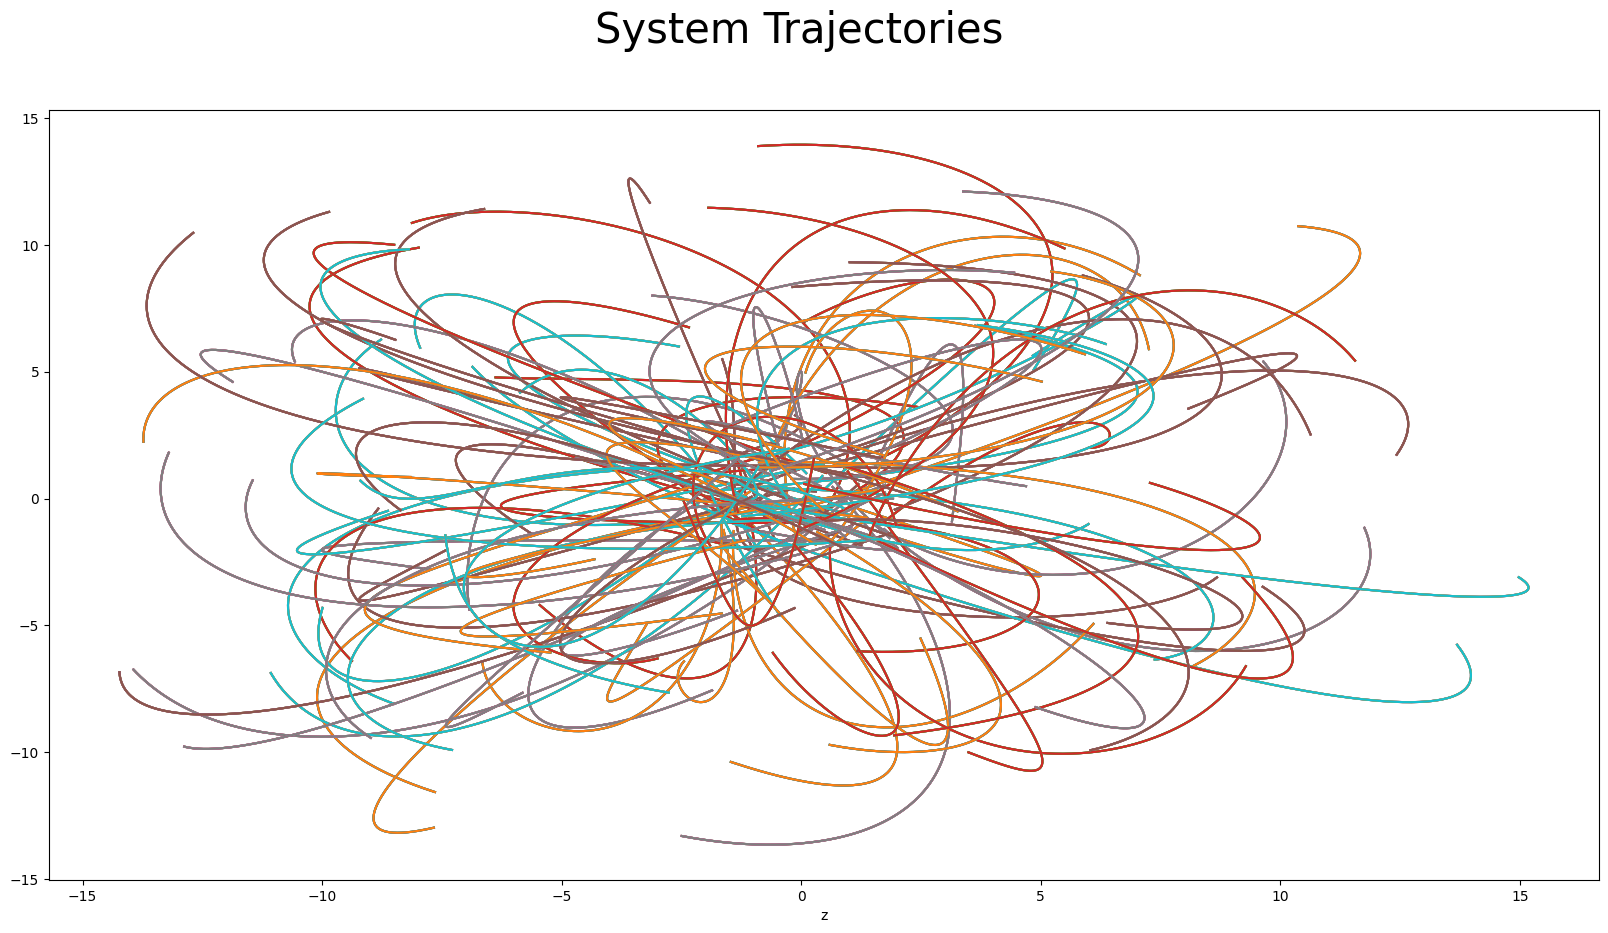

In [9]:
# Overall data
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(int(num_states)):
        plt.plot(X[j,:,0], X[j,:,1])
        plt.xlabel("y")
        plt.xlabel("z")
plt.suptitle("System Trajectories", fontsize=30)

Text(0.5, 0.98, 'Original Dynamics')

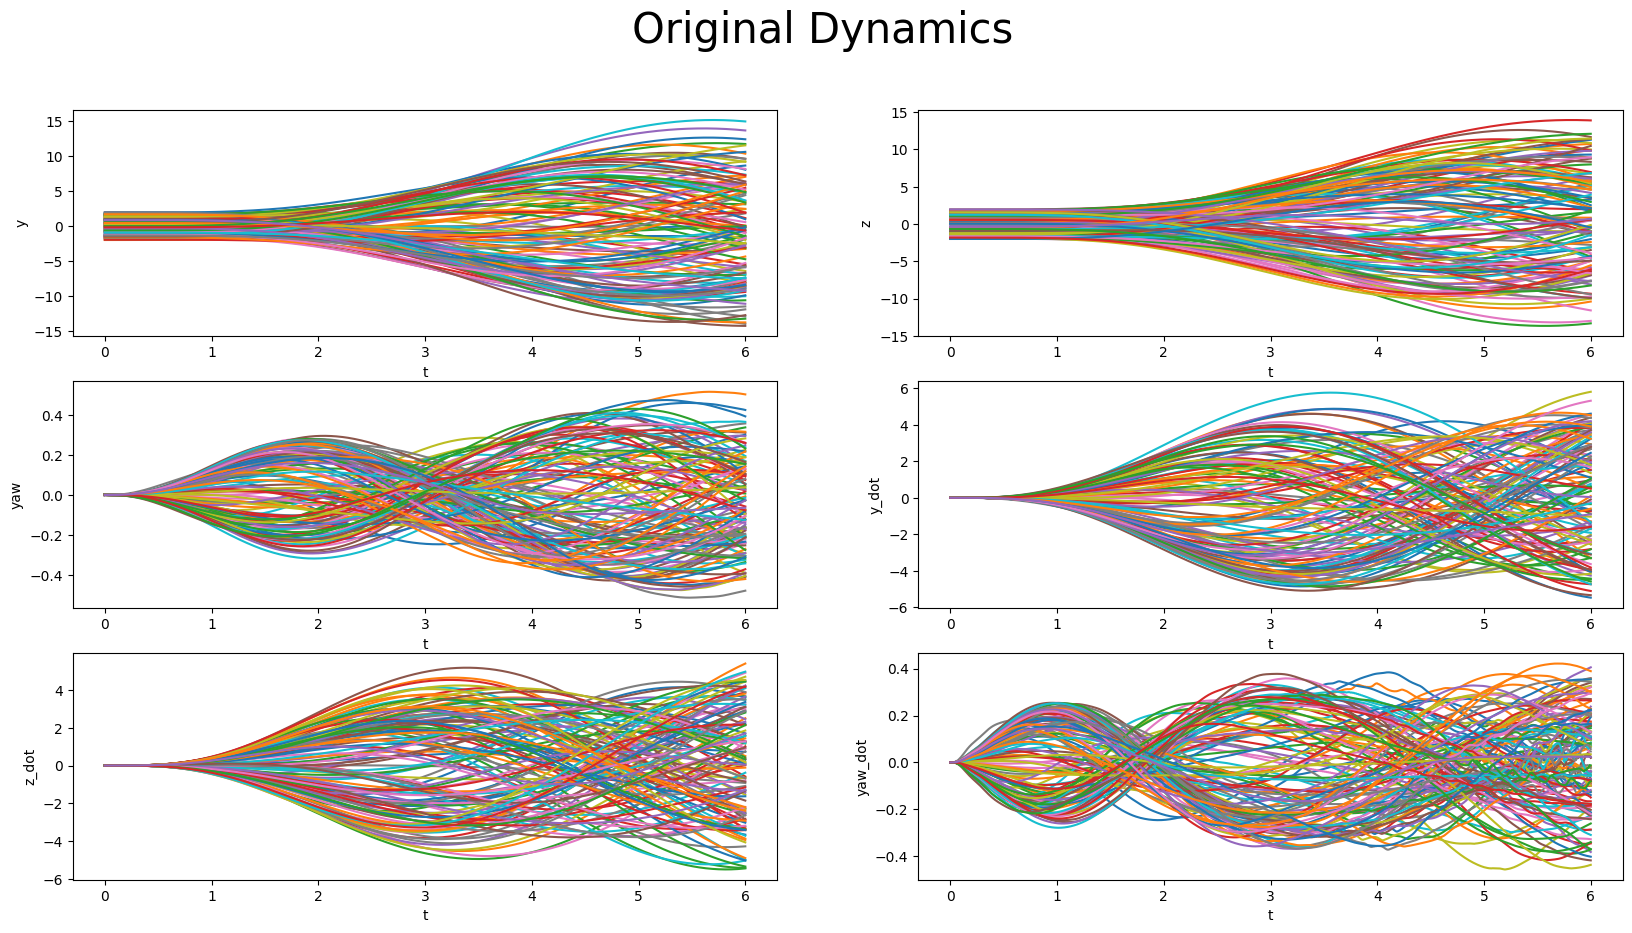

In [10]:
# Overall data
plt.figure(figsize = (20,10))
label_list = ["y", "z", "yaw", "y_dot", "z_dot", "yaw_dot"]

for j in range(num_traj):
    for i in range(int(num_states)):
        plt.subplot(3,2,i+1)
        plt.xlabel("t")
        plt.ylabel(label_list[i])
        plt.plot(T,X[j,:,i])
plt.suptitle("Original Dynamics", fontsize=30)

Text(0.5, 0.98, 'Control Inputs')

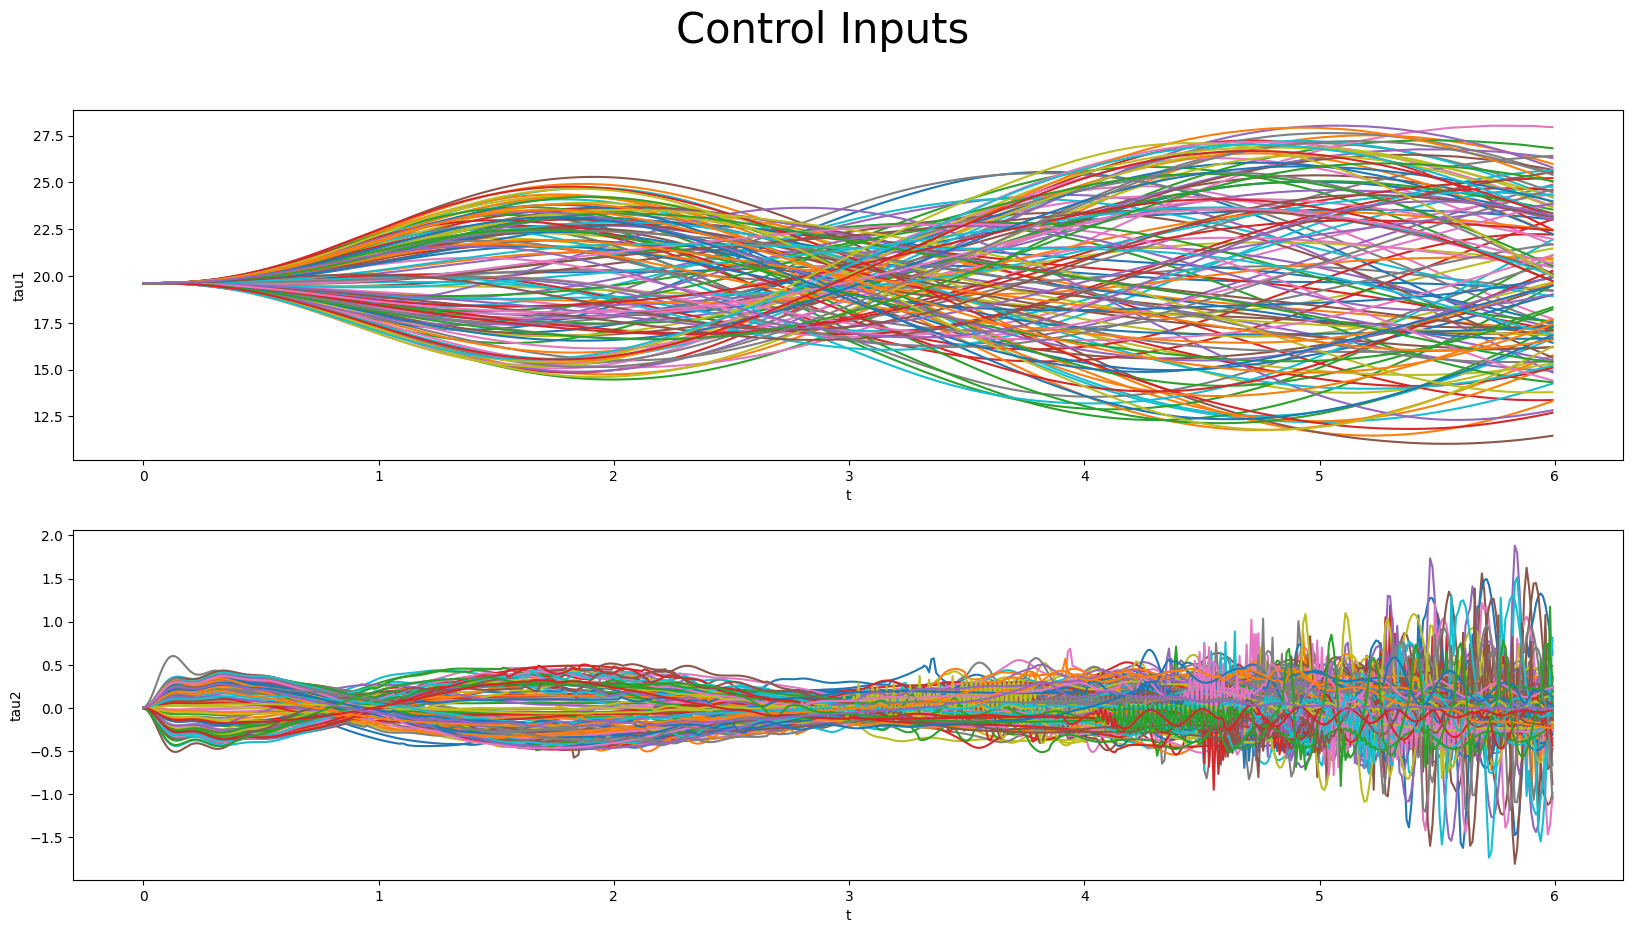

In [11]:
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(int(num_inputs)):
        plt.subplot(num_inputs,1,i+1)
        plt.xlabel("t")
        plt.ylabel("tau"+str(i+1))
        plt.plot(T[:-1],U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)

In [12]:
# split training and vaidation datasets
xs_train, us_train = X[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:],U[num_train:,:,:]

In [13]:
# auto encoder parameters
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 20
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 10
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 200
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [14]:
# Koopman Model
file = 'saved_models/planar_quad/linear/Koop_arch.pth'
if train == True:
    net = KoopmanNetCtrl_linear(net_params)
    model_koop_dnn = KoopDNN_linear(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    model_koop_dnn = torch.load(file)

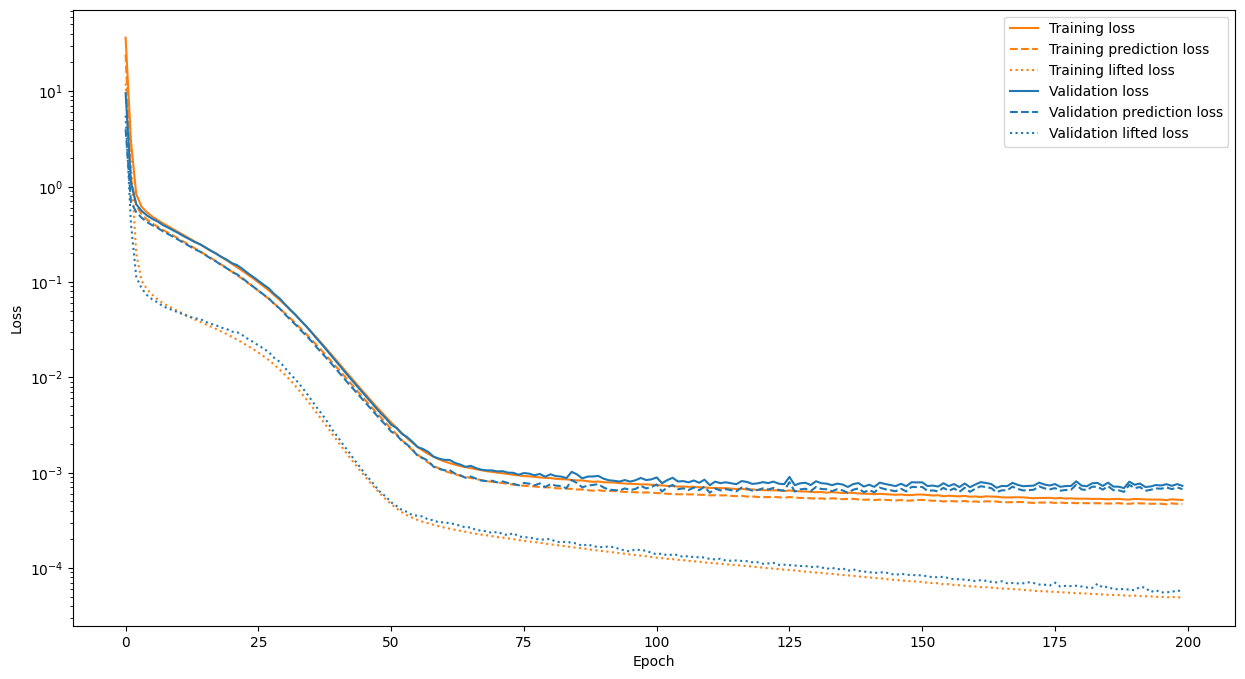

In [15]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Model Parameters

In [16]:
A = np.array(model_koop_dnn.A)
B = np.array(model_koop_dnn.B)
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(17, 17) (17, 2) (6, 17)


## Testing

In [17]:
# test data parameters
num_snaps_test = 200 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

In [18]:
# generate data
x_test = np.empty((num_traj_test,num_snaps_test+1,num_states)) # cartesian state matrix
u_test = np.empty((num_traj_test,num_snaps_test,num_inputs)) # input matrix
curr_state = []
# curr_state_noise = []
des_state = []
action_plt = []
for i in tqdm.tqdm(range(num_traj_test)):
    obs = env.reset()
    done = False
    
    # with open("/home/rajpal/koopman/linear_drone_koopman/Trajectory/traj_{}.csv".format(i+1), "w") as f:
    #     f.write("t,x,y,z,roll,pitch,yaw,vx,vy,vz,roll_rate,pitch_rate,yaw_rate,U,Mx,My,Mz\n")
         # X[i,0,:] = env.Quadrotor.get_state()
#         print(X[i,0,0],X[i,0,1],X[i,0,2],X[i,0,3],X[i,0,4],X[i,0,5],X[i,0,6],X[i,0,7],X[i,0,8],X[i,0,9],X[i,0,10],X[i,0,11])
        # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,0,0], X[i,0,1], X[i,0,2], X[i,0,3], X[i,0,4], X[i,0,5], X[i,0,6], X[i,0,7], X[i,0,8], X[i,0,9], X[i,0,10], X[i,0,11]))

    for j in range(num_snaps_test):
        #env.render()\n",
        action = env.action_space.sample()
        #action, _states = model.predict(obs)
#             U[i,j,:] = action[0], action[1]
        obs, reward, done, info = env.step(action)
        if j == 0:
            x_test[i,j,:] = env.Quadrotor.get_state()   
        # curr_state.append(state)
        # curr_state_noise.append(state)
        # des_state.append(env.get_des_state())
        action_plt.append(env.get_action())
        # #print(action)\n",
        # print(env.get_action().reshape(-1))
        u_test[i,j,:] = env.get_action()#.reshape(-1)
        x_test[i,j+1,:] = env.Quadrotor.get_state()
            
        # f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(env.t, X[i,j+1,0], X[i,j+1,1], X[i,j+1,2], X[i,j+1,3], X[i,j+1,4], X[i,j+1,5], X[i,j+1,6], X[i,j+1,7], X[i,j+1,8], X[i,j+1,9], X[i,j+1,10], X[i,j+1,11], U[i,j,0], U[i,j,1], U[i,j,2], U[i,j,3]))
        #plot_act.append(f)
        #print(reward)
        #plot_ep.append(episode)\n",
    #print(\"Episode - {} Score - {}\".format(episode, score))\n",

        
env.close()

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


In [19]:
print(x_test.shape, j)

(1, 201, 6) 199


In [20]:
# Use the preprocessing if available
X_t,_ = model_koop_dnn.net.process(x_test,data_u = u_test)

In [21]:
X_t.shape

(200, 14)

In [22]:
# flatten vector
x_t = X_t[:, :num_states]
u_t = X_t[:, num_states:num_states+num_inputs]
x_prime_t = X_t[:,num_states+num_inputs:]


print(x_t.shape, u_t.shape, x_prime_t.shape)

(200, 6) (200, 2) (200, 6)


In [23]:
# initialize states
# initialize the matricies
z_t = np.empty((n_obs,num_snaps_test)).T   #lifted state
x_est_t = np.zeros((num_states,num_snaps_test)).T #estimated values

# actual lift
z_t[0,:] = lift(x_t[0,:],model_koop_dnn, net_params)
x_est_t[0,:] = x_t[0,:]

# changed dynamics
obs = env_changed.reset()
x_actual_t = np.zeros((num_states,num_snaps_test)).T #estimated values
x_actual_t[0,:] = x_t[0,:]
env_changed.Quadrotor.state = x_actual_t[0,:]


In [24]:
for i in range(num_snaps_test-1):
  #bilinear
    z_t[i+1,:] = np.matmul(z_t[i,:],A.T)+np.matmul(u_t[i,:],B.T)
    x_est_t[i+1,:] = np.matmul(z_t[i+1,:],C.T)

    u1 = 0.5*(u_t[i, 0] - u_t[i, 1]/env_changed.L)
    u2 = 0.5*(u_t[i, 0] + u_t[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    x_actual_t[i+1,:] = env_changed.Quadrotor.get_state()

Text(0.5, 0.98, 'Testing Performance')

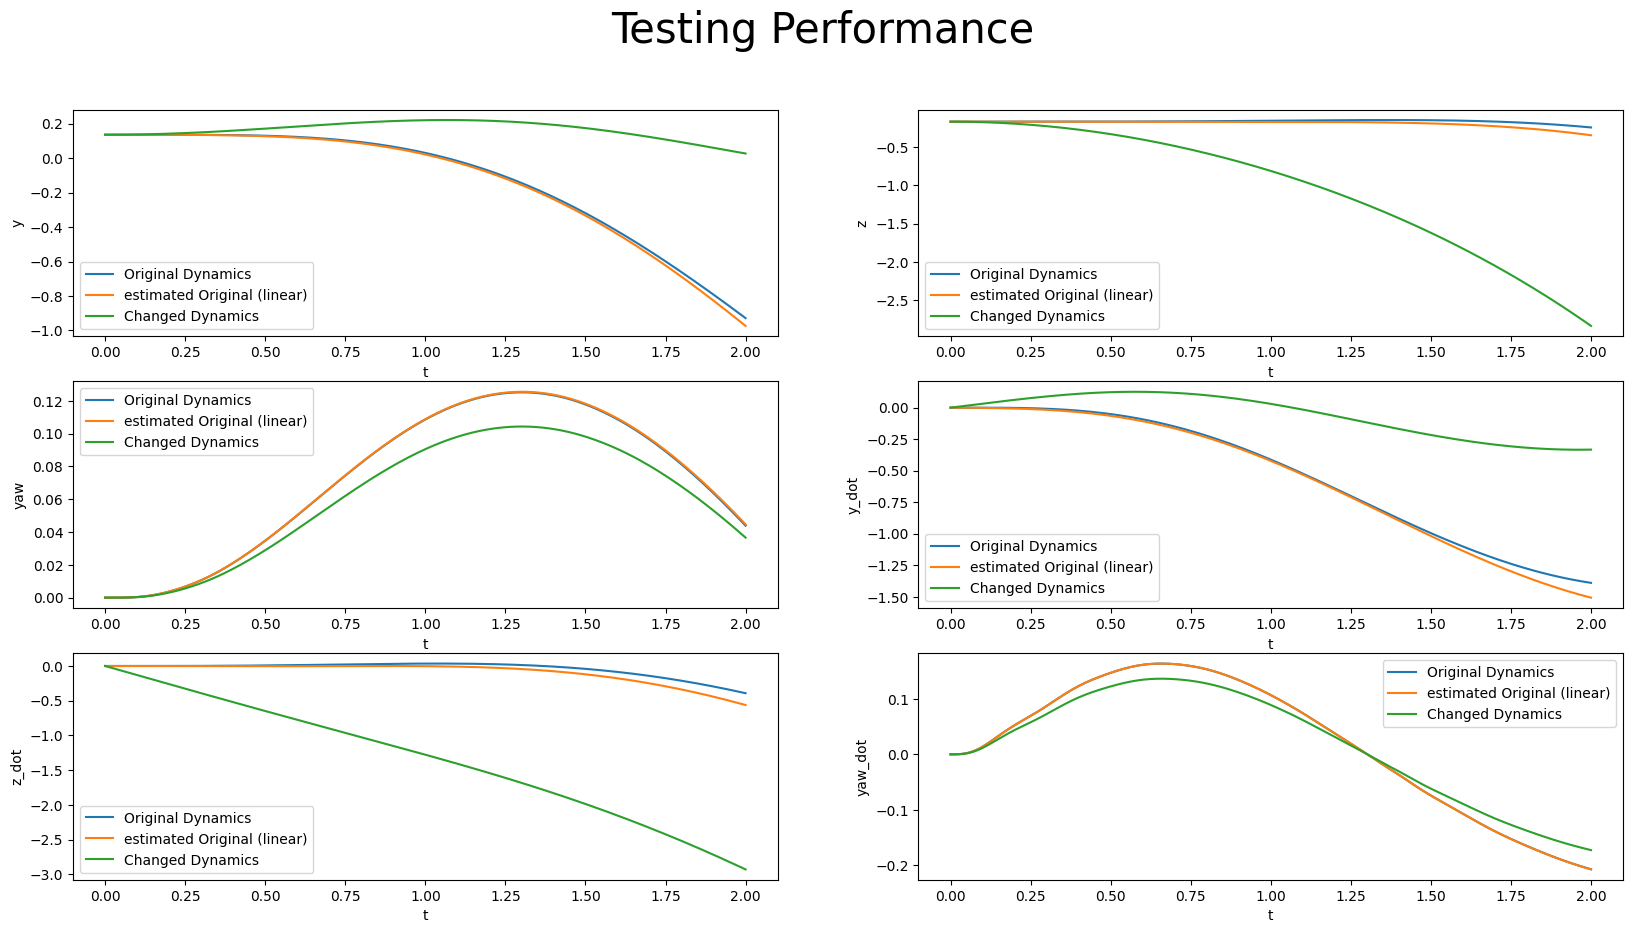

In [25]:
# state estimation evolution
plt.figure(figsize=(20, 10)) 

for i in range(num_states):
    plt.subplot(3, 2, i +1)
    plt.plot(T_test[:],x_t[:,i],label ='Original Dynamics')
    plt.plot(T_test[:],x_est_t[:,i],label = 'estimated Original (linear)')
    plt.plot(T_test[:],x_actual_t[:,i],label = 'Changed Dynamics')
    plt.xlabel('t')
    plt.ylabel(label_list[i])
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)


Text(0.5, 0.98, 'Testing Performance')

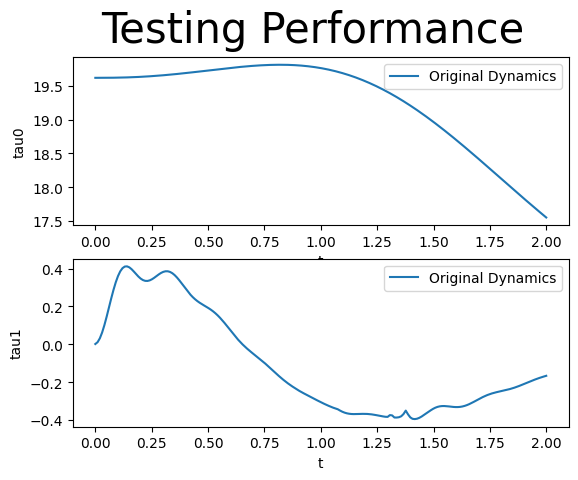

In [26]:
for i in range(num_inputs):
    plt.subplot(num_inputs, 1, i +1)
    plt.plot(T_test[:],u_t[:,i],label ='Original Dynamics')
    plt.xlabel('t')
    plt.ylabel("tau" + str(i))
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)

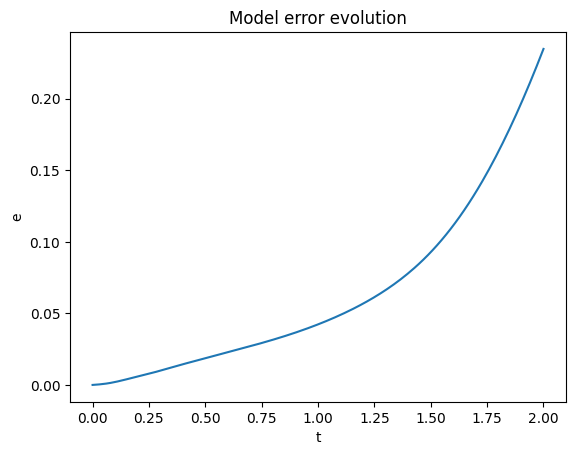

In [27]:
# error estimation
error_model_t = np.linalg.norm((x_est_t[:,:]-x_t[:,:]),axis=1)

plt.figure()
plt.plot(T_test[:],error_model_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()

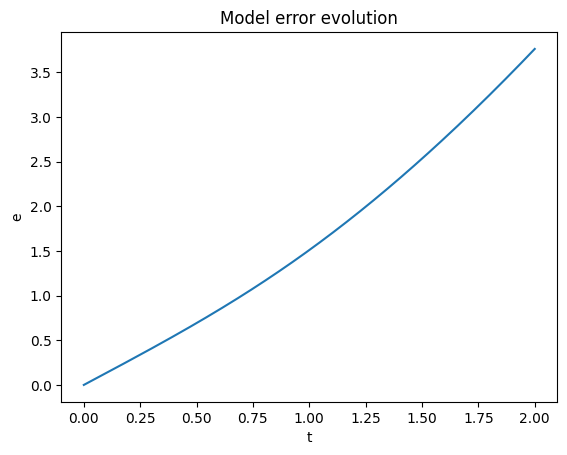

In [28]:
# error estimation
error_actual_t = np.linalg.norm((x_est_t[:,:]-x_actual_t[:,:]),axis=1)

plt.figure()
plt.plot(T_test[:],error_actual_t)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')
plt.show()


## Controller

In [67]:
traj_type = 'adobe'
if traj_type == 'lemniscate':
    traj_length =1250 #
elif traj_type == 'circle':
    traj_length = 1020
elif traj_type == 'S':
    traj_length = 1000 #1000
elif traj_type == 'adobe':
    traj_length =  1050 #1050
elif traj_type == 'line':
    traj_length = 3000

# if traj_type == 'lemniscate':
#     traj_length =1250
# elif traj_type == 'circle':
#     traj_length = 1020
# elif traj_type == 'S':
#     traj_length = 1000
# elif traj_type == 'adobe':
#     traj_length = 1050
####generate data
x_ref = np.empty((num_states, traj_length+1)) # cartesian state matrix

obs = env.reset(traj = traj_type)
done = False
    
for j in range(traj_length):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if j == 0:
        x_ref[:,j] = env.Quadrotor.get_state()   
    x_ref[:,j+1] = env.Quadrotor.get_state() 
env.close()
t_eval = dt * np.arange(traj_length+1)                       # Simulation time points, closed loop
# x_ref = np.load('quad_path.npy')

In [68]:
x_ref.shape

(6, 1051)

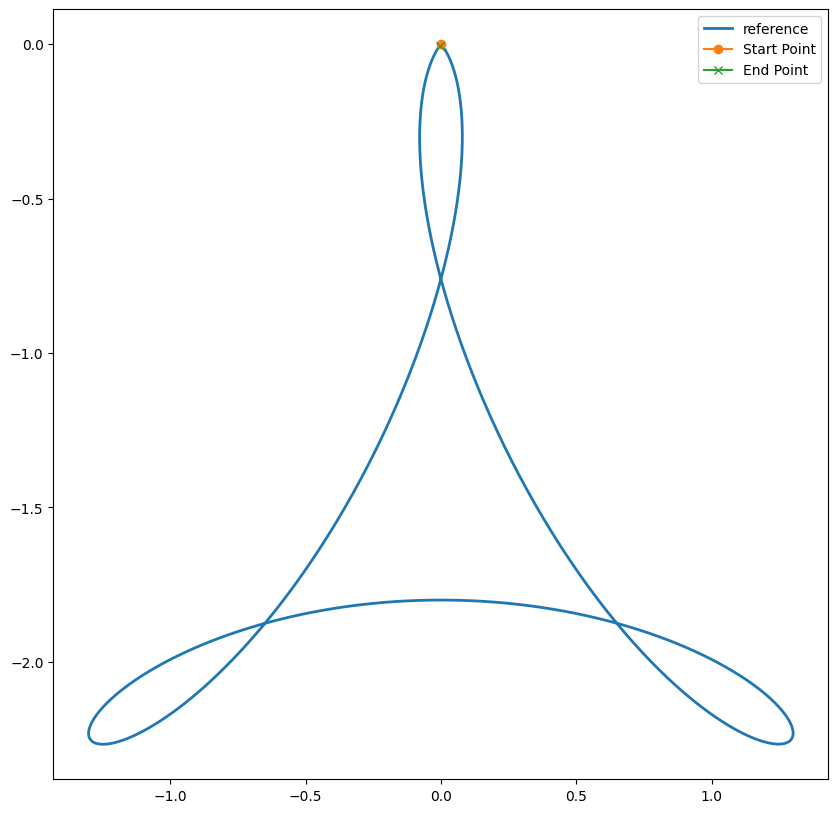

In [69]:
plt.figure(figsize=(10, 10) )
plt.plot(x_ref[0,:], x_ref[1,:], label='reference',linewidth = 2.0)
plt.plot(x_ref[0,0], x_ref[1,0], label='Start Point',marker = 'o')
plt.plot(x_ref[0,-1], x_ref[1,-1], label='End Point',marker = 'x')
plt.legend()

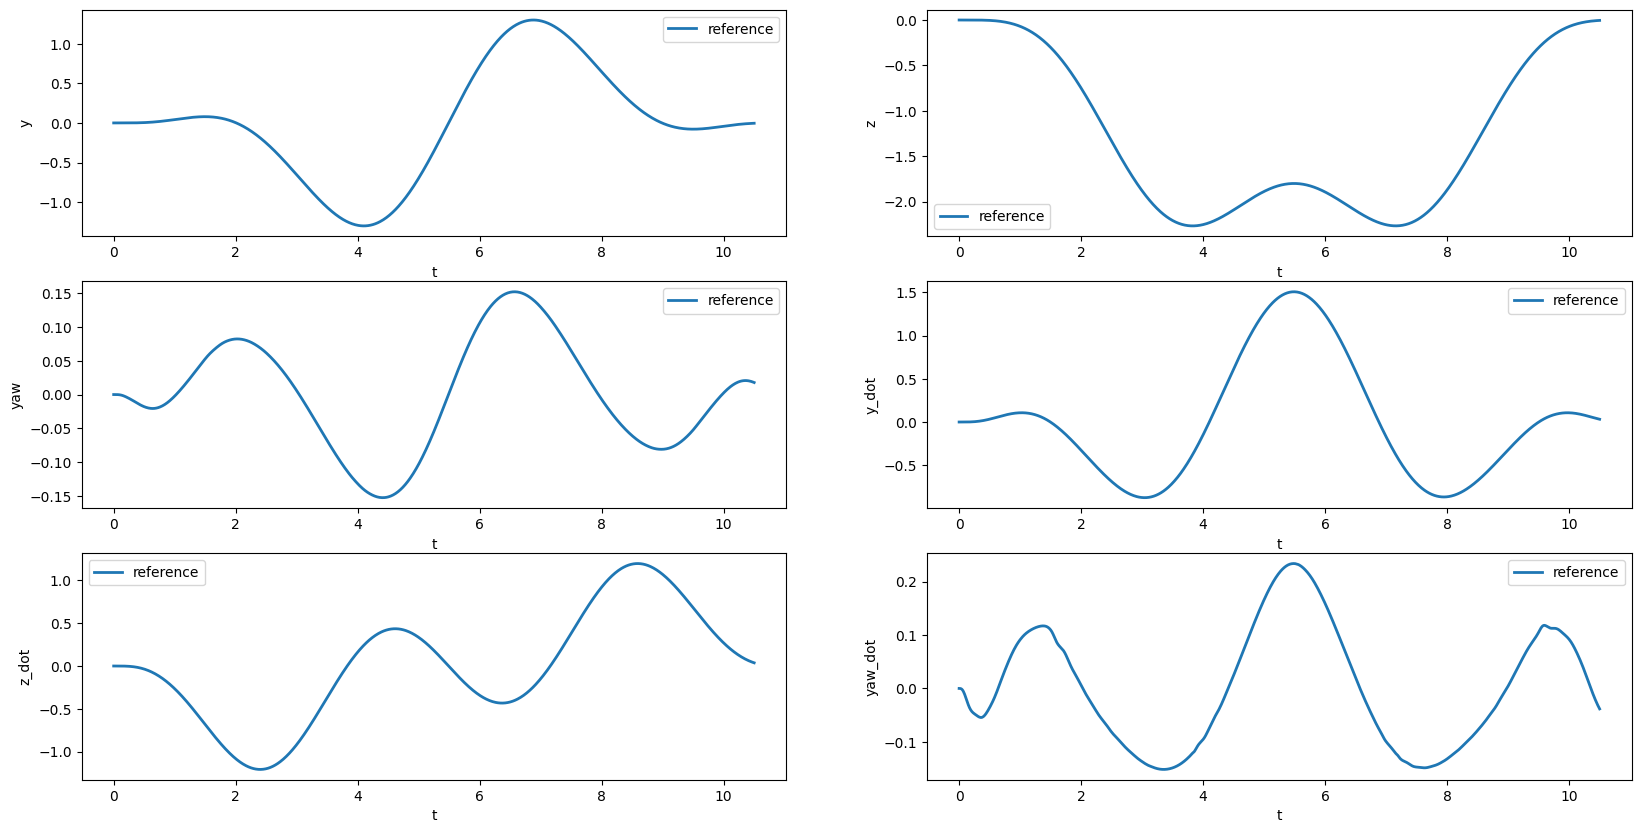

In [70]:
plt.figure(figsize=(20, 10) )
for i in range(num_states):
    plt.subplot(3,2,i+1)
    plt.plot(t_eval, x_ref[i,:], label="reference",linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel(label_list[i])
    plt.legend()

In [71]:
# adaptive net parameters

adap_window = 10 #20 #hyperparameterdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABmkAAANBCAYAAAALIFq/AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdd3hO9//H8eedvRORZQRBiL0FVauK0qHVPaiqTv1W6aB7aHXvobqM6h6qtFpVq6hZm5iRRBbZe9z3+f1xc6tfbZGT3Hk9rutccs59Ts7rlpucc96fYTEMw0BEREREREREREREREQqlYvZAURERERERERERERERGoiFWlERERERERERERERERMoCKNiIiIiIiIiIiIiIiICVSkERERERERERERERERMYGKNCIiIiIiIiIiIiIiIiZQkUZERERERERERERERMQEKtKIiIiIiIiIiIiIiIiYQEUaERERERERERERERERE7iZHcAZ2Gw2kpOT8ff3x2KxmB1HREREROS8MgyDvLw86tati4uL2n3JqemeSURERERqmtO9b1KRpgIkJycTGRlpdgwRERERkUqVmJhI/fr1zY4h1YDumURERESkpjrVfZOKNBXA398fsP9lBwQEmJxGREREROT8ys3NJTIy0nEdLHIqumcSERERkZrmdO+bVKSpAEe66wcEBOiGQ0RERERqDA1bJadL90wiIiIiUlOd6r5JA0iLiIiIiIiIiIiIiIiYQEUaERERERERERERERERE6hIIyIiIiIiIiIiIiIiYgLNSSMiIiIiFcowDMrLy7FarWZHkbPk6uqKm5ub5pxxYu+99x6vvPIKqamptGvXjnfeeYeuXbuecP9vv/2WJ554gvj4eKKjo3nppZcYPHhwJSYWEREREXFOKtKIiIiISIUpLS0lJSWFwsJCs6PIOfLx8aFOnTp4eHiYHUUq2Ndff824ceOYMmUKsbGxvPnmmwwcOJC4uDjCwsL+s/+KFSu44YYbmDx5MpdeeilffPEFQ4cOZf369bRu3dqEdyAiIiIi4jwshmEYZoeo7nJzcwkMDCQnJ4eAgACz44iIiJx3ZVYbabnFpOWWkJFfQkm5jXKbDVcXF/w93QjwdqNekA9h/p64uKglfk1hs9nYtWsXrq6uhIaG4uHhoZ4Y1ZBhGJSWlnLw4EGsVivR0dG4uBw7SrKuf6u32NhYunTpwrvvvgvY/+1GRkZy3333MWHChP/sf91111FQUMDcuXMd27p160b79u2ZMmXKaZ3TzM9Mem4xi3cexAJYLBYsgIsLWLBw5L8ox3aLfZt9X+DwPi6HX7dYDi/Ydzqy3cPNBS93V7zcXfByc8XL3RXPw9s83Vz0u1BERETEBIZhUFJuw8vd1ZTzn+41sHrSiIiIyCklZhayfPchVsdnsj0ljz3p+ZRabac8zsPNhSahfrSPDKJ9ZCBdGgXTONSvEhKLGUpLSx0Pe318fMyOI+fA29sbd3d39u/fT2lpKV5eXmZHkgpSWlrKunXrmDhxomObi4sL/fv3Z+XKlcc9ZuXKlYwbN+6YbQMHDmT27NknPE9JSQklJSWO9dzc3HMLfg52p+fz8HebTDs/gL+XG0E+7tTy8SDIx4Mgb3dq+bgTFuBFnUAv6gR6UzfIi4hALzzdzHmIICIiIlJd5BWXsT+jkOTsIg7ml3Awr4T0PPufh/JLyCksI7e4jNyiclxcYMdzl5gd+aRUpBEREZHjikvNY+6mZOZtSmHvoYKz+h6l5Ta2p+SyPSWXL1fbt0WF+HJRTBiDWkfQqWEt9bRwQv+/14VUT/o5OqdDhw5htVoJDw8/Znt4eDg7duw47jGpqanH3T81NfWE55k8eTLPPPPMuQeuAFVh6Ii84nLyistJzCw65b71grxpGubnWKLD/GhRJwBfT92+i4iISM1yMK+EbSm5bEvOZVd6HvszCtmfUcCh/NLT/yZWKCm3VumGMLrKExEREYfSchu/bklh+op41idkH3cfVxcLjUN8aRLqR0SgF6H+nni6ueDu6kK5zSCvuIzswjKSsgrZn1HInoP52P71hGzfoQI+/msfH/+1j6gQX67pXJ+rO9YnLEAt9UVEnMXEiROP6X2Tm5tLZGSkKVmahPrx/JWtMYzDBRvDwABsNvufR7YbhnH4a+Nf2/61bvx3u+3wSonVRkmZjeIy6+HFRnG5/euiMht5RWVkFZaSU1R2zO/E4zmQXcSB7CKW7Dzo2OZigWbh/rSPDKJdZBBdGgXTJNRXDR1ERETEaZSW29iSnMPqfZms2ZfJ5gM5pOeVnPrA4/D3ciPAy51Ab3cCvN0oKbepSCMiIiJVW2m5jW/XJfLun7tJySk+5jWLBbo0DKZXsxC6N6lN63qBZ3RxU1hazuakHNYnZLM4Lp21+7OwHn5Cte9QAS/Pj+ONBTu5skM97ujVhKZhGg5NROR8CQkJwdXVlbS0tGO2p6WlERERcdxjIiIizmh/AE9PTzw9Pc89cAWICPTiptiGZscA7IWhvOJysotKySwoJS23mOTsYlJyikjOKeZAVhF7DuaTV1x+7HEG7EjNY0dqHl+tSQSgTqAXFzQN4cLoEC5oGkKIX9X4+xYRERE5XXsP5rNwezqLd6azbn8WxWWnHlY9IsCLhrV9aFTbl/q1vAkL8CTU35NQPy/CAjwJ9vXA3bV6jQqgIo2IiEgNZhgGP6w/wBt/7CQp69ghWJqH+3N910iGtKlzTr1cfDzciG1cm9jGtbm7TxOyC0tZuD2d79YlsXJvBgBlVoNv1ibx7bokBrWKYPyAZjQN8z+n9yZyvhmGwZ133sl3331HVlYW//zzD+3btzc7lshJeXh40KlTJxYuXMjQoUMBsNlsLFy4kDFjxhz3mO7du7Nw4ULGjh3r2LZgwQK6d+9eCYmdi4uLhUAfdwJ93GlY2/e4+xiGwcG8Enal57M7PZ8dqXlsTMwmLi3P0cgBICWnmO/WJfHduiR7g4pGwQxuHcGg1nWICFTvVBEREal6DMNgQ2I2v2xOYeH29JMOrR7o7U6rugG0rBNAq3oBxEQE0Ki2L94eVbdHzNlSkUZERKSGikvN4/HZm1kTn3XM9n4xYdzZqzFdo4LPyzAqQT4eDOtUn2Gd6rM/o4Cv1iTy+d/7ySsuxzDg1y2p/LY1leu6NOCB/tEaBk2qrPnz5zNt2jQWL15M48aNCQkJMTuSyGkZN24cI0aMoHPnznTt2pU333yTgoICRo4cCcDw4cOpV68ekydPBuD++++nd+/evPbaawwZMoSvvvqKtWvXMnXqVDPfhtOyWCyEBXgRFmDvKXNEUamVLck5rN+fxfI9Gazel+FobWoYsHpfJqv3ZfL0z9voGhXMdZ0juaRNBD4euu0XERERc+3PKGD2P8nM3nCAfScozNQN9KJrVDBdo2rTNapmDe2qqzUREZEapqTcyhsLdvHRsr3HtMjt3SyUBy5uRvvIoErL0rC2L48MiuGePk34cnUCHy/bR3peCTYDvlydwOx/DjC2fzS39Yyqdt2VpXorLS3Fw8PjpPvs2bOHOnXq0KNHj7M+j2EYWK1W3Nx0WS6V57rrruPgwYM8+eSTpKam0r59e+bPn094eDgACQkJuLgc/T+3R48efPHFFzz++OM8+uijREdHM3v2bFq3bm3WW6iRvD1c6dIomC6NgrmzdxOKy6ys35/F0l2H+H1bKnsPHn3gcaRg89ScrVzWrg7DuzeiRZ0AE9OLiIhITWO1Gfy5I50ZK+NZtuvQf153sUDnhsFc1CKMi1qE16iizP+npx0iIiI1yK60PIa+t4IpS/Y4CjSNavsw47auTL+ta6UWaP7N38udO3o1YclDfXloYHP8PO0PrIvKrEz+dQeXvfMX6/ZnneK7iJy9Pn36MGbMGMaOHUtISAgDBw5ky5YtXHLJJfj5+REeHs4tt9zCoUP2m4tbb72V++67j4SEBCwWC40aNQLsw0ZNnjyZqKgovL29adeuHd99953jPIsXL8ZisfDrr7/SqVMnPD09+euvv077uIULF9K5c2d8fHzo0aMHcXFxx7yPn3/+mS5duuDl5UVISAhXXnml47WSkhIefPBB6tWrh6+vL7GxsSxevPj8/aVKlTZmzBj2799PSUkJq1atIjY21vHa4sWLmTZt2jH7X3PNNcTFxVFSUsKWLVsYPHhwJSeW/8/L3ZUeTUOYcEkMC8f15vcHejG2fzSNQ48Oo5ZfUs6XqxO55K1l3PzxKhbHpWMYxkm+q4iIiMi5yS8pZ+rSPfR6eRGjZ6w9pkBjsUCPJrV5eVhb1j1+Md/c1Z07e9vnpq2pBRpQTxoREZEawTAMZq1K4Lm52ygptw+N4uHqwr19m3Jn78Z4uVeNMV29PVy5t29Tru8SyRt/7GTWqgSMw5MlXz1lBaMuiOLBgc2rTF45tcve+YuDeSWVft5Qf09+vq/nGR0zffp07r77bpYvX052djb9+vXj9ttv54033qCoqIhHHnmEa6+9lj///JO33nqLJk2aMHXqVNasWYOrq/0zOXnyZD7//HOmTJlCdHQ0S5cu5eabbyY0NJTevXs7zjVhwgReffVVGjduTK1atU77uMcee4zXXnuN0NBQ7rrrLm677TaWL18OwLx587jyyit57LHHmDFjBqWlpfzyyy+OY8eMGcO2bdv46quvqFu3Lj/++CODBg1i8+bNREdHn8tft4iYzGKx0Czcn2bh/tx/UTTrE7L4Zk0SczclU1BqBeCv3Yf4a/chmof7c3//aAa1isDFpeY+DBEREZGKlVNYxrQV8Xy6fB85RWXHvNYg2IcbujbgivZ1qRvkbVLCqstiqBnNOcvNzSUwMJCcnBwCAtSFXEREqpbiMiuPz97Cd+uSHNuiw/x4+4YOVX7okw2J2Tz6w2a2peQ6tjUP9+eN69rTsm7Vzl4TFRcXs2/fPqKiovDyss8l1O2FhaTmFld6logAL/5+9KLT3r9Pnz7k5uayfv16ACZNmsSyZcv47bffHPskJSURGRlJXFwczZo148033+TNN98kPj4esPdUCQ4O5o8//jhmQvXbb7+dwsJCvvjiCxYvXkzfvn2ZPXs2V1xxxRkf98cff3DRRfb39csvvzBkyBCKiorw8vKiR48eNG7cmM8///w/7y8hIYHGjRuTkJBA3bp1Hdv79+9P165deeGFF/5zzPF+nkfo+lfOlD4z5sgvKef7dUl88tc+EjILj3mtZZ0Axg9oRr+YsBrdclVERETOTUFJOVOX7uXTv/aRV1J+zGt9mocyonsjejcLrZGNQ073Glg9aURERJxYWm4xd8xcx8bEbMe24d0b8ujgFtWiN0r7yCDmjLmAT5fv49XfdlJqtRGXlscV7/3FgwOaM/rCxjXyQq86CfX3rDbn7dSpk+PrjRs3smjRIvz8/P6z3549e2jWrNl/tu/evZvCwkIuvvjiY7aXlpbSoUOHY7Z17tz5rI5r27at4+s6deoAkJ6eToMGDdiwYQOjR48+7nvbvHkzVqv1P7lLSkqoXbv2cY8RkerPz9ONET0acXO3hizYlsaHS/fwT0I2ANtSchk1fS2dG9bi6ctb0bpeoLlhRUREpFqx2gy+XZvIawt2HjN6gquLhSva1+WePk1pGvbf+yn5LxVpREREnNS25Fxu/Ww16YcvlrzcXXjl6nZc1q7uKY6sWtxcXbijVxN6Nwtj7Ncb2J6SS5nVYPKvO1i9L5PXr21PoI+72THlBM50yDEz+fr+ax6H/Hwuu+wyXnrppf/sd6Q48v/l5+cD9mHH6tWrd8xrnp7HFo3+/7lO9zh396Of9SMt3202+xCG3t4nHjYgPz8fV1dX1q1b5xia7YjjFaJExLm4ulgY1DqCga3CWbLzIK/9vpPNB3IAWLs/i8ve/Yvru0Ty4IDm1PYzp7guIiIi1cffezN46qetxKXlOba5uVi4pnN97u7dlAa1fUxMV/2oSCMiIuKE/t6bwejpax1djesFeTN1eCda1a2+rWSbR/gz+94evLFgFx8u3YNhwMId6Vz67jI+uKmTWgBLherYsSPff/89jRo1ws3t9C6ZW7ZsiaenJwkJCcfMI3O+jvv/2rZty8KFCxk5cuR/XuvQoQNWq5X09HQuvPDCsz6HiFRvFouFPs3D6N0slAXb0nhx/g72HizAMODL1YnM3ZTChEtiuLFrAw2BJiIiIv+RWVDKC79sP2Y4dYCBrcJ5ZFAMjUPVAOxsqEgjIiLiZOZvSeF/X22gtNzeur5DgyA+Ht7ZKVrGerq5MuGSGLo3qc39X/1DdmEZiZlFXPXBCl64sg1Xd6pvdkRxEvfeey8fffQRN9xwAw8//DDBwcHs3r2br776io8//vg/vVEA/P39efDBB3nggQew2Wz07NmTnJwcli9fTkBAACNGjDjuuc72uP/vqaee4qKLLqJJkyZcf/31lJeX88svv/DII4/QrFkzbrrpJoYPH85rr71Ghw4dOHjwIAsXLqRt27YMGTLknP6+RKR6sVgsDGgVQZ/mYcxYGc+bf+wiv6ScvOJyHvtxC/M2pfDSsLZEBqsVrIiIiIBhGPyw/gCT5m0jq7DMsb1d/UAev7QlXRoFm5iu+nMxO4CIiIhUnNn/HOCeWesdBZq+zUP54vZuTlGg+bfezUKZe19P2tW3954pLbfx4LcbeWn+Dmw2w+R04gzq1q3L8uXLsVqtDBgwgDZt2jB27FiCgoJwcTnxJfRzzz3HE088weTJk2nRogWDBg1i3rx5REVFnfR8Z3vcv/Xp04dvv/2WOXPm0L59e/r168fq1asdr3/22WcMHz6c8ePH07x5c4YOHcqaNWto0KDBaZ9DRJyLh5sLt1/YmD8f7M2wjkcbOqzYk8GAN5YyfUW8fq+KiIjUcBn5Jdw5cx3jv93oKND4e7kxaWhrfrznAhVoKoDFMAxdcZ2j3NxcAgMDycnJISAgwOw4IiJSQ83+5wDjvtnAkWcpV3Wsx0vD2uLu6rxtMkrKrTz78zZmrUpwbBvUKoI3rmuPt8d/ezrI+VVcXMy+ffuIiorCy8vL7Dhyjk7289T1r5wpfWaqh6U7DzLxh80cyC5ybOvbPJRXr2nndA0+RERE5NQW7Ujnoe82cSi/xLHt0rZ1ePLSloQF6J7vVE73Gth5n9qIiIjUIP+/QHNztwa8enU7py7QgH34s+evbMPTl7XE5fDQ+fO3pnLthytJyy02N5yIiEg106tZKPPHXsjN3Y72sFsUd5DBby9j5Z4ME5OJiIhIZSott/H0nK2MnLbGUaAJ9vXgw1s68e6NHVWgqWDO/eRGRESkBpi/JeU/BZpnL2+Ni0vNmfD31gui+OTWLvh52qfb23wgh6HvLWd3ep7JyURERKoXfy93Jg1tw/TbulLb1wOAtNwSbvz4b978Y6eGPxMREXFyKTlFXDd1JdNWxDu29W1ub8gxsFWEecGcmIo0IiIi1djfezP431c1u0BzRN/mYXx/dw/qBXkDkJJTzNVTVvJPQpbJyURERKqf3s1C+fX+C7mgaW0ADAPe/GMXd32+jvyScpPTiYiIyPmwfPchhrz9F/8kZAP2+eueG9qaT2/tQpi/es+cLyrSiIiIVFPbU3IZPX0tpeU2wD4HTU0t0BzRPMKf2fdeQOt69rFeswvLuPGjVSzZedDkZCIiItVPWIAXM26L5cEBzRzDiv6+LY2r3l/O/owCc8OJiIhIhTEMg4+X7eWWT1aRWVAKQP1a3nx/Vw9u6dYQi6XmPmeoDCrSiIiIVEOJmYWM+HQ1eYdbsvZpHspLw9rW6ALNEaH+nnw5uhvdG9tb/haVWbl9+hrmbEw2OVnNYRgaCscZ6OcoIgCuLhbG9Ivm01u74O9lH1Z0Z1o+V7y3XPPUiIiIOIFyq43HZ29h0rztjlE6+jQPZe59PWlTP9DccDWEUxVpli5dymWXXUbdunWxWCzMnj37lMcsXryYjh074unpSdOmTZk2bdp5zykiInIucorKGPHZatLz7JP3dWgQxPs3dcTd1al+rZ8Tfy93PhvZhUGHx8stsxrc/9U/fLk6weRkzs3d3R2AwsJCk5NIRTjyczzycxWRmq1P8zB+uvcCGof6AvbeqiM+Xc3cTWoEISIiUl3lFpcxctoaZq06eq98X7+mfDqiC0E+HiYmq1nczA5QkQoKCmjXrh233XYbV1111Sn337dvH0OGDOGuu+5i1qxZLFy4kNtvv506deowcODASkgsIiJyZsqtNu778h/2HrQPMdIk1JdPR3TBx8OpfqVXCC93V967qSOPz97Ml6sTMQyY+MNmym0Gt3RraHY8p+Tq6kpQUBDp6ekA+Pj4qFt8NWQYBoWFhaSnpxMUFISrq6vZkUSkimgc6sfsey/gf1/+w+K4g5Qevi45mFfCyAuizI4nIiIiZyA1p5jhn65iZ1o+AO6uFl4a1parOtY3OVnN41RPdC655BIuueSS095/ypQpREVF8dprrwHQokUL/vrrL9544w0VaUREpEp64ZcdLD08v0qwrwfTRnallq9at5yIq4uFF65sg5+nGx8t2wfAE7O3YLXauFUPk86LiAh776UjhRqpvoKCghw/TxGRIwK83Pl4eGce/XEz36xNwjDgmZ+3kZpbzIRBMSrOi4iIVAPxhwq4+ZNVJGUVARDk486HN3ci9vCw4VK5nKpIc6ZWrlxJ//79j9k2cOBAxo4de9LjSkpKKCkpcazn5uaej3giIiLH+HpNAp8utxca3FwsfHBTRyKDfUxOVfVZLBYeHdwCN1cXPli8B4Cnf95Guc3g9gsbm5zO+VgsFurUqUNYWBhlZWVmx5Gz5O7urh40InJCbq4uvDSsLeEBXrzz524APlyyl/zicp67orXmyBMREanCdqTmcvPHqzmUb3++HRnszYzbYokK8TU5Wc1Vo4s0qamphIeHH7MtPDyc3NxcioqK8Pb2Pu5xkydP5plnnqmMiCIiIgCsic/k8dlbHOuThrZWC5czYLFYeHhgc9xdLLx9+GHSpHnbKbMa3N2nicnpnJOrq6se8ouIODGLxcL4Ac0JD/DiiZ+2YBgwa1UCZVYbk69qi6sKNSIiIlXO+oQsRn62hpwie4O65uH+zBjVlfAAL5OT1WyaYfgsTJw4kZycHMeSmJhodiQREXFiB/NKuHfWesqsBgC39mjE9V0bmJyq+rFYLIwb0JwH+jdzbHtp/g4+WrrXxFQiIiLV283dGvLmde05UpP5Zm0SD327EavNMDeYiIiIHGN9QhbDP1ntKNC0jwzi6zu7qUBTBdTonjQRERGkpaUdsy0tLY2AgIAT9qIB8PT0xNPT83zHExERwWozuP+rf0jPs3dD7tGkNo8PaWFyqurt/v7RuLlaeOW3OACe/2U7Xu4u3NK9kbnBREREqqkr2tfDzcWF/331D1abwQ//HMBqGLx+bXv1qBEREakCNiRmM+KT1eSXlAP2ZwsfDe+Mr2eNLg9UGTW6J0337t1ZuHDhMdsWLFhA9+7dTUokIiJyrDf/2MmKPRkAhPl78tb1HXBzrdG/vivEvX2bMu7ioz1qnvhpK9+sVc9YERGRszWkbR3eu7Ej7q72osxPG5J57MfNGIZ61IiIiJhpU1I2t3yyirzDBZqeTUP49NYuKtBUIU71lCc/P58NGzawYcMGAPbt28eGDRtISEgA7MOUDR8+3LH/XXfdxd69e3n44YfZsWMH77//Pt988w0PPPCAGfFFRESOsTgu3TEZr6uLhXdv7Eiov3pyVpT7+jXlnn/NR/PI95v4acMBExOJiIhUb4NaR/DBTZ1wO9x75qs1iUyat12FGhEREZNsOZDDzR+vIq/42B40Xu6aP7Qqcaoizdq1a+nQoQMdOnQAYNy4cXTo0IEnn3wSgJSUFEfBBiAqKop58+axYMEC2rVrx2uvvcbHH3/MwIEDTckvIiJyREpOEQ98vcGx/vDA5nSNCjYvkBOyWCw8NLA5Iy9oBIBhwLhvNjJ/S6q5wURERKqx/i3DeeO69lgOj3L2yV/7eGvhLnNDiYiI1ED7DhUw4tPV5B4u0HRrHMzHIzrj7aECTVVjMdSk5Zzl5uYSGBhITk4OAQEBZscREZFqzmYzuOXTVSzfbR/mrH+LcD4a3gmLRWO6nw+GYfDY7C18screkMPd1cLU4Z3p2zzM5GQiVZeuf+VM6TNT83y9JoFHvt/sWH/qspaMvCDKxEQiIiI1R1puMcM+WEFSVhEAnRvWYvptXTXEWSU73Wtgp+pJIyIi4gw+Xb7PUaCpE+jFa9e0U4HmPLJYLEy6ojVXdawHQJnV4O7P17E2PtPkZCIiItXXdV0a8MSlLR3rz87dxq+bU0xMJCIiUjPkFJYx/JPVjgJNTIQ/n4zQHDRVmYo0IiIiVci25Fxenh8HgMUCr13bjkAfd5NTOT8XFwsvD2vLkDZ1ACgus3HbtDXsSM01OZmIiEj1NapnFP/r1xSwDys69usNagQhIiJyHhWXWRk1fQ1xaXkA1K/lzfTbuuq5QhWnIo2IiEgVUVxmZezX/1BqtQFwx4WN6dEkxORUNYebqwtvXNeeC6Ptf+e5xeUM/2Q1iZmFJicTERGpvh64uBnDOtYHoKTcxu0z1rLnYL7JqURERJyPzWbw4LcbWbs/C4AQPw9mjoolPMDL5GRyKirSiIiIVBEvzd/BzjT7Q4uWdQIYN6CZyYlqHg83F6bc3Il2kUEApOeVcPMnqziYV2JuMBERkWrKYrEw+ao29GxqbwSRXVjGrZ+tJiNfv1tFREQq0ht/7GTuJvvQoj4erkwb2ZWoEF+TU8npUJFGRESkCli26yCfLY8HwNPNhbeub4+nm6u5oWooX083pt3ahaZhfgDszyhk+KeryS0uMzmZiIhI9eTh5sIHN3ckJsIfgMTMIu6etZ7ScpvJyURERJzD9+uSeOfP3YB96PS3r+9A63qBJqeS06UijYiIiMnyist45LtNjvVHB7cgOtzfxERSy9eDGbd1pW6gvVv49pRcbp++luIyq8nJREREqid/L3emjexKmL8nAKv3ZfLMz1tNTiUiIlL9rdqbwYQfjj5TeHxIS/q3DDcxkZwpFWlERERMNvnXHSTnFAPQs2kIw7s3NDmRANQN8mbGqFiCfT0A+8OkMV+sp9yqVr8iIiJnIyLQiw9v6YSHm/1RxKxVCcz8e7/JqURERKqv+EMF3Pn5OsqsBgA3d2vAbRc0MjeUnDEVaUREREy0YvchvliVANjHjJ18VRssFovJqeSIpmF+TBvZBV8P+9Bzf2xP59EfN2MYhsnJREREqqcODWox+co2jvVn5mzl770ZJiYSERGpngpKyrlz5jqyC+1Dc18YHcLTl7XSM4VqSEUaERERkxSWlvPIv7okT7gkhshgHxMTyfG0rR/E1OGd8XC1XzZ9szaJN/7YZXIqERGR6mtYp/qMvjAKgHKbwd2fryMxs9DkVCIiItWHYRg8/P0m4tLyAGgS6st7N3XEzVWP+6sj/dRERERM8vL8OBIziwDoGhXMzbEa5qyquqBpCK9d286x/vbCXcxapeFZREREztaES1rQq1koAFmFZdwza73mfhMRETlNHy/bx7xNKQD4eboxdXhnArzcTU4lZ0tFGhEREROsic9k+sp4ALzcXXh5WFtcXNQluSq7rF1dnri0pWP9idlb+H1rqomJRETOXGZmJjfddBMBAQEEBQUxatQo8vPzT3pMnz59sFgsxyx33XVXJSUWZ+XqYuGdGzrQqLa9F/HmAzlMmrfN5FQiIiJV34rdh5j863bH+uvXtqNJqJ+JieRcqUgjIiJSyUrKrTzy/SaOTGvy4IDmNArxNTeUnJZRPaO4o1djAGwG3PflP6zbn2VyKhGR03fTTTexdetWFixYwNy5c1m6dCl33HHHKY8bPXo0KSkpjuXll1+uhLTi7AK93Xn/pk54utkfTXz+dwI/bThgcioREZGq60B2EWO+/Afb4ecJ9/VryoBWEeaGknOmIo2IiEglm7pkL3sPFgDQPjKIkRdEmZxIzsSEQTFc0b4uACXlNkZNX8Pu9JO3QhcRqQq2b9/O/Pnz+fjjj4mNjaVnz5688847fPXVVyQnJ5/0WB8fHyIiIhxLQEBAJaUWZ9eybgDPXtHKsT7xh83sTs8zMZGIiEjVVFpu495Z68ksKAWgT/NQxvZvZnIqqQgq0oiIiFSi+EMFvLNoN2Af5uOFK9vgqmHOqhUXFwuvXN2OC5rWBiC7sIwRn64mLbfY5GQiIie3cuVKgoKC6Ny5s2Nb//79cXFxYdWqVSc9dtasWYSEhNC6dWsmTpxIYeHJJ3kvKSkhNzf3mEXkRK7tHMmwjvUBKCy1cvfn6yksLTc5lYiISNXy6u9xbEjMBqBBsA9vXddBzxOchIo0IiIilcQwDJ6cs5XSchsAt13QiJZ11RK5OvJwc2HKzZ1oWcf+8zuQXcStn60ht7jM5GQiIieWmppKWFjYMdvc3NwIDg4mNfXEc2zdeOONfP755yxatIiJEycyc+ZMbr755pOea/LkyQQGBjqWyMjICnkP4pwsFguThramebg/ALvS83l89haTU4mIiFQdf+5IY+rSvQC4u1p478aOBPq4m5xKKoqKNCIiIpXkl82pLN15EIA6gV7qllzN+Xu5M21kF+rX8gZge0oud81c5yjCiYhUlgkTJmCxWE667Nix46y//x133MHAgQNp06YNN910EzNmzODHH39kz549Jzxm4sSJ5OTkOJbExMSzPr/UDN4errx/c0d8PVwB+GH9Ac1PIyIiAqTkFDH+m42O9UcHt6BN/UATE0lFU5FGRESkEuQVl/HMz1sd609f3gpfTzcTE0lFCAvwYvptXQk63IJpxZ4MHvx2I7YjsziKiFSC8ePHs3379pMujRs3JiIigvT09GOOLS8vJzMzk4iI059wNjY2FoDdu3efcB9PT08CAgKOWUROpUmoH89f2cax/viPW0jMPPnQeiIiIs6s3Grj/i83kFVoH7Xh4pbh3NqjkbmhpMLp6ZCIiEgleO33naTnlQDQv0UYA1qGm5xIKkqTUD8+GdGFmz7+m+IyG3M2JhMe4MljQ1qaHU1EaojQ0FBCQ0NPuV/37t3Jzs5m3bp1dOrUCYA///wTm83mKLycjg0bNgBQp06ds8orcjJDO9RjcVw6szckk1dSzgNfb+CrO7rh5qo2piIiUvO8tXAXq+MzAagX5M0rV7fFYtE8NM5GVzkiIiLn2eakHGasjAfA292Vpy9vpYsqJ9OpYS3euaEjR+Zs/GjZPj5ettfcUCIi/0+LFi0YNGgQo0ePZvXq1SxfvpwxY8Zw/fXXU7duXQAOHDhATEwMq1evBmDPnj0899xzrFu3jvj4eObMmcPw4cPp1asXbdu2NfPtiBN7dmhrx3Cia/dn8d6iEw+tJyIi4qxW78vk3UX2nsuuLhbevqE9QT4eJqeS80FFGhERkfPIZjN44qctHBn96v7+0dSv5WNuKDkvLm4ZfswQLZPmbefnjckmJhIR+a9Zs2YRExPDRRddxODBg+nZsydTp051vF5WVkZcXByFhfYhpjw8PPjjjz8YMGAAMTExjB8/nmHDhvHzzz+b9RakBgjwcuet69vjerj1w9t/7mLd/kyTU4mIiFSevOIyHvh6A8bhZwnjLm5Gp4bB5oaS80bDnYmIiJxHP/xzgA2J2QBEh/kxqmeUuYHkvLqhawNSc4p5a+EuAMZ/s5Hafh70aBJicjIREbvg4GC++OKLE77eqFEjDOPovFqRkZEsWbKkMqKJHKNTw2Du69eUN//YhdVmcP9XG5g/thd+mtNPRERqgGd+3saB7CIAujYK5q7eTUxOJOeTetKIiIicJ/kl5bw0f4dj/anLWuGu8dSd3tj+0VzfJRKAUquNO2esY1tyrsmpREREqp8xfZvSuWEtAJKyinh+3naTE4mIiJx/87ek8N26JAD8PN147dp2jt6l4pz0pEhEROQ8eefPXRzMKwFgYKtwekarN0VNYLFYmDS0NRfFhAGQV1LOrZ+tJjGz0ORkIiIi1YubqwtvXNceHw9XAL5cncCSnQdNTiUiInL+pOcWM/GHzY71py9vRWSwhkx3dirSiIiInAf7DhXw6V/7APBwc+HxIS1NTiSVyc3VhXdv7Ej7yCAA0vNKGP7pajLyS8wNJiIiUs1EBvvw6OAWjvVHvttETlGZiYlERETOD8MwePj7TWQV2n/PXdI6gmEd65mcSiqDijQiIiLnwaS52yiz2sf0v+PCxmr5UgN5e7jy6a1daBzqC9gLdyOnrSG/pNzkZCIiItXLTbEN6NnU3iM5NbeY5+ZuMzmRiIhIxft8VQKL4+w9RkP9PXn+yjZYLBrmrCZQkUZERKSCLYpLZ+GOdAAiAry4p68m+Kupgn09mDkqlogALwA2JeVw18x1lJbbTE4mIiJSfVgsFl66ui3+nm4AfLcuiYXb00xOJSIiUnESMgp54V9zr71ydVuCfT1MTCSVSUUaERGRClRabuO5n4+27pw4OAYfDzcTE4nZ6gV5M2NUVwK93QH4a/chxn+7EZvNMDmZiIhI9VEvyJsnLj06fOyEHzaTXVhqYiIREZGKYbMZPPL9JorKrADc3K0BfZqHmZxKKpOKNCIiIhVoxsp49h4qAKBzw1pc3q6uyYmkKmgW7s+nt3bGy91+6fXzxmSenbsNw1ChRkRE5HRd07k+fZuHAnAwr4Sn5mw1OZGIiMi5+2J1Aiv3ZgD2RgkTLmlxiiPE2Thlkea9996jUaNGeHl5ERsby+rVq0+477Rp07BYLMcsXl5elZhWREScRXZhKW8v3AWAxQJPX95K48eKQ6eGwbx/U0dcXeyfiWkr4nlv0W6TU4mIiFQfFouFF4e1JcDL3kv5pw3J/LlDw56JiEj1lZRVyORfjg5z9uKwNvh5ajSOmsbpijRff/0148aN46mnnmL9+vW0a9eOgQMHkp6efsJjAgICSElJcSz79++vxMQiIuIs3vlzN7nF9knhr+5Yn9b1Ak1OJFVNv5hwXhrW1rH+6u87+XJ1gomJREREqpfwAC+euqyVY/3xH7eQX1JuYiIREZGzYxgGE3/YTEGpfZiz67tEcmF0qMmpxAxOV6R5/fXXGT16NCNHjqRly5ZMmTIFHx8fPv300xMeY7FYiIiIcCzh4eGVmFhERJzB/owCZqyMB8DL3YXxA5qbG0iqrKs71WfiJTGO9cd+3Mz8LakmJhIREalerupYjwujQwBIzinm1d/iTE4kIiJy5r5Zm8iyXYcAqBPoxaNDNMxZTeVURZrS0lLWrVtH//79HdtcXFzo378/K1euPOFx+fn5NGzYkMjISK644gq2bj35uLYlJSXk5uYes4iISM328vw4yqz2+UVGX9iYiEANnSkndmfvJoy+MAoAmwH/++of/j48BrGIiIicnMVi4fmhbRxzvU1fGc+6/VkmpxIRETl9KTlFTJp7dJizF65sQ4CXu4mJxExOVaQ5dOgQVqv1Pz1hwsPDSU09fgvV5s2b8+mnn/LTTz/x+eefY7PZ6NGjB0lJSSc8z+TJkwkMDHQskZGRFfo+RESkelm3P4t5m1MACPHz4M7eTUxOJNXBxEtacGWHegCUltsYPX0tm5NyTE4lIiJSPTSo7cP4i+09lw0DJv6widJym8mpRERETs0wDB7/cQt5h4frvKpjPfrGhJmcSszkVEWas9G9e3eGDx9O+/bt6d27Nz/88AOhoaF8+OGHJzxm4sSJ5OTkOJbExMRKTCwiIlWJYRg8P2+bY/2Bi5tpkj85LS4uFl6+ui19mtvHHM4rKeeWT1cRl5pncjIREZHqYeQFjWhzeA7AnWn5TFmyx+REIiIip/brllQW7rDPnx7q78mTl7Y0OZGYzamKNCEhIbi6upKWlnbM9rS0NCIiIk7re7i7u9OhQwd27959wn08PT0JCAg4ZhERkZrp1y2prE/IBqBpmB/XdVbvSjl97q4ufHBTJ7o2CgYgu7CMmz9Zxb5DBSYnExERqfrcXF14cVgbXF0sALz75252p6uxg4iIVF25xWU8PefoVBtPX9aKIB8PExNJVeBURRoPDw86derEwoULHdtsNhsLFy6ke/fup/U9rFYrmzdvpk6dOucrpoiIOInSchsv/rrDsf7o4BjcXJ3qV6tUAm8PVz65tTPt6ttbAh/MK+Gmj/4mKavQ5GQiIiJVX6u6gYy+sDEApVYbE3/YjM1mmJxKRETk+F79LY70vBIA+sWEMbjN6XUsEOfmdE+Sxo0bx0cffcT06dPZvn07d999NwUFBYwcORKA4cOHM3HiRMf+zz77LL///jt79+5l/fr13Hzzzezfv5/bb7/drLcgIiLVxMy/95OQaX+Q3qNJbfo21xiycnb8vdyZfltXYiL8AUjOKebmj1eRnltscjIREZGqb2z/aBrV9gFgTXwW368/8RyzIiIiZlmfkMXMv/cD4O3uyjOXt8JisZicSqoCpyvSXHfddbz66qs8+eSTtG/fng0bNjB//nzCw8MBSEhIICUlxbF/VlYWo0ePpkWLFgwePJjc3FxWrFhBy5YaC1BERE4sp7CMtxfuAsBigUcHt9DFlZyTIB8PZo6KpXGILwDxGYXc/MkqsgpKTU4mIiJStXm5u/LsFa0d65N/3UF2oX5/iohI1VFmtfHoD5sxDnf2HHdxMyKDfcwNJVWGxTAM9QM+R7m5uQQGBpKTk6P5aUREaogXftnO1KV7AbiqQz1ev669uYHEaSRnF3HNlJUcyC4CoE29QGaNjiXAy93kZCJH6fpXzpQ+M1IZ7v1iPfM22Rtl3hjbgBeubGNyIhEREbsPl+xh8uHh0lvWCWDOmAs0XHoNcLrXwPokiIiInKHUnGKmrYgHwNPNhfEDm5sbSJxK3SBvvhgdS5i/JwCbD+Qw4tPV5BaXmZxMRESkantiSEt8PVwB+HJ1Av8kZJmcSEREBBIzC3njj52AfSSOyVe1UYFGjqFPg4iIyBl6d9EuSsttAAzv3pB6Qd4mJxJn07C2L7NujyXY1wOAfxKyGf6JCjUiIiInExHoxQMXNwPAMODx2Vuw2jR4iIiImMcwDB6fvYXiMvszhBHdG9EuMsjcUFLlqEgjIiJyBhIzC/lqdSIAvh6u3N2nqcmJxFlFh/sfU6jZkKhCjYiIyKnc2qMRMRH+AGxNzmXmynhzA4mISI3265ZUluw8CEBEgBfjBzQzOZFURSrSiIiInIE3/9hF+eEWmaN6RjkeoIucDy3qBPDF6GMLNbd8spqcIhVqREREjsfN1YXnr2ztWH/t952k5xabmEhERGqqwtJyJs3d5lh/+vKW+GuuUTkOFWlERERO0+70PH78JwmAQG93bu/V2OREUhPERBxbqNmYmM3wT1apUCMiInICnRoGc13nSADySsp5/pftJicSEZGa6N0/d5OcY28o0LtZKANbRZicSKoqFWlERERO0xsLdnFkWPM7ezcmQC1gpJLERATw5ehu1D5SqEnK4ZZPVpFVUGpyMhERkarpkUtiCPKxX6v9tCGZFXsOmZxIRERqkj0H8/lo2V4APFxdePryVlgsFpNTSVWlIo2IiMhp2HIgh3mbUwAI8fPk1h6NzA0kNU7zCH++vKMbIX72Qs2mpByun/q3hnARERE5jmBfDyYMinGsPzNnG+VWm4mJRESkpjAMg6fnbKXMam/lObpXFFEhviankqpMRRoREZHT8PqCnY6v7+3bBB8PNxPTSE3VLNyfL0d3I9TfE4C4tDyunrKSxMxCk5OJiIhUPdd2jqRt/UDA/jtz1qoEkxOJiEhN8NvWVJbtsvfgrBvoxb19m5qcSKo6FWlEREROYd3+LP7ckQ7YL7BujG1gciKpyaLD/fnuru7Ur+UNQEJmIddMWcnu9DyTk4mIiFQtLi4Wnr68lWP9td/jyNRQoSIich4VlVp5bu7RudCeuLSlGnnKKalIIyIicgqv/hbn+Pp/F0Xj6eZqYhoRaFjbl+/u6kHTMD8AUnOLuWbKSjYn5ZicTEREpGrp2KAWwzrWByC3uJxXf487xREiIiJn771FuzmQXQTAhdEhDGodYXIiqQ5UpBERETmJ5bsPsXJvBgANa/swrFN9kxOJ2EUEevH1Hd1oXS8AgKzCMm746G+W7jxocjIREZGq5ZFBzfHztLdi/nJ1AlsOqFGDiIhUvH2HCpi6dC8A7q723pwWi8XkVFIdqEgjIiJyAoZh8Mq/etE80L8Z7q761SlVR20/T74Y3Y2ujYIByC8p57Zpa/h2baLJyURERKqOsAAv7utnnw/AMODpOVsxDMPkVCIi4kwMw+CZn7dSarUBMKpnY5qE+pmcSqoLPWkSERE5gYXb09mQmA1As3A/LmtX19xAIscR4OXOjFFdGdgqHIBym8FD323irT926QGUiIjIYSMviKJxiC8Aa/dnMWdjssmJRETEmSzYlsbiOPuoBnUCjzYOEDkdKtKIiIgch81m8NqCnY71cRc3x9VF3ZSlavJyd+X9mzpxa49Gjm1v/LGTR77fRNnhllwiIiI1mYebC09c1tKx/sIv2ykoKTcxkYiIOIviMivPzt3mWH98SEt8Dw+zKXI6VKQRERE5jl+2pLA9JReAtvUDHb0URKoqVxcLT13WkscGt3Bs+2ZtErdNW0NOYZmJyURERKqGvs3DuCgmDIC03BLeX7zb5EQiIuIMPvlrH0lZRQBc0LQ2g9tEmJxIqhsVaURERP6fcquN1//Vi2b8gOaa7E+qBYvFwuhejXnnhg54HJ4/admuQ1zx3l/sSsszOZ2IiIj5Hr+0Je6u9uu6j5buY39GgcmJRESkOkvPK+b9Rfaiv4sFnry0lZ4fyBlTkUZEROT/+fGfA+w9aL9h79oomF7RISYnEjkzl7Wry+e3xxLs6wFAfEYhV76/gj+2pZmcTERExFxRIb6M6tkYgFKrjRd+2W5yIhERqc5e/30nBaVWAG7o2oDmEf4mJ5LqSEUaERGRfyktt/HWwl2O9QcHqheNVE9do4KZM+YCWtYJACC/pJzRM9fy3qLdGIZhcjoRMcvzzz9Pjx498PHxISgo6LSOMQyDJ598kjp16uDt7U3//v3ZtWvXqQ8UqaLG9GtKqL8nAL9tTWPlngyTE4mISHW0NTmHr9cmAuDv6ca4i5uZnEiqKxVpRERE/uXrNQmOsWR7NQula1SwyYlEzl79Wj58d3d3hrStA4BhwCu/xXH35+vJKdI8NSI1UWlpKddccw133333aR/z8ssv8/bbbzNlyhRWrVqFr68vAwcOpLi4+DwmFTl//DzdeHDA0Qdpk+Ztw2pTAwYRETl9hmEwae52jrR/G9OvKbX9PM0NJdWWijQiIiKHFZVaeefPoxPI/vvmXaS68vFw490bOvDQwOYc6RQ2f2sql76zjE1J2aZmE5HK98wzz/DAAw/Qpk2b09rfMAzefPNNHn/8ca644gratm3LjBkzSE5OZvbs2ec3rMh5dHWnSEdv063JuXy/PsnkRCIiUp0s2JbGyr32npgNgn249YJG5gaSak1FGhERkcNm/h1Pel4JAANbhdO2fpC5gUQqiMVi4d6+TflkRGcCvd0BSMwsYtgHK/j0r30a/kxETmjfvn2kpqbSv39/x7bAwEBiY2NZuXLlCY8rKSkhNzf3mEWkKnF1sfD4pS0c66/8FkdBSbmJiUREpLooLT92TrNHB8fg6eZqYiKp7lSkERERAfKKy/hg8R4ALBYYP6C5yYlEKl6/mHDm/a8nHRoEAVBmNXh27jbumLmOjPwSc8OJSJWUmpoKQHh4+DHbw8PDHa8dz+TJkwkMDHQskZGR5zWnyNno0SSEi1vaP9sH80qYsmSPyYlERKQ6mLEynviMQgBio4IZ2CrC5ERS3alIIyIiAnz6VzxZhfY5Oq5oV5dm4f4mJxI5P+rX8uGbO7tzZ6/Gjm0LtqUx4I2l/Lb1xA9cRaTqmjBhAhaL5aTLjh07KjXTxIkTycnJcSyJiYmVen6R0/Xo4Ba4u9rHA526dC8HsotMTiQiIlVZZkEpby3cBdgbeD5xaUssR8aVFjlLKtKIiEiNl11YysfL9gL2oS/G9tdcNOLc3F1dmDi4BZ/e2plgXw8AMgpKuXPmOsZ9s4GcojKTE4rImRg/fjzbt28/6dK4ceNTf6PjiIiwtwxNS0s7ZntaWprjtePx9PQkICDgmEWkKooK8WV490YAlJTbeHl+5RY0RUSkenljwU7yiu3DY17dsT6t6wWanEicgYo0IiJS401Zspe8w2OQX9OpPo1CfE1OJFI5+sWE89vYXo6hXgB+WH+AgepVI1KthIaGEhMTc9LFw8PjrL53VFQUERERLFy40LEtNzeXVatW0b1794p6CyKm+l+/aGr52Ods+2lDMv8kZJmcSEREqqJdaXl8sToBAB8PVx4aqGHSpWK4mR1AxEx5xWUczCshq7CM7MJSx5/ZhWXkl5RTUm6lpMxGSbmNknIrhgEuLhbcXCy4Hv7T28ONQG93Ar3dCfJxJ9jXg3pB3tQN8qaWj7u6PIpUcel5xUxbsQ8AD1cX7rso2uREIpUr1N+Tqbd04of1B3h6zlbySspJzS3mzpnr6N8ijKcvb0X9Wj5mxxSRCpKQkEBmZiYJCQlYrVY2bNgAQNOmTfHz8wMgJiaGyZMnc+WVV2KxWBg7diyTJk0iOjqaqKgonnjiCerWrcvQoUPNeyMiFSjQx52x/Zvx1JytADw3dxvf391D93IiInKMSfO2Y7UZANzTpwlhAV4mJxJnoSKNOLWiUitJWYUkZhWSlFVEYmYhiZlFJGXb/zzfw7l4u7tSr5Y3zcL9aB4eQPMIf2Ii/GkQ7IOLiy74RaqC9xftobjMBsCNsQ2oF+RtciKRymexWBjWqT7dm9Rmwg+bWbrzIAB/bE9n+e4M7u8fzW0XROHhpk7YItXdk08+yfTp0x3rHTp0AGDRokX06dMHgLi4OHJychz7PPzwwxQUFHDHHXeQnZ1Nz549mT9/Pl5eejAhzuPG2AbMWBnPnoMFrE/I5udNKVzerq7ZsUREpIpYFJfOksP3SfWCvLn9wrMbSlbkeCyGYRhmh6jucnNzCQwMJCcnR2MtV7LSchvJ2UUkZh0uvmQVkni4GJOUVcSh/BKzIx5XkI87nRrUolOjWnRtFEy7yCDcXfXgS6SyHcguou8riym12vB2d2Xpw30J9fc0O5aIqQzDYN7mFJ79eRvpeUd/jzaq7cPDg2K4pHWEWhaLrn/ljOkzI9XBoh3pjJy2BrA/gFs4vjde7q4mpxIREbOVWW1c8tYydqfnA/DW9e25on09k1NJdXC618DqSSNVmtVmkJJTdLQXTJa9EJOUaS/MpOYWczZlRhcL1An0JjLYm4gAL4J8PKjl40EtX/fDX7vj5+mGl7srnm4ueLm74uHmgovFQrnNhtVmYLUZlFsN8kvKyS0qI+fwcii/hAPZRRzILrYXkDILKSm3HXP+7MIyFu5IZ+GOdAD8vdzoFR1Kn+ah9GkepofEIpXknYW7KLXa/33eekEj/dsTwd6r5tK2denVLJTXf9/J9JXxGAbEZxRyz6z1dGwQxKODW9C5UbDZUUVERCpUn+ahXBgdwrJdhziQXcQnf+3j3r5NzY4lIiIm+3J1gqNA06FBkHpaSoVzyp407733Hq+88gqpqam0a9eOd955h65du55w/2+//ZYnnniC+Ph4oqOjeemllxg8ePBpn0+tws5eUamV5JwiDmQVcSC7iOTso18fyC4iNaeYctvZfUTDAzypX8uHyFreRAb7EFnLh/qHv44I9Kq0nitWm0F8RgFxqXnsSMllW0ou6/ZnkVV4/KHWXCzQvUltLmtbl0GtIwjyObtJXkXk5PYdKqD/60uw2gz8Pd1Y9khf/XsTOY4tB3KYNG8bf+/NPGb7RTFhjOnXlA4NapmUTMyk6185U/rMSHWxMy2PQW8uxWaAr4crix7qQ5i/hvYTEampcgrL6P3qIrIPP8f74Z4edNQ9kJwmU3vSjBgxglGjRtGrV6/z8e1P6uuvv2bcuHFMmTKF2NhY3nzzTQYOHEhcXBxhYWH/2X/FihXccMMNTJ48mUsvvZQvvviCoUOHsn79elq3bl3p+aszwzAoLrORW1xGblEZucVHepaUcii/hEN5pRzML+FQXgmH8ks4mF/i+A/ubAT7ehBZy5v6wYeLL7V8iDz8db0g7yrTLd3VxUKTUD+ahPoxuE0dwP53tedgAWvjM1m+J4OlOw865sexGbB8dwbLd2fwxE9b6BcTxo2xDbmwaYjmsRGpQG/+sdMx4d/oXo1VoBE5gdb1AvlydDf+3JHO5F93OFqQHekRemF0CPf2bUpsVLCGQRMRkWqvWbg/N8Y24PO/EygotfL67zt5cVhbs2OJiIhJ3v5zl+P55RXt66pAI+fFeelJM3ToUH755RcaNmzIyJEjGTFiBPXqVc44fbGxsXTp0oV3330XAJvNRmRkJPfddx8TJkz4z/7XXXcdBQUFzJ0717GtW7dutG/fnilTppzWOc1sFfbL5hQSMguxGYZj2C/j8NcGOLYb9hf+s83+p33leNsNwz7uYkm5jeIyKyXl9q9LyqwUH/mzzEpecTm5xWWUWSvu4xTo7U7dIG9HT5h/F2Lq1fLGz9N5Rusrt9rYmJTNwu3pzNucwv6Mwv/sExnszfVdGnBj1wbU8tXDZJFzEZeax6C3lmIY9oLv0of7OtX/KSLnS7nVxrfrknhn4S6Sc4qPea1NvUBu7dGIS9vVwdOtajSUcEY2m0FBaTkFJVYKS8vx83IzpYW3ekVUjH79+tG7d2+eeuqpY7ZnZWUxbNgw/vzzT5OSVTx9ZqQ6ycgvoc8ri8krKcdigXn3XUjLuvrciojUNHsP5jPgjaWU2ww83Vz488E+1AvyNjuWVCOnew183oY7O3jwIDNnzmT69Ols27aN/v37M2rUKK644grc3d3PxykpLS3Fx8eH7777jqFDhzq2jxgxguzsbH766af/HNOgQQPGjRvH2LFjHdueeuopZs+ezcaNG497npKSEkpKjk6km5ubS2RkpCk3HCM+Xc2SnQcr9ZwVwcvdhVB/T8L8vagX5E29w71fjnxdN8i5ijBnwjAMNh/I4eeNyfy0IfmYSZsBvN1dua5LJLdfGEX9Wj4mpRSp3u6YsZbft6UB8NjgFozu1djkRCLVS2m5je/XJ/H+4t0kZhYd81ptXw+u6xLJsE71aRLqZ1LC6sFqM8gsONzj+MiSd2S9lJyiMvKKy8gtLrf/WVRGfkk5/x4J9q7eTZhwSUylZ9cD94rh4uJC7dq1ueCCC5g1axa+vr4ApKWlUbduXaxWq8kJK44+M1LdfLhkD5N/3QHABU1r8/moWPUYFRGpYW6fvpY/ttufHfyvX1PGDWhuciKpbkwd7gwgNDSUcePGMW7cONavX89nn33GLbfcgp+fHzfffDP33HMP0dHRFXrOQ4cOYbVaCQ8PP2Z7eHg4O3bsOO4xqampx90/NTX1hOeZPHkyzzzzzLkHrgBmXyN6urng5e5KgLcb/p7uBHi7EeDlToC3OwFe7vh7uVHbz4NQP09C/D0df/p6uOoC9wQsFgtt6wfRtn4QDw+KYeH2dGat2s+yXYcAKCqzMm1FPDP/3s8V7eryv4uiaRTia3JqkepjY2K2o0ATHuDJLd0bmpxIpPrxcHPhhq4NuKZTfeZsTOaTv/axNTkXgIyCUt5fvIf3F++hfWQQwzrVZ3DrCGr7eZqcuvLZbAbpeSUkZhWSmFlIQmYhiZlFJGYVkpRZSGpuMWc59Z5DUWl5xYQV0/zxxx/ceeeddOvWjZ9//plGjRqZHUlEgBE9GvH5qv0kZhaxfHcGi+LS6RcTfuoDRUTEKazYfchRoAnz9+TO3k1MTiTO7Lx3VUhJSWHBggUsWLAAV1dXBg8ezObNm2nZsiUvv/wyDzzwwPmOUOEmTpzIuHHjHOtHetKYYUzfplzfpQEWC1iwP+C3/wkuhzceb7sFDr9mObrNsa/9xSPr7q72Qoynmwue7ke/9nB1UaHlPHN3dWFQ6wgGtY5gf0YBn/61j6/XJlJcZsNqM/jhnwP8tDGZazvX575+0dRVl0uRU3r19zjH12P6RVeZ+atEqiM3Vxeu6lifKzvUY93+LKatiGf+llTKD1ceNiRmsyExm6d+2kLnhsEMaBXOxS3DaVjbORoXGIZBTlGZo/CSmFlIYlYhCZlFJGUWkpRdRGm57ZzP4+HqYm8Q4+VOgJf9T19PV3w93GgXGXTub0RMVadOHZYsWcLIkSPp0qUL3377LS1atDA7lkiN5+XuyoRBLbj3i/UAPD9vOxdGh+Lu6mJyMhEROd+sNoNn525zrD80sDm+NXTEH6kc5+XTVVZWxpw5c/jss8/4/fffadu2LWPHjuXGG290dOv58ccfue222yq0SBMSEoKrqytpaWnHbE9LSyMiIuK4x0RERJzR/gCenp54elaN1qCdGwWbHUEqScPavjxzRWvu79+MGSvjmbYinuzCMqw2gy9XJ/L9+gOM7NGIMf2a4u91foYUFKnuVu3NcPRKq1/Lm+s6m1NgF3E2FouFzo2C6dwomPS8YuZsSOb79QfYnmLvXWMzYHV8JqvjM5k0bzv1a3nTo0ltujepTZdGwdQL8q6yDT+KSq0kZRUeLsIUOQoxR77OKzm7niy1fNypV8ubMH8vQvw8CPHztC/+noQc7oUc6GPvmaxisvM68rn39PTkiy++YNKkSQwaNIhHHnnE5GQiAjC4TQSdGtZi3f4s9hws4MvVCQzv3sjsWCIicp59uzaRHal5ALSuF8CwjvVNTiTO7rzMSRMSEoLNZuOGG25g9OjRtG/f/j/7ZGdn06FDB/bt21eh546NjaVr16688847ANhsNho0aMCYMWOYMGHCf/a/7rrrKCws5Oeff3Zs69GjB23btmXKlCmndU6NryxmyCsu49O/4vlo2V7y//WAKNTfkwmDYriyQz1cXKrmAy8RMxiGwXUf/s3q+EwAXr2mHVd30oWWyPm0LTmXORuTWbAtlT0HC064X7CvB63qBtCmXiCt6gbSKMSHhrV9z/v8dIZhkF1YRlpeMQeyikjKKuJAdhFJWYWO9YyC0rP63t7urkQGexNZy4fIYB/q1/KmQbD968hgn2o/956ufyuGi4sLqamphIWFObZ9//33jBgxgqKiIs1JI1IF/JOQxZXvrwDsBfbFD/Ul0FuN4kREnFVecRl9X13MoXz7fcA3d3ana5QaycvZOd1r4PNSpJk5cybXXHMNXl5eFf2tT+nrr79mxIgRfPjhh3Tt2pU333yTb775hh07dhAeHs7w4cOpV68ekydPBmDFihX07t2bF198kSFDhvDVV1/xwgsvsH79elq3bn1a59QNh5gpq6CUKUv28NmK+GOGVOnQIIhnLm9F2/pB5oUTqUKW7DzIiE9XA9Ak1JffH+iNqwqZIpVmd3o+v29LZdnOQ6xLyDqtYcBC/DxpEGzvbVLbz4PafvZeJr4ebnh7uOJ1eBhWV4sFq2Fgs4HNMLAaBsWlVvJKyskvLie/xL5kF5ZyKL+Ug3klHMwrIaOghDLr2V0Ku7pYqBvkRWQtH0fxpX4tb3sRppYPIX4eVbZ3UEXQ9W/F2L9/Pw0aNPjPZ2Xr1q2sXbuWESNGmJSs4ukzI9XZ/V/9w08bkgG4o1djHh2sIQlFRJzVS/N38MHiPQBc0jqCD27uZHIiqc5MLdKY7d133+WVV14hNTWV9u3b8/bbbxMbGwtAnz59aNSoEdOmTXPs/+233/L4448THx9PdHQ0L7/8MoMHDz7t8+mGQ6qChIxCJs3b5pgQHcDFAqN6RjHu4uZ4e2ioFKm5DMPgiveWsykpB4B3b+zApW3rmpxKpOYqLrOyPiGLlXsy2JiUw5YDOWSeZY+V88VigXB/L+rX8qZeLW9HMab+4d4xdQK9cKvB8xLo+lfOlD4zUp0dyC6i36uLKSm34eHqwoJxvZxmfjURETkqMbOQi15fQunh/+//GNebBrV9zI4l1ViNLtJUNt1wSFWydOdBnvl56zHDyjSq7cOLw9rSrXFtE5OJmGf+llTu+nwdAC3qBDDvvp4aDlCkCjEMg5ScYjYfyGF3ej7xhwrYn1FIfEYB6XklFX4+FwsE+3oS6n948fOkXi1v6gd5O4oydQK98XCruUWYU9H1r5wpfWakunvltx28t8jesnpwmwjev0ktq0VEnM29s9Yzb3MKAHf2bszES9RzUs7N6V4DV+/BsEXkP3o1C2X+2F58tGwvb/6xi9JyG/EZhVw/9W9u6daQiYNj8PHQP32pOaw2g9cXxDnWHxzQTAUakSrGYrFQN8ibukHeDGx17GvFZVYyC0rJyC/lUEEJGfmlFJWWU1RmpbjMRlGZFZth4GKx4Gqx4OJiwcVinxPGz8sNP083/L3c8PN0x8/TjVB/T4J9PTTcoYiInJG7+zTl6zWJHMov5ZfNqayJz6RLI81RICLiLNbEZzoKNLV9PRjTt6nJiaQm0ZNaESfk7urCPX2aMqBlBI98v4l1+7MAmPn3fpbvPsTbN3Sgdb1Ak1OKVI6fNyazMy0fsM/V1C8m7BRHiEhV4uXu6ijgiIiImMXP043xA5oz8YfNAEyau40f77lAjX9ERJyAzWbw3NxtjvXxA5rj7+VuYiKpaTSGg4gTaxrmxzd3duepy1ri7W6fk2bvoQKufH85Hy/bi82m0Q7FuZVZbbzxx07H+kMDmjv1RN4iIiIicv5c2zmSmAh/ADYm5TBnY7LJiUREpCL8+M8Bxxy2MRH+XNcl0uREUtOoSCPi5FxdLIy8IIpf7r+QNod7z5RZDSbN286t09Zw8DyM9S9SVXy3Lon9GYUA9GhSmx5NQ0xOJCIiIiLVlauLhceGHJ2f4KX5OygqtZqYSEREzlVhaTkv/7bDsf74kJYaGlkqnYo0IjVEVIgv39/dgzt7NXZsW7rzIJe+s4x1+zNNTCZyfhSXWXl74S7H+oMDm5uYRkREREScwYXRofRtHgpASk4xn/y11+REIiJyLj5cspe0XHsD5v4twugZrcadUvlUpBGpQTzcXJg4uAWfj4ol1N8TgLTcEq6f+jczVsZjGBr+TJzHF6sSSMkpBuCimDA6NqhlciIRERERcQaPDm7haGX9/uI9pOcVm5xIRETORkpOER8u3QOAm4uFRwe3OMURIueHijQiNVDP6BB++d+FdGscDNiHP3vyp62M/2ajuuuLUygsLef9xbsd6+MGNDMxjYiIiIg4k+hwf27s2gCAwlIrr/++8xRHiIhIVfTy/DiKy2wA3NK9IY1D/UxOJDWVijQiNVSovyefj4pl9IVRjm0//HOAq6esICWnyMRkIufus+XxHMovBWBI2zq0qhtociIRERERcSZj+0fj7+kGwNdrE9mWnGtyIhERORMbErP58Z8DAAT5uHP/RdEmJ5KaTEUakRrMzdWFx4a05N0bO+Dj4QrA1uRchr63nM1JOSanEzk7OYVlfLjE3l3ZxQLjLlYvGhERERGpWLX9PBnTrykAhgHP/7JNw0eLiFQThmHw3NxtjvWxF0UT5ONhYiKp6VSkEREubVuX2fdeQGSwN2Cfp+baD1cyf0uqyclEztyHS/eQW1wOwNWd6tNE3ZVFRERE5DwY0aOR4x5q+e4MFsWlm5xIREROx9xNKazbnwVAk1BfburW0OREUtOpSCMiADQL92f2PRfQuaF9cvWiMit3z1rHlCV71CJMqo30vGI+Wx4PgIerC/9Td2UREREROU+83F2ZMOjoJNPPz9tOmdVmYiIRETmV4jIrL/66w7H++JCWuLvqEbmYS59AEXGo7efJ57fHMrR9XcDebf/FX3fw9Jyt2Gwq1EjV9/6iPRSVWQG4MbYB9Wv5mJxIRERERJzZ4DYRdDrc0G3PwQK+XJ1gciIRETmZj5ft5UC2fS7mC6ND6NM81OREIirSiMj/4+XuyhvXtT9mHo/pK/dz31f/UFJuNTGZyMklZhYya9V+AHw8XLm3b1OTE4mIiIiIs7NYLDw+5GhvmjcW7CSnqMzERCIiciJpucW8v9g+h62ri4UnLm2JxWIxOZWIijQichwWi4X/XRTNq9e0w9XF/stq3qYUbpu2hvyScpPTiRzfWwt3UWa19/i67YIoQv09TU4kIiIiIjVBhwa1uOLwaARZhWW8t2i3yYlEROR4Xp4fR2GpvQHyTbENaBbub3IiETsVaUTkhK7uVJ+PhnfCy93+X8Xy3RlcP3Ulh/JLTE4mcqzd6Xn8sD4JgAAvN0b3amxyIhERERGpSR4eFIOnm/2+adryePZnFJicSERE/m1TUjbf/+u5wdj+zU5xhEjlUZFGRE6qX0w4s27vRqC3OwBbDuRy9QcrSMoqNDmZyFGvL9jJkWmT7urTxPF5FRERERGpDPWCvLn9wigASq02Xpq/4xRHiIhIZTEMg2d/3uZYH9u/GcG+HiYmEjmWijQickqdGtbiu7u6UyfQC4D4jEKu+/BvtQ6TKmFzUg6/bE4FIMTPk1t7NDI3kIiIiIjUSHf3aUqIn/2h3y+bU1kTn2lyIhERAZi7KYW1+7MAaBzqyy3dG5qcSORYKtKIyGmJDvfn+7t70DjEF4AD2UVc++FK9hzMNzmZ1HSv/B7n+Pq+fk3x8XAzMY2IiIiI1FR+nm6MH9DcsT5p7jZsR7p7i4iIKYrLrLz469HejY8PaYG7qx6JS9WiT6SInLa6Qd58dWc3moX7AZCWW8J1H/5NXGqeycmkpvp7bwZLdx4E7ENMXN810uREIiIiIlKTXds5kpgI+0TUG5NymLMx2eREIiI128fL9nIguwiAC6ND6Ns8zOREIv+lIo2InJEwfy++uqM7LesEAHAov4Trp65ky4Eck5NJTWMYBq/+drQXzQMXN8PTzdXERCIiIiJS07m6WHhsSAvH+kvzd1BUajUxkYhIzZWWW8z7i/cA9v+fn7i0JRaLxeRUIv+lIo2InLFgXw++HN2NdpFBAGQVlnHjR3+rUCOValFcumNM2aZhflzZoZ7JiURERERE4MLoUPo2DwUgJaeYT/7aa3IiEZGa6eX5cRQeLpTfFNuAZuH+JicSOT4VaUTkrAT6uPP5qK50aVQLgNzicm7+ZBXbU3JNTiY1gdVm8NKvR3vRjLu4Ga4uag0jIiIiIlXDo4NbOK5P31+8h/S8YpMTiYjULJuSsvl+fRIAAV5ujO3fzOREIiemIo2InDV/L3emjTxaqMkuLOOmj1exM01z1Mj59f36JOIOf87aRQZxSesIkxOJiIhUD88//zw9evTAx8eHoKCg0zrm1ltvxWKxHLMMGjTo/AYVqeaiw/25sWsDAApLrbz++06TE4mI1ByGYfDsz9sc62P7NyPY18PERCInpyKNiJwTX083PhvZlQ4NggDILCjlxo9WsTs939xg4rSKy6y8seDoTe7ES2I0pqyIiMhpKi0t5ZprruHuu+8+o+MGDRpESkqKY/nyyy/PU0IR5zG2fzT+nm4AfL02kW3JGnVARKQyzN2U4hgevXGoL7d0b2hyIpGTU5FGRM6Zn6cb02/rSrv6gQAcyi/hxo/+Zt+hApOTiTP6bHk8KTn24SIuigmjW+PaJicSERGpPp555hkeeOAB2rRpc0bHeXp6EhER4Vhq1ap1nhKKOI/afp6M6dcUAMOA53/ZhmEYJqcSEXFuhaXlvPDLdsf640Na4O6qR+BStekTKiIVIsDLnRm3xdKqbgAA6Xn2Qk1CRqHJycSZZBWU8v7i3QC4WOCRS2JMTiQiIlIzLF68mLCwMJo3b87dd99NRkbGSfcvKSkhNzf3mEWkJhrRoxGRwd4ALN+dwaK4dJMTiYg4t/cX7XE07OzdLJS+zcNMTiRyairSiEiFCfRx5/NRscRE+AOQklPMzZ+sIj1Xk2RKxXhv0W7yissBuLpTfZqF+5ucSERExPkNGjSIGTNmsHDhQl566SWWLFnCJZdcgtVqPeExkydPJjAw0LFERkZWYmKRqsPL3ZUJg1o41p+ft50yq83ERCIiziv+UAFTl+4FwN3VwlOXtdTw6FItqEgjIhWqlq8Hs26PJTrMD4CEzEJu+WQ12YWlJieT6i4xs5AZK/cD4OnmwgMXNzM5kYiISNUwYcIELBbLSZcdO3ac9fe//vrrufzyy2nTpg1Dhw5l7ty5rFmzhsWLF5/wmIkTJ5KTk+NYEhMTz/r8ItXd4DYRdGpoHyJwz8ECpq+INzeQiIiTem7uNkoPF8Jv6xlF41A/kxOJnB6nKtJkZmZy0003ERAQQFBQEKNGjSI//+STl/fp0+c/NzB33XVXJSUWcU61/TyZOSqW+rXs3frj0vIYOW0NBSXlJieT6uy13+OOudiqE+htciIREZGqYfz48Wzfvv2kS+PGjSvsfI0bNyYkJITdu3efcB9PT08CAgKOWURqKovlSGtu+/qbf+wiPU+jDYiIVKRFO9JZuMM+pGR4gCf39Ys2OZHI6XMzO0BFuummm0hJSWHBggWUlZUxcuRI7rjjDr744ouTHjd69GieffZZx7qPj8/5jiri9CICvfh8VCxXT1nJofwS/knI5q7P1/HxiM54urmaHU+qmS0Hcpi9IRmAWj7u3N2nicmJREREqo7Q0FBCQ0Mr7XxJSUlkZGRQp06dSjunSHXXtn4Q13eJ5MvVieSXlPPirzt4/dr2ZscSEXEKJeVWnvl5q2P90cEt8PN0qsfe4uScpifN9u3bmT9/Ph9//DGxsbH07NmTd955h6+++ork5OSTHuvj40NERIRjUSsvkYrRKMSXmaO6EuBl/8W4bNch7v9yA+Uag1nO0Evzjw7RMqZfNAFe7iamERERqb4SEhLYsGEDCQkJWK1WNmzYwIYNG44ZgSAmJoYff/wRgPz8fB566CH+/vtv4uPjWbhwIVdccQVNmzZl4MCBZr0NkWrpoYExBHrbr2N/WH+AtfGZJicSEXEOn/y1j/iMQgC6Ngrm8nZ1TU4kcmacpkizcuVKgoKC6Ny5s2Nb//79cXFxYdWqVSc9dtasWYSEhNC6dWsmTpxIYWHh+Y4rUmO0qBPAZyO74u1u7z0zf2sqj/64GcMwTE4m1cWyXQdZtusQAPVreXNztwYmJxIREam+nnzySTp06MBTTz1Ffn4+HTp0oEOHDqxdu9axT1xcHDk5OQC4urqyadMmLr/8cpo1a8aoUaPo1KkTy5Ytw9PT06y3IVItBft68OCAo/MqPvnTVqw23ReJiJyLlJwi3lloH4LVxQJPX94Ky5HxJUWqCafp95WamkpYWNgx29zc3AgODiY1NfWEx9144400bNiQunXrsmnTJh555BHi4uL44YcfTnhMSUkJJSUljvXc3NxzfwMiTqxTw1p8eEsnRk1fQ5nV4Ju1SQR4ufPYkBb6xSknZbUZPD9vu2P9oYHNNVyeiIjIOZg2bRrTpk076T7/bkzj7e3Nb7/9dp5TidQcN8Y25MvViWxLyWVbSi5frE7glm4NzY4lIlJtvfDLDorKrADc3K0hLetqhCSpfqp8T5oJEyZgsVhOuuzYsePU3+gE7rjjDgYOHEibNm246aabmDFjBj/++CN79uw54TGTJ08mMDDQsURGRp71+UVqil7NQnnr+g64HK7JfPzXPqYu3WtuKKnyvl6TyI7UPADa1g/ksrbqsiwiIiIi1Zeri4Vnr2jlWH/t9ziyCkpNTCQiUn39vTeDnzcenb923MXNTnGESNVU5Ys048ePZ/v27SddGjduTEREBOnp6cccW15eTmZmJhEREad9vtjYWAB27959wn0mTpxITk6OY0lMTDy7NydSwwxuU4cXrmzjWJ/86w5+WJ9kYiKpynKLy3jt9zjH+pOXtsTFRT2vRERERKR669womKs61AMgu7CMV/51zSsiIqenzGrjqZ+2OtYfHhRDkI+HiYlEzl6VH+4sNDSU0NDQU+7XvXt3srOzWbduHZ06dQLgzz//xGazOQovp2PDhg0A1KlT54T7eHp6avxlkbN0fdcGHMov4dXfdwLw8HebCPHzpFezU/87l5rlvUW7yTjcqnBI2zp0bhRsciIRERERkYox4ZIYft+WRn5JOV+uTuCGLg1oUz/Q7FgiItXGJ3/tIy7t6Mgb13bWSEdSfVX5njSnq0WLFgwaNIjRo0ezevVqli9fzpgxY7j++uupW9c+PM6BAweIiYlh9erVAOzZs4fnnnuOdevWER8fz5w5cxg+fDi9evWibdu2Zr4dEad2b9+mjnGXy20Gd3++js1JOSankqokIaOQz/6KB8DDzYUJg2LMDSQiIiIiUoHCArwY2z8aAMOAJ37ags1mnOIoEREBSMws5M0/7I1/XSzw/NA2uGrkDanGnKZIAzBr1ixiYmK46KKLGDx4MD179mTq1KmO18vKyoiLi6OwsBAADw8P/vjjDwYMGEBMTAzjx49n2LBh/Pzzz2a9BZEawWKx8PTlrRjUyj4UYUGplZHTVrM/o8DkZFJVTP51O6VWGwC394wiMtjH5EQiIiIiIhVrRI9GNA3zA2BDYjbfrNVQ6iIip2IYBk/P2Upxmf2ZwfDujdQTUao9i2EYaqpxjnJzcwkMDCQnJ4eAgACz44hUG8VlVm75ZBVr4rMAaFTbh+/u7kGIn4YTrMn+3pvB9VP/BiDEz5PFD/XBz7PKj84pIlKj6PpXzpQ+MyLHt2L3IW78eBUAgd7uLBzfW/dDIiIn8dvWVO6cuQ6AMH9P/hjfmwAvd5NTiRzf6V4DO1VPGhGpXrzcXfl4eBeiD7cei88oZNS0NRSUlJucTMxitRk8N3ebY/2hgc1UoBERERERp9WjaQhXdqgHQE5RGc/P225yIhGRqqugpJyn52x1rD91WSsVaMQpqEgjIqYK9HFn+m1diQjwAmBjUg73frGessNDXUnN8t26RLYm5wLQsk4AV3fSxH8iIiIi4tweG9KCQG/7Q8Yf/znAX7sOmZxIRKRqevOPnaTkFAPQu1kog9tEmJxIpGKoSCMipqsb5M3027ri72XvMbE47iATvt+MRmOsWbILS3lpfpxj/fFLW2jiPxERERFxeiF+nky8JMax/vjszRSXWU1MJCJS9WxLzuXT5fEAeLq58OwVrbBY9MxAnIOKNCJSJTSP8Ofj4Z3xcLP/t/T9+iRe/T3uFEeJM3nt951kFpQCMKRtHXo0CTE5kYiIiIhI5bi2cyRdGtUC7MNAv79ot8mJRESqDpvN4LHZm7Ha7I157+vXlIa1fU1OJVJxVKQRkSojtnFt3rquPUcaQry3aA8zV8abmkkqx5YDOcxatR8AHw9XHh/SwuREIiIiIiKVx8XFwgtXtsHd1X4z9MGSPexOzzM5lYhI1fD5qv38k5ANQJNQX0b3amxuIJEKpiKNiFQpl7Spw9OXtXKsPzlnK/O3pJqYSM43m83gyZ+2cLhBDPf1i6ZOoLe5oUREREREKll0uD93HH7wWGY1ePTHLRoCWkRqvKSsQl76dYdj/fkr2+Dp5mpiIpGKpyKNiFQ5I3o04u4+TQAwDLj/q39YG59pcio5X75fn8T6wy1iGof6MqpnlLmBRERERERMcl+/aBoE+wCwel8m365LMjmRiIh5DMNesC4otc/TdWNsA7o1rm1yKpGKpyKNiFRJDw9szlUd6gFQUm5j1PS16u7vhHKKynjxXy1inrm8lWNeIhERERGRmsbL3ZVJQ1s71ifN3UZ6brGJiUREzPP9+gMs3XkQgIgALyZcEmNyIpHzQ0/CRKRKslgsvDisLRdG2yePzykqY8Sna0jTDYpTeWPBTjIKSgG4pHUEF0aHmpxIRERERMRcvZqFMrR9XQByi8t5bLaGPRORmic9r5jn5m5zrL9wVWsCvNxNTCRy/qhIIyJVloebCx/c3IlWdQMAOJBdxIhPV5NbXGZyMqkIW5NzmLEyHgBvd1cev7SluYFERERERKqIpy5rRYifJwALtqUxZ2OyyYlERCrXUz9tJafI/vxnaPu69IsJNzmRyPmjIo2IVGl+nm58NrIL9WvZJ5LfkZrHXTPXUVJuNTmZnAurzWDiD5uxHW4QOKZfU+oFeZsbSkRERESkiqjl68Gkoa0c60/P2crBvBITE4mIVJ5fN6fw65ZUAGr7evDkZa1OcYRI9aYijYhUeWH+Xky/rSu1fOzdWlfsyeChbzdhs6nLf3U1bUU8m5JyAIgO82P0hY1NTiQiIiIiUrUMal2HIW3qAJBVWMZTc7aYnEhE5PzLLCjliZ+2OtafvrwVwb4eJiYSOf9UpBGRaqFJqB+f3NoFL3f7f1tzNibz4vwdpzhKqqKkrEJe+z3Osf7isDZ4uOnXkYiIiIjI//fMFUcfTv6yOZVfNqeYnEhE5PwxDIPHZ2/mUL6952D/FuFc2raOyalEzj83swOIiJyujg1q8c4NHblz5lpsBkxdupfwAC9G9YwyO5qcJsMwePKnrRSW2oeru7lbAzo1DDY5lYiIiIhI1RTi58nTl7fif1/+A8CTP22hW+PaalUu5yy7sJS9hwrYn1HA/oxCkrKKyC4sJbuwjOyiMopKjx1i3MvdhUBvd4J8PAjycad+kDcNavvSsLYPjUN8qX14DiWRczFnYzK/bLYPcxbk484LV7bGYrGYnErk/FORRkSqlYtbhjNpaBse/XEzAJPmbSM8wJNL29Y1OZmcjnmbU/hzRzoA4QGePDwoxuREIiIiIiJV22Vt6zB3YzK/b0vjUH4pT8zewrs3dtCDSzltZVYbGxOzWbs/i81JOWw6kE1iZlGFnqNuoBdt6gfStn4QHRvUomPDIDzdXCv0HOLcUnKKeGL20WEdnx/ahrAALxMTiVQeFWlEpNq5MbYBqbnFvL1wF4YB477eSG1fT7o3qW12NDmJnMIynp6zzbH+zOWtCfByNzGRiIiIiEjVZ7FYmDS0Nav2ZZJTVMa8zSlc9E8YV3Wsb3Y0qcIOZBfxx7Y0lu06xN97M8gvKT/tY308XPHxcMPlcB3QAIpKrSf9Hsk5xSTnFPPb1jTA3vOma1RtLmwaQv+W4USF+J7L2xEnZxgGD3+3idxi+2dsaPu6DNEwZ1KDqEgjItXSA/2jSc0p4pu1SZRabdwxcy3f3tWdmIgAs6PJCTw3b5tjXNkBLcMZ1DrC5EQiIiIiItVDWIAXL1zZhnu/WA/AUz9tpUujYCKDfUxOJlVJUlYhv2xO4ZfNqWxIzD7hft7urrSuF0DzCH8aBtuHLGtQ24favp4EerufcM7QMquN3KIyMgpKScgoZH9mIQkZBcSl5bHlQO4xRZziMhtLdx5k6c6DPP/LdlrUCWBw6wgGt61Dk1C/in7rUs3N/Hs/y3YdAiAiwItnLm9tciKRymUxDMMwO0R1l5ubS2BgIDk5OQQE6AGxSGUps9q4Y8ZaFsUdBOy/yH+4pwd1g7xNTib/3x/b0rh9xloA/DzdWDCuF3UC9XMSEamudP0rZ0qfGZGKMe6bDfyw/gAAXRsF8+Ud3XB10bBnNVlJuZXft6bx1ZoElu/OOO4+tX09uKBpCBc0rU37yFo0CfXFzfX4hZizZbMZ7MsoYENCNiv2ZPDX7oOk5ZYcd98ODYK4rnMkl7ari5+n2o/XdHsO5jPk7WUUl9kAmDmqKxdGh5qcSqRinO41sIo0FUA3HCLmKSwt54apf7MxKQeA6DA/vrurB4E+GkarqsgqKOXiN5Y6etG8PKwt13aJNDmViIicC13/ypnSZ0akYuQVl3HJW8tIyrLPJ/LwoObc06epyanEDPszCpixcj8/rE8iq7DsP6/HRPgzpE0d+rUIo0VEAC6VXMwzDIM9B/NZuD2dX7ccv2ePj4crl7ery209o2gW7l+p+aRqKCm3cuV7K9iWkgvA8O4NefYK9aIR56EiTSXSDYeIuQ7ll3D1ByuIzygE7C3KZozqipe7JimsCu778h9+3pgMQN/moXx6axdNcioiUs3p+lfOlD4zIhVn9b5Mrpu6EsMAd1cLP95zAa3rBZodSyrJ+oQsPlq6l/lbU/n/T/Qa1vbh6o71GdK2Do2r2JBiB7KL+HVzCt+tS2JHat5/Xr8wOoRRPaPo3SxU94s1yNNztjJtRTwATUJ9+fm+nvh4qHeVOA8VaSqRbjhEzLc/o4Cr3l9BRkEpAIPbRPDODR3V9d9kv2xO4Z5Z9nGzA73d+f2BXoQHeJmcSkREzpWuf+VM6TMjUrFenr+D9xfvAaBxqC8/j+mJr4aNclqGYbAoLp33F+1h7f6sY17zcHPhktYRXNclkm5RtSu9x8yZMgyDzQdy+HpNInM2JJP3r3lsAJqF+zGmXzRD2tTR/byTW7AtjdGHh0X3cHPhp3svoEUdXSOIc1GRphLphkOkatiUlM31U/+msNQKwK09GvHUZS3VCsckh/JLGPDGUjIPF87evK49QzvUMzmViIhUBF3/ypnSZ0akYpWW27jqg+VsOWAfIujKDvV4/dp2uvdxMoZhsGzXIV5fsPM/w4WF+nsy8oJG3NClAbV8PcwJeI7yS8r5Zk0in63YR2Jm0TGvNQn15X8XRXNp27oq1jihlJwiLnlrGdmHh+p7bmhrbunW0ORUIhVPRZpKpBsOkapjcVw6o6avxWqz/9f2yKAY7u7TxORUNY9hGNwxcx0LtqUBMLBVOFNu7qSbRhERJ6HrXzlT+syIVLz4QwVc+s5f5B/uifDiVW24vmsDk1NJRVm5J4PXF8SxJv7YnjPRYX6M7tWYK9rXxdPNOYb4ttoMFmxLZerSvaxPyD7mtSahvjw4oDmDWkfoftJJlFtt3PjRKlbHZwJ6XiDO7XSvgV0qMZOIyHnXp3kYL17VxrH+0vwdzFq138RENdPnqxIcBZpgXw+ev7KNLrhERERERCpQoxBfXhx29N7nqTlb2X548m2pvuJS8xj+6Wpu+OjvYwo0MRH+fHhLJ35/oBfXdo50mgINgKuLhUGt6/D93T2YdXssXRrVcry252ABd89az1UfrGDt4Yf6Ur29tXCXo0BTL8ibl4epF6CIijQi4nSu6RzJQwObO9Yfn72FnzYcMDFRzRKXmsekudsc6y8Na0uIn6eJiUREREREnNOlbes6hggqKbdx76z1jp41Ur0cyi/hsR83c8lbS1m686Bje5NQX969sQO//O9CBrZy7t4kFouFC5qG8M2d3fni9li6Ngp2vPZPQjZXT1nJnTPXsudgvokp5Vz8sS2Nd/7cDdiLc29d355AH3eTU4mYT7PKiYhTuqdPE3KLy/hwyV4MA8Z9sxFvd1cGtIowO5pTKy6zct+X6ykptwEwontDLm4ZbnIqERERERHn9diQFqxPyGJrci57DxXw6A+beev69k79MN+ZlJRb+Wx5PO/9uZu8fxXY6gV5M35AM65oX6/GzclisVjo0TSE7k1qsyguncm/7GBXur0w89vWNP7Yns6I7o0Ye3E0AV56wF9dxB8q4IFvNjjWHxrYnM7/KsSJ1GTqSSMiTslisTBhUAw3xdrHZLbaDMZ88Q9/7TpkcjLn9vy87exMs188x0T4M3FwC5MTiYiIiIg4Ny93V967sSN+nvZ2uHM2JvPp8nhzQ8lpWbLzIBe/vpQXf93hKND4erjy0MDmLBzfm6s61q9xBZp/s1gs9IsJ59f7L+TFq9oQ5m8focFqM/h0+T76vbqE79clYbNpuu2qrrC0nLs+X0desf1zfknrCO7s1djkVCJVh4o0IuK0LBYLz13RmqHt6wJQarUxesZa1u3POsWRcjbmb0lh5t/2+X+83F1454YOeLk7zzjJIiIiIiJVVaMQX16+uq1j/YVftrN8txqoVVWH8ku4/6t/GPHpahIyCwFwscANXSNZ/FBf7u3bVPdS/+Lm6sL1XRuw+KE+PNC/GV7u9seZh/JLGP/tRq75cCVbDuSYnFJOxDAMJv6wmR2peQA0DfPjlWs0D43Iv6lIIyJOzcXFwivXtHMMuVVUZmXkZ6vZmqwLuIq052A+D367ybH+5KWtiA73NzGRiIiI/H/x8fGMGjWKqKgovL29adKkCU899RSlpaUnPa64uJh7772X2rVr4+fnx7Bhw0hLS6uk1CJyuga3qcM9fZoA9p4G936xnoSMQpNTyb8ZhsE3axO56LUl/LQh2bE9NiqYef+7kMlXtSXUX/N5noiPhxv394/mj3G9uaT10aHM1+3P4vJ3/+Lx2ZvJKSwzMaEcz9Slex2fdz9PN6bc3MnR809E7JyqSPP888/To0cPfHx8CAoKOq1jDMPgySefpE6dOnh7e9O/f3927dp1foOKSKVyd7X36ujZNASA3OJybvlkNTtSc01O5hwKSsq5a+Y6xwSll7Wryw1dI01OJSIiIv/fjh07sNlsfPjhh2zdupU33niDKVOm8Oijj570uAceeICff/6Zb7/9liVLlpCcnMxVV11VSalF5EyMH9CcPs1DAcguLOOOmWsp+Nc8J2KevQfzufGjVTz83SZyiuyFhEBvd16+ui1f3dGNFnUCTE5YfdSv5cMHN3di5qiuNA71BcBmwOd/J3DR60v4eWMyhqEh0KqC37am8uL8HY71V69pS9MwPxMTiVRNFsOJ/td66qmnCAoKIikpiU8++YTs7OxTHvPSSy8xefJkpk+fTlRUFE888QSbN29m27ZteHl5ndZ5c3NzCQwMJCcnh4AA/VIVqaoKS8u5+eNVrE/IBiDY14MvRscSE6F/t2fLMAzu+/If5m5KAaBZuB8/3nMBvmoVIyLi1HT96zxeeeUVPvjgA/bu3Xvc13NycggNDeWLL77g6quvBuzFnhYtWrBy5Uq6det2WufRZ0ak8uQUlXHle8vZe6gAgIGtwnn/pk41em4TM5WW25i6dA9v/7mb0nKbY/sV7evyxKUtCfFTz5lzUVpu47Pl+3h74S4KSq2O7X2ah/LcFa2JDPYxMV3NtuVADtdMWUlRmf3nMu7iZvzvomiTU4lUrtO9BnaqnjTPPPMMDzzwAG3atDmt/Q3D4M033+Txxx/niiuuoG3btsyYMYPk5GRmz559fsOKSKXz8XBj2m1daRcZBEBmQSk3frRKPWrOwafL4x0FmiPdllWgERERqT5ycnIIDg4+4evr1q2jrKyM/v37O7bFxMTQoEEDVq5cWRkRReQMBXq7M3X40eGEftuaxgu/bDc5Vc20bn8Wl76zjFd/3+ko0NSv5c20kV146/oOKtBUAA83F+7s3YSF4/swsFW4Y/viuIMMeGMpHy/bS7nVdpLvIOdDWm4xt09f6yjQXNG+Lvf1a2pyKpGqy6mKNGdq3759pKamHnPDERgYSGxs7ElvOEpKSsjNzT1mEZHqIcDLnZmjVKipCMt2HTzmZu/Va9rROFTdlkVERKqL3bt3884773DnnXeecJ/U1FQ8PDz+M5x0eHg4qampJzxO90wi5moa5s+7N3Zw9J755K99fLZ8n8mpao7c4jKemL2Fq6esYGdaPgAuFrijV2N+f6AXfZqHmZzQ+UQEevHhLZ2ZcnMnwgPsxa+iMiuT5m1n6PvL2ZykeWkrS35JOaOmryE1txiAjg2CeGlYWywW9eYTOZEaXaQ5clMRHh5+zPZT3XBMnjyZwMBAxxIZqbkXRKoTFWrO3a60PO6ZtR6rzT5i5t19mjDoXxM3ioiISOWZMGECFovlpMuOHTuOOebAgQMMGjSIa665htGjR1d4Jt0ziZivT/MwJg1t7Vh/du42ftt64mcdUjHmb0nl4teXMPPv/RyZYKB1vQDmjOnJo4Nb4OOhkQfOp0GtI/hjXG+Gd2/IkZrAlgO5XPHeX0yau43CUs3RdD6VlFu5c+ZathywP1+pF+TNh7d0xsvd1eRkIlVblf/NMGHCBF566aWT7rN9+3ZiYmIqKRFMnDiRcePGOdZzc3N10yFSzRwp1NzyyWo2JmaTWVDK9VP/ZvrIo8UbOb6M/BJum76GvGL7xW3/FuE8OKC5yalERERqrvHjx3PrrbeedJ/GjRs7vk5OTqZv37706NGDqVOnnvS4iIgISktLyc7OPqY3TVpaGhERJ26gcbb3TFarlbKyslPuJ1WXh4cHLi41uj1olXJD1wYcyCri3UW7MQy4/6t/mHV7LJ0anniYQzk7qTnFPPnTFn7flubY5u3uyvgBzbi1RyPcXPXvorL4e7nz7BWtGdqhHhO/30xcWh42Az7+ax+/bkll0pWt6aveTBXOajN44OsNLN+dAdiHXvxsZBdC/TWsn8ipVPkizZnecJyJIzcVaWlp1KlTx7E9LS2N9u3bn/A4T09PPD31H4xIdff/CzXZhWXc+NHffDyiC92b1DY7XpVUXGbljpnrSMwsAqBV3QDeur69JiEVERExUWhoKKGhoae174EDB+jbty+dOnXis88+O+XD9E6dOuHu7s7ChQsZNmwYAHFxcSQkJNC9e/cTHnem90yGYZCamkp2dvZpHyNVk4uLC1FRUXh4eJgdRQ4bP6AZSVmFzN6QTHGZjVs/W8OXo7vRul6g2dGcgtVmMGvVfl6eH0d+ydFeGpq43nwdG9Ti5/t68tGyvby1cBel5TYOZBcx8rM1XN6uLk9c2lIFhApiGAZP/rSFXzbbe+t5u7vy6a1daBbub3IykeqhyhdpzuSG40xFRUURERHBwoULHUWZ3NxcVq1axd13331ezikiVUuAlzufj+rK7dPXsmpfJgWlVkZ8tpoPburIRS3CT/0NahCrzWD8txtZtz8LgPAATz4Z0QVfzyr/q0RERESwF2j69OlDw4YNefXVVzl48KDjtSMN2A4cOMBFF13EjBkz6Nq1K4GBgYwaNYpx48YRHBxMQEAA9913H927d6dbt24Vlu1IgSYsLAwfHx+NW19N2Ww2kpOTSUlJoUGDBvo5VhEWi4WXrm5LRkEpy3YdIq+4nFs+WcXXd3bXA9RztCM1l4k/bOafhGzHthA/D566rBWXtq2jfwNVgIebC/f2bcrgNnV47MfNrNhj7+UxZ2MyS3Ye5LEhLbimU339rM6BYRi8/Fscs1YlAODmYuH9mzvSqWEtk5OJVB9O9WQtISGBzMxMEhISsFqtbNiwAYCmTZvi52efzDomJobJkydz5ZVXYrFYGDt2LJMmTSI6OpqoqCieeOIJ6taty9ChQ817IyJSqfy93Jl+W1fumbWeP3ekU1pu486Z63jt2nZc0b6e2fGqhCOtYuZtSgHsrWI+GdGFiEAvk5OJiIjI6VqwYAG7d+9m9+7d1K9f/5jXjMMTJ5SVlREXF0dhYaHjtTfeeAMXFxeGDRtGSUkJAwcO5P3336+wXFar1VGgqV1bvZmru9DQUJKTkykvL8fd3d3sOHKYp5srH97SiRGfrmZNfBZZhWXc/PEqvrmzO41CfM2OV+0Ul1l5589dfLhkL+WH5+kEuL5LJBMuiSHIRz3JqpqoEF9m3R7Ld+uSeP6X7WQXlpFTVMbD323ix/UHeOGqNkTp38IZO1Kg+WDxHse2V69pp+HkRM6QxThyNe4Ebr31VqZPn/6f7YsWLaJPnz6AvQXJZ5995hhCzTAMnnrqKaZOnUp2djY9e/bk/fffp1mzZqd93tzcXAIDA8nJySEgIKAi3oqImKDMamP8NxuZszHZsW3iJTHc0atxjW9V88pvO3hvkf2iy83FwtThnegXo55GIiI1la5/5Uyd7DNTXFzMvn37aNSoEd7e3iYllIpSVFREfHw8UVFReHmpQU9Vk1tsL85sSsoB7JN6z7o9VoWaM7BizyEe/WEz8RlHi9mNQ3x5/so2Gja7mjiUX8Jzc7fx04aj9/4ebi7cf1E0oy9sjIeb5g86HYZh8NL8OKYsOVqgeW5oa27p1tDEVCJVy+neNzlVkcYsukkVcR5Wm73HyJFuugA3xTbgmctb1diJHqcs2cOLv+4AwGKBN69rrx5GIiI1nK5/5UydTpFGD/Wdg36eVV9WQSnXT/2buLQ8AEL9Pfl8VCzNIzT02clk5Jfw/C/b+WH9Acc2d1cLd/duwj19m+Ll7mpiOjkbi+PSeXz2FpKyihzbmof7M3lYGzo20FBdJ2MYBi/O38GHS/Y6tk0a2pqbVaAROcbp3jfVzCeOIiIn4OpiYdLQ1oy7+GhvulmrEhg9Y+0xk0DWFO8v3u0o0AA8c3krFWhERERERKqxWr4efH57LM0Pz0dzMK+E66auZFNStrnBqijDMPhmTSIXvb7kmAJNp4a1mPe/Cxk3oLkKNNVUn+Zh/P5AL0ZfGIXL4cEz4tLyGPbBCp76aUuNfAZwOqw2g8dmbzmmQPP8lSrQiJwLFWlERP4fi8XC/y6K5o3r2uHuar9SWxR3kGunrORAdtEpjnYeby/cxcvz4xzrDw1szvDujcwLJCIiIuIEDMPgjjvuIDg4GIvF4phLVaQyhfp78vWd3WhXPxCA7MIybvxoFav2ZpicrGrZlZbHdR/+zcPfbyK7sAwAfy83Jg1tzbd3dqdZuHofVXc+Hm48NqQlc8b0pFVdeyt3w4DpK/dz8etLWLAtzeSEVUtxmZV7Zq3ji3+NPvLClW24KVYFGpFzoSKNiMgJXNmhPjNuiyXAyw2AbSm5XPbOX6zYc8jkZOeXYRi8+lscry/Y6dj28KDm3Nu3qYmpRERERJzD/PnzmTZtGnPnziUlJYXWrVubHUlqqCAfe4+arlHBAOSXlHPLJ6v58Z8kk5OZr7jMyqu/xTH47WWsjs90bL+8XV0Wju/Nzd0a4uJSs+ctdTat6wXy070X8NjgFngf7hmVklPM6BlruXPmWhIzC0/xHZxfVkEpwz9dzW9b7YUrd1cLb13fnhtjG5icTKT6U5FGROQkujepzQ/39KBBsA8AmQWl3PLJaj5ethdnnNKrzGrj4e828e6i3Y5tjw1uwT19VKAREREROZXS0tJT7rNnzx7q1KlDjx49iIiIwM3N7YzPYxgG5eUahkfOnb+XO9NHdqV3s1AASq02Hvh6I28s2OmU9zunYhgGv21NZcAbS3l30W7KrPa/gwbBPsy4rStv39CBMH/NteSs3FxdGN2rMb8/0Iteh/9NAPy2NY3+ry/hjQU7KSq1mpjQPDvT8hj6/nJW77MXLX08XPlkRBcNhy5SQVSkERE5haZh/swZc4HjIs1qM5g0bzv/+2oDucVlJqerOAUl5YyesZZv1x1tOff0ZS0Z3auxialEREREqq4+ffowZswYxo4dS0hICAMHDmTLli1ccskl+Pn5ER4ezi233MKhQ/ae2Lfeeiv33XcfCQkJWCwWGjVqBIDNZmPy5MlERUXh7e1Nu3bt+O677xznWbx4MRaLhV9//ZVOnTrh6enJX3/9ddrHLVy4kM6dO+Pj40OPHj2Ii4s75n38/PPPdOnSBS8vL0JCQrjyyisdr5WUlPDggw9Sr149fH19iY2NZfHixefvL1UqnbeHKx+P6HxMa/i3Fu5izBf/1Kg5OeJS87j5k1XcOXMdCYd7Tbi7WhjTt+l/HtqLc4sM9mH6yC68dX17Qvw8ASgpt/HWwl30f30Jv25OqVFFzD+2pXHV+//H3n2HR1HubRz/bja9Q3ogIQk91NB7URSwgXpUbCgKIooKqEexgO0VK3YPggXsYAELikIUpffQO4GEkAqkk7a77x+BxQgoJclkk/tzXbnMzM5k72XjZp75PWU5Bw6X/38R6O3Kl3d10/8TIpVIRRoRkbPg7+nKR7d35t7+je37fth4iMveWMK6A0cNTFY5ko8Uct20FSzemQmAq9mJt2+K4/ae0QYnExEREanZZs2ahaurK8uWLeOFF17goosuIi4ujrVr17JgwQLS09O5/vrrAXjjjTd45plnaNiwIampqaxZswaAKVOm8PHHHzNt2jS2bt3K+PHjueWWW/jjjz8qPNejjz7KCy+8wPbt22nbtu1Zn/f444/z6quvsnbtWpydnbnjjjvsj82fP5+rr76ayy67jA0bNhAfH0+XLl3sj48dO5YVK1bw5ZdfsmnTJq677joGDRrE7t27q+qfVAzgYnbi/4a25vHLWmI6PovX/M2pXPX2Unal5xkbroodLShh0ndbGPzGnyzbc3JNnu4xAfz8QG8eGtgc9+PTX0ndYTKZGNK+Ab891JdRvaNxPj69XUr2McZ8tp6b31/FlpQcg1NWrVKLlZcW7GDUJ2vtBdtW4b58N7YXbRv6GxtOpJYx2epS6beK5Obm4ufnR05ODr6+vkbHEZEqtmBLKg9/tYm84xcpZicTD1zclHv7N8HsgPMS/7krk/u/3GBfCNPX3ZnpwzvRLSbA4GQiIlJT6fpXztU//c4UFRWRmJhIdHQ07u4npxG68q2lZOYVV2vOIB83friv11kf369fP3Jzc1m/fj0Azz33HEuWLOGXX36xH3Pw4EEiIiLYuXMnzZo14/XXX+f1119n//79QPlIlfr167No0SK6d+9uP2/kyJEUFhby+eefs3jxYvr378+8efMYMmTIOZ+3aNEiLr74YgB++uknLr/8co4dO4a7uzs9evQgJiaGTz/99JTXl5SURExMDElJSYSHh9v3DxgwgC5duvD888+fcs6Z3k9xHAu3pTNhdoK9vePhYuaZIa34T8eGmEyO1945k6JSC5+uPMBbv+0h59jJGRIa1vPgictbMrBVaK16vXJh9mTk8fQP21iyu+IatUPah/PgJc2JDPA0KFnVSD5SyANfbmB9UrZ93+Vtw3jlP+3wcFXRUuRsnW276dwnvxURqeMGtQ6jVbgf42YnsO7AUSxWG1MX7iJ+ezpTrmlLbLhj3Kwqs1h5d/FeXlu0ixPl+uhAL6bf2pGmIT7GhhMREZE6LzOvmLTcIqNj/KuOHTvav9+4cSO///473t7epxy3d+9emjVrdsr+PXv2UFhYyCWXXFJhf0lJCXFxcRX2derU6bzOa9u2rf37sLAwADIyMoiMjCQhIYFRo0ad9rVt3rwZi8VySu7i4mICAtShp7a6JDaE7+/rxZhP17EjLY9jpRYe/noTC7el839XtyHIx83oiBekzGLl63UHeSN+N6k5Jz9jPF3N3Nu/CXf2itbIGTlFk2AfPr6jCwu3pfPs/G0kHzkGwHcJh/hpcyo3d23E2Iua2KdHc1Q2m42v1x3k2R+3kVtUXqh1djLx8MDm3NUnRoVLkSqiIo2IyHmIqO/J7Lu68dZve3jrt91YbbDxYA5Xvb2UUX1ieODipjX6wj4xq4AJcxLY8JdeMQNaBvPq9e3x83AxLpiIiIjIcUbcCD6f5/Ty8rJ/n5+fz5VXXsmLL754ynEniiN/l5+fD5RPO9agQcUFmN3cKub5+3Od7XkuLiev707cYLNarQB4eHicNteJ5zCbzaxbtw6zueK17ekKUVJ7RAd6Me/enkz6bgtz1pavWfnrtnTWHjjK5CtjuapduMPdrC2zWJm/OZU34nezL7PAvt9kgqvbN+C/g1oQ6qfRX3JmJpOJS1uF0rd5EJ+tTOKt33ZztLCUUouNmcv3M2dtMrd0a8TI3tEE+zje71LykUIem7u5wmihiPoevHVjB9pH+BsXTKQOUJFGROQ8OZudGH9JM/o0C+S/X29ib2YBZVYb/1u8l582p/LYZS25NDakRjVeyixWPl15gBcX7ORYqQUAJxOMG9CMsf2b4OSA07WJiIhI7XQu047VFB06dOCbb74hKioKZ+eza27Hxsbi5uZGUlISffv2PevnOt/z/q5t27bEx8czYsSIUx6Li4vDYrGQkZFB7969z/s5xDG5u5h56T/tuKhFCI/P3czhghKOFJTwwJcJfLE6iaevak3z0Jo/Ar+o1MI36w/y3h/7SDpSWOGxi1sE89DA5rQMc4zZEKRmcHM2c0evaP7TqSEz/tzH+0sSOVZqobDEwvQ/9zFz+X6GdY5gdN/GNPA/cyG8pigsKWPGn4lM+2Ov/T4BwNVxDXh6SCt83dWRU6SqqUgjInKBOjaqz08P9Obd3/fy7uI9lFpsHDhcyOhP1tElqj6PXd6yRvQ6WbXvMJO/38qOtJMLf0YFePLq9e3p2KiegclEREREaod7772XGTNmcOONN/Lf//6X+vXrs2fPHr788kvef//9U0ajAPj4+PDQQw8xfvx4rFYrvXr1Iicnh2XLluHr68ttt9122uc63/P+bvLkyVx88cU0btyYYcOGUVZWxk8//cQjjzxCs2bNuPnmmxk+fDivvvoqcXFxZGZmEh8fT9u2bbn88ssv6N9LHMOg1qF0jqrH43O3sGBrGgAr9x3hsjeXcGOXCO7t34Qwv5p3I/pIQQmz1yTz4bLEU9a36hJdn/8ObE6nqPoGpZPawNfdhQcvbc6t3Rrx9u97+HJNMiVlVkrKrHy84gCfr0picJswbu/RiA6R9WpUB04Ai9XG3A0pvPLLzgrTi4b7ufN/V7ehf4tgA9OJ1C0q0oiIVAI3ZzPjL2nGFW3DeHzeFlYnHgFg9f4jDH1nGf2aB3FPvyZ0ia7+RsDOtDzeiN/FT5vTKuy/uWskj1/eEk9X/SkQERERqQzh4eEsW7aMRx55hEsvvZTi4mIaNWrEoEGDcHJyOuN5zz77LEFBQUyZMoV9+/bh7+9Phw4deOyxx/7x+c73vL/q168fX331Fc8++ywvvPACvr6+9OnTx/74Rx99xHPPPceDDz5ISkoKgYGBdOvWjSuuuOKsn0McX4C3G9Nu7Uj89nSe/mEbSUcKsVhtfLoyiTlrDnJjlwju7tfY8GKNzWZjfdJRPl2ZxPzNqZSUWSs83rtpIGP6NaZ7TECNu2EujivY151nhrRmbP8mzFiyj09XJnGs1EKZ1cYPGw/xw8ZDtG7gy/BuUQxuE4qPwSNTisssfLMuhff+3MuBwydHl5mdTNzarREPXtrM8IwidY3JZjuxXLScr9zcXPz8/MjJycHXV0NkReo6m83Gwm3pvPDzDvZlFVR4rFOjetzavREDW4VW6Zo1JxonHyxNPKU407qBL09f1YqOjdRrTEREzo+uf+Vc/dPvTFFREYmJiURHR+Pu7nhz+EtFej9rv6JSCzP+3Mf//thLYcnJqZHMTiYujQ3h1u6Nqr0Isi8zn+83HuL7jYcqrDcD5WvODG4dyt19G9O2oX+1ZZK660hBCR8tS+SzVUkcKSip8Ji7ixOXxIZyTVwDejUNxMV85gJ+ZUs6XMhX65KZvSaZjL+NLhvQMphHB7ekSbDWGxOpTGfbblKRphKokSoip1NqsfLlmmSmLd5LSvaxCo/5e7owtH0DBrcOpWOjejhX0oVZRm4RP29JY/aaZLal5lZ4LNDblQcvbc71nSIwa+0ZERG5ALr+lXOlIk3dofez7jicX8z0Jfv4ePmBCutYAETW9+SyNmFc3iaM1g18K71gU2axkpCczZ+7MvltZwZbUnJPOcbf04XrO0VwU5dIogK9KvX5Rc5GUamFHzelMmv5fjan5JzyuI+7M32aBXFxi2D6NgsiwNut0jMcPFpI/PYMft6Sysp9R055vFeTQMZe1IRuMQGV/twioiJNtVIjVUT+SanFyvcJh/jfH3vZk5F/yuP1PF3o1zyYzlH1iYv0p1mIz1kXUfKKStmSksuKfYdZvieLdUlH+funeqC3K3f3bczNXRvh4Vp1o3dERKTu0PWvnCsVaeoOvZ91T1Z+MR8v38/nq5PJyi8+5fFgHze6xgTQLaY+7SP8aRzkfU6zCthsNjLzi9memsem5Gw2HsxmVeIR8orKTjnWZILOUfW5oVMEl7cNq9LZC0TOls1mY+PBHL5df5AfNh7iaGHpaY9rGuxNx0b16BBZj+ahPjQO9sbb7eynJy+1WEk6UsjG5Gw2JGWzZv+RCmvSnmB2MnFJyxDG9GtMuxqwfq5IbaYiTTVSI1VEzobNZmNV4hFmr0k+7fzIJ7i7ONGovheRAZ4Eervi4+6Cu7MTZVYbJWVWjhSUkJlfzL7MglNG6PxVuwh/bu3WiCvUOBERkUqm6185VyrS1B16P+uukjIrv2xN48s1SazYexjrGe42mUwQUc+TiPoe1PdyI8DLFQ9XMybAyWTiWKmF7MJSco6VcCi7iAOHCygosZz+hx3XuoEvQ9o14Ip2YYaviyPyT0rKrPyxK5MfNh7ij12Z5Bw7fcHmhFBfd0J83QjycSPAyw1XZyeczSacTCYKisvIKy4jp7CUpCOFpGQfw3Km//GA6EAvruvUkP90aEiwrz6fRaqDijTVSI1UETlXOYWl/LYznYXb0vljZ+a/NjrOVkyQF1e0CeOytmG0CNXnkYiIVA1d/8q5UpGm7tD7KVA+FdovW9P5ZWsaa/YfqbB2TWXw93ShV5NA+jYLok+zIEJ0w1kcUJnFyvqkbH7bkcGKvVlsPZRL2T8UWc6VyQRtG/ozoEUwF7cMoWWYT7WuFSUiZ99uOvsxcyIiUmn8PF24Oq4hV8c1pLjMwpaUHDYkZbMhOZvtqbkcPHKMEsvpR9qc4O3mTLMQb5qH+tKpUT26Nw4g3F+9xkRERMQxqf9g7aD3UQACvN24qWskN3WNpNRiZUtKDmv2H2FnWj57MvLYk5F/Vh3VzE4mGtbzICrAi5ggL9o19KddhD9RAZ662SwOz9nsRJfo+nSJrg/AsRILmw5mszklhz0Z+ezOyOfA4QIOF5ScMq3533m7ORNZ35NGAZ60CvclLrIebRv64ePuUg2vREQulIo0IiIGc3M207FRfTo2qm/fZ7HaSM8tIruwlLyiUorKrLg4mXA2O1Hfy4UgH3d83Z3VMBERERGH5+JSfgOpsLAQDw91OHF0JSUlAJjNmm5XyrmYnYiLrEdcZD37PpvNRn5xGUcKSjhcUEJRqQVsYANcnZ2o5+mCr4cL9TxdcTE7GRdepBp5uJrpGhNA15iACvvLLFaOFJZwpKCE0jIbpVYrVqsNLzdnvN2c8fVw0f0BEQenIo2ISA1kdjIR7u+hkTEiIiJS65nNZvz9/cnIyADA01M95B2V1WolMzMTT09PnJ11u0HOzGQy4ePugo+7C40CvIyOI1KjOZudCPZxJ9hH0/qJ1Fa6ahIRERERERFDhYaGAtgLNeK4nJyciIyMVKFNRERE5CypSCMiIiIiIiKGMplMhIWFERwcTGlpqdFx5AK4urri5KTpqURERETOloo0IiIiIiIiUiOYzWatZSIiIiIidYq6t4iIiIiIiIiIiIiIiBhARRoREREREREREREREREDqEgjIiIiIiIiIiIiIiJiAK1JUwlsNhsAubm5BicREREREal6J657T1wHi/wbtZlEREREpK4523aTijSVIC8vD4CIiAiDk4iIiIiIVJ+8vDz8/PyMjiEOQG0mEREREamr/q3dZLKp+9sFs1qtHDp0CB8fH0wmU7U/f25uLhERESQnJ+Pr61vtzy/VQ+9z3aD3uW7Q+1w36H2uG+rq+2yz2cjLyyM8PBwnJ82gLP9ObSapDnqf6wa9z3WD3ue6Qe9z3VCX3+ezbTdpJE0lcHJyomHDhkbHwNfXt879otdFep/rBr3PdYPe57pB73PdUBffZ42gkXOhNpNUJ73PdYPe57pB73PdoPe5bqir7/PZtJvU7U1ERERERERERERERMQAKtKIiIiIiIiIiIiIiIgYQEWaWsDNzY3Jkyfj5uZmdBSpQnqf6wa9z3WD3ue6Qe9z3aD3WcQx6P/VukHvc92g97lu0PtcN+h9rhv0Pv87k81msxkdQkREREREREREREREpK7RSBoREREREREREREREREDqEgjIiIiIiIiIiIiIiJiABVpREREREREREREREREDKAijYiIiIiIiIiIiIiIiAFUpHFw77zzDlFRUbi7u9O1a1dWr15tdCSpRFOmTKFz5874+PgQHBzM0KFD2blzp9GxpIq98MILmEwmxo0bZ3QUqWQpKSnccsstBAQE4OHhQZs2bVi7dq3RsaQSWSwWnnzySaKjo/Hw8KBx48Y8++yz2Gw2o6PJBfjzzz+58sorCQ8Px2QyMW/evAqP22w2Jk2aRFhYGB4eHgwYMIDdu3cbE1ZETkvtptpN7aa6R22m2k3tptpP7abaSe2m86cijQObPXs2EyZMYPLkyaxfv5527doxcOBAMjIyjI4mleSPP/7g3nvvZeXKlSxcuJDS0lIuvfRSCgoKjI4mVWTNmjW89957tG3b1ugoUsmOHj1Kz549cXFx4eeff2bbtm28+uqr1KtXz+hoUolefPFF/ve///H222+zfft2XnzxRV566SXeeusto6PJBSgoKKBdu3a88847p338pZde4s0332TatGmsWrUKLy8vBg4cSFFRUTUnFZHTUbup9lO7qW5Rm6l2U7upblC7qXZSu+n8mWwqUTqsrl270rlzZ95++20ArFYrERER3HfffTz66KMGp5OqkJmZSXBwMH/88Qd9+vQxOo5Usvz8fDp06MC7777Lc889R/v27Xn99deNjiWV5NFHH2XZsmUsWbLE6ChSha644gpCQkL44IMP7PuuvfZaPDw8+PTTTw1MJpXFZDIxd+5chg4dCpT3BgsPD+fBBx/koYceAiAnJ4eQkBBmzpzJsGHDDEwrIqB2U12kdlPtpTZT7ad2U92gdlPtp3bTudFIGgdVUlLCunXrGDBggH2fk5MTAwYMYMWKFQYmk6qUk5MDQP369Q1OIlXh3nvv5fLLL6/w/7XUHt9//z2dOnXiuuuuIzg4mLi4OGbMmGF0LKlkPXr0ID4+nl27dgGwceNGli5dyuDBgw1OJlUlMTGRtLS0Cp/dfn5+dO3aVddkIjWA2k11k9pNtZfaTLWf2k11g9pNdY/aTf/M2egAcn6ysrKwWCyEhIRU2B8SEsKOHTsMSiVVyWq1Mm7cOHr27Enr1q2NjiOV7Msvv2T9+vWsWbPG6ChSRfbt28f//vc/JkyYwGOPPcaaNWu4//77cXV15bbbbjM6nlSSRx99lNzcXFq0aIHZbMZisfB///d/3HzzzUZHkyqSlpYGcNprshOPiYhx1G6qe9Ruqr3UZqob1G6qG9RuqnvUbvpnKtKIOIh7772XLVu2sHTpUqOjSCVLTk7mgQceYOHChbi7uxsdR6qI1WqlU6dOPP/88wDExcWxZcsWpk2bpsZGLTJnzhw+++wzPv/8c1q1akVCQgLjxo0jPDxc77OIiEg1ULupdlKbqe5Qu6luULtJpCJNd+agAgMDMZvNpKenV9ifnp5OaGioQamkqowdO5Yff/yR33//nYYNGxodRyrZunXryMjIoEOHDjg7O+Ps7Mwff/zBm2++ibOzMxaLxeiIUgnCwsKIjY2tsK9ly5YkJSUZlEiqwsMPP8yjjz7KsGHDaNOmDbfeeivjx49nypQpRkeTKnLiukvXZCI1k9pNdYvaTbWX2kx1h9pNdYPaTXWP2k3/TEUaB+Xq6krHjh2Jj4+377NarcTHx9O9e3cDk0llstlsjB07lrlz5/Lbb78RHR1tdCSpAhdffDGbN28mISHB/tWpUyduvvlmEhISMJvNRkeUStCzZ0927txZYd+uXbto1KiRQYmkKhQWFuLkVPHyymw2Y7VaDUokVS06OprQ0NAK12S5ubmsWrVK12QiNYDaTXWD2k21n9pMdYfaTXWD2k11j9pN/0zTnTmwCRMmcNttt9GpUye6dOnC66+/TkFBASNGjDA6mlSSe++9l88//5zvvvsOHx8f+xyNfn5+eHh4GJxOKouPj88p82V7eXkREBCgebRrkfHjx9OjRw+ef/55rr/+elavXs306dOZPn260dGkEl155ZX83//9H5GRkbRq1YoNGzYwdepU7rjjDqOjyQXIz89nz5499u3ExEQSEhKoX78+kZGRjBs3jueee46mTZsSHR3Nk08+SXh4OEOHDjUutIjYqd1U+6ndVPupzVR3qN1UN6jdVDup3XQBbOLQ3nrrLVtkZKTN1dXV1qVLF9vKlSuNjiSVCDjt10cffWR0NKliffv2tT3wwANGx5BK9sMPP9hat25tc3Nzs7Vo0cI2ffp0oyNJJcvNzbU98MADtsjISJu7u7stJibG9vjjj9uKi4uNjiYX4Pfffz/t3+PbbrvNZrPZbFar1fbkk0/aQkJCbG5ubraLL77YtnPnTmNDi0gFajfVbmo31U1qM9VeajfVfmo31U5qN50/k81ms1VnUUhERERERERERERERES0Jo2IiIiIiIiIiIiIiIghVKQRERERERERERERERExgIo0IiIiIiIiIiIiIiIiBlCRRkRERERERERERERExAAq0oiIiIiIiIiIiIiIiBhARRoREREREREREREREREDqEgjIiIiIiIiIiIiIiJiABVpREREREREREREREREDKAijYiIiIiIiIiIiIiIiAFUpBEREYfVr18/xo0bZ3QMERERERGRGkltJhGRmk9FGhEREREREREREREREQOYbDabzegQIiIi5+r2229n1qxZFfYlJiYSFRVlTCAREREREZEaRG0mERHHoCKNiIg4pJycHAYPHkzr1q155plnAAgKCsJsNhucTERERERExHhqM4mIOAZnowOIiIicDz8/P1xdXfH09CQ0NNToOCIiIiIiIjWK2kwiIo5Ba9KIiIiIiIiIiIiIiIgYQEUaERERERERERERERERA6hIIyIiDsvV1RWLxWJ0DBERERERkRpJbSYRkZpPRRoREXFYUVFRrFq1iv3795OVlYXVajU6koiIiIiISI2hNpOISM2nIo2IiDishx56CLPZTGxsLEFBQSQlJRkdSUREREREpMZQm0lEpOYz2Ww2m9EhRERERERERERERERE6hqNpBERERERERERERERETGAijQiIiIiIiIiIiIiIiIGcDY6QG1gtVo5dOgQPj4+mEwmo+OIiIiIiFQpm81GXl4e4eHhODmp35f8O7WZRERERKSuOdt2k4o0leDQoUNEREQYHUNEREREpFolJyfTsGFDo2OIA1CbSURERETqqn9rN6lIUwl8fHyA8n9sX19fg9OIiIiIiFSt3NxcIiIi7NfBIv9GbSYRERERqWvOtt2kIk0lODFc39fXVw0OEREREakzNG2VnC21mURERESkrvq3dpMmkBYRERERERERERERETGAijQiIiIiIiIiIiIiIiIGUJFGRERERERERERERETEAFqTRkREREQqncViobS01OgYcp5cXFwwm81GxxARERERqbXUZnJ8ldVuUpFGRERERCqNzWYjLS2N7Oxso6PIBfL39yc0NPRfF7kUx/Pnn3/y8ssvs27dOlJTU5k7dy5Dhw494/GLFy+mf//+p+xPTU0lNDS0CpOKiIiI1D5qM9UuldFucrgizTvvvMPLL79MWloa7dq146233qJLly6nPXbr1q1MmjSJdevWceDAAV577TXGjRtX4ZinnnqKp59+usK+5s2bs2PHjqp6CSIiIiK11onGRnBwMJ6enrrB74BsNhuFhYVkZGQAEBYWZnAiqWwFBQW0a9eOO+64g2uuueasz9u5cye+vr727eDg4KqIJyIiIlKrqc1UO1Rmu8mhijSzZ89mwoQJTJs2ja5du/L6668zcOBAdu7cedoGQmFhITExMVx33XWMHz/+jD+3VatWLFq0yL7t7OxQ/ywiIiJnpajUwq70PPZm5rM/q5CC4jKKyiw4OzkR4OVKoI8bzUN9iA3zxd1F0xzJubNYLPbGRkBAgNFx5AJ4eHgAkJGRQXBwsKY+q2UGDx7M4MGDz/m84OBg/P39Kz+QiIgYzmazsf9wIXsy8knMyicrv4SSMiulFit+Hi4E+bgRUc+TthF+BPu4Gx1XxGGpzVS7VFa7yaGqEVOnTmXUqFGMGDECgGnTpjF//nw+/PBDHn300VOO79y5M507dwY47eMnODs7a5i+iIjUSln5xXyfcIjFuzJZte8wxWXWfz3H2clE6wZ+XBIbwqDWoTQO8q6GpFIbnJhP2dPT0+AkUhlOvI+lpaUq0ggA7du3p7i4mNatW/PUU0/Rs2fPMx5bXFxMcXGxfTs3N7c6IoqIyDkoKbPy2450ft2aztI9WWTkFf/7SUADfw/6Ng/iijZhdImuj7PZqYqTitQeajPVPpXRbnKYIk1JSQnr1q1j4sSJ9n1OTk4MGDCAFStWXNDP3r17N+Hh4bi7u9O9e3emTJlCZGTkGY9Xg0NERGq69UlH+WjZfhZsSaXUYjunc8usNhKSs0lIzublX3bSqVE9busRxaDWobioASZnQcP1awe9j3JCWFgY06ZNo1OnThQXF/P+++/Tr18/Vq1aRYcOHU57zpQpU06ZVlpERGqG1JxjfLAkkW83pHCkoOScz0/JPsbnq5L4fFUSIb5uDO8exc1dI/H3dK2CtCK1k661a4/KeC8dpkiTlZWFxWIhJCSkwv6QkJALWj+ma9euzJw5k+bNm5OamsrTTz9N79692bJlCz4+Pqc9Rw0OERGpqXal5/HyLztZuC39lMfC/dzp0SSQ5iE+RAd64e/pgruLmeIyK0cKSjiUfYwtKTkkJGezOyPfft7aA0dZe+AoDfw9GH9JM66Oa4DZSReUIiJ1RfPmzWnevLl9u0ePHuzdu5fXXnuNTz755LTnTJw4kQkTJti3c3NziYiIqPKsIiJyZhm5Rbzz+x6+WJ1MiaXiCHsPFzNdY+rTtoEf0UFehPt54OZixtnJxNHCEjJyi9mVkUdCUnlnrhMj9NNzi3n5l5288/se7ugZzZh+jfFyc5jbjSIiNUKd/9T861zMbdu2pWvXrjRq1Ig5c+Zw5513nvYcNThERKSmKSq18NrCXcxYsg/rXwbO1Pdy5fpOEVzToQFNg73PuodH0uFCftmaxlfrktmVXl6wSck+xkNfbWTGn/t46qpWdG+s+XOlbrPZbIwePZqvv/6ao0ePsmHDBtq3b290LJFq0aVLF5YuXXrGx93c3HBzc6vGRCIiciYWq41PVuznlV93kV9cZt/vanbi0lYhXNcpgu4xAbg6n92o+YLiMn7fmcG8DYeI35GOzQaFJRbe/n0Ps9cm88igFlzboYFGCoiI2kxnyWGKNIGBgZjNZtLTK/YMTk9Pr9T1ZPz9/WnWrBl79uw54zFqcIiISE2yPukoD83ZyL6sAvu+EF83Hri4Gdd2bICb87nPiRoZ4MmoPjGM7B3Nir2HmfbnPv7clQnAzvQ8bpyxkmGdI5g4uCV+ni6V9lpEHMmCBQuYOXMmixcvJiYmhsDAQKMjiVSbhIQEwsLCjI4hIiL/Ym9mPuNnJ7DpYI59n6ermeHdoxjVO5oA73O/v+Xl5swVbcO5om04+7MK+GBpIl+uSaLUYiMzr5iHvtrI/E2HeOHatoT4ulfmyxERB6M209lxmCKNq6srHTt2JD4+nqFDhwJgtVqJj49n7NixlfY8+fn57N27l1tvvbXSfqaIiEhVsNlsfLLyAM/8sI2y48NnXM1O3HdRE0b1icHd5cIX+jaZTPRoEkiPJoGs2HuYF37ezsbjDbwv1ySzeGcmb94YR5fo+hf8XCI1SUlJCa6u/zyv+t69ewkLC6NHjx7n/Tw2mw2LxYKzs8NclkstkJ+fX6FTWmJiIgkJCdSvX5/IyEgmTpxISkoKH3/8MQCvv/460dHRtGrViqKiIt5//31+++03fv31V6NegoiI/AubzcbX6w4y+futFJZY7PuHdY7g4YHNz6s4czpRgV48O7Q1d/aKZsrP2/lla3nn6t93ZnLpa3/yynXtuCQ25F9+iog4IrWZKo9Drf47YcIEZsyYwaxZs9i+fTtjxoyhoKCAESNGADB8+HAmTpxoP76kpISEhAQSEhIoKSkhJSWFhISECg2Shx56iD/++IP9+/ezfPlyrr76asxmMzfeeGO1vz4REZGzVVxm4cGvNjLpu632Ak27CH/m39+L+y5uWikFmr/r3jiAuff05NkhrfA+Ps90Wm4Rw6av4O3fdmP96zxrIg6mX79+jB07lnHjxhEYGMjAgQPZsmULgwcPxtvbm5CQEG699VaysrIAuP3227nvvvtISkrCZDIRFRUFlHcimjJlCtHR0Xh4eNCuXTu+/vpr+/MsXrwYk8nEzz//TMeOHXFzc2Pp0qVnfV58fDydOnXC09OTHj16sHPnzgqv44cffqBz5864u7sTGBjI1VdfbX+suLiYhx56iAYNGuDl5UXXrl1ZvHhx1f2jSo21du1a4uLiiIuLA8rbWXFxcUyaNAmA1NRUkpKS7MeXlJTw4IMP0qZNG/r27cvGjRtZtGgRF198sSH5RUTkn5WUWXnkm008/PUme4GmcZAXX9/dnReubVtpBZq/igr04r1bO/HBbZ0I8in/+TnHShn18Vqm/roTi9oKIg5Pbaaq41BFmhtuuIFXXnmFSZMm0b59exISEliwYAEhIeUV+aSkJFJTU+3HHzp0yN74SE1N5ZVXXiEuLo6RI0fajzl48CA33ngjzZs35/rrrycgIICVK1cSFBRU7a9PRETkbOQVlTLiozV8uz7Fvm9U72i+ubs7TUN8qvS5nZxM3No9ioUT+tAtpnz0jNUGr/y6izGfraOwpOxffoJIzTVr1ixcXV1ZtmwZL7zwAhdddBFxcXGsXbuWBQsWkJ6ezvXXXw/AG2+8wTPPPEPDhg1JTU1lzZo1AEyZMoWPP/6YadOmsXXrVsaPH88tt9zCH3/8UeG5Hn30UV544QW2b99O27Ztz/q8xx9/nFdffZW1a9fi7OzMHXfcYX9s/vz5XH311Vx22WVs2LCB+Ph4unTpYn987NixrFixgi+//JJNmzZx3XXXMWjQIHbv3l1V/6RSQ/Xr1w+bzXbK18yZMwHsU1Kc8N///pc9e/Zw7NgxDh8+zO+//07//v2NCS8iIv/oaEEJt3ywijlrD9r3DescwQ/39aJTVNWPfr+4ZQi/juvD4NYnlyZ487c9jPp4rdoKIrWA2kxVw2Sz2VTKvkC5ubn4+fmRk5ODr6+v0XFERKQWy8ov5vaPVrMlJRcADxczL/2nLVe2C6/2LBarjTfjd/Pmb7s5cTXRpoEf79/WSXNP11FFRUUkJiYSHR2Nu3v578CVby0lM6+42rME+bjxw329zvr4fv36kZuby/r16wF47rnnWLJkCb/88ov9mIMHDxIREcHOnTtp1qwZr7/+Oq+//jr79+8Hyntd1a9fn0WLFtG9e3f7eSNHjqSwsJDPP/+cxYsX079/f+bNm8eQIUPO+by/jl746aefuPzyyzl27Bju7u706NGDmJgYPv3001NeX1JSEjExMSQlJREefvLzYsCAAXTp0oXnn3/+lHNO936eoOtfOVf6nRERqXrJRwq59YNV7D9cCICbsxMv/actQ9o3qPYsNpuNGUv28cLPOzgxiKZ9hD8f3t6Z+l7/PD2SSG12pmtsR2g3qc10apsJKqfdVHsnchMREallDucXc+P0lezOyAfA39OFj27vTFxkPUPymJ1MjL+kGXGR/oz9fAP5xWVsTslhyNvLmHlHZ1qE6iacQGZeMWm5RUbHOCsdO3a0f79x40Z+//13vL29Tzlu7969NGvW7JT9e/bsobCwkEsuuaTC/pKSEvu0Uid06tTpvM5r27at/fsTi7ZnZGQQGRlJQkICo0aNOu1r27x5MxaL5ZTcxcXFBAQEnPYcERERcRx7M/O55f1VpOaUX3cFervx/m2daB/hb0gek8nEXX0aExvmx5jP1pFXVEZCcjb/mbacT+/sSri/hyG5RGoqR2k3qc1UNVSkERERcQA5x0oZ/uFqe4EmzM+dj+/oUuXTm52Nfs2D+WZMD+6ctYaDR48dX6dmJR/f0YW2Df2NjicGOzEnuSM8r5eXl/37/Px8rrzySl588cVTjjtxof93+fnl/3/Onz+fBg0q9lh1c6uY5+/Pdbbnubi42L83mUxA+ZzOAB4eZ77ZkZ+fj9lsZt26dZjNFdesOl2jSkRERBzHzrQ8bn5/JVn5JUD5+jMf39mVBjWgENKraSBzRnfntg9Xk5FXzL7MAm6csZIv7+pGmJ/x+URqCkdpN6nNVDVUpBEREanhCkvKuP2j1Ww9VD7FWYivG7Pv6k5kgKfByU5qHurDvHt7cuestWxMzia7sJSbZqziw9s70yW66ue+lprrXKYcq0k6dOjAN998Q1RUFM7OZ3fJHBsbi5ubG0lJSfTt2/esn+t8z/u7tm3bEh8fz4gRI055LC4uDovFQkZGBr179z7v5xAREZGa5cDhAm5+f5W9QNMyzJdP7uxCoLcxN3xPp2WYL9/e04NbP1hNYlYBBw4XcuP0lXx5V3dC/TRNsgg4ZrtJbabK41StzyYiIiLnxGK18cCXCWxIygYg0NuVz0Z2q1EFmhMCvd34bGRXuh4vyuQXlxeX1icdNTiZyLm79957OXLkCDfeeCNr1qxh7969/PLLL4wYMQKLxXLac3x8fHjooYcYP348s2bNYu/evaxfv5633nqLWbNmnfG5zve8v5s8eTJffPEFkydPZvv27WzevNneq61Zs2bcfPPNDB8+nG+//ZbExERWr17NlClTmD9//rn944iIiEiNkJ5bxC0frCIrv3wdi7YN/fhiVNcaVaA5oWE9T74Y1Y1Gx9sx+w8XcvP7K8kuLDE4mYicL7WZKo+KNCIiIjXYlJ+2s3BbOgA+bs58cmdXmgTX3KmJvN2cmTmiC32bBQFQWGLh9g9Xsz011+BkIucmPDycZcuWYbFYuPTSS2nTpg3jxo3D398fJ6czX0I/++yzPPnkk0yZMoWWLVsyaNAg5s+fT3R09D8+3/me91f9+vXjq6++4vvvv6d9+/ZcdNFFrF692v74Rx99xPDhw3nwwQdp3rw5Q4cOZc2aNURGRp71c4iIiEjNkF1Ywq0frCL5yDEAmoV4M2tEF/w9XQ1Odmahfu58MaobkfXLCzV7MwsYOWstRaWnv5krIjWb2kyVx2Sz2WxV+gx1QG5uLn5+fuTk5ODrq0WSRUSkcnyxOomJ324GwOxkYuaIzvRuGmRwqrNTVGrhjplrWL73MFA+AmjO6O7EBNXcApNcuKKiIhITE4mOjsbdXVNXOLp/ej91/SvnSr8zIiKVp6TMyi3vr2L1/iMANKznwTdjehDi6xjXX8lHCrn63eX2EUCDWoXyzs0dMDuZDE4mUvXUZqp9KqPdpJE0IiIiNdCmg9lM/m6rffu5oa0dpkAD4O5iZsbwTsRF+gOQlV/CLe+vIj23yNhgIiIiIiIOzGaz8cS8zfYCTaC3G5/e2dVhCjQAEfU9+ej2zni6li/MvWBrGs/N32ZwKhER46hIIyIiUsPkFJZyz2frKbFYAbi9RxQ3dnG86Yi83JyZeXsXWoaV9xY5lFPEnbPWUFBcZnAyERERERHH9MHSROasPQiAm7MTH9zWiahAL4NTnbs2Df149y+jZz5atp85a5MNTiUiYgwVaURERGoQq9XGhDkJHDxaPrd0XKQ/j13W0uBU58/P04VZd3SmYT0PALak5HLfFxsoO16AEhERERGRs7N4ZwbP/7Tdvv3yde1oF+FvXKAL1K95MM9f3dq+/cTcLSQkZxsXSETEICrSiIiI1CAzluwjfkcGAPU8XXjnpg64Ojv2n+tgH3dmjuiMr7szAL/tyOCpH7aiZfFERERERM7OwaOFPPBlAtbjl9D3XdSEq9qFGxuqEtzQOZLh3RsBUGKxcvcn68jMKzY4lYhI9XLsuz4iIiK1yLZDubzy604ATCZ4fVgc4f4eBqeqHE2CfZh2a0dczOXTGXy6MokPliYanEpEREREpOYrKbMy9vMN5BwrBeCS2BDGD2hmcKrK88TlsXSOqgdAWm4R936+XiPvRaROUZFGRESkBiguszBhTgKllvKucaP7NKZvsyCDU1WuHo0DefHatvbt53/azpLdmQYmkqqiUVK1g95HERGRmuHFBTvs04BF1Pfgleva4XR8LZfawNXZiXdu7kCIrxsAqxOP8NZvewxOJVK1dK1de1TGe6kijYiISA3w+qLd7EjLA6BFqA/jL2lqcKKqcU2Hhtx/URMArDYY+/kGDhwuMDiVVBYXFxcACgsLDU4ileHE+3jifRUREZHq9+vWNPsIdFezE+/c1AE/j9r3tznYx513b+6A+Xjx6a3fdrNy32GDU4lUPrWZap/KaDc5V1YYEREROT/rDhzhvT/2AuBiNjH1+va4OZsNTlV1xg1oxrbUXBZtzyDnWCl3fbyOb+/pgZebLkscndlsxt/fn4yM8nWVPD09MZlqTy/PusJms1FYWEhGRgb+/v6YzbX380hERKQmy8gt4r/fbLJvP355S9o29DcuUBXr2Kg+4wc05ZVfd2G1wfjZCfx0f2/qebkaHU2k0qjNVHtUZrtJd0NEREQMVFxm4eGvNtkXAB03oBmx4b7GhqpiTk4mXruhPUPfWcbezAJ2pufx0FcbeffmDro4rQVCQ0MB7I0OcVz+/v7291NERESql81m47/fbCK7sHwdmoGtQhjevZHBqaremH5NWLbnMCv2HSY1p7xINf3WjmonSK2iNlPtUhntJhVpREREDPS/xXvZl1U+3Vf7CH9G94kxOFH18HF3YfrwTgx9exl5xWX8vCWNGUv2cVefxkZHkwtkMpkICwsjODiY0tJSo+PIeXJxcdEIGhEREQN9tiqJxTvL128M8nHjhWva1olChfl4h67Bb/zJ0cJSFm5L5+t1B7muU4TR0UQqjdpMtUdltZtUpBERETHIvsx83v29fJozs5OJKde0wdlcd5aLaxzkzRs3tueOmWsBeGnBTjo2qk/HRvUMTiaVwWw26ya/iIiIyHlIzCrg/+Zvt2+/9J+2dWrKr1A/d168ti13fbIOgGd+2EavpoGE+XkYnEykcqnNJCfUnTtBIiIiNYjNZuOJeVsosVgBGNkrmpZhtXuas9O5qEUI9/QrHz1TZrVx/xcbyC4sMTiViIiIiIgxrFYbD321kWOlFgBu6hpJ/+bBBqeqfpe2CuWaDg0AyCsu45FvNmOz2QxOJSJSNVSkERERMcC8hBSW7z0MQAN/Dx4Y0NTgRMaZcEkzOkeVj55JyT7GQ19tVANMREREROqkT1cdYN2BowA0CvDk8ctaGpzIOJOvaEWIrxsAf+7KZPaaZIMTiYhUDRVpREREqlleUSn/N3+HffuZIa3wdK27M5A6m51488Y46nm6ALBoewYfLE00OJWIiIiISPU6lH2MF38+2U548dq2eLnV3XaCn6cLL1zT1r793PztpOYcMzCRiEjVUJFGRESkmr27eC9Z+cUAXBobwsUtQwxOZLwwPw+m3tDevv3igh1sSckxLpCIiIiISDWy2WxM+m4LBSXl05wN6xxBt5gAg1MZr3+LYK7v1BCA/OIynvp+q8GJREQqn4o0IiIi1Sj5SCEfLCkfJeJqduKJy2MNTlRz9G8ezOi+MQCUWmyMm51A0fG5uEVEREREarOfNqexaHsGAEE+bkwcXHenOfu7xy+LJdDbFYBftqazcFu6wYlERCqXijQiIiLVaMrP2ymxWAG4o1c0kQGeBieqWR68pDmtwn0B2JORzwt/me5BRERERKQ2yiksZfJfRog8fVUr/I5PBSzl0549ecXJzm2Tv9tCQXGZgYlERCqXwxVp3nnnHaKionB3d6dr166sXr36jMdu3bqVa6+9lqioKEwmE6+//voF/0wREZHztWrfYX7anAZAoLcb9/ZvbHCimsfV2Yk3hrXHzbn8EmXm8v0s3plhcCoRERERkarz4i877NMhXxIbwuDWoQYnqnmuahdO76aBABzKKeK1hbsMTiQiUnkcqkgze/ZsJkyYwOTJk1m/fj3t2rVj4MCBZGSc/uZNYWEhMTExvPDCC4SGnv4P3Ln+TBERkfNhtdp4dv42+/bDA5vh467ecafTJNiHxy8/Ob3Dw19v4khBiYGJRERERESqxpaUHL5YnQSAl6uZZ4a0wmQyGZyq5jGZTDw3tLW9M9eHyxK1hqWI1BoOVaSZOnUqo0aNYsSIEcTGxjJt2jQ8PT358MMPT3t8586defnllxk2bBhubm6V8jNFRETOx09bUtmSkgtAbJgv/+kYYXCimu3Wbo3o2ywIgMy8Yp6Yt9ngRCIiIiIilctqtTHpuy3YbOXb91/clDA/D2ND1WCNAry476ImAFht8Pi8LVitNoNTiYhcOIcp0pSUlLBu3ToGDBhg3+fk5MSAAQNYsWJFtf7M4uJicnNzK3yJiIicSZnFytRfTw7Hf2RwC8xO6h33T0wmEy//py31js/F/dPmNOZvSjU4lYiIiIhI5Zm7IYX1SdkAxAR5MaJntLGBHMBdfRrTJNgbgI3J2czdkGJwIhGRC+cwRZqsrCwsFgshISEV9oeEhJCWllatP3PKlCn4+fnZvyIi1BtaRETO7Ot1B9mXVQBAl+j69Dk+l7L8s2Bfd54Z0tq+/eR3Wzh8fK5uERERERFHlldUypSfd9i3n7qyFa7ODnObzjCuzk5MvjLWvv3Cgh3kF5cZmEhE5MLp0/88TJw4kZycHPtXcnKy0ZFERKSGKiq18Eb8bvv2I4Oaa47pc3BF2zAGtSpfV+5IQQmTvt9qcCIRERERkQv3xqLdZB3vgDSwVQh9jk/1K/+ud9MgLokt73CdmVfM27/tMTiRiMiFcZgiTWBgIGazmfT09Ar709PTCQ0Nrdaf6ebmhq+vb4UvERGR0/l05QFSc4oAuLhFMB0b1Tc4kWMxmUw8O7Q1/senPZu/KZWfNmvaMxERERFxXHsz85m5fD8Abs5OPHF57D+fIKd44vKWuJrLb2t+uDSR/cdnLhARcUQOU6RxdXWlY8eOxMfH2/dZrVbi4+Pp3r17jfmZIiIiJ+QXl/Hu4r327YcGNjcwjeMK8nHj6ata2befnKdpz0RERETEcb3w8w7Kji94f3ffxkTU9zQ4keNpFODFnb3L1/ApsVh5bv52gxOJiJw/hynSAEyYMIEZM2Ywa9Ystm/fzpgxYygoKGDEiBEADB8+nIkTJ9qPLykpISEhgYSEBEpKSkhJSSEhIYE9e/ac9c8UERE5Xx8uTeRIQQkAV7ULp2WYRl6er6vahTOwVfmUBocLSpisac9ERM7bn3/+yZVXXkl4eDgmk4l58+b96zmLFy+mQ4cOuLm50aRJE2bOnFnlOUVEaqNV+w6zcFv5jC7BPm6M7htjcCLHdW//JgT7uAGwaHs6S3ZnGpxIROT8OFSR5oYbbuCVV15h0qRJtG/fnoSEBBYsWEBISPlNm6SkJFJTT06BcujQIeLi4oiLiyM1NZVXXnmFuLg4Ro4cedY/U0RE5HzkFZXywdJEAMxOJiZc0szgRI7t79Oe/bgplZ817ZmIyHkpKCigXbt2vPPOO2d1fGJiIpdffjn9+/cnISGBcePGMXLkSH755ZcqTioiUrtYrTae/+nkiI+HLm2Op6uzgYkcm7ebM48ObmHffv6nHViPj1ASEXEkJpvNpk+vC5Sbm4ufnx85OTlan0ZERAB4d/EeXlqwE4BrOjRg6vXtjQ1US3yXkMIDXyYAEOjtysLxfann5WpsKJE6SNe/tYfJZGLu3LkMHTr0jMc88sgjzJ8/ny1bttj3DRs2jOzsbBYsWHBWz6PfGRGRiteyLUJ9mH9/b8xOJmNDOTir1caQd5axOSUHgKnXt+OaDg0NTiUiUu5sr4EdaiSNiIiIIygsKeP9JeWjaEym8mH4UjmuahfOJbHlo12z8ks097SISDVYsWIFAwYMqLBv4MCBrFixwqBEIiKOp7jMwsu/7LRvT7yspQo0lcDJycTEv4ymefXXXRSVWgxMJCJy7lSkERERqWSfr0qyr0VzRdtwGgd5G5yo9jCZTDw3tDU+7uXTQnyz/iBLd2cZnEpEpHZLS0s7ZTrokJAQcnNzOXbs2GnPKS4uJjc3t8KXiEhd9vHyAxw8Wv6Z2btpIH2bBRmcqPbo0SSQfs3L/z1Tso/x8Yr9xgYSETlHKtKIiIhUoqJSC9P/3GffHqtRNJUuxNediYNb2rcfm7uZYyXqLSciUpNMmTIFPz8/+1dERITRkUREDJNdWMJbv+0Gykfa//VaVirHI4NaYDo+MOnt3/aQXVhibCARkXOgIo1IDVZSZmV3eh6LtqXzzbqDfLQskQ+WJvLpygPM3XCQlfsOk3ykEIsWxhOpMeasTSYjrxiAQa1CaR7qY3Ci2mlY5wi6RNUHIOlIIa/H7zI4kYhI7RUaGkp6enqFfenp6fj6+uLh4XHacyZOnEhOTo79Kzk5uTqiiojUSO8u3ktuURkA13ZoSGy41uaqbC3DfLn2+Fo0uUVlvLt4r8GJRETOnrPRAUTkpGMlFpbuyWL53ixW7jvC7vQ8ys6iAOPlaqZVAz/iIv3p2zSITlH1cXVWDVakupWUWZn2l8bA2Is0iqaqODmZmHJtGwa/voQSi5X3lyRyZdtwWjfwMzqaiEit0717d3766acK+xYuXEj37t3PeI6bmxtubm5VHU1EpMZLzy1i1vL9ALg6O/Hgpc2MDVSLTbikGT9sPERxmZWZy/czvHsjGtbzNDqWiMi/UpFGxGBWq40/d2fy7foUFm1Pp/A8puwpKLGwOvEIqxOP8N4f+/ByNXNxyxCu7diQXk0CtRihSDX5LiGFQzlFAFzcIlgFgyrWOMib+y5qwqsLd2Gx2nj0203Mu6cnzmYVqUVE/kl+fj579uyxbycmJpKQkED9+vWJjIxk4sSJpKSk8PHHHwNw99138/bbb/Pf//6XO+64g99++405c+Ywf/58o16CiIjDeOu33RSXWQEY3q0RYX6nH4EoFy7c34MRPaOZ9sdeSsqsTF24i6nXtzc6lojIv1KRRsQgxWUWvl53kA+WJrIvs+CUx00maBbsQ9MQb2KCvAn0dsXX3QUnJxPFpRZyi8o4lH2MpCOFbDuUS0r2yUVbC0osfL/xEN9vPESYnzu39Yjixi6R+Hm4VOdLFKlTbDYbM5acXIvmnv6NDUxTd4zu25gfN6WyMz2PLSm5fLRsP6P6xBgdS0SkRlu7di39+/e3b0+YMAGA2267jZkzZ5KamkpSUpL98ejoaObPn8/48eN54403aNiwIe+//z4DBw6s9uwiIo4k+UghX64un+7Ry9XMmH5qI1S1Mf0a8+WaJLILS5m3IYV7+jWmSbCmoBaRms1ks9m0mMUFys3Nxc/Pj5ycHHx9Na+o/DOr1cYPmw7x8i87OXj0WIXH/DxcGNw6lItaBNM1OgA/z7MvqmTmFbNi32EW78jgt50ZZBeWVnjcy9XMbT2iuLtfY3zdVawRqWy/78hgxMw1AHRsVI9vxvQwOFHdsT7pKNf+bzk2G7i7OPHruL5EBmhaA5GqpOtfOVf6nRGRuujBORv5Zv1BAO6/qAkTLm1ucKK64X+L9/Ligh0AXN42jHdu6mBwIhGpq872GlgjaUSq0Z6MfP779UbWJ2VX2N8luj539IzmohbB572WTJCPG1e1C+eqduEUl1n4fUcGX609yG87M7DZykfXvLt4L1+sTmLsRU25pVskbs7mSnhVIgLw3p8n16K5SyM5qlWHyHrc1j2Kmcv3U1Rq5YnvtjBrRGdMJk31KCIiIiLG2JORx9wN5QUaPw8XRqqNUG1u69GID5buIyu/hPmbUrm3Xy6x4eogICI1lyZtF6kGFquN9/7Yy2VvLqlQoOndNJDvx/ZkzujuDGodet4Fmr9zczYzqHUYH9zemfgJfbmpaySux9doOFpYyrM/bmPwG0tYue9wpTyfSF236WA2K/cdASAm0ItLWoYYnKjueWhgc8L83AH4c1cmP21OMziRiIiIiNRlry3cjfX43DWj+8ZoRotq5OnqzD39mti3X1u0y8A0IiL/TkUakSp2pKCE2z9azZSfd1ByfLHA6EAvZt3RhU/u7Erbhv5V+vwxQd48f3Ub4h/sy5D24fb9+zILGDZ9Jf/9eiPZhSVVmkGktnvvz5Nr0YzsHYOTk0ZwVDdvN2cmXxlr337mx63kFZX+wxkiIiIiIlVjS0oO8zenAhDo7cbtPaKMDVQH3dQ1klDf8k5cC7elszE529hAIiL/QEUakSqUkJzNFW8uYcnuLABMJrizVzQ/3d+bvs2CqjVLRH1P3hgWx4/39SIu0t++f87ag1z62p8s2Z1ZrXlEaoukw4X8bG+AuXJNhwYGJ6q7BrYqX9MLID23mNcW7jY4kYiIiIjURa8tPDly497+jfF01WoD1c3dxczYi06Opnl1oUbTiEjNpSKNSBX5am0y109bwaGcIqD85u1nI7vy5BWxeLgatxZM6wZ+fH13D54d0gpvt/ILxYy8Ym79YDXP/riNolKLYdlEHNEHS/fZpzG4rXsU7i5a68koJpOJp69qhbtL+eXNzOWJbD2UY3AqEREREalLtqTkEL8jA4BwP3du6hppcKK66/pOETSs5wGUT4m8OvGIwYlERE5PRRqRSma12nj5lx08/PUmSizl05t1alSP+ff3pkfjQIPTlTM7mbi1exSLJvSld9OTmT5Ymsg17y4n+UihgelEHEfOsVLmrC1fDNTDxcwt3RoZnEgi6nty30VNAbDa4Il5W7CeqKKJiIiIiFSxN+JPjuYe078Jbs7qxGUUV2cnHri4qX371V93GphGROTMVKQRqURFpRbu/3ID7/y+177vtu6N+OKuboQcnwu1Jgn1c2fWiC5MuiIWV3P5x8G21FyufHuppj8TOQtz1iRz7Pjos/90bEg9L1eDEwnAqN4xNA7yAmBDUjZfrkk2OJGIiIiI1AVbD+WwcFs6AKG+7lzfqaHBieTquAbEBJa3DVYlHmHlvsMGJxIROZWKNCKVJKewlJvfX8WPm8rXpnAyweQrY3l6SGtczDX3fzUnJxN39Irmu7E9iT5+4ZJdWMptH65m+p97sdnUA13kdCxWG7NW7Ldv394zyrAsUpGrsxPPDm1t335xwQ6y8osNTCQiIiIidcFb8Xvs34/p11ijaGoAZ7MT9118cm2at37TupUiUvPU3DvHIg4kM6+YG6avYN2BowB4upqZMbwTI3pGG5zs7LUM82XevT3ti25bbfD8Tzt4Yt4Wyo5P2yYiJ8VvT+fg0WMA9G0WROMgb4MTyV/1aBzI1XENgPJp6ab8tMPgRCIiIiJSm+1Iy2XB1jQAgn3cuKFzhMGJ5IQr24YTFeAJwLI9h1m7X2vTiEjNoiKNyAVKzTnGDe+tYEdaHgCB3m7MGd2di1uGGJzs3Pl5uPD+8E7c/5c5Wz9blcTdn67jWInFwGQiNc9Hy/bbv9comprpscta4uvuDMA36w+ySlMbiIiIiEgVeeu3k6NoRvdtjLuLRtHUFM5mJ+7pf3I0zZt/ea9ERGoCFWlELkBK9jGum7aCfVkFAIT7uTNndDdaN/AzONn5c3IyMeGSZrx2QztczCYAFm3P4MYZK8kpLDU4nUjNsCMtlxXHb/jHBHrRt2mQwYnkdIJ83Hh4UAv79hPztlBSppGBIiIiIlK5dqfn8dPm8qnPA73duKlLpMGJ5O+ujmtAw3oeAPy5K5OE5GxjA4mI/IWKNCLnKSu/mFvfX2Wf7qhRgCdz7u5OTC2Z8ujquIbMHNEFH7fyXugJydncOGMlh7Wugwgz/zKK5rYeUTg5mYwLI//opi6RtGtYXjjfnZHPB0sTDU4kIiIiIrXNW7/t4cRyrqP7xODhqlE0NY2L2Yl7+v1lbZp4rU0jIjWHijQi5yHnWCnDP1htH0ETHejFnNHdaVjP0+Bklatnk0Dm3N2dQG83ALal5jJs+koy8ooMTiZinKMFJczdkAKAj5sz13ZsaHAi+SdmJxP/d3UbTtTR3ojfRfKRQmNDiYiIiEitsScjnx82HQIgwMuVm7tpFE1NdW3HBoT7uQMQvyODLSk5BicSESmnIo3IOSopszL6k7VsS80FIMzPnU/u7EKIr7vByapGyzBfvryrGyG+5YWa3Rn53PDeSlJzjhmcTMQYX6xJovj4lFnXdYrA+/hoM6m5WjfwY3j3KACKSq08/cNWYwOJiIiISK3xv8V77aNoRvWJwdNV7YOays3ZzN39Gtu33/pNo2lEpGZQkUbkHNhsNp6Yt5mV+44AUN/LlU/u7FrrRtD8XZNgb+aM7k4D//L5WxOzCrhx+koycjWiRuqWMouVT1YcAMBkgtt6NDI4kZytCZc2I9invNi8aHsGv25NMziRiIiIiDi61JxjfJdQPsrez8OFW7upfVDTXd8pwt4u+GVrOjvScg1OJCLigEWad955h6ioKNzd3enatSurV6/+x+O/+uorWrRogbu7O23atOGnn36q8Pjtt9+OyWSq8DVo0KCqfAniwGYs2cectQcBcHV24v3bOtEkuHasQfNvGgV4Mefu7jQKKC9I7T9cyC0frOJoQYnByUSqz6Lt6aTmlBcnL2oeTKMAL4MTydnydXfhySti7dtP/7CNwpIyAxOJiIiIiKP7cGkiZdbyYTTDuzfCS6Psazx3FzOj+/51NM0eA9OIiJRzqCLN7NmzmTBhApMnT2b9+vW0a9eOgQMHkpGRcdrjly9fzo033sidd97Jhg0bGDp0KEOHDmXLli0Vjhs0aBCpqan2ry+++KI6Xo44mIXb0pny8w779ivXtaNDZD0DE1W/Bv4efDGqm31Eza70fIZ/uJrcolKDk4lUj89WJdm/H94jyrggcl6uaBtG76aBAKRkH+MNLRYqIiIiIucp51gpX6xOBso7cd6m9oHDuKlLJIHergD8tDmVxOPrDYuIGMWhijRTp05l1KhRjBgxgtjYWKZNm4anpycffvjhaY9/4403GDRoEA8//DAtW7bk2WefpUOHDrz99tsVjnNzcyM0NNT+Va9e3brxLv9ub2Y+42cn2OeZHT+gGVe1Czc2lEHC/T34bGRX+/DgzSk53PHRGvVIl1ovMauAJbuzAGgU4EnvJoEGJ5JzZTKZeGZIa1ydyy9/PliSyM60PINTiYiIiIgj+nxVEvnF5e3g/3RsSKC3m8GJ5Gx5uJq5s1cMADYbvPfHXoMTiUhd5zBFmpKSEtatW8eAAQPs+5ycnBgwYAArVqw47TkrVqyocDzAwIEDTzl+8eLFBAcH07x5c8aMGcPhw4f/MUtxcTG5ubkVvqT2Kigu4+5P1tkvvq5oG8b9FzcxOJWxogK9+GxkV+p7lfc8WXvgKGM/30CZxWpwMpGq8/mqA/bvb+oSiZOTycA0cr6iA70Yc3x6gzKrjSfnbcF2ogIvIiIiInIWisssfLQsEShfq3JU7xiDE8m5urlbJD7Hp6f7Zv1B0nK05q6IGMdhijRZWVlYLBZCQkIq7A8JCSEt7fSL/6alpf3r8YMGDeLjjz8mPj6eF198kT/++IPBgwdjsVjOmGXKlCn4+fnZvyIiIi7glUlNZrPZeOSbTezOyAegeYgPL/2nLSaTbs42DfHh4zu64ONeflHz244MnvxONzuldioqtfDVupPrUV3XSZ/7jmxMv8ZEHV9fa/X+I3x9/L0VERERETkb3204REZeMQADY0OJDtRalY7G192FW7o3AqDUYuODpfsMTiQidZnDFGmqyrBhw7jqqqto06YNQ4cO5ccff2TNmjUsXrz4jOdMnDiRnJwc+1dycnL1BZZq9dGy/fy4KRUAHzdn/ndLBzxdtRDgCa0b+PHerR1xMZcXrb5Yncw7v2vRPal95m9KJbuwfO2ly9uE2UeRiWNydzHzzJDW9u0pP+/gaEGJgYlERERExFFYrTamLzl5Q/+uvhpF46ju6Bltnwr581VJZBeqTSAixnCYIk1gYCBms5n09PQK+9PT0wkNDT3tOaGhoed0PEBMTAyBgYHs2XPmG81ubm74+vpW+JLaZ3XiEZ7/abt9++Xr2hET5G1gopqpR+NAXrmunX37lV93qVe61Dqf/mWqs1u6RRqYRCpLn2ZBXN42DIAjBSW89MsOgxOJiIiIiCP4fWcGe47PttElqj4dIrWusaMK8nHj+k4NASgosfDxigP/coaISNVwmCKNq6srHTt2JD4+3r7ParUSHx9P9+7dT3tO9+7dKxwPsHDhwjMeD3Dw4EEOHz5MWFhY5QQXh5SRW8S9n6+nzFo+ddeYfo0Z1PrMxb26bkj7Bjw6uIV9+9FvNrFq3z+v7STiKLYeymFDUjYALUJ91AirRSZdEYv38Xmov1idzLoDRw1OJCIiIiI13Xt//GUUTR+NonF0o/s0xnx8vdGPliVSWFJmcCIRqYscpkgDMGHCBGbMmMGsWbPYvn07Y8aMoaCggBEjRgAwfPhwJk6caD/+gQceYMGCBbz66qvs2LGDp556irVr1zJ27FgA8vPzefjhh1m5ciX79+8nPj6eIUOG0KRJEwYOHGjIaxTjlVqsjP18A5nH55ft2SSABy9pZnCqmm90nxiGH5/PtcxqY8xn6zl4tNDgVCIX7tOVSfbvb+nWSGtS1SIhvu5M+Mvn+xPztlBmsRqYSERERERqsvVJR1m9/wgATYK9uahFsMGJ5EJF1PfkiuMj7I8WljJnjZY0EJHq51BFmhtuuIFXXnmFSZMm0b59exISEliwYAEhISEAJCUlkZqaaj++R48efP7550yfPp127drx9ddfM2/ePFq3Lp+H3mw2s2nTJq666iqaNWvGnXfeSceOHVmyZAlubm6GvEYx3gs/77BfdIX5ufPmsDiczQ71v4ohTCYTk66IpXfTQKB8+qCRs9aqF4o4tLyiUr5LSAHAy9XM0LgGBieSyja8eyNiw8qnLd2emsssTXEgIiIiImcw/a+jaHrH4OSkDly1wZh+je3fz1iSSKk6bolINTPZbDab0SEcXW5uLn5+fuTk5Gh9Ggf346ZDjP18AwAuZhNzRncnTlMbnZOcwlKGvLOU/YfLR9EMbh3KOzd10MWrOKSPV+xn0ndbgfK1aJ4b2sbgRFIV1icd5dr/LcdmKy/GxT/Yj1A/d6NjidRouv6Vc6XfGRFxdIlZBVz06mJsNgj2cWPJI/1xczYbHUsqyR0z1/DbjgwAXr2uHdd2bGhwIhGpDc72GljDA0SO252ex3+/3mTfnnxlKxVozoOfpwvv39YJn+PrPPy8JY23fttjcCqRc2ez2fh05clRFbd0a2RgGqlKHSLrMaxzJFC+YOizP24zOJGIiIiI1DQzluzjRDfnET2jVaCpZe75y2ia//2xF6tVfdpFpPqoSCNC+ZRGoz9dR2GJBYBrOzTk5q6RBqdyXE2CfXjzxjhOLN3x2qJdLNyWbmwokXO0PimbXen5AHRqVI8Woer1W5s9Mqg5AV6uAMzfnMofuzINTiQiIiIiNUVWfjFfrzsIlI+8vkn3C2qdTlH16RxV3lF3T0Y+i7brHoaIVB8VaaTOs9lsPPzVJvZlFgDQMsyX54a21uLgF6h/i2AeGdTCvv3gnASSjk+BJuIIZq9Jsn9/Yxc1wmo7f09XJl7W0r496bstFJVaDEwkIiIiIjXFx8v3U1JWvk7JTV0j8fNwMTiRVIW/rk3z7uK9aIUIEakuKtJInTf9z30s2JoGgK+7M+/d0hEPVw1brgyj+8RwWZtQAHKLyrjn83W66SkOIa+olB82pgLg4+bMZW3CDE4k1eHaDg3oEl0fgAOHC3l38V6DE4mIiIiI0QpLyvj4+DTIzk4mRvSMNjiRVJX+zYNpEeoDQEJyNmv2HzU4kYjUFSrSSJ22fE8WLy7YYd9+fVh7IgM8DUxUu5hMJl68ti3RgV4AbEnJ5Rmt9SAO4MdNqRw7XlC8qn24Crd1hMlk4rmhrXF2Kh9JOW3xXvZl5hucSkRERESMNGdNMtmFpUB52yDc38PgRFJVTCYTo/vG2Len/6lOWyJSPVSkkTorNecY932xgRNrwd1/cVMuahFibKhayMfdhf/d0gF3l/KPm89XJfHt+oMGpxL5Z7PXJNu/P7GgvNQNzUJ8GNm7vGFWYrEy6butmuZAREREpI4qs1h5f2miffuuPjH/cLTUBle0DSfMzx2ARdsz2JORZ3AiEakLVKSROqmkzMo9n63ncEEJAH2aBfHAxU0NTlV7tQj15dkhre3bj8/dws40XehIzbQjLZeE5GwAYsN8ad3A19hAUu3uv7gJDY73kFy6J4sfNqUanEhEREREjPDTljQOHj0GQN9mQbQIVdugtnMxO3HHX6a0m/Fn4j8cLSJSOVSkkTrpufnb2JCUDUADfw/euKE95uPT20jVuK5TBDd0igDgWKmF+75Yr/VppEaqMIqmSwQmkz4b6hpPV2eeuqqVffvZH7eRW1RqYCIRkcr3zjvvEBUVhbu7O127dmX16tVnPHbmzJmYTKYKX+7u7tWYVkSk+tlsNt774+R0V3+dBktqt2FdIvBxcwZg7oYUMvKKDE4kIrWdijRS53y7/iAfryhf9M/V2Ylpt3SknperwanqhqeHtLIvwrcrPZ/n5mt9GqlZissszN2QApR/Pgxp18DgRGKUS2JDGNCyfArMzLxipv66y+BEIiKVZ/bs2UyYMIHJkyezfv162rVrx8CBA8nIyDjjOb6+vqSmptq/Dhw4UI2JRUSq3/K9h9l6KBeANg386B4TYHAiqS4+7i7c1K182usSi5VZy/cbG0hEaj0VaaRO2XYol8fmbrZvPzekNW0a+hmYqG5xdzHz9k1x9vVpPl2ZxC9b0wxOJXLSr1vT7YuCXtY6FD9PF4MTiZGeuioWDxczAB+v2M+WlByDE4mIVI6pU6cyatQoRowYQWxsLNOmTcPT05MPP/zwjOeYTCZCQ0PtXyEhWstRRGq3aX8bRaMR9nXLiB7RuJjL3/NPVyZRUFxmcCIRqc1UpJE6I7uwhLs/XUdRqRWAYZ0juL5zhMGp6p4mwT5MuuLkNEKPfLOJtBwNHZaa4a9Tnd3QOdLAJFITNKznyf3H1yuz2uDxuZuxWG0GpxKR2uSiiy4iOzv7lP25ublcdNFFVfKcJSUlrFu3jgEDBtj3OTk5MWDAAFasWHHG8/Lz82nUqBEREREMGTKErVu3/uPzFBcXk5ubW+FLRMRRbDuUy5LdWQBE1PdgUKtQgxNJdQv1c+eq4zMr5BwrrdBWFBGpbM5GBxCpDmUWK2M/30DSkUKgfKjyX9cbkOp1Y5cI/tyVyYKtaWQXljJ+dgKfjuyqdYHEUMlHClm6p7wh1ijAk24x9Q1OJDXBnb2i+Xb9QXZn5LPxYA6fr07i1m6NjI4ltYjNZmNHWh5r9x9hR1oeyUePkV1YQkmZFTdnJwK83WhYz4NW4b50jqpPdKCXevLWIosXL6akpOSU/UVFRSxZsqRKnjMrKwuLxXLKSJiQkBB27Nhx2nOaN2/Ohx9+SNu2bcnJyeGVV16hR48ebN26lYYNG572nClTpvD0009Xen4RkeowY8k++/ejesfgbFYf57rorj4xfLP+IAAfLE1kePdG+l0QkSqhIo3UCc//tMN+8zXAy5Vpt3bE/fgUNlL9TCYTL1zbho0Hs0nNKWLFvsNM+2Mv9/ZvYnQ0qcO+WnuyZ9T1nSJ0E1SA8rWJnhvamhumrwTgpQU7GNQqlCAfN4OTiaPblZ7HnDXJ/LDpEOm5xWd9XrCPG5e1CeOq9uHERfjrs8pBbdq0yf79tm3bSEs7Of2rxWJhwYIFNGhQc9ZF6969O927d7dv9+jRg5YtW/Lee+/x7LPPnvaciRMnMmHCBPt2bm4uEREaxS4iNV9K9jG+33gIgHqeLlzXUZ9ddVXzUB/6NQ9i8c5MUrKP8dOWNK5qF250LBGphVSkkVrvq7XJfLgsEQAXs4n/3dKRBv4eBqcSf09XXruhPTfOWInNBq8t3EXfZkG0bqA1gqT6Waw25qwt7yFldjLxn46n7xUsdVPXmACu7dCQb9YfJK+ojOd/2s5rN7Q3OpY4qA1JR3kjfjeLd2ae8RgnEzibnSgps57yWEZeMTOX72fm8v00Cfbmtu6NuLV7VBUmlqrQvn17TCYTJpPptNOaeXh48NZbb1XJcwcGBmI2m0lPT6+wPz09ndDQs5vOx8XFhbi4OPbs2XPGY9zc3HBzU0FbRBzPh0sT7VPc3to9Cg9XdfCsy+7qHWO/bpv+516ubBumTjIiUulUpJFabX3SUR6fu8W+/fRVrekSrSmMaopuMQHc068x7/y+lzKrjQfnbOT7+3ri5qyLYKlef+7KJC23fG2k/s2DCfF1NziR1DSPXdaCRdvTyTlWytwNKVzToQG9mwYZHUscSPKRQp7+YSuLtmdU2O9qdqJHkwD6NA2ibUM/YoK88fdwwcnJhNVqIyu/mH1ZBaxPOsrqxCMs33OYEkt58WZPRj5/7s5SkcYBJSYmYrPZiImJYfXq1QQFnfw8cXV1JTg4GLO5aq6HXF1d6dixI/Hx8QwdOhQAq9VKfHw8Y8eOPaufYbFY2Lx5M5dddlmVZBQRMUpOYSlfrE4CwM3Zidu6a5rbuq574wBaN/BlS0ouW1JyWbH3MD2aBBodS0RqmXMu0kyaNIn+/fvTvXt33N11E0tqrrScIkZ/ss5+I+PWbo24qasWAq9pHri4Gb/tyGR7ai470/N4beFuHh3cwuhYUsf8dRHIGzprOgM5VYC3GxMHt+DRbzcD8Njczfwyrg+erurvIv+s1GJlxpJ9vBm/m6LSkyNjGvh7MLJ3NFfHNcDf0/W05zo5mQj2dSfY1/14x4byhWt/2ZrG12sPsnr/Ea2R5KAaNSp/36zWU0dLVYcJEyZw22230alTJ7p06cLrr79OQUEBI0aMAGD48OE0aNCAKVOmAPDMM8/QrVs3mjRpQnZ2Ni+//DIHDhxg5MiRhuQXEakqn646QGGJBYDrOjUkwFsjAus6k8nEXX0ac/8XGwCYvmSfijQiUunO+c7CihUrmDp1KmVlZXTu3Jm+ffvSr18/evbsiYeHppCSmqGo1MLoT9aSmVc+x3vX6PpMujLW4FRyOq7OTky9vh1Xvb2UUouN6X/u5ZLYYDo20ognqR6ZecUs2l4+5Uuwjxv9m2t0hJzeDZ0jmJeQwsp9R0g+coypv+7iiSv0t0XOLPlIIfd/uYENSdn2fSG+bowf0IxrOjTE1fncF57183Dh+k4RXN8pgt3peTQO8q7ExGKEvXv38vrrr7N9+3YAYmNjeeCBB2jcuHGVPecNN9xAZmYmkyZNIi0tjfbt27NgwQJCQkIASEpKwsnp5O/n0aNHGTVqFGlpadSrV4+OHTuyfPlyYmP1GSgitUdRqYWPlu0HyqceHdkrxthAUmNc1jqUF/09SMk+xuKdmexMy6N5qI/RsUSkFjnnluHChQvJzs4mPj6eyy67jLVr13LNNdfg7+9Pr169qiKjyDmxWm08/PUmNh7MAcp7qr57cwdczOd+I0SqR8swX8Zf0gwAqw0enLORwpIyg1NJXfHt+oOUHZ9z+j8dG+Kszwo5A5PJxJRr2tpvrH+4LJGNydnGhpIaa8GWVC57c4m9QONkgjt6RhP/YD+GdYk8rwLN3zUN8cHJSXOiO7JffvmF2NhYVq9eTdu2bWnbti2rVq2iVatWLFy4sEqfe+zYsRw4cIDi4mJWrVpF165d7Y8tXryYmTNn2rdfe+01+7FpaWnMnz+fuLi4Ks0nIlLd5m1IISu/vKPnoNahRAV6GZxIagpnsxN39oq2b0//c5+BaUSkNjqv1qGzszM9e/bk2muv5eqrr2bgwIFYrVZ27NhR2flEztnUhbv4YeMhADxczMwY3klDlB3AXb1jiIv0B2D/4UJe+FmfJ1L1bDZbhanOru+kqc7kn0UHejFuQFOgvKj8yDebKLUYM12R1Ew2m4234ndz96frySsq73AQWd+Tb+/pyaQrY/F20xR5ctKjjz7K+PHjWbVqFVOnTmXq1KmsWrWKcePG8cgjjxgdT0SkzrBabUxfcvLG++g+VTeaURzTDZ0j8PNwAeD7jSmk5RQZnEhEapNzLtJMnz6dm266iQYNGtCjRw8WLFhAr169WLt2LZmZmVWRUeSszVmbzNu/7wHAZIK3bowjNtzX4FRyNpzNTky9vj3uLuUfSx+vOMDS3VkGp5Labu2Bo+zLKgCgW0x99ZaTszKqdwyxYeV/W3ak5aknndgVl1mYMGcjry7cZd93Zbtw5t/fi/YR/sYFkxpr+/bt3Hnnnafsv+OOO9i2bZsBiURE6qZF29PZl1neLugaXZ92+rstf+Pl5swt3crXOS612PhoeaLBiUSkNjnnIs3dd99NfHw8DzzwAPv372fu3Lk88MADtGvXDpNJ0y2IcZbvyeKx4ws6A0y6IpYBsSEGJpJzFR3oxcTBLe3bj3yzifxiTXsmVefL1SdH0QzrHGlgEnEkLmYnXry2LSdmmXojfjd7M/ONDSWGyy0q5db3VzN3Q4p93yODWvDmsPb4uLsYmExqsqCgIBISEk7Zn5CQQHBwcPUHEhGpo/7a6WZ0X61FI6d3W48oXI9Pj/35yiTyikoNTiQitcU5F2m+/fZbbr75Zr788kuCgoLo0aMHjz32GL/++iuFhYVVkVHkX+1Oz2P0p+vs60rc3iOKET2j/+UsqYlu7daIHo0DAEjJPsbLCzTtmVSN3KJS5m8unxrR192ZQa1DDU4kjqRNQz9G9i5vwJeUWZn47Wasx/8GSd2TXVjCLe+vYvX+IwC4uzgx7ZYOjOnXWJ2Y5B+NGjWKu+66ixdffJElS5awZMkSXnjhBUaPHs2oUaOMjiciUiesO3CEtQeOAtAsxJt+zVQkl9ML9nHn6rgGAOQVl1Xo9CciciHOuUgzdOhQpk6dyvr160lLS+Oxxx4jJSWFK664gvr161dFxgreeecdoqKicHd3p2vXrqxevfofj//qq69o0aIF7u7utGnThp9++qnC4zabjUmTJhEWFoaHhwcDBgxg9+7dVfkSpJIdyj7GbR+uts/7PqBlME9eEWtwKjlfTk4mXrim7clpz1YeYM3xm14ilemHjYcoKi1fS2RoXAPcXcwGJxJHM35AMyLrewKwOvEIX6xJMjiRGCEzr5hh01ey6WAOAPU8XZgzujuDWocZnEwcwZNPPsmkSZN466236Nu3L3379uXtt9/mqaee4oknnjA6nohInfDeHydH0YzqHYOTkzpYyJmN6nOyQ/CHyxK1PqWIVIpzLtIAHD58mG+//ZYnn3ySxx57jE8//RRfX18GDx5c2fkqmD17NhMmTGDy5MmsX7+edu3aMXDgQDIyMk57/PLly7nxxhu588472bBhA0OHDmXo0KFs2bLFfsxLL73Em2++ybRp01i1ahVeXl4MHDiQoiItAOYIjhaUMPzD1Rw6vmBbq3Bf3hgWh1kXVQ4tMsCThy5tDoDt+MLcRaUWg1NJbTN7zcleTzd0jjAwiTgqD1czz1/dxr79wk87tIBoHVNeoFnBjrQ8AIJ83Jg9ujttG/obG0wchslkYvz48Rw8eJCcnBxycnI4ePAgDzzwgEZhiYhUg72Z+Szcng5AiK8bQ9o3MDiR1HRNgn0Y0LJ8tFVqThE/bDxkcCIRqQ3OuUjTpk0bQkJCGD16NCkpKYwaNYoNGzaQlZXF3LlzqyKj3dSpUxk1ahQjRowgNjaWadOm4enpyYcffnja49944w0GDRrEww8/TMuWLXn22Wfp0KEDb7/9NlA+iub111/niSeeYMiQIbRt25aPP/6YQ4cOMW/evCp9LXLhCorLuH3mGvZklK8DEBXgycwRXfByczY4mVSGET2j7Yss78ss4K3fNMJNKs/WQzn2Xu9tGvjRKtzP4ETiqHo1DeQ/HRsC5VMePDFvMzabpj2rC7ILS7j1g1XsPb7IcLifO3NGd6dZiI/BycRR+fj44OOj3x8Rker0/pJ9nLh0u6NnNK7O59WXWeqYu/o0tn8//c99uv4XkQt2znez7777bvr27Uvr1q2rIs8ZlZSUsG7dOiZOnGjf5+TkxIABA1ixYsVpz1mxYgUTJkyosG/gwIH2AkxiYiJpaWkMGDDA/rifnx9du3ZlxYoVDBs2rPJfSCWb+O1mViUextnJhNnJCRezCbOTCR93F8J83Wkc7EW7hv60j/THzbn2TOVTXGbh7k/XsTE5G4BgHzc+ubMrQT5uxgaTSmN2MvHSf9py+ZtLKLXYmPbHPi5rE6ab6VIp5vxlFM31GkUjF+iJy1uyeGcGWfklLNqewdwNKVzToaHRsaQK5RWVcttHa+wjaML93Jk9ujsRx6e/E/kncXFxZz1KZv369VWcRkSk7srIK+KbdSkAeLs5c2PXSIMTiaPoHFWP9hH+JCRnsyMtjz93Z9G3WZDRsUTEgZ1zkebee++tihz/KisrC4vFQkhISIX9ISEh7Nhx+oXF09LSTnt8Wlqa/fET+850zOkUFxdTXFxs387NzT37F1LJDmUfY9/xHpz/xNvNmYtaBHNdp4b0ahLo0NMnlJRZufez9SzZnQWUL/j9yZ1ddWOkFmoW4sPY/k15bdEuLFYb//16E9/d2xNns3o3yfkrKrUwd0N5Y8zdxYmr2oUbnEgcnb+nK88NbcPdn64DYPL3W+nROJBQP3eDk0lVOFZi4c5Za+0dRQK93fhsVDddh8hZGzp0qP37oqIi3n33XWJjY+nevTsAK1euZOvWrdxzzz0GJRQRqRtmLd9PyfH1RG7uGomvu4vBicRRmEwmRveJYcxn5Z0ppv+5V0UaEbkg5zUv1MGDB/n+++9JSkqipKSkwmNTp06tlGA12ZQpU3j66aeNjgGAp6sZX3dnLFYbpVYbluNff5dfXMb3Gw/x/cZDxAR5MaJHFNd1inC4hbJLyqzc89k6Fm0vX4fI3cWJj0Z0pnmopoaorcb0a8xPm1PZmZ7H1kO5zFiSyJh+jf/9RJEz+GVrGrlFZQBc1iYMPw81xuTCDWodytD24cxLOEReURmPfruJj27v7NCdIuRUZZby65DViUcA8Pd04bORXYkO9DI4mTiSyZMn278fOXIk999/P88+++wpxyQnJ//9VBERqSQFxWV8suIAAC5mEyN6Rv/LGSIVXdoqlKgAT/YfLmTZnsNsScmhdQPN/CEi5+ecizTx8fFcddVVxMTEsGPHDlq3bs3+/fux2Wx06NChKjICEBgYiNlsJj09vcL+9PR0QkNDT3tOaGjoPx5/4r/p6emEhYVVOKZ9+/ZnzDJx4sQK06jl5uYSEWHMdDn/u6XjKftsNhvZhaWkZB9j66EcVu07QvyODHKOlQLl63s8+d1W3vl9L/f2b8z1nSMcYiq08gLN+goFmg9v70zHRvUNTiZVydXZiRf/05Zr3l2G1QavLdrFoNahuiEm5+3L1Sdveg3rrCkNpPI8dVUrlu89TEZeMYt3ZjJnbTI36Hes1rDZbDw+dwu/78wEwMfNmU/u6KqOInJBvvrqK9auXXvK/ltuuYVOnTqdce1NERG5MF+uSbZ33BrSvoFGQMs5MzuZuLN3DE/O2wKUr03z5o1xBqcSEUd1znMGTZw4kYceeojNmzfj7u7ON998Q3JyMn379uW6666riowAuLq60rFjR+Lj4+37rFYr8fHx9qkB/q579+4VjgdYuHCh/fjo6GhCQ0MrHJObm8uqVavO+DMB3Nzc8PX1rfBVk5hMJup5udK6gR83dI5k6g3tWfvEAP53cwe6xZwsaKTlFvHkd1vp9/JiZq9JOu0InJoiv7iMO2etYdH28qLbiQJNj8aBBieT6tA+wp87e5X3bCops2phbjlvBw4XsGLfYQBiAr3oHFXP4ERSm/h7ujLlmjb27Wd/3E5K9jEDE0llejN+D7PXlhd5Xc1OzLitE20aqrekXBgPDw+WLVt2yv5ly5bh7q4bhiIiVaHUYuXDpYn27bv6xBiYRhzZdR0bUt/LFYD5m1NJPlJocCIRcVTnXKTZvn07w4cPB8DZ2Zljx47h7e3NM888w4svvljpAf9qwoQJzJgxg1mzZrF9+3bGjBlDQUEBI0aMAGD48OFMnDjRfvwDDzzAggULePXVV9mxYwdPPfUUa9euZezYsUB5MWPcuHE899xzfP/992zevJnhw4cTHh5eYa7o2sDF7MTgNmF8eVd3fryvFwNanlyHJzWniEe+2cyVby1l+d4sA1Oe3uH8Ym6asdK+Bo27ixMf3qYCTV0z/pJmNPD3AGDZnsN8l3DI4ETiiOasPTmK5vrOEZqKSirdxS1D+E/HhkB5B4NHvt6konItMGdNMq8t2mXffvX6dnSLCTAwkdQW48aNY8yYMdx///18+umnfPrpp9x3333ce++9jB8/3uh4IiK10vxNqfaONBe1CKZZiEbFyvlxdzEzvHsjACxWGx/8pfgnInIuzrlI4+XlZV+HJiwsjL1799ofy8qq2hv8N9xwA6+88gqTJk2iffv2JCQksGDBAkJCygsOSUlJpKam2o/v0aMHn3/+OdOnT6ddu3Z8/fXXzJs3j9atW9uP+e9//8t9993HXXfdRefOncnPz2fBggW1uuda6wZ+vH9bJ34Y24uLWwTb929LzeWmGau46+O17M8qMDDhSUmHC7lu2go2HcwBwNfdmc9GdqVHExVo6hpPV2eeHdrKvv3c/G3kFJYamEgcTZnFyldrDwLg7GTimg4NDE4ktdWkK2MJOz5lxtI9WXy2KsngRHIhft+ZwcS5m+3bT1zekivbhRuYSGqTRx99lFmzZrFu3Truv/9+7r//ftavX89HH33Eo48+anQ8EZFax2az8d6f++zbGkUjF2p49yjcXcpvr85ek0x2Ycm/nCEiciqT7Ry7dw4dOpTLL7+cUaNG8dBDD/Hdd99x++238+2331KvXj0WLVpUVVlrrNzcXPz8/MjJyalxU5+djZX7DvPsj9vYeijXvs/FbOKOXtHcd1FTvN3OeemiSrF0dxb3fr7evpZOqK87H9/ZRb1c6rgxn67j5y1pANzYJbLC1EIi/2TRtnRGflw+7/+lsSFMH97J4ERSm/25K5PhH64GwNPVzM8P9KZRgNbScjQ70nK59t3lFJRYABjRM4pJV8RqFB6Of/3raL744guuuuoqvLwc93NEvzMiUhP89RqtXUM/5t3bU3/X5YJN+m4LH684AMBDlzZj7EVNDU4kIjXF2V4Dn/NImqlTp9K1a1cAnn76aS6++GJmz55NVFQUH3zwwfknFsN0iwngh7G9ePk/bQnycQOg1GLjvT/20f+VxXyz7iDWalyvxmq18d4fexn+4Sp7gaZxkBff3NNDBRph8pWt7IXDL1Ynse7AEYMTiaOY/ZepzoZ1iTAwidQFfZoFcWOXSAAKSyw88GUCpRarwankXBzOL2bkrLX2As1lbUJ58nIVaMQYo0ePJj093egYIiIOb/pfRtGM7ttYf9elUozsFYPT8V+lmcsPUFRqMTaQiDiccy7SPP3002RnZwPlU59NmzaNTZs28c0339CoUaPKzifVxMnJxHWdIlj8UD/u7d8YV3P5r0ZmXjEPfrWRa/63nI3J2VWeIzXnGLd8sIopP+/gRF3o4hbBzL23p309EqnbQv3cefDSZvbtx77dohuf8q8ycov4bUcGACG+bvRpGmRwIqkLnri8JVEBngAkJGfz1m97DE4kZ6ukzMqYz9Zz8Gj5fPVtGvjx6nXtcXLSjRwxhta2EhG5cFtScli6p3ya/kYBngxsFWpwIqktIgM8Gdw6DICs/GLmbkgxOJGIOJpzLtLk5OQwYMAAmjZtyvPPP8+hQ1q8uzbxcnPm4YEtWDShL5fGhtj3JyRnM+SdZTz01UbScooq/XktVhufrDzAwNf+ZPnew/b9Y/s3YcbwTvi6u1T6c4rjGt49ijYN/ADYmZ6nxfnkX329/iCW45Xf6ztF4Gw+5z9/IufMy82Z14fFYT5+Y//t33azZr9G/9V0NpuNyd9vZXVi+XsV5OPGjOGd8HA1G5xMRERELsRfR9GM7B1jv0YTqQx/Xd9oxpJ91TojjYg4vnO+SzVv3jxSUlIYM2YMs2fPplGjRgwePJivvvqK0lIt4l1bRAZ4Mn14Jz69sytNg73t+79ed5A+L/3OxG83sT+r4IKfx2azsWR3Jle+tZQn520ht6gMKF9/5vORXXloYHP1WpVTmJ1MPH91G/tw4tcX7SL5SKGxoaTGstlszF5zcqqz6ztpqjOpPu0j/Bk/oHxOaqsNxn2ZQG6Rrpdqso9XHOCL1UkAuDo7Mf3WjoT6uRucSkRERC5E8pFC5m9OBaC+lyvXdWxocCKpbdpF+NM1uj4A+zILWLRd05SKyNk7r67EQUFBTJgwgY0bN7Jq1SqaNGnC8OHDCQ8PZ/z48ezevbuyc4pBejUN5KcHejPpilh83MvXASmxWPlidTIXvbqYkbPWsmBLKiVl5zbdVFGphR82HuKqt5dx6wer2Zaaa3/s6rgG/DKuDz2aBFbqa5HapU1DP4Z3jwKgqNTK5O+3aioQOa0V+w5z4HB5Ea9Xk0Ai6nsanEjqmjH9mtA5qh4AKdnHmDRvi8GJ5EyW7s7imR+32bdfvLYNcZH1DEwkIiIileGDpYn2kfW3dY/C3UUjZKXyje57cjTNe38ZuSUi8m+cL+Tk1NRUFi5cyMKFCzGbzVx22WVs3ryZ2NhYXnrpJcaPH19ZOcVALmYn7ugVzZD24by/NJFPVhwgv7gMqw0WbU9n0fZ0fNyc6d44gN5NA4kN96VxkDf+nq72n1FUaiExq4DNKTks35NF/I4M8o6PmjkhNsyXp4e0onNU/ep+ieKgHry0GT9vSSU9t5jfdmSwYEsag9uEGR1Lapi/jqK5obNG0Uj1MzuZeO2G9gx+Ywl5RWXMSzhEv+bBDI1rYHQ0+Yv9WQXc89k6+w2cu/s25uo49bIVERFxdEcLSuxtAncXJ27trvWUpWr0axZM02Bvdmfks+7AUdYdOELHRrrHJSL/7pyLNKWlpXz//fd89NFH/Prrr7Rt25Zx48Zx00034evrC8DcuXO54447VKSpZQK83XhkUAvu7tuYT1ce4OMV+0nPLQYgr7iMX7el8+u2k8M53Zyd8HQ1U1xmpbDEcsaf2yrclzH9GjO4dZjmhJVz4uPuwlNXtmLMZ+sBeOqHrfRuFoS32wXVn6UWyS4s4ectaQDU83Th0lYh/3KGSNVoWM+T/7u6Dfd/sQGAJ+ZtoX2EP1GBXgYnE4DCkjJGf7LOPu3qxS2CeXhgc4NTSV1w2223ceedd9KnT59/PK5Ro0a4uGiNRhGR8/HpygMcKy2/J3F9pwjqe7n+yxki58fJycRdfWJ4+OtNALz3xz6mD1eRRkT+3TlPdxYWFsaoUaNo1KgRq1evZu3atdx99932Ag1A//798ff3r8ycUoP4ebhwb/8mLH/0Ymbd0YWh7cOp53lqo7G4zMrRwtLTFmi8XM1c06EBn4/syo/39eKKtuEq0Mh5GdQ6lItaBAOQnlvMm/GablFOmrchxT4d4zUdGuLmrGkNxDhXtQvnmuOjZ/KLy7j38/UUlZ65E4NUD5vNxiPfbGZneh4ATYK9eX1Ye12XSLXIyclhwIABNG3alOeff56UlJTTHrdlyxYiIjQaVETkXBWVWpi5fD8ATiYY2Svmn08QuUBD2jcgxNcNgIXb09mXmW9wIhFxBOfc3fy1117juuuuw939zAuo+vv7k5iYeEHBpOYzO5no2yyIvs2CsFptbD2Uy5r9R9ibmc/ezHyyjxdo3Jyd8HF3plGAF02CvekSXZ92Df1xdT6vJZFEKjCZTDx9VSuW7cmiuMzKh0sT+U/HhjQL8TE6mhjMZrPxpaY6kxrmmaGtSUjOZl9WAVsP5fLc/G08N7SN0bHqtA+X7eeHjYcA8HZz5r1bO+LjrhELUj3mzZtHZmYmn3zyCbNmzWLy5MkMGDCAO++8kyFDhmj0jIjIBfpqbTKHC0oAuLxtOJEBWp9SqparsxMjekbzws87sNlgxpJEplyj630R+Wcmm1bavmC5ubn4+fmRk5NTYUSRiFSf1xft4vVF5aNousXU54tR3TCZ1Au6LtuYnM2Qd5YB0CHSn2/v6WlwIpFy21NzGfrOMoqPj/J668Y4rmwXbnCqumnlvsPc/P4q+zo0027pyKDWoQancgy6/q0a69ev56OPPuL999/H29ubW265hXvuuYemTZsaHe2C6XdGRKpbmcVK/1cXk3zkGAA/3teL1g38DE4ldUFuUSk9pvxGfnEZrs5OLHvkIoJ83IyOJSIGONtrYC3cICK1wt19G/Pt+hSSjhSyct8RftiUylW66Vmn/XUUzbDOkQYmEamoZZgvT1/Vike/3QzAo99solW4LzFB3gYnq1vScooY+/l6e4Hmnn6NVaARQ6WmprJw4UIWLlyI2WzmsssuY/PmzcTGxvLSSy9pvU85o5IyK0lHCjl4tJDD+SUcLijmcH4JhSUWyqw2yixWLDYbHi5mvN2c8XZzJtjXjXB/D8L9PYis74mLWbMcSO3z85Y0e4Gmd9NAFWik2vi6u3BjlwhmLEmkpMzKxyv28+ClWu9QaiebzUZGXjH7swpIyT7GkYISjhaWkHusjDKrDavVhg0bnq7O+LiXf/l7uBLu70GDeh6E+7tranpUpBGRWsLdxcxTV8Vyx8y1ADz34zYuahGMt5s+5uqiguIyvk8on9ffy9XM5W3DDE4kUtENnSNYnXiEbzekUFBi4Z7P1jPv3p64u+jitDqUlFkZ89k6svLLpz/p3TRQDWcxRGlpKd9//z0fffQRv/76K23btmXcuHHcdNNN9p52c+fO5Y477lCRRrDZbKRkH2NLSg6bDuawLTWXfZkFHDxaiPUC5sdwMZtoEuxDyzAf4iL86d44gMZB3hqVLg7NZrMx7Y+99u27+zY2MI3URSN6RvPRsv2UWW18vOIAd/dtjJfuT0gtkJJ9jNWJh9mYnMPGg9nsSM3j2AWutdrA34OWYb60DPOhRagvrcJ9aRTgWaeuRfTpICK1xkUtQhjQMoRF29PJyCvmjUW7ePzyWKNjiQHmb06loKT8IuGq9uG6GJYax2Qy8dzVrdmUksOejHx2pOXx1PdbeeHatkZHqxOe/XEbG5KygfIGwRvD4jA71Z0GgNQcYWFhWK1WbrzxRlavXk379u1POaZ///74+/tXezYxns1mY29mPsv2HGbpnizWHTjKkeNra1SmUouN7am5bE/N5dv15Z1cgnzc6NM0iMGtQ+nVNFCdCMThLN2TxdZDuQC0aeBHj8YBBieSuibc34Or2oXz7YYUco6VMmdtMiN6RhsdS+ScWa02Vu8/wqJt6fyxK5PdGfmV/hwp2cdIyT7Gou3p9n2B3q50alSfTlH16BxVn9hw31o98ld3rUSkVpl8ZSxLdmdSXGblw2X7+U/HCJqH+hgdS6rZ7L9MdXaDpjqTGsrT1Zl3b+7AkLeXcazUwpdrkmnb0J+buup3tip9ve4gn6w8AJQv7Drtlo7U93I1OJXUVa+99hrXXXcd7u7uZzzG39+fxMTEakwlRkrNOcayPYdZvieLZXuzSM8t/sfjvd2ciQr0JDrQm8j6HgR5uxHo40Z9L1d83FwwO5lwMZswmUwUlVrILy4jr6iMtNwiDmUfI/lIITvT8tiXVWCf/hEgM6+Yb9Yf5Jv1B/F2c+bS2BCGdYmkc1S9OtWrVRzX30fR6PdWjDCqTwzfbigvfn+wNJFbuzXCuRbfZJbaZUdaeeeN7xMOkZZbdMbjGgV40jjIm0YBnkTW9yTA2416ni74ebjg7OSE0/Ff+cISC/lF5dchhwuKywszR49x8Ogxdqfn2TvanpCVX8KCrWks2JoGlM+S0r1xAL2aBNK7WRAxgV616rNdRRoRqVUi6ntyT78mvLZoFxarjUnfbeHLu7rVqg9u+We70vNYd+AoAC1CfWjXUHNPS83VLMSH/7u6NRPmbARg8vdbaB7qTcdG9Q1OVjttScnh8bmb7dvPDWlNG31GiIFuvfVWoyOIwXIKS1mx7zDL92axdE8W+zILznisv6cL7Rr606aBH20a+tGmgR9hfu6Vcp1bVGphe2ouqxKPsHLfYVYnHqHw+M2S/OIyvt2QwrcbUmgc5MXNXRtxQ+cIjVSWGmvzwRyW7TkMQFSAp9acE8O0DPOlb7Mg/tiVycGjx/hxUypD4xoYHUvkjEotVn7dms6sFftZnXjklMedTNA+wp/eTYPo2KgebRv64e954R3erFYbB48eY3ta+cjehORs1u0/Sl5xmf2YghILi7ZnsGh7BgDhfu70bhpEr6aB9GwS6PAd70w2m+0CZq8VgNzcXPz8/MjJybHPHS0ixikqtXDpa3+SdKQQgDeGtWdIe10I1RXP/riND5aW9zh+6spYbteQcnEAz/ywjQ+Xlf/eBvm48cPYXoT6nblnvZy7owUlXPn2Ug4eLV9A+KaukTx/dRuDUzkuXf/KudLvTLljJRbWHjjC8r3lo2U2p+SccT0ZDxczXaLr07NJAD2bBNIy1BenapqasajUwrI9Wfy8JY1ft6aRW1RW4XF/Txdu7xHFbd2jqOfgN0Wk9rn38/XM35QKwP9d3ZqbuzYyOJHUZSv3HWbY9JUANAvxZsEDfarts1zkbBWXWZiz9iD/+30Ph3IqjppxdjLRr3kQV7YLp1+zYPw8Xaolk8VqY1d6Hmv3H2H1/qOs2JtlX1P070wmaBXuS8/GgfRoEkiXqPp4uNaMqVrP9hpYRZpKoAaHSM3z24507pi5FoBgHzfiH+yLj3v1/CER4xSXWej2fDxHC0txdXZi9WMXV0qvDpGqVmaxMvzD1SzfW97rs12EP7Pv6qY1ACqJxWpjxMw1/LkrEyjv/TV7dDfcnPXve750/Svnqq7+zhSVWtiQlM2KfYdZufcwG5KPUmo5fRPc7GSifYQ/PZsE0rNxAHGR9XB1Nn5anKJSCwu2pPHF6iRW/a1XrZermbv7NubO3tF4umpkjRjvwOEC+r+yGKsNAr3dWPpIf11PiaFsNhvX/m8564+vhzhjeCcuiQ0xNpTIcWUWK1+uSead3/eQ+rfiTJNgb27t1oir2oXXiA4ZVquN7Wm5LN1dPvp4VeIRSsqspz3WxWwiLrIevZoE0rNJAG0b+hu2no2KNNWorjY4RGq6kbPW2hcdG9krmieuiDU4kVS1HzcdYuznGwAY0j6cN4bFGZxI5OwdKSjhyreWkpJdPtLjPx0b8vJ/2mq6xkrwyi87efv3PQAEeLny4/29CPPzMDiVY9P1r+N75513ePnll0lLS6Ndu3a89dZbdOnS5YzHf/XVVzz55JPs37+fpk2b8uKLL3LZZZed9fPVhd8Zm618qo6E5Gw2Jmez8WA2mw7mUHyGGwhQPjVrj8aB9GoaQJfoALxr+BRiO9PyeO+PvXy38VCFNWyCfdwYf0kzru8UgVk9xMVAj8/dzGerkgB4eGBz7u3fxOBEIhC/PZ07Z5V3Im0X4c+8e3roGl8M98euTJ77cRu7M/Ir7O/fPIiRvWPo0TigRv+eFpVaWLP/CEt3Z/Hn7iy2p+ae8VgvVzNf3d2D2PDqvwY922vgmn0FKCJyASZfGcuS3ZkUl1n5aPl+rusUQfNQH6NjSRX6YnWS/fsbOkUYmETk3NX3cmX68I5c+7/lFJVa+XrdQZqFeHNXn8ZGR3Nov25NsxdonEzw1k1xKtBInTd79mwmTJjAtGnT6Nq1K6+//joDBw5k586dBAcHn3L88uXLufHGG5kyZQpXXHEFn3/+OUOHDmX9+vW0bt3agFdgrGMlFtJyi0g+UsiejHz2ZuazJyOfXel5HC0s/cdzowI86d44gG4xAfRoHEiQj1s1pa4czUN9mHpDe8Zf0oz//bGX2WuSsVhtZOQVM/HbzXy5Jpn/G9qa1g203pdUv8y8Yr5adxAovyF3SzdNcyY1w0UtgmkR6sOOtDw2JmezYu9hejQJNDqW1FEHjxYy6but/LYjo8L+AS2Duf/iprRteuDwNwAA/jxJREFU6G9MsHPk7mKmd9MgejcNYiJwOL+YFfsOs2xPFsv2HLYvgQBQarURE+RlXNizoJE0laAu9AoTcVRvxu9m6sJdAHSJrs/su7rV6J4Acv72ZeZz0f+zd99xVZb/H8df5zBliyxRFJw4EUVwp2lZtqy+paVZrqaV2rR+jW/L9h5mZmplasOGlmWmZu6Fey9wACKyZZ1zfn8cOsY3t8ANnPfz8TiPuG/OzXnjIbjv+3Ndn+uNxQBEBXmzYOwl6vUr1dKPGw7zwFfrHdsfDmpPvzZ1DUxUfe09mst17y91LDj5ZL8WjOzRyOBUNYPOf6u3hIQEOnbsyPvvvw+A1WolIiKC+++/n8cff/xfzx8wYAB5eXnMmTPHsa9Tp060a9eOCRMmnNNrGvkzk5ZdwF+707FYbdhsYLXZsNrAYrNhs9mwWm1YbPaZMH9/rrDYSk5BMTkFJeQU2v97NKeQlOwCMs9SiPmniMBaJETVoXOjOnRuXIfwgJpVJN5zNJfX5u1g3pYUxz6zCW7vEskjfZurBZpUqtd+3c4HC/cAMLJ7FE9epU4KUnX88xy/a5M6fDmik8GJxNlYrTamLd/Pq7/uIL/I4tjfLiKAp69pSfsGtQ1MV/6SM/JZtsdesLEB791iTKcVzaQREQHu7NGIb9cd5MCxfFbty+CHxMP0j61ndCypAP+cRXNrfAMVaKTaujYmnH1H83jrd3uBeczMRML8PWvcSXNFyyss4e4v1joKNFe1rcuI7lEGpxIxXlFREWvXrmXcuHGOfWazmT59+rB8+fJTHrN8+XLGjh1bZl/fvn35/vvvT/s6hYWFFBYWOrazs0/fgqKi7UzNZeysDRX+OkE+HrSu50dM/QDaRQTQtr4/dXyq10yZ89U42IcJt3Vg5d5jPPn9Znan5WK1wWdL97Nox1HevDmGWP39kkqQW1jC58sPAPa1CIZ306AMqVqualOXN3/bwf5j+SzdfYz1Scf1+1Eqze60XB77diNrDxx37Av18+CJfi24Nia8Rg5mjgj0YkBgAwZ0bGB0lHOiIo2I1Giebi48e20rhn62GoAXf95G7xYh+Hq6GZxMylNBscXR2sDd1cyNHeobnEjk4jzQuwlJGfl8u+4ghSVWRk5dw+x7u9KgjpfR0aoFm83GY99uZGeqvb9y0xAfXr1R6/uIAKSnp2OxWAgNLbtocWhoKNu3bz/lMSkpKad8fkpKyimfDzB+/Hj++9//XnzgclBe4zbcXEyE+nlS19+TMP9ahPt70jjYh8YhPjQO9ibAy/hFdY2S0KgOPz/QnUl/7eXdBbsoKLayLz2P/0xYzn29mnD/pU0MW7BXnMMXKw6QXWAfmNG/XT3C/D0NTiRSlovZxF2XNGbcd5sA+HDRHj4ZEmdwKqnpbDYbM1cn8+xPWygoPrlG3qCEBjx2ZTR+ujdWZahIIyI1Xq/mIVzWMpT5W1M5mlPI27/v4qmrNfW9Jvll8xFH65Gr2tQl0Nt5b5JIzWAymRh/QxsOZ55g+d5jHMsr4o4pq/juni5OfRPwXH361z7mbDwCgI+HKxNu64B3FV+MW6SmGTduXJnZN9nZ2UREGLNeXKNgH56/rhUmkwkXswmzyf571mwy4WIGs8lUug0upR+7u5rw9XTD19PV8V8fd1fN1D0Dd1cz9/ZsQt9WYYydtYENyZlYrDbeXbCLxTuP8uGg9tSrYe3epGo4UWRh0pK9AJhMcE9PrecnVdMN7evx9u87Sc0uZP7WVHak5GjdXKkwWSeKeeK7TczddMSxL7KOFy/f2JZOjeoYmExOpdoMZcnIyGDQoEH4+fkREBDA8OHDyc3NPeMxBQUF3HfffdSpUwcfHx9uvPFGUlNTyzzHVHoS/s/HjBkzKvJbEREDPH11Szxc7b/ypizbz/YU41puSPn7csXJVmeDEqrHVFaRs3F3NTNhcAcaly5wuPdoHsOmrCavtH2XnNryPccY/8vJ2QBv3BxD42AfAxOJVC1BQUG4uLj867ooNTWVsLCwUx4TFhZ2Xs8H8PDwwM/Pr8zDKGH+ntzWOZLBnRpyS7y97cXNcRH8p0N9ro+tz3Xt6nFtTDhXtw3nyjZ1uaJ1GJdGh9IxMpDoMD/qBdTCz9NNBZpz1DjYh2/v7syYPs1wKf0325CcydXvLmHxzqMGp5OaaMbqJNJziwC4um04jfR3X6ooD1cXRnY/2Yrvo0W7DUwjNVlicib93llSpkAzKKEBvzzYQwWaKqraFGkGDRrEli1bmD9/PnPmzOHPP//kzjvvPOMxY8aM4aeffuLrr79m8eLFHD58mBtuuOFfz/vss884cuSI49G/f/8K+i5ExCgRgV7c16sJABarjad/2ILNZjM4lZSH7SnZrCntq9o81JcODdXXV2oOfy83pgyNJ8jHPntmXVImd3+xlsISy1mOdE6HMk9w/1frsFjtv9/v69WYvq1OfxNZxBm5u7vToUMHFixY4NhntVpZsGABnTt3PuUxnTt3LvN8gPnz55/2+SKuLmYe7NOU7+7pQkSgffbM8fxi7vhsFW/N3+n4PS1ysQpLLHy8eK9j+75emkUjVdst8Q2o7WVvMfXTxiMkHcs3OJHUNLNWJ3PzhOUcyjwBgH8tNyYM7sCL17ehlruLwenkdKpFkWbbtm3MmzePSZMmkZCQQLdu3XjvvfeYMWMGhw8fPuUxWVlZfPrpp7z55ptceumldOjQgc8++4xly5axYsWKMs8NCAggLCzM8fD0VO9SkZrozh6NaFi6nsOqfRn8kHjq3x9SvUxf+Y9ZNJ0aaM0JqXEiAr2YNiwBX097u64lu9J58KtESizWsxzpXE4UWbhz2hrHSNruTYMYe1lzg1OJVE1jx47lk08+YerUqWzbto177rmHvLw8hg4dCsCQIUMYN26c4/kPPvgg8+bN44033mD79u08++yzrFmzhlGjRhn1LUg1ERMRwJxR3enTIgQAmw3eWbCLO6etIVczQ6UcfLv2ECnZBQBc1jKU6DDjZu2JnAtvD1eGdo0C7ANIP/5zj8GJpKYotlh5+ofNPPrtRopKrxU7Rtbmlwe7c0VrDVyr6qpFkWb58uUEBAQQF3dyQa0+ffpgNptZuXLlKY9Zu3YtxcXF9OnTx7EvOjqaBg0asHz58jLPve+++wgKCiI+Pp7JkyefdXR9YWEh2dnZZR4iUvV5urnw7DWtHNsv/ryNnIJiAxPJxcorLOG7dYcAqOXmQv/YegYnEqkYLcP9+OyOjtRys498mrclhXHfbcKqkciAfUHMR77ZwJbD9nOyBoFevDsw1tFmR0TKGjBgAK+//jpPP/007dq1IzExkXnz5hEaGgpAUlISR46cbI/RpUsXpk+fzsSJE4mJieGbb77h+++/p3Xr1kZ9C1KN+Hu5MfG2OB69ojl//1pesD2N/3y0jIPHNYJcLlyJxcpHi0+2ixpV2jlBpKq7vXMk3qUzGr5ec5DU0kKjyIU6mlPIoE9WMm35Ace+2zs3ZPrIToRrPbhqoVoUaVJSUggJCSmzz9XVlcDAQFJSUk57jLu7OwEBAWX2h4aGljnmueeeY9asWcyfP58bb7yRe++9l/fee++MecaPH4+/v7/jYdQCmCJy/npFh3BZS/sNiKM5hbz9+y6DE8nF+GnDYccozOvahePn6WZwIpGKExcZyITbOuDmYr/D9fXagzw3Z6taNwIfLtrDnI32G8re7i5Muj2O2t7uBqcSqdpGjRrFgQMHKCwsZOXKlSQkJDg+t2jRIqZMmVLm+TfddBM7duygsLCQzZs3069fv0pOLNWZ2Wzi3p5NmDYsAb/SmaHbU3Lo/8FS1iUdNzidVFc/bjhMcoa9nU+PZsHERAQYG0jkHPl7uTG4U0MAiixWJizWbBq5cLvT7H9PV+3PAMDdxcyr/2nLf69rjZtLtbj1LxhcpHn88ccxmUxnfGzfvv3sX+giPPXUU3Tt2pXY2Fgee+wxHn30UV577bUzHjNu3DiysrIcj+Tk5ArNKCLl6+mrW+Lhav/1N2XZfnak5BicSC7Ul/9sdZbQ0MAkIpXjkmbBvDMw1jESecqy/Tzzo3OvsfXThsO8/tsOx/ZbA9rRLNTXwEQiInI63ZoGMfu+rkSWtiBOzy1i4MQV/LhBbYjl/FisNj5YqFk0Un2N6N4ITzf7fYnpK5NI02wauQAr9h7jhg+XOdafCfXzYOZdnbg5ThMKqhtDizQPPfQQ27ZtO+OjUaNGhIWFkZaWVubYkpISMjIyCAs7dU+9sLAwioqKyMzMLLM/NTX1tMcAJCQkcPDgQQoLC0/7HA8PD/z8/Mo8RKT6iAj04r7Sk3iL1cZTP2x26huc1dXGg5lsOpQFQNv6/rSp729wIpHK0a9NXV79Twx/L780bfkB/u/7zU7Z+mzZ7nTGzkrk71/hD13WjMtbqd+yiEhV1jjYh9n3dqVTo0AAikqsPPDVeib/tc/gZFKdzNucwp6jeQDERwUSHxVocCKR8xPs68FtpbNpCkusfKTZNHKefkg8xJBPV5FdYO8u0ircjx9HdSO2QW2Dk8mFMLRIExwcTHR09Bkf7u7udO7cmczMTNauXes49o8//sBqtZaZlv9PHTp0wM3NjQULFjj27dixg6SkJDp37nzaTImJidSuXRsPD4/y+0ZFpMq5s0cjGpaO4Fu1L0Oj96qhf/ZavTW+gYFJRCrffzrU542bYhwzar5cmcQTs51rjZoth7O48/O1FFvs3/OAuAhGXapRtCIi1UFtb3emDUtgwD9G+j43ZyuvztuuwVNyVjabjff/MYvmfv39l2rqzh6NNZtGzpvNZuOjRXt4cEYiRRYrAD2bBzPrrs6E+nkanE4uVLVoTNeiRQuuuOIKRo4cyapVq1i6dCmjRo1i4MCBhIeHA3Do0CGio6NZtWoVAP7+/gwfPpyxY8eycOFC1q5dy9ChQ+ncuTOdOnUC4KeffmLSpEls3ryZ3bt389FHH/HSSy9x//33G/a9ikjl8HRz4ZlrWjq2X5i7jZyCYgMTyfk4llvoKKz5ebpybbtwgxOJVL4b2tfnrQHtHIWaGauTeWDGegpLLMYGqwT70vO447PVjjWpekeH8OL1rTH9Pb1IRESqPHdXMy/f2IYHejd17Ptw0R4e/3YTJaU3nURO5Y/taWw7kg1ATH1/ujUJMjiRyIUJ9vVgcMLJ2TQTFu81OJFUdTabjfG/bOeVeSeXB7klPoJJQ+Lw9nA1MJlcrGpRpAH48ssviY6Opnfv3vTr149u3boxceJEx+eLi4vZsWMH+fn5jn1vvfUWV199NTfeeCM9evQgLCyM7777zvF5Nzc3PvjgAzp37ky7du34+OOPefPNN3nmmWcq9XsTEWNcGh3KZS1DATiaU8g7v+8yOJGcqxmrkykqsV+8D+gYgZe7TkbEOV3Xrh7vDIzFpbRSM2fjEYZNWV2ji8770/O4ZeIKjubYW9PGNgjg/Vvb46pFMUVEqh2TycTYy5rx3HWtHG08Z65J5p4v11FQXPMHHcj5s9lsvP2P67ZRlzbVIA2p1u685OTaNF+uPEBajmbTyKlZrDaemL2ZiX+eLOY90rc5L13fRtdCNYDJprnEFy07Oxt/f3+ysrK0Po1INZOckU+fNxdTWGLFxWzi5we60zxMC05XZSUWK91fXciRrAJMJvjzkV5EBHoZHUvEUAu2pXLf9HUUFNuLly3r+jFlWEdCfGvWdPekY/kMmLicI1n2i9foMF++GtmJ2t7uBidzPjr/lfOlnxk5mzkbDzNmZqKjjWX3pkF8MiQOTzcXg5NJVTJ/ayojp60BoEVdP+be3w2zWUUaqd5emLOVSaXrcg3vFsVTV7c8yxHibIotVsbO2sBPpR1FTCZ46fo23KLW71XeuZ4Dq8wmIk4tItCL+3rZexhbrDae/mGz+mBXcb9tTXXcoO0dHaoCjQjQu0UoX47oRICXGwBbj2Rzw4fL2J6SbXCy8rM/PY9bPlnh+P+/WagPX45IUIFGRKSGuLptOFOGxuPlbi/KLNmVzrApq8kvKjE4mVQVVquNN+fvdGyPvayZCjRSI9x5SSM8XDWbRk6toNjCXZ+vdRRoXM0m3hkYqwJNDaMijYg4vTt7NKJhHfuN/pX7MhxrnUjVNGXZfsfHd3SJNCyHSFXToWFtvrm7M/UCagFw8PgJbvhwGb9sOmJwsou35XAW/5mwjEOZJwBoEuLDlyM6UcfHw+BkIiJSnro2CWLasHh8SvvqL9tzjDsmn1yDTJzbr1tSHGvRtK3vT58WIQYnEikfIb6eDO5kX5umoNjKRK1NI6Xyi0oYNmU1f2xPA+zruX18WweujdG6vDWNijQi4vQ83Vx45pqT04lfnLutRq/nUJ1tPZzNqn0ZgP0mbdcmdQxOJFK1NAnx5dt7utC2vj8A+UUW7vlyHW/O34nVWj1nCa7ce4yBH68gPbcIgOahvkwfmUCwrwo0IiI1UVxkIJ8Pj8fX016oWbU/gyGfriRb5+dOzWq18dbvJ2fRjLmsmdaikRrlrn/Mpvli5QHSsjWbxtmdKLIwfMoalu05BoC3uwtThnakd4tQg5NJRVCRRkQEuDQ6lD6lf+jScgp55x+LUUrVMfUfs2hu79xQF2YipxDm78msuzpzfWw9x753F+xi2NTVpOcWGpjs/P244TBDJq8ip3QEdfsGAcy6q3ONW2tHRETKim1Qm+kjOuFfy97Gc11SJrdNUqHGmc3ddISdqbkAxDYIoGezYIMTiZSv/51N8/7C3QYnEiOdKLIwbMpqlu+1F2h8PVz5YkQCXRoHGZxMKoqKNCIipZ65pqVj5Mpny/azIyXH4ETyT8fzivg+8RBgP0G5oX19gxOJVF2ebi68eXMMT/Zrwd+t2hftOMqV7yxh6e50Y8OdA6vVxmu/bueBr9ZTWGIF4JJmwXwxIgH/0nV3RESkZmtT35+vRnYisHTtsQ0Hs7hj8iq1PnNCFquNt38vuxaNBmtJTXRPz8aOdbm+WpVEcka+wYnECCeKLAyfWrZA8/mIBGIb1DY4mVQkFWlEREpFBHpxb88mgP1C4OkfNmOzVc/2QDXRzDXJjpu1N8VF4F3aq1xETs1kMjGyRyOmDosnyMd+g+toTiGDP13JC3O2cqLIYnDCU8s6UcxdX6zlg4V7HPtujqvPJ0Pi8HLX//ciIs6kZbhfmULNuqRMhk9ZXWX/hknF+HHDIfYczQMgPjKQbk00klxqpiAfD4Z3iwKg2FK2xZ84h78LNH+3OPP1cGXa8HjaRQQYG0wqnIo0IiL/cNcljWgQ6AXAyn0Z/LjhsMGJBKDYYi3T6mxI54bGhRGpZro3DebnB7vTvan9hobNBpP+2kfft/+scrNq1h7IoN87S5i/NRUAswmevrolr9zYFndXnbaKiDij5mG+fD483tH6bOW+DO78fA0FxSrUOIMSi7VMK2qtRSM13cgejRy/72avP8TOVHX4cBYniiyMmFa2QDN1eLxm0DgJXe2KiPyDp5sLz17b0rH94txt5Kj3teHmbjzCkSz7wol9WoQQGeRtcCKR6iXE15OpQ+N5ol+0o9iRlJHPoEkrGTMzkcOZJwzNV1Bs4Y3fdnDzxys4VJrFz9OVKUPjGdYtSjdjREScXKtwf6YNi8e3dCb1kl3p3PflOopKZ1lLzfXd+kPsP2Zv+dS5UR06N65jcCKRiuXn6cY9PRsD9sFVb/6m2TTOoKDYwshpa1i6216g8Skt0LRXgcZpqEgjIvI/Lo0OpU+LUADScgrLjNySymez2fhkyV7H9sjujQxMI1J9mc0m7uzRmF8e7E58ZKBj/+z1h+j1+iJe/3WHIUXp5XuO0e+dJbz3x24sVnuLyY6RtflldA96aFFgEREpFRMRwJRhHR3rNSzYnsYDX62nxKJCTU1VUGzhrfn/WIvm8mYGphGpPLd3jiTE1wOAeVtS2JCcaWwgqVDFFiujpq/jr9IuBz6lLc5UoHEuKtKIiJzCM9e0xKN0tPlny/az9XC2wYmc1/I9x9hS+u/ftr4/8VGBZzlCRM6kcbAPM+7sxAv9WztaKRSWWHl/4W66vbKQN3/bQUZeUYXn2J6SzfApq7nlkxXsTbf3mXc1m3iwd1O+GtmJegG1KjyDiIhULx0aBjL5jo54utnP0+dtSWHsrA2OIr/ULNOW73fMpr80OoSOkboOEOdQy92F+3s3dWy//tsOA9NIRbJYbTw0awO/b0sDwMvdhanDOqpA44RUpBEROYWIQC/u69UEsP/RfGL2Jl38GeR/Z9Go7ZHIxTObTQzu1JA/H+nFiG5RuLnY/7/KOlHMu3/spsvLC3hi9iY2JGdis5Xf7z6bzcbKvce46/M1XPnOEhZsT3N8LrZBAHMe6MaYy5rh6qJTVBERObVOjerwyZA4R/vOHzcc5v++31yuf6/EeFknivlg4R4ATCZ49IrmBicSqVwD4iIc6+Uu2ZXOsiq2lqRcPJvNxv99v8mxFrK7q5lJQ+Lo0FAFaWekK2ARkdO465JGNA62r32SmJzJ9JUHDE7kfHal5rBwx1EA6gXU4srWYQYnEqlZ/L3c+L+rW/L72Ev4T4f6uJrtxZqCYivTVyZx3QdLueLtJXywcDdbD2df0A0wm83G3qO5vP/HLq54ewkDJq7g1y2p/P2lwvw8eeXGNnx7dxeiw/zK89sTEZEaqnvTYCYMbu/4u/XVqiRe/VUjzWuSCYv3kHXC3ob1+th6OkcQp+PuambMZSdn07z48zasGjhaY9hsNl6cu42vViUD9o4CH97ani5NggxOJkYx2TTc5KJlZ2fj7+9PVlYWfn46cRCpSVbuPcaAiSsA8PVw5feHLiHUz9PgVM7jsW82MnON/aTl/65qwQitRyNSoQ5lnuCTP/cyc3UyJ4ot//p8kI8HMfX9aV3Pn6ggb8IDahHo7Y6nmxk3FzP5RRbyCks4lHmC/el5bDuSzcp9GY5WJf8U4uvBiO5RDOkciaebS2V8e1KOdP4r50s/M1IRftxwmAdnrHcU/h+/Mpq7L2lsbCi5aClZBVzy2kIKS6y4u5j54+FLqF/by+hYIpXOarVxzft/Odp/v3FTDDd2qG9wKikP7/y+i7d+t6+5ZTLBOwNjuTYm3OBUUhHO9RzYtRIziYhUOwmN6jAgLoKZa5LJKSzhvz9t4cNBHYyO5RSO5hQye/0hAHw9XRkY38DgRCI1X72AWjx7bSse7tucuRsPM2vNQdYeOO74fHpuIQu2p5VpU3a+OjSszW2dGtKvTV1HqxoREZELcW1MONknivm/7zcD8PIv2/Gv5cYtOm+s1t7+fSeFJVYAhnRuqAKNOC2z2cST/Vpw66SVALz26w76talLLXcNcKrOJi3Z6yjQAIy/vo0KNKIijYjI2YzrF83v21I5llfEz5tSWLAtld4tQo2OVeNNXrqPIov94uzW+Ab4eOhPlkhl8fFwZUDHBgzo2IDkjHwW7khj4fY01h44TnZByXl9rVpuLnRoWJvuTYO4qm1d3WgREZFyNbhTQ7JOFPNaabuzJ2ZvwtfTlavb6oZXdbQ7LZdZpTPpfT1cHeuEijirLk2C6B0dwoLtaaRkF/DpX3sZdWnTsx8oVdKMVUm8MHebY/v/rmqhAakCqEgjInJWAV7u/N/VLRgzcwMAT/+whc6N6+Dlrl+hFSUrv5jPl9vXAHJ3MTO0a5TBiUScV0SgF0M6RzKkcyQ2m42kjHy2Hcnm4PETHM4sIOtEMQUlFopLrNRyd8Hbw5VgHw+igrxpFOxNi7p+uLloxoyIiFSce3s2JutEMRP/3IvNBmNmJuLj4UrP5iFGR5Pz9Mq87fy97MbdPRtT29vd2EAiVcC4ftEs2nkUi9XGR4v2cHPHCEJ81Ya9uvlxw2HGzd7k2B7dp6lauouD7jCKiJyD/u3q8c3agyzdfYxDmSd4a/5OnryqpdGxaqypy/eTW2gfrX9jh/qE+esEVKQqMJlMNKzjTcM63kZHERERcTCZTIy7Mpqs/GJmrkmm2GLj7i/W8sXwBOIiA42OJ+do2e505m9NBexr1w3tGmlsIJEqokmIL7fER/DFiiTyiiy8NX8X429oY3QsOQ+/b01l7MxExxpqI7pF8WBvzYiSkzSsUUTkHJhMJl7o38axfsLkpfvZfCjL4FQ1U15hCZOX7gPAxWziHi3+KiIiIiJnYTKZeOmGNvRrEwZAQbGVoVNWs7V0wW2p2ixWG8/N2erYfqRvc3UuEPmH0X2aOVqAz1ydxM7UHIMTyblatjude6evo6R0muAt8RE8eVULTCaTwcmkKlGRRkTkHEUFefPApfaeyBarjSdnb8Ly91x8KTfTVyaRmV8MwHUx4TSoo/UrREREROTsXMwm3hrQju5NgwDIKShhyORV7EvPMziZnM2sNclsT7HfdG5Tz58b29c3OJFI1RLk48E9Pe0DGK02eH7OVmw23Y+o6tYlHWfEtDUUldjX2702JpwX+rdRgUb+RUUaEZHzcGePxjQJ8QFgw8EsJv+1z+BENUtBsYWJS/YCYDLBvb00i0ZEREREzp2HqwsTBncgtkEAAOm5hQyetJIjWSeMDSanlV1QzOu/7nBsP31NS8xm3cAU+V/Du0VRL6AWAEt2pfPrllSDE8mZbD2czR2TV5FfZAGgT4sQ3rg5Bhf9fpNTUJFGROQ8uLuaefmGNvw96OH133ZoZF45+nrtQY7mFAJwRaswmoT4GpxIRERERKobbw9XptwRT3SY/VzyUOYJbvt0FRl5RQYnk1P54I/dHCt9b65qW5eOWkdI5JQ83Vx46uoWju3n52zlRGkBQKqWPUdzGTJ5JdkF9rV2uzSuw/u3tsfNRbfi5dT0kyEicp7iIgO5o0skAIUlVh77ZiNWtT27aEUlViYs2uPYvq9XEwPTiIiIiEh15u/lxrRh8TQsbZ27Oy2XOz5bRU5BscHJ5J8OHMtzrEfp7mrm8SuiDU4kUrX1bRXmaOl4KPMEHy3ec5YjpLIlZ+QzeNJK0nPtxefYBgF8MiQOTzcXg5NJVaYijYjIBXikb3MaBNov+Fbtz+DzFQcMTlT9zVqTzKFMexuKns2DaV3P3+BEIiIiIlKdhfh58sXwBEJ8PQDYeDCLkdPWUFCskedVgc1m49kft1BssQ94u7N7IyICtR6lyJmYTCaeuaYVrqUtsyYs3kPSsXyDU8nf0rILGPzpSo5kFQDQoq4fU+6Ix9vD1eBkUtVVmyJNRkYGgwYNws/Pj4CAAIYPH05ubu4Zj5k4cSI9e/bEz88Pk8lEZmZmuXxdEREvd1devrGNY/uVedtJztCJ0YUqKLbw3h+7HNtj+jQzMI2IiIiI1BQRgV58MSKBAC83AFbszWDU9HUUW6wGJ5Nft6SycMdRAML8PB2LoovImTUJ8WF4tyjA3pHiuTlbDU4kAMfzihj86UoOlBbNGgV78/nwePxL//6InEm1KdIMGjSILVu2MH/+fObMmcOff/7JnXfeecZj8vPzueKKK3jiiSfK9euKiAB0aRzEoIQGAOQXWXj8u43YbGp7diG+XJlEarZ9LZrLWoYSExFgbCARERERqTGahfoyZWg83u72VjO/b0vjUbUsNlReYQnP/bTFsf3MNS010lzkPNzfu6ljluDv21L5fWuqwYmcW05BMbd/toqdqfaB//UCavHF8ASCfDwMTibVRbUo0mzbto158+YxadIkEhIS6NatG++99x4zZszg8OHDpz1u9OjRPP7443Tq1Klcv66IyN/G9WtBvYBaACzdfYwZq5MNTlT95BWW8NGi3Y7tsZdpFo2IiIiIlK92EfY1Adxd7bdBZq8/xH9/2qJBVgZ5949dHC5tB3RJs2CuaB1mcCKR6sXHw5Unr2rh2H7qh83kFpYYmMh5nSiyMHzqGjYezAIgxNeD6SMTCC+9VyRyLqpFkWb58uUEBAQQFxfn2NenTx/MZjMrV66s9K9bWFhIdnZ2mYeIOCcfD1deuuFk27MX525T27PzNHX5fseCele3rUuLun4GJxIREam5LqTdc8+ePTGZTGUed999dyUlFik/XZoE8f4tsbiUruUwdfkB3pq/0+BUzmdnag6fLtkHgLurmf9e2wqTyWRwKpHq59qYcHo0CwbgSFYBr/+6w+BEzqeoxMrdX6xl1b4MAAK83PhiRAIN63gbnEyqm2pRpElJSSEkJKTMPldXVwIDA0lJSan0rzt+/Hj8/f0dj4iIiAvOICLV3yXNgrk5rj4AuYUlPDRrAxa1TjgnWfnFfLx4LwBmE4zWWjQiIiIV6kLbPY8cOZIjR444Hq+++molpBUpf5e3CuPVG9s6tt/9YzeTluw1MJFzsdlsPPX9ZkpKr5fuuaQxkUG6mSlyIUwmEy/2b42nm/327tTl+1mXdNzgVM6jxGLlwRnrWbzTvraWj4cr04bF0yzU1+BkUh0ZWqR5/PHH/zUi638f27dvNzLiKY0bN46srCzHIzlZ7Y1EnN1TV7d0tD1btT+DT3Shd04+WLSbrBPFAFwfW58mIT4GJxIREam5Lqbds5eXF2FhYY6Hn59mvkr1dWOH+jxzTUvH9gtztzFLbYsrxYzVyawsHXHesI4X9/RsbHAikeotItDL0TLcZoNx326iqMRqcKqaz2q18di3m/hls32Qv6ebmcl3dKRt/QBjg0m1ZWiR5qGHHmLbtm1nfDRq1IiwsDDS0tLKHFtSUkJGRgZhYRfet/RCv66Hhwd+fn5lHiLi3Hw93Xjz5hj+nqX/xm872HpYrRDPJDkjnylL9wPg4Wpm7OWaRSMiIlKRLqaN9JdffklQUBCtW7dm3Lhx5Oefub2rWkRLVTe0axSj+zR1bD/+3UbmbT5iYKKa73DmCV6cu82x/fx1rfF0czEwkUjNMKxrFK3r2e9N7kjNYeKfewxOVLPZbDae/WkL3647CICbi4kJgzsQHxVocDKpzgwt0gQHBxMdHX3Gh7u7O507dyYzM5O1a9c6jv3jjz+wWq0kJCRc8OtX1NcVEeeU0KgOd/ZoBECxxcaYmYkUFFsMTlV1vfrrDoos9hE+w7tFOWYiiYiISMW40HbPt956K1988QULFy5k3LhxfP755wwePPiMr6UW0VIdPNi7KUO7RgJgtcEDXyXy1650Y0PVUDabjSdnb3IsbH5zXH3HWhoicnFcXcy8fENbx3pb7y7YzbYjGhxREWw2G8/N2cq05QcAe9v2dwfG0rN5yFmOFDmzarEmTYsWLbjiiisYOXIkq1atYunSpYwaNYqBAwcSHh4OwKFDh4iOjmbVqlWO41JSUkhMTGT37t0AbNq0icTERDIyMs7564qInI+xlzUjOszef3RHag5v/KaF+05lfdJxftpgb6tSx9tdbQ5EREQuQkW3kb7zzjvp27cvbdq0YdCgQUybNo3Zs2ezZ8/pR+qqRbRUByaTiaeuasmN7e3rSxZZrNz5+Rqt6VABZq8/xMId9nUbQnw9ePKqlmc5QkTOR+t6/ozoHgXYf5eNmZlIYYkGjZYnm83GSz9v47PSjiAmE7x+UwxXtqlrbDCpEapFkQbs0+ujo6Pp3bs3/fr1o1u3bkycONHx+eLiYnbs2FFm2v2ECROIjY1l5MiRAPTo0YPY2Fh+/PHHc/66IiLnw8PVhbcHtsPdxf7rddJf+1iy66jBqaqWv09s/ja6T1N8Pd0MTCQiIlK9VXYb6b+7Dvw9GO5U1CJaqguz2cQrN7bh8pahAOQXWbhj8io2HcwyOFnNkZZTwH9/2urYfvH6NvjX0vm/SHkb06cZzUsXrd+eksPbv+8yOFHNYbPZeHnedj5Zss+x75Ub23JDaZFf5GKZbDabzegQ1V12djb+/v5kZWXp4kNEAPjkz728WFqICPJx5+cHuxPi62lwqqrhh8RDPDgjEYBGwd78OroHbi7VZsyAiIig89/qatu2bbRs2ZI1a9bQoUMHAH777TeuuOIKDh48eM7dBJYuXUq3bt3YsGEDbdu2Padj9DMjVV1BsYVhU1azbM8xAPxrufHliARa1/M3OFn1ZrPZGDltLb9vSwXgunbhvDMw1uBUIjXX1sPZXPfBXxRbbJhNMOuuzsRFaq2Ui2Gz2Xj9tx18sPDkDOKXb2jDwPgGBqaS6uJcz4F1V0xEpAIM7xbFJaU9ltNzixgzMxGLVTXxnILiMouF/t9VLVSgERERqSQX0kZ6z549PP/886xdu5b9+/fz448/MmTIEHr06HHOBRqR6sDTzYVPhsQRX3ozM+tEMYM/XcnWw1rX4WJ8tSrZUaCp4+3OM9e0MjiRSM3WMtyPMZc1A+xrbY2dtcGxFpRcmLd/31WmQPPi9a1VoJFypztjIiIVwGw28ebNMYT4egCwdPcxPlp0+pYgzuLt33eRllMIQJ8WoVwaHWpwIhEREedyvm2k3d3d+f3337n88suJjo7moYce4sYbb+Snn34y6lsQqTDeHq5MHtqRDg1rA5CZby/U7EjJMThZ9bTnaC7Pzdni2H7lxrYEersbmEjEOdzVo7Hj91hSRj7P/rjlLEfI6by7YBfvLDjZNu6561oxKKGhgYmkplK7s3KgqfsicjrL9xxj0KQVWG1gNsGMOzsTH+WcU423p2Rz1bt/YbHa8HA18/vYS4gI9DI6loiIXACd/8r50s+MVCc5BcXc9ukqEpMzAfsMkBl3dqJp6VoPcnZFJVZu/GgZmw7Z1/YZlNCAF69vY3AqEedx4FgeV76zhPwiC2Bf4P4/HbR+yrk6VYuzZ65pydCuUQamkupI7c5ERKqAzo3r8EDvpoB9qvEDX60nI6/I4FSVz2az8fT3Wxwt30b1aqICjYiIiIhUSb6ebkwbHk9Mfft6NMfyirjlk5XsTss1OFn18cb8HY4CTaNgb/7vqpYGJxJxLg3rePPSPwqjT32/mV2pmhV4Lmw2G8/N2VqmQPN/V7VQgUYqlIo0IiIV7P5Lm9KpkX32TEp2AQ98tZ4Si9XgVJXrq1XJrNqfAUBkHS9G9mhkcCIRERERkdPz83Rj2vAE2tSzF2rScwu55ZMV7NRNzrP6fWsqHy/eC4Cr2cQ7A2Kp5e5icCoR59M/th4D4iIAOFFs4b7p6zhROrNGTs1qtfHE7M18tnS/Y9/z17ViRHfdw5CKpSKNiEgFczGbeGdgLEE+9v7Lf+1O59VfdxicqvIcPJ7Pi3O3Oraf798aTzddpImIiIhI1eZfy43Ph8fTsq69PcnRnEIGfLyczaUzROTfko7lM3ZWomP7sSuiaVM6I0lEKt+z17aieWmrxp2puTwxexNa+eLUSixWHv56A1+tSgLAZIJX/9OW2zpHGhtMnIKKNCIilSDUz5MPB3XA1WwCYOKfe/kh8ZDBqSqezWZj3HebyCsdrTOwYwTdmwYbnEpERERE5NwEeLnz5YgE2pYWGo7nF3PLxBWsPZBhcLKqp6DYwr3T15JdUALAFa3CGNFd7YFEjFTL3YUPBrXHq3Q22+z1h5i0ZJ/BqaqegmILo6av57v19vs0LmYTbw9ox82lM5FEKpqKNCIilSQ+KpCnrznZi/mxbzfW+FF4M1cns2RXOgB1/T154qoWBicSERERETk/tb3d+WJEAh0jawOQU1jCbZ+uYtnudIOTVR02m41nftjC5kPZgL3F8as3tcVkMhmcTESahPjw+k0xju3xv2xj8c6jBiaqWrJOFHP75FXM25ICgJuLiQ9ubc917eoZnEyciYo0IiKV6LZODbk5rj4ABcVWhk1ZzaHMEwanqhjJGfm8MHebY3v8DW3w83QzMJGIiIiIyIXx83Rj6rB4ujUJAiC/yMIdU1azYFuqwcmqhk//2sfMNckAeLia+WhwB537i1Qh/drU5YHeTQGw2mDU9HXsPZprcCrjpWYXMODj5azcZ58dWcvNhU+GxHFF6zCDk4mzUZFGRKQSmUwmnruuNe0bBACQllPI0M9WkXWi2Nhg5azYYuWBGevJLbS3Org5rj49m4cYnEpERERE5MJ5ubsy6fY4+rQIBaCoxMqdn69l1upkg5MZ64/tqbz488nBWa/c2JYWpev4iEjVMbp3U/q2sv/+yikoYeiU1RzNKTQ4lXH2HM3lhg+XsT0lB4BAb3e+urOT7l2IIVSkERGpZJ5uLky6vSORdbwA++J993yxlqISq8HJys9b83eyPikTgAaBXvzf1S3PfICIiIiISDXg6ebCR4Pbc01MOAAWq41Hv93IO7/vcsrFuLenZHP/9PX8/a3ff2kT+seqRZBIVWQ2m3jz5nZEh/kCcOBYPkOnrHIMrnQmK/Ye48aPljk6m9SvXYtv7u5Mu4gAY4OJ01KRRkTEAIHe7kwZGk+gtzsAy/Yc4/HvNtaIC7u/dqXz0eI9ALiaTbx7S6xaHYiIiIhIjeHmYuadAe0Y2jXSse+t33fyxOxNlFhqzsCrszmUeYJhn60mr8gCQL82YYzp08zgVCJyJt4ernw2tCPh/p4AbD6UXeMGjZ7NzNVJDJ60ksx8e0eTFnX9+O6eLjQK9jE4mTgzFWlERAwSGeTNJ0Pi8HC1/yr+bt0hnp+zrVoXapIz8rn/q3WOkXSP9G2ukSgiIiIiUuOYzSaevrolT/Zr4dj31apk7vx8LTkFNauV8amk5xZy26SVHM4qAKBtfX/euKkdZrPJ4GQicjZ1/WsxdVg8/rXsgymX7EpnzKzEGl9ktlhtvDBnK499u4kSq/2mxSXNgpl5VydC/DwNTifOTkUaEREDdWhYm3cGxvL3tczkpft46/ddxoa6QPlFJdz5+VqOl45G6dU8mJHdGxmcSkRERESkYphMJkb2aMS7t8Ti5mI/of9jexo3fLiM/el5BqerONkFxdw+eRV7S7/HqCBvJt/RkVruLgYnE5Fz1TTUl8l3nBw0OnfjER6cWXMLNVknihk5bQ2T/trn2DesaxSf3h6nzh9SJahIIyJisCtah/HyjW0d2+8u2MXEP/cYmOj8Wa02HvlmI9uOZAP2C7W3B8ZqJJ2IiIiI1HjXxoQzdVg8fp6uAOxKy+Xa9//iz51HDU5W/nIKihk+ZTVbDtvP+8P8PPl8eDxBPh4GJxOR89WhYSATbuuAu0vNLtRsPpTFNe/9xR/b0wB7W/aXrm/D09e0xNVFt8alatBPoohIFXBzXARPX93Ssf3Sz9v5fPl+4wKdp1fmbWfuxiMA+Hi48smQDo6p0yIiIiIiNV2XxkH8OKobTULsaxpkF5Rwx2ermLRkb7VuZ/xPmflFDP50Fav3HwegtpcbX4yIp35tL4OTiciF6tU8hI+HlC3U3PvlOgqKLQYnu3g2m43pK5O44aNlJGXkAxDg5ca04fHcmtDA4HQiZalIIyJSRQzrFsVDl51caPOpH7ZUixk1k5bs5eM/9wJgNsHbA9rRJMTX4FQiIiIiIpUrMsib2fd2oU+LEACsNnhh7jbu/XIdWSeq9zo16bmF3PLJSjYkZwL2G52fD0/Qeb9IDfC/hZrftqZy6ycryMgrMjjZhcsuKGbMzESemL2JohL7zKCYiADm3N+NLo2DDE4n8m8q0oiIVCGjLm3CPT0bO7Zf+nk7b/62o8qOvvtm7UFemLvNsf18/9b0aRlqYCIREREREeP4erox8bY4RvVq4tj3y+YU+r2zhHVJxw1MduH2p+dx84TljtbGQT4ezLyzM63r+RucTETKS6/mIXx6RxzepWtLrUvK5MaPlnHgWPVbX2vZ7nSueOtPvk887Nh3R5dIvr6rs2b+SZWlIo2ISBViMpl4tG/zMjNq3v1jN0//sKXK9YWduTqJR77Z4Nh+sHdTBiU0NDCRiIiIiIjxzGYTD/dtzse3nWwBfCjzBDdNWM4HC3dXufP6M1m1L4PrP1zK3nT7jdq6/p7MuqsTzcM0g0akpuneNJhZd3cm2Ne+xtS+9DyufX8pf2xPNTjZuSkotvDfn7Zw66SVHM4qAMDXw5X3bonl2Wtb4e6q2+BSdemnU0SkijGZTNzfuynPXHNyjZrPVxxg6JTVVaZNwucrDvDYt5v4e4LPHV0iGd2nqbGhRERERESqkL6twvj5we7ENawNgMVq47Vfd3DDR8vYnpJtcLozs9lsfLHiAIMnreR4vv0apGmID1/f3ZlGwT4GpxORitIq3J/Z93ZxrK+VdaKYYVPW8Nqv26t0gXnhjjQuf+tPPlu637GvS+M6zBvTg2tiwo0LJnKOTLaq2kOnGsnOzsbf35+srCz8/PyMjiMiNci3aw/y+HcbKbbYf1U3CvLmg0HtaVHXmN81VquNV37dzseL9zr2jegWxZNXtcBkMhmSSUREKp/Of+V86WdGnFmJxcrbv+/ig0W7HYOc3FxM3NuzCff1alLlRnfnFpbwxHeb+HHDyVZB3ZsG8cGg9vh5uhmYTEQqS3ZBMY98vYFft5ycRRPXsDav3RRDVJC3gcnKOpx5ghfmbuXnTSmOfR6uZh67Ipo7ukRiNus+hRjrXM+BVaQpB7rgEJGKtGpfBnd/sdaxaJ+7q5n/u6oFt3VqWKmFkdzCEh6etYF5W06e/NzTszGP9m2uAo2IiJPR+a+cL/3MiMC6pOM8+s1GdqflOvZFBXnzZL8W9G4RUiXOqZftTuex7zaSnHHCsW9o10ie6NcCN5eqVUwSkYpls9n49K99jP9lOxar/faxh6uZhy5vxtCuUYb+TsjKL+bDRbv5bNl+ikpOzvDp1CiQF/q3ccwEEjGaijSVSBccIlLRkjPyuevztWw9crItQvemQbzQvzUN61T8KJYNyZk8MGM9B47lA+BiNvHsta24rZPWoBERcUY6/5XzpZ8ZEbvCEgvvLdjNR4v3OG56AnRrEsTjV0bTup6/IbmO5xXx2m87mL4yybHP18OVV//Tlivb1DUkk4hUDWv2ZzB21gaSMvId+xoHe/N/V7WkZ/PgSi0wZ+YX8fnyA0z6a1+ZdvB1vN158qoWXB9br0oUvEX+VuOKNBkZGdx///389NNPmM1mbrzxRt555x18fE5fGZ04cSLTp09n3bp15OTkcPz4cQICAso8JzIykgMHDpTZN378eB5//PFzzqYLDhGpDIUlFl7+ZXuZHqsermbu69WEEd2j8HJ3LffXLCi2MGHxHt7/YzclpReRPh6uvH9rLD2bh5T764mISPWg8185X/qZESlry+Es/vvjVlbtzyizv0+LEO6/tCkxEQGVkqOoxMoXKw7wzoJdZW54xkcF8tp/2lbKgDARqfryi0p47dcdTFm2n3/eSe4YWZt7ezWhZ7OKLdYcOJbH1GUHmLE6ifwii2O/u6uZoV0iubdnE/y91I5Rqp4aV6S58sorOXLkCB9//DHFxcUMHTqUjh07Mn369NMe8/bbb1NQUADAuHHjTlukGT58OCNHjnTs8/X1xdv73E9EdMEhIpVp4fY0npy9icNZBY59QT4e3H9pEwZ0jMDTzeWiX8NqtfHb1lRe/HlrmVYHMREBvDcwlgZ1vC76NUREpPrS+a+cL/3MiPybzWbjl80pvPTzNg4eP1Hmc50aBTIooSF9W4VVyJo1eYUlfLUqiUlL9pGSffK6opabC49fGc1tnRpqLQcR+ZfE5Eyen7OVtQeOl9nfPNSXAR0j6B9bj0Bv93J5rawTxfy6JYVv1hz8V0HbbILrY+sz9vJm1AuoVS6vJ1IRalSRZtu2bbRs2ZLVq1cTFxcHwLx58+jXrx8HDx4kPDz8jMcvWrSIXr16nbZIM3r0aEaPHn3B+XTBISKVLa+whLfm72Ty0n38o0sCgd7u3BrfgFsSGlzQiUpBsYU5G48w8c897Ew92SvbxWzi7ksaMbpPM/WiFhERnf/KedPPjMjpFRRbmLUmmY8W7eHIPwZiAQT5uHN123AubxVKfGQgrhdxLm612liffJxv1h5kzoYj5BSWlPn8je3r80jf5oT5e17wa4hIzWez2Ziz8QjvLNhVZo0tADcXEwlRdegVHUKXxnVoGuJzzr+3CootbDuSzcp9GSzcnsaaA8fLtIUE8HQzMyAughHdGxERqMGjUvXVqCLN5MmTeeihhzh+/GSVtqSkBE9PT77++muuv/76Mx5/tiJNQUEBxcXFNGjQgFtvvZUxY8bg6nr6tkGFhYUUFhY6trOzs4mIiNAFh4hUut1pObzx205+2Zzyr8/FNgjg8pZhxEXWpnW4P7Xc/z3DxmazcTirgDX7M1iwLY0F21LJ+8fUYYAujevw7LWtaBbqW2Hfh4iIVC+64S7nSz8zImdXWGLh6zUHmfzXPvam5/3r87W93OjSOIgODWsTExFAk2CfM7b3KSqxsjM1hy2Hs1i5N4M/dx0lPbfoX8/r0yKUB3s3pU19Y9bDEZHq6e8OHBP/3MO6pMxTPsfTzUx0mB/1a9eiXkAtfD1d8XB1wYaN3EIL2SeKOZR5guSMfHan5TrarP+vJiE+3NShPv/pUJ86Ph4V+F2JlK9zPQcu/wUMKkBKSgohIWXXPnB1dSUwMJCUlH/fmDwfDzzwAO3btycwMJBly5Yxbtw4jhw5wptvvnnaY8aPH89///vfi3pdEZHy0CTEl48Gd2DTwSw+WbKXnzcdcZzUrE/KZH3piZKL2USwjwfBvh7UcnehqMTKiSILhzJPkPs/I+j+FtewNvf0bMyl0SFaeE9EREREpIJ5uLowuFNDBiU0YPneY3y5MonftqRQbLGf3x/PL2bupiPM3XTEcUxtLzcCvd0J8HLHzcVEicXGiWILaTmFpOcWcrphuV7uLlzdti7DuzWieZgGY4nI+TObTVzROowrWoexKzWHWWuS+XlTCocyT7ZvLCi2kpicSWJy5nl//aggb3o2D+bamHDaRQTovoTUaIbOpHn88cd55ZVXzvicbdu28d133zF16lR27NhR5nMhISH897//5Z577jnj1zjTTJr/NXnyZO666y5yc3Px8Dh1ZVYzaUSkqkrJKuDrNcnM3XSE7Sk55328fy03+rYK5ea4COIiAysgoYiI1ASaFSHnSz8zIhcmu6CYhdvT+G1LKot3Hj3tAKtz4eXuQpfGQfRtFUq/NnXx9qgW43ZFpBqx2WzsSstl8Y6jJB7MZOPBzDLr3J6Om4uJyDrexEQEEFPfn25Ng4kKOvf1wkWqqmoxk+ahhx7ijjvuOONzGjVqRFhYGGlpaWX2l5SUkJGRQVhYWLlmSkhIoKSkhP3799O8efNTPsfDw+O0BRwRESOF+Xtyf++m3N+7KfvS81ix9xiJSZlsPpxFanYhGXmFjjVs3F3MhAd40qCON+0iAugYWZuEqDoVsjCpiIiIiIicPz9PN65rV4/r2tWjxGJlR2oOaw8cZ0dKDvvS8zhwLJ+sE8VlijdmEwT7ehDm50lkkDdt6vnTup4/sQ0C8HD9dwtkEZHyYjKZaBbqW6ZdekGxhZSsAg5nneBEkYWCYisA3h4u+Hi4Eh5Qi1A/T1zMmikjzsvQIk1wcDDBwcFnfV7nzp3JzMxk7dq1dOjQAYA//vgDq9VKQkJCuWZKTEzEbDb/q72aiEh1ExXkTVSQN7fEN3Dss1htFFusuLuYMesESERERESk2nB1MdMq3J9W4f9eO6bYYsViteFqNuFiNqktkIhUGZ5uLkQGeROpmTEip1Ut5ra2aNGCK664gpEjRzJhwgSKi4sZNWoUAwcOJDw8HIBDhw7Ru3dvpk2bRnx8PGBfyyYlJYXdu3cDsGnTJnx9fWnQoAGBgYEsX76clStX0qtXL3x9fVm+fDljxoxh8ODB1K5d27DvV0SkoriYTbiYNXpORERERKQmcXMx46bTfBERkWqp2vS0+fLLL4mOjqZ3797069ePbt26MXHiRMfni4uL2bFjB/n5+Y59EyZMIDY2lpEjRwLQo0cPYmNj+fHHHwF727IZM2ZwySWX0KpVK1588UXGjBlT5uuKiIiIiIiIiIiIiIhUBJPNZrMZHaK60yKYIiIiIuJMdP4r50s/MyIiIiLibM71HLjazKQRERERERERERERERGpSVSkERERERERERERERERMYCKNCIiIiIiIiIiIiIiIgZQkUZERERERERERERERMQArkYHqAlsNhtgXwhIRERERKSm+/u89+/zYJGz0TWTiIiIiDibc71uUpGmHOTk5AAQERFhcBIRERERkcqTk5ODv7+/0TGkGtA1k4iIiIg4q7NdN5lsGv520axWK4cPH8bX1xeTyVTpr5+dnU1ERATJycn4+flV+utL5dD77Bz0PjsHvc/OQe+zc3DW99lms5GTk0N4eDhmszooy9npmkkqg95n56D32TnofXYOep+dgzO/z+d63aSZNOXAbDZTv359o2Pg5+fndD/ozkjvs3PQ++wc9D47B73PzsEZ32fNoJHzoWsmqUx6n52D3mfnoPfZOeh9dg7O+j6fy3WThr2JiIiIiIiIiIiIiIgYQEUaERERERERERERERERA6hIUwN4eHjwzDPP4OHhYXQUqUB6n52D3mfnoPfZOeh9dg56n0WqB/2/6hz0PjsHvc/OQe+zc9D77Bz0Pp+dyWaz2YwOISIiIiIiIiIiIiIi4mw0k0ZERERERERERERERMQAKtKIiIiIiIiIiIiIiIgYQEUaERERERERERERERERA6hIIyIiIiIiIiIiIiIiYgAVaaq5Dz74gMjISDw9PUlISGDVqlVGR5JyNH78eDp27Iivry8hISH079+fHTt2GB1LKtjLL7+MyWRi9OjRRkeRcnbo0CEGDx5MnTp1qFWrFm3atGHNmjVGx5JyZLFYeOqpp4iKiqJWrVo0btyY559/HpvNZnQ0uQh//vkn11xzDeHh4ZhMJr7//vsyn7fZbDz99NPUrVuXWrVq0adPH3bt2mVMWBE5JV031Wy6bnI+umaq2XTdVPPpuqlm0nXThVORphqbOXMmY8eO5ZlnnmHdunXExMTQt29f0tLSjI4m5WTx4sXcd999rFixgvnz51NcXMzll19OXl6e0dGkgqxevZqPP/6Ytm3bGh1Fytnx48fp2rUrbm5u/PLLL2zdupU33niD2rVrGx1NytErr7zCRx99xPvvv8+2bdt45ZVXePXVV3nvvfeMjiYXIS8vj5iYGD744INTfv7VV1/l3XffZcKECaxcuRJvb2/69u1LQUFBJScVkVPRdVPNp+sm56JrpppN103OQddNNZOumy6cyaYSZbWVkJBAx44def/99wGwWq1ERERw//338/jjjxucTirC0aNHCQkJYfHixfTo0cPoOFLOcnNzad++PR9++CEvvPAC7dq14+233zY6lpSTxx9/nKVLl7JkyRKjo0gFuvrqqwkNDeXTTz917LvxxhupVasWX3zxhYHJpLyYTCZmz55N//79AftosPDwcB566CEefvhhALKysggNDWXKlCkMHDjQwLQiArpucka6bqq5dM1U8+m6yTnouqnm03XT+dFMmmqqqKiItWvX0qdPH8c+s9lMnz59WL58uYHJpCJlZWUBEBgYaHASqQj33XcfV111VZn/r6Xm+PHHH4mLi+Omm24iJCSE2NhYPvnkE6NjSTnr0qULCxYsYOfOnQBs2LCBv/76iyuvvNLgZFJR9u3bR0pKSpnf3f7+/iQkJOicTKQK0HWTc9J1U82la6aaT9dNzkHXTc5H101n5mp0ALkw6enpWCwWQkNDy+wPDQ1l+/btBqWSimS1Whk9ejRdu3aldevWRseRcjZjxgzWrVvH6tWrjY4iFWTv3r189NFHjB07lieeeILVq1fzwAMP4O7uzu233250PCknjz/+ONnZ2URHR+Pi4oLFYuHFF19k0KBBRkeTCpKSkgJwynOyvz8nIsbRdZPz0XVTzaVrJueg6ybnoOsm56PrpjNTkUakmrjvvvvYvHkzf/31l9FRpJwlJyfz4IMPMn/+fDw9PY2OIxXEarUSFxfHSy+9BEBsbCybN29mwoQJutioQWbNmsWXX37J9OnTadWqFYmJiYwePZrw8HC9zyIiIpVA1001k66ZnIeum5yDrptEylK7s2oqKCgIFxcXUlNTy+xPTU0lLCzMoFRSUUaNGsWcOXNYuHAh9evXNzqOlLO1a9eSlpZG+/btcXV1xdXVlcWLF/Puu+/i6uqKxWIxOqKUg7p169KyZcsy+1q0aEFSUpJBiaQiPPLIIzz++OMMHDiQNm3acNtttzFmzBjGjx9vdDSpIH+fd+mcTKRq0nWTc9F1U82laybnoesm56DrJuej66YzU5GmmnJ3d6dDhw4sWLDAsc9qtbJgwQI6d+5sYDIpTzabjVGjRjF79mz++OMPoqKijI4kFaB3795s2rSJxMRExyMuLo5BgwaRmJiIi4uL0RGlHHTt2pUdO3aU2bdz504aNmxoUCKpCPn5+ZjNZU+vXFxcsFqtBiWSihYVFUVYWFiZc7Ls7GxWrlypczKRKkDXTc5B1001n66ZnIeum5yDrpucj66bzkztzqqxsWPHcvvttxMXF0d8fDxvv/02eXl5DB061OhoUk7uu+8+pk+fzg8//ICvr6+jR6O/vz+1atUyOJ2UF19f33/1y/b29qZOnTrqo12DjBkzhi5duvDSSy9x8803s2rVKiZOnMjEiRONjibl6JprruHFF1+kQYMGtGrVivXr1/Pmm28ybNgwo6PJRcjNzWX37t2O7X379pGYmEhgYCANGjRg9OjRvPDCCzRt2pSoqCieeuopwsPD6d+/v3GhRcRB1001n66baj5dMzkPXTc5B1031Uy6broINqnW3nvvPVuDBg1s7u7utvj4eNuKFSuMjiTlCDjl47PPPjM6mlSwSy65xPbggw8aHUPK2U8//WRr3bq1zcPDwxYdHW2bOHGi0ZGknGVnZ9sefPBBW4MGDWyenp62Ro0a2Z588klbYWGh0dHkIixcuPCUf49vv/12m81ms1mtVttTTz1lCw0NtXl4eNh69+5t27Fjh7GhRaQMXTfVbLpuck66Zqq5dN1U8+m6qWbSddOFM9lsNltlFoVEREREREREREREREREa9KIiIiIiIiIiIiIiIgYQkUaERERERERERERERERA6hIIyIiIiIiIiIiIiIiYgAVaURERERERERERERERAygIo2IiIiIiIiIiIiIiIgBVKQRERERERERERERERExgIo0IiIiIiIiIiIiIiIiBlCRRkRERERERERERERExAAq0oiIiIiIiIiIiIiIiBhARRoREam2evbsyejRo42OISIiIiIiUiXpmklEpOpTkUZERERERERERERERMQAJpvNZjM6hIiIyPm64447mDp1apl9+/btIzIy0phAIiIiIiIiVYiumUREqgcVaUREpFrKysriyiuvpHXr1jz33HMABAcH4+LiYnAyERERERER4+maSUSkenA1OoCIiMiF8Pf3x93dHS8vL8LCwoyOIyIiIiIiUqXomklEpHrQmjQiIiIiIiIiIiIiIiIGUJFGRERERERERERERETEACrSiIhIteXu7o7FYjE6hoiIiIiISJWkayYRkapPRRoREam2IiMjWblyJfv37yc9PR2r1Wp0JBERERERkSpD10wiIlWfijQiIlJtPfzww7i4uNCyZUuCg4NJSkoyOpKIiIiIiEiVoWsmEZGqz2Sz2WxGhxAREREREREREREREXE2mkkjIiIiIiIiIiIiIiJiABVpREREREREREREREREDOBqdICawGq1cvjwYXx9fTGZTEbHERERERGpUDabjZycHMLDwzGbNe5Lzk7XTCIiIiLibM71uklFmnJw+PBhIiIijI4hIiIiIlKpkpOTqV+/vtExpBrQNZOIiIiIOKuzXTepSFMOfH19Afs/tp+fn8FpREREREQqVnZ2NhEREY7zYJGz0TWTiIiIiDibc71uUpGmHPw9Xd/Pz08XHCIiIiLiNNS2Ss6VrplERERExFmd7bpJDaRFREREREREREREREQMoCKNiIiIiIiIiIiIiIiIAVSkERERERERERERERERMYDWpKkkVquVoqIio2PIRXBzc8PFxcXoGCIiIiIiIiIiIlLNWSwWiouLjY4hF6G87herSFMJioqK2LdvH1ar1egocpECAgIICwvTIrkiIiIiIiIiIiJy3mw2GykpKWRmZhodRcpBedwvVpGmgtlsNo4cOYKLiwsRERGYzeowVx3ZbDby8/NJS0sDoG7dugYnEhERERERERERkerm7wJNSEgIXl5eGgxeTZXn/WIVaSpYSUkJ+fn5hIeH4+XlZXQcuQi1atUCIC0tjZCQELU+ExGRKsdqtbHvWB6bDmaxPSWHw5knSMkqIK+ohBKLDZMJ/Gq5EVDLjfq1vWgS4kPzMF/a1PPH3VUDSURERESc2e60XP7adZR1SZmkZBWQeaKIWu6uBPt40LVJHXo1DyEyyNvomCLVmsVicRRo6tSpY3QcuUjldb9YRZoKZrFYAHB3dzc4iZSHvwttxcXFKtKIiEiVkFdYwoLtafyxLZVFO4+SmX/+PY093cy0b1CbXs1DuLJNGPVra2CJiIiIiDOwWm38sjmFyUv3sfbA8dM+7/dtqfz3p600CvZmaNcoBsRFaJCPyAX4ew0aDeavOcrjfrGKNJVE09ZqBr2PIiJSVWw8mMn0lUn8tOEweUWWMz7X1WzC1cWE1QZFJf9eI6+g2MqyPcdYtucYL/68jfYNAhiU0JCr2tbF002DEkRERERqoi2Hs3jq+82sS8o85edrublworjseebeo3k89f1mpi3bz+s3xRATEVDxQUVqIN1jrDnK471UkUZERESkmrDZbKzYm8EHC3fz1+70f33e18OVhEZ1aBfhT6t6/jQI9KKuvyde7idP+QqKLWTkFbE/PY/dR3NJTM5k5d4MDmWecDxnXVIm65IyeWHuVm7vEsmwblH4ebpVyvcoIiIiIhXLZrPx6V/7ePmX7ZRYbY79zUN9ubFDPbo0DqJJiA+ebi5YrTZ2puWwcPtR/tieyur99tk2u9Jyuf7DpTzctzn3XNJYN5xFRC6CijRSbmw2G3fddRfffPMNx48fZ/369bRr187oWCIiIjXCztQcnp+zlSW7yhZnfDxcuSamLte0DScuMvCsbSc83VwID6hFeEAtujQJYkhn+/7dabn8sukIczYeYUdqDgDH84t5+/ddfLZ0PyO7R3FH1yh8PHT6KCIiIlJdFRRbeOjrDczdeMSxr1GwN09d3ZKezYL/VWwxm01Eh/kRHebHPT0bsyE5kye/38TmQ9lYbfDqvB3sSMnhlRvbaga2iPyL7hefG11lS7mZN28eU6ZMYdGiRTRq1IigoCCjI4mIiFR7eYUlvDpvO5+vOMA/BjrSsI4Xd/VoTP/Y8DIzZS5UkxAf7u/dlFGXNmFd0nGmLT/AnI1HsFhtZJ0o5vXfdvL5igP831UtubptXY2WFBEREalmcgtLGDl1Dcv3HnPsu/uSxoy9rNk5ry8TExHA7Hu78v4fu3lnwS4Afkg8THpuIZ8MiSuX81IRqTl0v/jc6DennJOioiLc3d3P+Jw9e/ZQt25dunTpcsGvY7PZsFgsuLrqR1NERGT5nmM88s0GDh4/2YqsXkAtHu7bjGvahuPqUv6LtZpMJjo0DKRDw0DGXtaM9/7YzXfrDmK1QWp2Ifd/tZ6vViXxfP/WNA72KffXFxEREZHyl1dYwm2frmR96fozXu4uvDMwlstahp7313JzMTPmsma0DPdjzMxE8ossLN19jNsnr2LK0Hi8NfNaxCnofnH5Kf8re6kRevbsyahRoxg9ejRBQUH07duXzZs3c+WVV+Lj40NoaCi33XYb6en2lit33HEH999/P0lJSZhMJiIjIwGwWq2MHz+eqKgoatWqRUxMDN98843jdRYtWoTJZOKXX36hQ4cOeHh48Ndff53zcQsWLCAuLg4vLy+6dOnCjh07ynwfP/30Ex07dsTT05OgoCCuv/56x+cKCwt5+OGHqVevHt7e3iQkJLBo0aKK+0cVERE5R4UlFp79cQu3fLLCUaCp5ebCI32bs+ChS7g+tn6FFGj+V8M63rx+UwwLHupJnxYhjv3L9hyj3ztL+GzpPqz/nN4jIiIiIlVOYYmFu79Y6yjQ+Ndy48sRCRdUoPmnvq3C+GJEAr6e9hunq/cf5+4v1lJUYr3YyCJSBel+ccVRkUZOa+rUqbi7u7N06VJefvllLr30UmJjY1mzZg3z5s0jNTWVm2++GYB33nmH5557jvr163PkyBFWr14NwPjx45k2bRoTJkxgy5YtjBkzhsGDB7N48eIyr/X444/z8ssvs23bNtq2bXvOxz355JO88cYbrFmzBldXV4YNG+b43Ny5c7n++uvp168f69evZ8GCBcTHxzs+P2rUKJYvX86MGTPYuHEjN910E1dccQW7du2qqH9SERGRszqceYKbP17BlGX7HfviIwOZN7o79/VqYkiv76ggbybd3pFJQ+KICKwFQGGJlf/+tJUhk1dxJOvEWb6CiIiIiBjBZrPx+LebHOsa+nm68tXITsQ2qF0uX799g9p8NbITfqWFmiW70nn0mw0ayCNSQ+l+ccUw2Ww2/da8SNnZ2fj7+5OVlYWfn1+ZzxUUFLBv3z6ioqLw9PQE4Jr3/uJoTmGl5wz29eCn+7ud03N79uxJdnY269atA+CFF15gyZIl/Prrr47nHDx4kIiICHbs2EGzZs14++23efvtt9m/fz9grzwGBgby+++/07lzZ8dxI0aMID8/n+nTp7No0SJ69erF999/z3XXXXfex/3+++/07t0bgJ9//pmrrrqKEydO4OnpSZcuXWjUqBFffPHFv76/pKQkGjVqRFJSEuHh4Y79ffr0IT4+npdeeumU/y6nej9FRETKy9Ld6dz/1Xoy8ooAcHc189gV0QztEonZXDXWgCkotvDKvO18tnS/Y19tLzfevSWW7k2DjQsmlepM578ip6KfGRERY0xaspcX5m4DwNPNzJcjEujQMLDcX2f1/gwGT1pJYeksmrsvaczjV0aX++uIVHenu7eo+8U1837xuZ4D19xGblXY0ZxCUrILjI5xVh06dHB8vGHDBhYuXIiPz797z+/Zs4dmzZr9a//u3bvJz8/nsssuK7O/qKiI2NjYMvvi4uIu6Li2bds6Pq5bty4AaWlpNGjQgMTEREaOHHnK723Tpk1YLJZ/5S4sLKROnTqnPEZERKQifbUqiSdnb+LvQYf1a9diwuAOtK7nb2yw/+Hp5sIz17Sid3QoD3+9gZTsAo7nFzNk8ioeuqwZ9/ZsUmUKSiIiIiLObNnudMb/st2x/faAdhVSoAHoGBnIe7fEcvcXa7HaYMLiPcTU9+fKNnUr5PVEahrdL3bu+8Uq0hgg2NejWryut7e34+Pc3FyuueYaXnnllX897+8f9v+Vm5sL2KeR1atXr8znPDzKZvnf1zrX49zc3Bwfm0z2G0JWq33URq1atU6Z6+/XcHFxYe3atbi4lG0bc6pfLCIiIhXFZrPx1vydvPvHbse+ns2DeXtAOwK8zrwIo5G6NQ3i19E9GDsrkQXb07DZ4PXfdpKYnMU7A9tpwVgRERERA6VmFzDqq/VYSkcAjerVhCtaV2zB5PJWYTx1dUv++9NWAB75ZiNNQ31pEqL7LCJno/vFzn2/WFfPBjjXKWRVSfv27fn222+JjIzE1fXcfmxatmyJh4cHSUlJXHLJJef8Whd63P9q27YtCxYsYOjQof/6XGxsLBaLhbS0NLp3737BryEiInIxSixWxn23ia/XHnTsG9Etiif6tagWs1H8vdz4ZEgcHyzczZu/78Rmg9+3pTJg4nI+vb0joX5qDSoiIiJS2Ww2G498s9HRQrdn82DGXPbvEe0V4Y4ukSQmZ/JD4mFyC0u4+4u1/DiqK17uugUpcia6X1wxx/2vqnq/WL8h5Zzcd999fPLJJ9xyyy08+uijBAYGsnv3bmbMmMGkSZP+VV0E8PX15eGHH2bMmDFYrVa6detGVlYWS5cuxc/Pj9tvv/2Ur3Whx/2vZ555ht69e9O4cWMGDhxISUkJP//8M4899hjNmjVj0KBBDBkyhDfeeIPY2FiOHj3KggULaNu2LVddddVF/XuJiIicTbHFyugZiczddAQAkwmeuqolw7pFGZzs/JjNJu7v3ZSYiADum76OnIISNh/K5voPljJ5aEeiw7T2hIiIiEhl+mLFAf7ceRSAEF8P3rq5HS6VNADIZDIx/oY2bD+Sw47UHHan5fLyL9t57rrWlfL6IlJ5dL+4/Jgr7Csb4M8//+Saa64hPDwck8nE999/f9ZjFi1aRPv27fHw8KBJkyZMmTKlwnNWR+Hh4SxduhSLxcLll19OmzZtGD16NAEBAZjNp/8xev7553nqqacYP348LVq04IorrmDu3LlERZ35BtSFHvdPPXv25Ouvv+bHH3+kXbt2XHrppaxatcrx+c8++4whQ4bw0EMP0bx5c/r378/q1atp0KDBOb+GiIjIhSgqsXL/9PWOAo27i5kPbm1f7Qo0/9SjWTDf3dOFegH26eOHswr4z0fL+WtXusHJRERERJzHnqO5vPjzNsf2azfFUNu7clvoerm78tHg9ni62e8XTVt+gCW7jlZqBhGpeLpfXH5MNpvNVqGvUIl++eUXli5dSocOHbjhhhuYPXs2/fv3P+3z9+3bR+vWrbn77rsZMWIECxYsYPTo0cydO5e+ffue8+tmZ2fj7+9PVlYWfn5lR4sWFBSwb98+oqKi8PRUy4/qTu+niIhcrKISK/dNX8f8rakAuLua+fi2DvRqHmJwsvKRllPAyKlr2HAwC7AXoN6/NZbLW4UZnEzK05nOf6V6+OCDD3jttddISUkhJiaG9957j/j4+FM+95NPPmHatGls3rwZsC8Y+9JLL532+aeinxkRkYpntdoYMHE5q/cfB+C2Tg15vr9xM1imLtvPMz9uASDMz5Nfx/TAv5bbWY4Sqdl0b7HmOdN7eq7nwDVqJs2VV17JCy+8wPXXX39Oz58wYQJRUVG88cYbtGjRglGjRvGf//yHt956q4KTioiIiDOyWm08/PUGR4HGw9XMpCFxNaZAAxDi68mMOzvTp0UoAEUWK/d8uY4fEg8ZnExE/jZz5kzGjh3LM888w7p164iJiaFv376kpaWd8vmLFi3illtuYeHChSxfvpyIiAguv/xyDh3S/9ciIlXJN2sPOgo0Det4Ma5ftKF5buvUkG5NggBIyS7ghTlbDc0jIlJV1agizflavnw5ffr0KbOvb9++LF++/IzHFRYWkp2dXeYhIiIiciY2m43//rSFHzccBuwFmsl3dKRHs2CDk5W/Wu4ufDS4Pf3bhQNgsdoYPTORr1YlGZxMRADefPNNRo4cydChQ2nZsiUTJkzAy8uLyZMnn/L5X375Jffeey/t2rUjOjqaSZMmYbVaWbBgQSUnFxGR0zmWW8hLv5xsc/ZC/9Z4uRu7FLXZbOLV/7TF18Oe4+u1B1m9P8PQTCIiVZFTF2lSUlIIDQ0tsy80NJTs7GxOnDhx2uPGjx+Pv7+/4xEREVHRUUVERKSae2fBLqYuPwCAi9nER4Pb07V0ZGFN5OZi5s2b23Frgr13r80G477bxBcrDhicTMS5FRUVsXbt2jKD1cxmM3369DnrYLW/5efnU1xcTGBgYEXFFBGR8zT+l+1k5hcDcG1MON2bVo2BQOEBtXjkiuaO7f+bvZlii9XARCIiVY9TF2ku1Lhx48jKynI8kpOTjY4kIiIiVdjny/fz9u+7HNuv3tiWS6NDz3BEzWA2m3ixf2vu7NHIse//vt/MrNU6dxIxSnp6OhaL5ZSD1VJSUs7pazz22GOEh4f/qyvBP6n7gIhI5VmfdJxv1h4EwNfTlf+7uoXBicoalNCQNvX8AdiRmsNnS/cZnEhEpGpx6iJNWFgYqampZfalpqbi5+dHrVq1Tnuch4cHfn5+ZR4iIiIip7Jwe5pjwVSA/7uqBTd2qG9gosplMpkYd2U09/Rs7Nj32Hcbmb3+oIGpRORCvfzyy8yYMYPZs2efcbFbdR8QEakcNpuNF+eebHP28OXNCfGtWouRu5hNvNC/NSaTffvt33eRml1gbCgRkSrEqYs0nTt3/lcf5fnz59O5c+dyfy2bzVbuX1Mqn9WqKbkiInLudqbmcP9X67GWngbcfUljRnRvdOaDaiCTycSjfZszrGsUYG999tCsDczZeNjgZCLOJygoCBcXl1MOVgsLCzvjsa+//jovv/wyv/32G23btj3jc9V9QESkcvy6JYU1B44D0CjY29FqtqqJiQhgUGm2/CILb83faXAiEWPpHmPNUR7vpbEriJWz3Nxcdu/e7djet28fiYmJBAYG0qBBA8aNG8ehQ4eYNm0aAHfffTfvv/8+jz76KMOGDeOPP/5g1qxZzJ07t9wyubm5YTKZOHr0KMHBwZj+HjYg1YrNZqOoqIijR49iNptxd3c3OpKIiFRxx3ILGT51NbmFJQBc2TqMR/s2P8tRNZfJZOKpq1tQbLHy+YoDWG3w4IxEPFxduKxlzW/9JlJVuLu706FDBxYsWED//v0B+4XlggULGDVq1GmPe/XVV3nxxRf59ddfiYuLO+vreHh44OHhUV6xRUTkFIpKrLz8y3bH9hNXtsDNpeqOxx57WXN+WH+YnMISZq1J5o6ukUSHqTuNOBd3d3fMZjOHDx8mODgYd3d33S+upsrzfnGNKtKsWbOGXr16ObbHjh0LwO23386UKVM4cuQISUlJjs9HRUUxd+5cxowZwzvvvEP9+vWZNGkSffv2LbdMLi4u1K9fn4MHD7J///5y+7piDC8vLxo0aIDZXHVPekRExHiFJRbu/mItyRknAGhdz483bo7BbHbuk2+TycR/r21FUYmVmWuSsVhtjJq+ji9GJNAxUguQi1SWsWPHcvvttxMXF0d8fDxvv/02eXl5DB06FIAhQ4ZQr149xo8fD8Arr7zC008/zfTp04mMjHSsXePj44OPj49h34eIiLP7fMUB9h/LB6BTo0B6twgxONGZBXq7c2+vJrwybztWG4z/eTtTh8UbHUukUpnNZqKiojhy5AiHD6uzQE1QHveLTTb14bpo2dnZ+Pv7k5WVddr1aSwWC8XFxZWcTMqTi4sLrq6uqm6LiMhZjftuI1+tsrf2CfH14IdRXanrf/r17pyNxWpj7KxEfki0X5T4eboy6+7OGklZjZzL+a9Ube+//z6vvfYaKSkptGvXjnfffZeEhAQAevbsSWRkJFOmTAEgMjKSAwcO/OtrPPPMMzz77LPn9Hr6mRERKV9ZJ4rp8epCsk7Y7zXNub8brev5G5zq7AqKLfR+YzGHMu2DmT4fHk/3psEGpxKpfDabjZKSEiwWi9FR5CKc7X7xuZ4Dq0hTDnTBISIiIn+btSaZR7/ZCICHq5lZd3UmJiLA2FBVUFGJlRHT1vDnzqMAhPp58O09Xahf28vgZHIudP4r50s/MyIi5eut+Tt5Z8EuAK6PrcdbA9oZG+g8fL/+EKNnJgIQHebL3Ae64+LkM85FpGY613Ng9WwSERERKSebD2Xx1PebHdvjb2ijAs1puLua+WhQe2Lq20d8pmYXMmTyKjLyigxOJiIiIlK1ZeYXMfmvfQC4mk2M6dPM4ETn59qYcFrXs9+s3J6Sw5yNavkkIs5NRRoRERGRcpCVX8y9X66jsMQKwKCEBtzQvr7Bqao2bw9XJt/RkUZB3gDsPZrH8KmrKSjWlH8RERGR05m0ZB85hSUA3BRXnwZ1qtdMZLPZxONXtHBsv/37LkosVgMTiYgYS0UaERERkYtktdp46OtEkjLsC7fG1Pfn6WtaGpyqeqjj48HUYfGE+nkAsD4pk4dmbcBqVUdeERERkf91PK+Iz5baZ9G4uZi4r1cTgxNdmK5N6hAfFQjAvvQ8Zq8/ZHAiERHjqEgjIiIicpEm/bWX37elAVDby40PB3fAw9XF4FTVR0SgF5/dEY+3u/3fbO6mI7z22w6DU4mIiIhUPROX7CWvyD7reEDHiGq7np/JZOKhy062aXv3j10UazaNiDgpFWlERERELsKmg1m89qu9oGAywTsDY6kXUMvgVNVPy3A/3r+1PX+vGfvRoj3MXJ1kbCgRERGRKiQjr4ipy/YD4O5irrazaP6W0KgO3ZoEAZCccYKv1xw0OJGIiDFUpBERERG5QHmFJTwwYz3FFntrrrt6NKZHs2CDU1VfvaJDePbaVo7tJ2dv5q9d6QYmEhEREak6pizdR37pLJpb4iOo61/9BwaNvfzkbJr3/9hFYYnWJhQR56MijYiIiMgFeubHLexLzwPs69A89I+LTLkwQzpHMqxrFAAlVhv3fLmWXak5BqcSERERMVZuYQlTlx8AwNVs4q5LGhucqHy0b1CbXs3tg5wOZxXw7VqtTSMizkdFGhEREZEL8OOGw3yz1t6SwdvdhXcGxuLmolOr8vDkVS3o0yIUgJyCEoZOWU16bqHBqURERESMM2NVElknigHoH1uP8BrUXnd0n5MDnSYs3kOJ1qYRESejOwkiIiIi5yk5I58nv9vk2H7uutZEBnkbmKhmcTGbeGdgO1qF+wFw8PgJ7vliLUUlumAXERER51NYYuGTJXsd23df0sjANOUvJiKA7k3ta9MkZeQzZ+MRgxOJiFQuFWlEREREzoPVauOhWRvIKSwB4Lp24dzQvp7BqWoebw9XJt/RkVA/DwBW7z/OMz9uxmazGZxMREREpHL9sP4wqdn2WcWXtwylSYivwYnK3709mzg+/mDhbqxWnfOJiPNQkUZERETkPExeuo9V+zMAqF+7Fs/3b43JZDI4Vc0U6ufJxNvicHe1n7J+tSqZz1ccMDiViIiISOWxWG1M+HOPY/vunjVjLZr/1alRIB0a1gZgV1ou87elGpxIRKTyqEgjIiIico52p+Xy6q87HNuv3xSDn6ebgYlqvpiIAF69sa1j+78/bWXZ7nQDE4mIiIhUnvlbU9h7NA+wFzLaN6htcKKKYTKZuK/XyQLUBwt3awa1iDgNFWlEREREzkGJxcpDX29wrIsytGsknRrVMTiVc+gfW4+7SnuvW6w27p2+jqRj+QanEhEREalYNpuNjxafXIvmnn+0BKuJejUPoUVd+5qEGw9m8ZcG5oiIk1CRRkREROQcfPznXjYkZwLQKMibR/tGGxvIyTzaN5pezYMByMwvZsS01eSWrgskIiIiUhOtS8p0nH+2qOtHj6ZBxgaqYKeaTSMi4gxUpBERERE5i21Hsnn7950AmE3w+s0x1HJ3MTiVc3Exm3jnllgaBXsDsDM1lzEzE7WorIiIiNRYk5fuc3w8vFuUU6yDeGXrujQKsp/vrdibwaaDWQYnEhGpeCrSiIiIiJxBUYmVsbM2UGyxFwPuvqRxje0FXtX5eboxaUgcvp6uAMzfmspbpcUzERERkZrkcOYJ5m1OASDIx51rYuoanKhyuJhNDO8e5dj+ZMneMzxbRKRmUJFGRERE5Aw+WLibbUeyAYgO8+XBPk0NTuTcGgX78P6t7TGXDiR974/dzNl42NhQIiIiIuVs2vIDWEpnDA9KaIiHq/PM4r6xfX0Cvd0BmLvpCIcyTxicSESkYqlIIyIiInIaO1Nz+HCRvRe2q9nE6zfFONUFclV1SbNgnujXwrH9yNcb2XJYrTBERESkZsgvKuGrVUkAuLuYGdSpgcGJKpenmwuDOzUEwGK18dlf+85yhIhI9aYijYiIiMgpWKw2Hv1mY5k2Z63r+RucSv42vFsUN7SvB8CJYgt3TlvLsdxCg1OJiIiIXLzZ6w+RdaIYgGtiwgnx9TQ4UeUb0rkh7q7225YzVieTXVBscCIRkYqjIo2IiIjIKUxdtp/E5EwAGgV7M+rSJsYGkjJMJhMvXd+GmPr2wtmhzBPc++U6ii1Wg5OJiIiIXDir1cbkf8wcGdo10rgwBgry8eDG0gE5uYUlzFyVbHAiEZGKoyKNiIiIyP9Izsjn9d92OLZfvqEtnm5qc1bVeLq58PFtcQT7egCwcl8Gz8/ZanAqERERkQu3ZHc6e47mARAfFejUM7mHd2vk+Pizpfs0GEdEaiwVaURERET+wWaz8eT3m8kvsgAwuFMD4qMCDU4lpxPm78mEwR1wd7Gf1k5bfoAZpT3cRURERKqbz5aenEUzrGuUgUmM1yTEh0ujQwA4nFXAz5uOGJxIRKRiqEgjIiIi8g+z1x/iz51HAajr78ljV0QbnEjOpkPD2rxwfWvH9lM/bGbtgQwDE4mIiIicv71Hc1m0w34eWr92LS5rGWpwIuON6H6yUDVl2X7jgoiIVCAVaURERERKpecW8tw/2mW90L81vp5uBiaSc3VzXAR3dIkEoNhi467P13Ek64SxoURERETOw5crT84GHtK5IS5mk4FpqobOjeoQHeYLwPqkTDYezDQ2kIhIBVCRRkRERKTUcz9tJTO/GICr29aldwuNXqxOnryqBV0a1wHsBbe7Pl9LQbHF4FQiIiIiZ1dQbOGbtQcBcHc1c1OHCIMTVQ0mk4nbSwfigGbTiEjNpCKNiIiICPDnzqP8uOEwAAFebjx7bSuDE8n5cnMx8/6t7alfuxYAGw9mMe67TdhsNoOTiYiIiJzZTxsOk3Xi5GCh2t7uBieqOvq3q4d/Lfvs9jkbjpCeW2hwIhGR8qUijYiIiDi9gmILT/+w2bH9RL8WBPl4GJhILlSgtzufDImjlpsLYF9jaNKSfWc5SkRERMRYX/yj1dngTg0NTFL11HJ3YUBH+8yiIouVGauSznKEiEj1oiKNiIiIOL2PFu1h/7F8AOIjA7mpQ32DE8nFaFHXjzdvjnFsj/9lG4t3HjUwkYiIiMjpbTqYxYbkTABahfsRGxFgaJ6q6LZODTGVLtHzxYokii1WYwOJiJQjFWlERETEqe1Lz+OjRXsAcDWbeOH61phMWqS1uruyTV0euLQJAFYb3D99HfvS8wxOJSIiIvJvX6w44Ph4cKeGOhc9hYhAL3pH29eLTMku4LctqQYnEhEpPyrSiIiIiNOy2Ww8/cNmikpH4o3o3ohmob4Gp5LyMrpPM/q0sF/MZxeUMHLaGnIKig1OJSIiInJS1olifthwCABfD1euaxducKKq644ukY6Ppy7bb1gOEZHypiKNiIiIOK2fNh5hya50AOoF1OKB3k0MTiTlyWw28daAGJqG+ACwOy2XMTM3YLXaDE4mIiIiYvft2oMUFNsHDN3Qvh5e7q4GJ6q6ujapQ+NgbwBW7c9g6+FsgxOJiJSPGlmk+eCDD4iMjMTT05OEhARWrVp12udOmTIFk8lU5uHp6VmJaUVERMQI2QXFPD9nq2P72Wtb6aK4BvL1dOOTIXH4edrf29+3pfL27zsNTiUiIiJin9X95cqTrc4GdWpoYJqqz2Qycfs/ZtNMW77fsCwiIuWpxhVpZs6cydixY3nmmWdYt24dMTEx9O3bl7S0tNMe4+fnx5EjRxyPAwcOnPa5IiIiUjO8+dtOjuYUAtCnRSiXtQw1OJFUlMggb96/tT3m0vbu7/6xm583HTE2lIiIiDi95XuPseeofc28hKhAtd09Bze0r4+Ph33wzfeJh8jMLzI4kYjIxatxRZo333yTkSNHMnToUFq2bMmECRPw8vJi8uTJpz3GZDIRFhbmeISG6iaNiIhITbb5UJZj5F0tNxeevbalsYGkwvVoFswT/Vo4th+atYFtR9QiQ0RERIzz5Yokx8eDNYvmnPh4uPKfDvUBKCi2MmtNssGJREQuXo0q0hQVFbF27Vr69Onj2Gc2m+nTpw/Lly8/7XG5ubk0bNiQiIgIrrvuOrZs2XLG1yksLCQ7O7vMQ0RERKoHi9XGk7M38feyJA/2aUr92l7GhpJKMbxbFDfE1gPgRLGFkdPWkJGn0ZciIiJS+Y7mFPLrlhQAgnw86NsqzOBE1ceQzicLWtNXJmm9QRGp9mpUkSY9PR2LxfKvmTChoaGkpKSc8pjmzZszefJkfvjhB7744gusVitdunTh4MGDp32d8ePH4+/v73hERESU6/chIiIiFWf6ygNsOJgFQLNQH4Z3izI4kVQWk8nESze0Iaa+PwAHj5/gvi/XUWyxGpxMREREnM236w5SUlpcuCmuPu6uNeoWXYVqFOxD1yZ1ANh/LJ+le9INTiRSfdlsNgpLLEbHcHpOvzpu586d6dy5s2O7S5cutGjRgo8//pjnn3/+lMeMGzeOsWPHOrazs7NVqBEREakG0nIKePXXHY7tF/q3wc1FF8TOxNPNhY9vi+Oa9//iaE4hy/ce44U5W/nvda2NjiYiUqXlFpaw8WAmB4+f4GhOIa5mE76ebjQP86FNvQDdYBY5DzabjZmrT7bpGthR95TO16CEhizdfQywt43r3jTY4EQi1cuJIgtvzt/BrDUHyTpRTNMQH27sUJ/bOjXE28PpSwaVrkb9iwcFBeHi4kJqamqZ/ampqYSFndu0UTc3N2JjY9m9e/dpn+Ph4YGHh8dFZRUREZHK99LcbeQUlADwnw71iY8KNDiRGCHM35MJg9szcOIKii02pi4/QOMQH4Z0jjQ6mohIlWGz2dieksOcjYdZuP0o21OyOV1HodpebtzcMYJ7ezbBv5Zb5QYVqYZW7stgX3oeAF0a16FhHW+DE1U/l7UMJdjXg6M5hczflkpqdgGhfp5GxxKpFgqKLQyatIJ1SZmOfbvScnn5l+1MWrKPB3o3YWDHBhqAUYlq1L+0u7s7HTp0YMGCBY59VquVBQsWlJktcyYWi4VNmzZRt27dioopIiIiBli2O53vEw8D4F/LjXFXRhucSIzUoWEgL/Zv49h+9sctLNiWeoYjREScw4kiC1+uPEDft//kyneW8MHCPWw9cvoCDcDx/GI+XryX3m8sYulutR0SOZsZq5IcHw/QLJoL4uZidsxAslhtzFiVfJYjRATsgzD+7/vNjgKNh6uZFnX9HJ9Pzy3k6R+20OfNxXy9JpmDx/NJzy0kI6+I7IJiStQqukLUqJk0AGPHjuX2228nLi6O+Ph43n77bfLy8hg6dCgAQ4YMoV69eowfPx6A5557jk6dOtGkSRMyMzN57bXXOHDgACNGjDDy2xARqXQ2m43U7EK2p2STnJHP0ZxCjuYWUWyxYrXZcDObCfByI8DLnYjAWjQK8qFRsDeebi5GRxc5q8ISC//3/WbH9rgro6njo1mxzu7mjhHsTc9jwuI9WG1w/1frmXVXZ1rX8zc6mohIpcsrLOHTv/Yxeek+MvOLy3zOZILmob50aFib5mG+BPt4YAOO5Raycl8Gv21NpajESnpuEbdPXsUbN8dwXbt6xnwjIlVcVn4xP2+2r5sc4OVG31bn1vlF/m1gfAM+WLgbqw1mrE7ivl6NcVUrY5Ezmr81lW/W2tdir+Xmwtd3269/9hzN5Y3fdvDzJvvvp6SMfB75ZuO/jndzMdE8zJer24YzsGMEAV7ulZq/pqpxRZoBAwZw9OhRnn76aVJSUmjXrh3z5s0jNDQUgKSkJMzmk7+wjx8/zsiRI0lJSaF27dp06NCBZcuW0bJlS6O+BRGRSnPweD4Ldxxl2e50Vu7LICOv6LyOdzWbaFXPn7iGtbmkWTCdGtXRdFipkiYu3sve0pYS7RsEcHOcRiyK3aN9m5N8PJ+5G4+QX2Rh2JTVfH9fV8IDahkdTUSkUlisNr5ceYB3F+wiPbfsuWCHhrW5rl04V7auS7DvqQc33NY5ksOZJxj33SYW7zxKidXGQ7M2UMfbg25NgyrjWxCpVmavP0hRiX0k+vWx9TTo7SLUC6jFpdEh/L4tjSNZBfyxPY3LVfQSOa1ii5Xxv2x3bL94fWvHALXGwT58OKgDG5IzeWXedpbtOXaar2Fj86FsNh/K5qNFe3jsimhuiY/AZDJVyvdQU5lsNtsZJi3LucjOzsbf35+srCz8/PzOfoCIiIGyThQze91BftxwuEz/0fLg6+FK7xYhDOjYgE6NAvVHWqqEpGP5XPbWYgpLrLiYTcy5v1uZ6dwi9p7MK1l74DhgHy3+9T2d8fPUugqno/NfOV/6mamaNh/KYtx3m9h0KMuxz8Vs4tqYcIZ1jaJN/XOfWWix2vi/7zfxVWnLIf9abswf04MQrREh4mCz2bjynSVsT8kB4NfRPWge5mtwqupt4Y40hn62GoBLmgUzdVi8wYlEqq6py/bzzI9bAIiPDGTmXZ1Oed/GZrOxfO8xFu84yv5jeVisYLXZKLZYSckqYFdabpnnXxMTzvgb2uDjUePmg1y0cz0H1r+ciIiT2Hs0l0l/7WP2ukOcKLb86/N+nq60a1Cb6DBfmgT7EOLnQZCPB55uZswmE0UWK1n5xaTnFrH/WB57juayITmTPUfzHF8jp7CE7xMP833iYSLreHFLfANuTWiAr250ikFsNhtP/7iZwtLRikO7RKpAI//i6ebCJ0PiuOHDpew/ls+O1Bzu+3Idk+/oiJtaZohIDWSx2nh3wS7eX7gbyz8Wm7mqbV0euqwZjYJ9zvtruphNvNC/DWnZhSzYnkbWiWKe/H4zE2/roIE7IqU2HMxyFGhiGwSoQFMOejQNpn7tWhw8foI/dx0l6Vg+Dep4GR1LpMrJLijm7d93OrafuKrFaf8+m0wmujQOokvjU8+I3Z+ex7sLdvHd+kMA/LThMDtSspkyNF4dCS6QijQiIjVcckY+7y7YxbfrDv5rwdfoMF+ualOXS5oH0yrcHxfz+V9AH88rYtmeYyzYluq4IAfYfyyf8b9s54OFu7mjSyR3dI0i0Fu9SqVyzducwqIdRwEI8/Nk9GXNDE4kVVWgtzufDY3n+g+XkplfzJJd6Yz7bhOv/aetbi5KjfTBBx/w2muvkZKSQkxMDO+99x7x8acefbxlyxaefvpp1q5dy4EDB3jrrbcYPXp05QaWcpOWU8DoGYll2pg0DfFh/A1tiIsMvKiv7WI28dpNMVz25mKO5RUxf2sqf+5K55JmwRcbW6RGmLk6yfHxLR0bGJik5nAxm7glvgGv/boDmw2mr0ri8SujjY4lUuV8tGgPx0vXnLs2Jpx2EQEX/LUig7x5c0A7Lm8VyiNfbySnsISdqbnc8OEypgzrSHSYBkaeLw0NFBGpoXILS3hhzlYufWMRX689WaDxdndhSOeG/Dq6B/NG9+D+3k1pWz/gggo0ALW93bmqbV3eHNCOVU/25r1bYun+j/7j2QUlvPvHbrq/8gcfLNxNwSlm8YhUhNzCEv7701bH9rPXttT0azmjqCBvPhkSh3vp7Jlv1h4s07NZpKaYOXMmY8eO5ZlnnmHdunXExMTQt29f0tLSTvn8/Px8GjVqxMsvv0xYmHr9V2fbU7K55r2/HAUaswnG9GnG3Ae6X3SB5m+B3u48fc3JNV7fnL8TdVkXgbzCEn5MPAzYr8mualvX4EQ1x81xEbi52K9nv16TTGGJrjlF/ung8Xw+/WsfAO4uZh7p27xcvu4Vrevyw6iuNCydvZaSXcBNHy1n2e70cvn6zkRFGhGRGsZmszFv8xH6vLGYSX/to9hivyj29XTl4cubsfyJ3jx3XesKmVrv4erCNTHhfD48gT8euoSb4+rjWlr8ySuy8NqvO+j9xmJ+2nBYF+tS4d6av5OU7AIAejUPpq8WEZVz0DEykHcGtuPvuvXEP/cyYfEeY0OJlLM333yTkSNHMnToUFq2bMmECRPw8vJi8uTJp3x+x44dee211xg4cCAeHqdePF6qvhV7j3HThOWkZhcCEOLrwVcjO/Fgn6a4u5bvrYFr2oYTXXquuSE50zGrVcSZzdl4mLwie/Hg2nb18NbgoXIT7OvhONc/llfEvM0pBicSqVpemLONor9bgHeNJCKw/FoCNgr24dt7uhBTOjMnp7CE2z9bxfelrdDk3KhIIyJSg2TkFXH3F2u5+4t1jpvTHq5mRvVqwl+PXsqoS5tW2kLYjYJ9ePU/MSx+tBe3JjRw3PA8lHmC+79az9ApqzmUeaJSsojz2Xo4mynL9gP2/wf+e21rtaySc3Zlm7q8eH0bx/bLv2xnxqqkMxwhUn0UFRWxdu1a+vTp49hnNpvp06cPy5cvL7fXKSwsJDs7u8xDjLNy7zHu+GwVOQUlAMREBDD3ge4kNKpTIa9nNpsY3edki9GP/1SxW+SrVcmOjwd2jDAwSc00uFNDx8dfrtR5m8jfFu1IY94We+EyyMeDe3s1KffXCPLx4KuRCfSODgGg2GJj9MxEpi3fX+6vVVOpSCMiUkMs253Ole/8ya9bUh37LmkWzPwxl/Bw3+b4e1VOceZ/1QuoxUvXt+GXB3uUaYO2aMdRLn9zMVOX7cf6v4vliFwEq9XGk99vciyEfP+lTbR4qJy3W+IblGkD8MTsTczbfMTARCLlIz09HYvFQmhoaJn9oaGhpKSU38jj8ePH4+/v73hEROiGpFESkzMZNmU1BcX2EbQ9mwfz1cgEgn0rdlbU5S1DaRTsDcCKvRlsOphVoa8nUpVtT8kmMTkTgBZ1/Whb39/YQDVQQlQgTUJ8AFi1L4OdqTkGJxIxXkGxpUwL8Cf6ReNfq2LuDXm5u/LxbR24NeHkeltP/7CFjxZpoMa5UJFGRKSas1htvPbrdgZ9utLRviLQ2533b41lytCOVebmdPMwX6YNi2fibR0I9bPfFMgrsvDMj1sYOmU1R3MKDU4oNcWM1cmsT8oEoHGwNyN7NDI2kFRb9/ZszPBuUQBYbfDAV4n8tUv9lUXOxbhx48jKynI8kpOTz36QlLtDmScYMXW1o8VSz+bBfHxbB7zcK77NktlsYkS3k3+DP1myt8JfU6SqmvE/s2g0w7v8mUwmBv3j5vB0zaYR4Y3fdrAvPQ+A+MhAro+tV6Gv5+pi5sX+rRn1j9k6r8zbzoeLdlfo69YEKtKIiFRj2QXFjJi6mg8W7uHvJV66Nw1i3oPdubpteJU7+TeZTFzeKoz5Yy/hlviTJ9CLdx7lyneWsGSX+pXLxUnPLeTlX7Y5tl/o3wYPVxcDE0l1ZjKZeLJfC24ovZgpslgZMW01y0sX3BapjoKCgnBxcSE1NbXM/tTUVMLCym/tLg8PD/z8/Mo8pHLlF5Uwcuoa0nOLAOjUKJAJgztU6t/FG9rXo463OwBzNx1Rq1txSgXFFmaXrs3g4Wqmf7uKvUnqzG6IrY+nm/1W57drD5JfVGJwIhHjrNx7jEl/7QPA3dXMi9dXTgtwk8nEw32b8+gVJ7sSvDpvB7PXH6zw167OVKQREamm9h7N5foPlrKwdCFWF7OJcVdGM3VoPCF+nganOzM/TzfG39CGacPiCfKxz6pJzy3ktk9X8cq87Y42VSLn66W528gu7bd/Q/t6dG5cMb32xXmYzSZe+U9bLmtpbw1VUGxl2JTVrNqXYXAykQvj7u5Ohw4dWLBggWOf1WplwYIFdO7c2cBkUp5sNhuPfL2RrUfsawFF1vFiwuAOeLpV7sAFTzcXbutsXyfCYrXxWenNIhFn8uuWFLJOFAPQr01dw9pQOwN/LzeuaRsO2Bcvn7NBrWrFOeUVlvDwNxscg3kfubw5TUN9KzXDvT2blCnUPPrNRlbu1WC301GRRkSkGlp74DjXf7iMPUft01YDvNz4fFg8d13SGLO5as2eOZMezYL55cHu9GgW7Nj30aI9DJuymqz8YgOTSXW0bE8635WOUvSv5cYT/VoYnEhqCjcXM+/fGsulpQthnii2cMdnq1izX4UaqZ7Gjh3LJ598wtSpU9m2bRv33HMPeXl5DB06FIAhQ4Ywbtw4x/OLiopITEwkMTGRoqIiDh06RGJiIrt3q3VFVTV12X7mbrLfnPTxcGXS7XEEeLkbkuW2Tg3xcLXfepixOpnsAp3jiXP5Z6uzAR21PldFG9SpoePjL1ep5Zk4pxd/3kZyhn32asfI2gwrbeFc2e65pDG3lf4/WWyx8eCMRI7nFRmSpapTkUZEpJpZuD2NQZNWOEZjNQ/15cf7utGlSZDByS5MsK8HU+7oyBP9onEpLTAt3nmU/h8uZXeaFnuUc1NYYuH/vt/s2H7simjHLC2R8uDh6sKHg9pzSWlROb/Iwh2frWZd0nGDk0l1dumll5KZmfmv/dnZ2Vx66aUV9roDBgzg9ddf5+mnn6Zdu3YkJiYyb948QkPtM8aSkpI4cuTk6OPDhw8TGxtLbGwsR44c4fXXXyc2NpYRI0ZUWEa5cNtTsnnpl+2O7XcGtqNJSOWOnv2nOj4e3NihPgC5hSXM0E1TcSL70/NYXjpyPCrIm4SoQIMT1Xwx9f1pWdfeYnNDciZbDmcZnEikci3eedSxJpOXuwuv3xTjuNdS2UwmE89e24rOjewdLlKyC3js243YbOqe8r9UpBERqUa+W3eQEdPWUFBsBaBbkyC+vbcLDep4GZzs4pjNJu7s0ZgvhidQu3T6/770PPp/sIyF29MMTifVwSd/7mVv6cyy2AYBDNQoRakAnm4ufHxbB7o3tRfFcwtLuG3SSpbtSTc4mVRXixYtoqjo36MJCwoKWLJkSYW+9qhRozhw4ACFhYWsXLmShISEMrmmTJni2I6MjMRms/3rsWjRogrNKOevsMTCg18lUlRiP1cc1jWK3i1CDU4Fw/8xgvezpfspKLYYmEak8sxcU3YWTVVbM7QmMplM3Jpwcv3Tv29WiziDrPxiHvtmo2P7iX4taFjH28BE9tb8bw1o57jX89vWVMc6XXKSijQiItXErNXJPPT1Bsd6LVe1rcund8Th4+FqcLLy07lxHX4c1Y3oMPtoz9zCEkZMW6MRl3JGB47l8d4f9pY7LmYTL/ZvU63a/kn14unmwsTb4uhSut5RXumMmgXbUs9ypMhJGzduZONG+wX01q1bHdsbN25k/fr1fPrpp9Srp4Wl5fxNWLSXHan2mcjRYb5lesEbqXGwD31Ki0VHsgr4//buO6yps38D+J2EETayQZaIigoCoiLuVbXWWeveWtfr1retdtihrW1/1S5rrW2ttm7rbqutu05QFAUVB4IgCAjI3kl+fyQe5K11Ek7G/bmuXOXEhNw2SM5zvs/zfb47elPkRETaV6FQYutZ9UbZJlIJBjb3FDmR8egX4gFLM/UeXDvPp6KwrFLkRES144PfLiM9vxQA0L6BE0Y8ULAUk5udHJ8MbCYcf/THFaE7DKmxSENEpAe2nE3BG9svCpu+jWztja+GhsLcpHY3f60NXg6W2P6fNngx0A2AepPZ+dtjsWz/NS6JpX9QqVRYuOsSyjQzhse18UUTD1uRU5GhszCTYfXYlsIeNeWVSkz+JRq7L6SJnIz0RUhICEJDQyGRSNClSxeEhIQIt7CwMCxevBgLFy4UOybpmRuZBfjmcNWkhWWDQyA31Z1zxdd6NBLarXxz5Abb2pLBOxSfiazCMgBAt8aucLZhK97aYiM3Rb8QDwDqCTW7Y3iORobvUHwGtp1TF4ZtzE3wycBmOrV6r3tTN/Rsqr7Ok1VYjqV/XRU5kW5hkYaISMdtPZui6dmpPh7fth4W9QsUradobbA0M8E3w5tXa43x1cHreP3Xi6hQKEVMRrpmb1w6jl67CwBwt5Nj9gsNRU5ExuJ+67M+weoLAJVKFWZtOs+WGvREEhMTkZCQAJVKhaioKCQmJgq31NRU5OfnY/z48WLHJD2iUqnw1o44lGvOkya299O5SQuN3GyEc7v7xW3ObidD9mA3gKGt2Iq3tg1v5SN8vSHqlohJiLQvr6QCC7bHCsfv9G4CD3sLERM93MI+TYRVbr+cvoUrd/JFTqQ7WKQhItJhf8TewesPFGjGtfXFO70b69RsCG2RSiV4p3cTvP1SY9z/626Nvo1p68+hrJJ9zAkoKK3A+3suCcfv9mlqUO3/SPeZyqT4YkgIhmkuvKhUwJs7YrH0r6tc+UeP5OPjA19fXyiVSrRo0QI+Pj7Czd3dHTKZ7qx+IP3w56UMRCbmAAC8HSwxu1sDkRM93OxuDYS2tgl3izBt/TlOwCGDlJZbIkwkqmtvgfYNnEVOZHyCPO3QzNMOABCXmo+Lt3PFDUSkRR/+fhkZ+eqVex0aOmNQC91sr+hhb4EZXdTnKCoV8H9/cjXNfSzSEBHpqJMJWZi9KUYo0Ixt44uFvZsYRYHmQa+298PyYc1hJlN/ZP11OQOvrj2LknIWaozdsv3XhBPRrgEu6NFU/I2RyfjIpBJ8NCAIkzr4Cfd9fegG5myOYUGZnkhCQgJmzJiBbt26oVu3bpg5cyYSEhLEjkV6pLxSiY/3XhGO336psU61OXuQpZkJVo4Mg61cPani6LW7mhXjLGyTYdl69jY0W4liUAtPg+6CoMuGt6raj4OrnclQ/X3tLrZo9r+yNjfBxy8H6fR1o3FtfeFhJwegbgt5+ma2yIl0A4s0REQ6KC41D5N+jhZaVrwS5ol3+xhfgea+l5q5Y/XYlrDQXHA4dj0LY1ZHoaCUG80Zq7jUPKw9mQQAkJtK8V7fpkb774PEJ5FI8GavxppCuvq+nTFpGP1jFHKLy8UNRzrtzz//RJMmTRAVFYVmzZqhWbNmiIyMRNOmTbF//36x45GeWB95C0nZxQCA8HoOeKGJbk9a8HWywg9jWsLMRH05Yvu5VHyyjzNpyXAolCpsOZsCAJBIgEEt2OpMLH2CPYSV9rsvpCGf40cyMKUVCryzK044fvulxjrZ5uxBclMZ5jzQpvzjvfGcrAEWaYiIdM6t7CKM/emM0KO7a4CLzs+EqA3tGjjhlwmtYKM5yY5KysHIHyJ5AdQIVSiUeP3Xi8LsxJldG8DLwVLcUEQAxrerh5UjwyA3VZ9iRybmoN83J3A1nZtj08PNnz8fc+bMQWRkJJYtW4Zly5YhMjISs2fPxhtvvCF2PNIDeSUV+PLgdeH4rZf0oy1uq3oO+GpoKO4vLlh5NAGrjyeKG4qohhy/kYXU3BIAQMeGzqir4xdMDZmVuQn6h6r3DywuV2DX+VSRExHVrO//volbmokarXwdMKSlfhSFX27uiYau1gCAmJRc/H09S+RE4mORhohIh+QVV2DsT2eQVahu4RTmUwfLhzeHiYy/rgGgha8DNkxsjTqWpgCAC7fzMIKFGqPz4/FEXNZsMBjgZoOJ7f0e8wyi2tOjqRs2TYqAk7UZAOBWdjEGrDiB3y/eETkZ6aIrV65gwoQJ/7h//PjxuHz5sgiJSN/8eDwRucXqmeEDQuuimae9uIGeQs9AN3zQL1A4XvT7Zf6uJIOw+UxVW62henLB1JANb+UjfL0+Mpkz9slgpOQUY/nhGwDULZg/6K8/3SVkUglmd6taTfPVwetG/29TK1f9/Pz8kJ39z35yubm58PPjhRQiooepUCjxnw3RSMwqAgA0cLHGj2NawMJMN3uKiyXI0w6bJ0fA2cYcAHApLR+jfoxCXgmXrhuDpKwifL7/GgB1+4iPBzaDKYuYpGNCvOyxc1pbBNa1BaCeuTltwzks2XsFldwgmx7g7OyMmJiYf9wfExMDFxeX2g9EeiW/tAI/nVCvPjGRSjD3gdYh+mJkax/M7OIPQL2B8ILtF3G3oEzkVETPLquwDPsvZwAAnKzN0LWxbrcfNAZNPGwR4mUPAIhPL8D5lFxR8xDVlEW/XUZZpXpsMbaNLwLcbEVO9HR6NnVDAxf1aproW/dwKsG496bRylWNpKQkKBT/3Ci1rKwMqalcWkhE9DDv77mEEzfUH0qOVmZYPbYl7C3NRE6lmxq62mDjxNZwslYXamJT8zB6dRR7DBs4lUqFN3fECiei49rUEwZcRLrGs44lfp3SBi+H1hXu++7oTQxZdRopOcUiJiNdMnHiREyaNAmffPIJjh07hmPHjuHjjz/G5MmTMXHiRLHjkY5beyIJBaXq9rgDm3vqbevPOS80RJ9gdTui/NJKfPTHFZETET277eduo0Khng0+MMyTk4l0xPBwb+HrDZHJj3gkkX6IvJmNvzQFYWcbc8zu1kDkRE9PKpVgumaiBgB8dej6Ix5t+Gr002L37t3YvXs3APUmmPePd+/ejR07dmDRokXw9fWtyZckIjIIP59KwrrT6pNFM5kU340K09uBdm3xd7HGxonhQkuhCym5GLM6CgUs1BisrdG3cVIzu6auvQXmdde/GcNkXOSmMiwdHIz3+jSBTLPxQvSte+j11THsuZAmcjrSBe+88w4WLlyIr7/+Gh07dkTHjh2xfPlyvPfee3j77bfFjkc6rLCsEj9o9nCRSSX4T+f6Iid6dhKJBO/2aQI7C3U72x3nUxGXmidyKqKnp1KpsOlMinA8tKX3Ix5NtalPMw/YyNV7m/52MY1dGEivqVQqfLQ3Xjh+rUcj2MhNRUz07Ho384CfkxUA4PTNHJxJyhE5kXhqtEjTv39/9O/fHxKJBGPGjBGO+/fvj6FDh2L//v1YunRpTb4kEZHeO3kjC+/vqeo7/9HLQWjh6yBiIv3RwNUG619tDQcrdaHmfHIuxv50BoVllSIno5p2t6AMH/5eNbN28YBAWJmbiJiI6MlIJBKMbVsPWyZHwLOOeuPggtJKzNh4HnO3xHBPLSMnkUgwZ84c3L59G3l5ecjLy8Pt27cxa9YsvekpTuL4+VSScJGxX4gHfBytRE70fJyszTHngVnAyzStTYn0yZmke7h5V926OryeA+o56fe/S0NiYSbDwOaeAIDSCiV2nLstciKiZ/dHbDouaNr2NXK1EX629ZF6oknVappVf98UMY24arRIo1QqoVQq4e3tjczMTOFYqVSirKwMV69eRe/evWvyJYmI9NqdvBLM2HgeCqV6Sfzkjn54JUx/P2DF0MjNButfDYe9pXrmSPSte5i49ixKK/7ZdpP01/t7LgkXo/qHeKBzI+7VQPolzKcO/pjVHv1CPIT7tp9LRbdlR/HbxTSj3yiTABsbG9jY2Igdg/RAWaUCq48nAVDvzzbtgYsb+mxYuDc87OQAgEPxmcIFKCJ9selMVRutYa24ikbXPNjybH1kMs+9SC+VVyrx6Z9Vq2jmvxggrNjXV/1CPOBmq/78P3AlQ9in2dhopTlmYmIinJyctPGtiYgMRnmlEtPWn0N2kXoWdceGzni9R4DIqfRTY3dbrH81XGiTcepmNqZvOI8KbtBtEA5czsBvF+8AAOpYmuKd3k1ETkT0bGzlpvhiSAiWDgqGjWYlWFZhOaZvOI+JP0cjNbdE5IRUG0JDQ9G8efMnuhE9zO6YNGQVlgFQb7pb39la5EQ1w9xEhuldqlbTfH/MeGfTkv7JK6nAH7Hq81VbuQl6BrqJnIj+V0NXG7TwqQMAuJ5ZiLO37omciOjpbYxKxq1s9f6WEX6O6NTIWeREz89UJsXYtr4AAJUK+PG4cX7+a20Hs6NHj6JPnz7w9/eHv78/+vbti2PHjmnr5YiI9M6SvVdwLjkXgHp/jS+GhOj9DAgxNfWww9rxrWBlJgOgnoHx2tYLUCo5Q0qf5ZVU4O2dccLxO72bwNHaXMRERM9HIpFgYJgnDszriO5NXIX7D1zJQJfPjuD//oxny0YD179/f/Tr1w/9+vVDjx49kJCQAHNzc3Tq1AmdOnWCXC5HQkICevToIXZU0kEqlQo/avaiAYBX29cTMU3Ne7l5XWG/wb1x6UjJKRY5EdGT2RWTitIK9QSxAaF1ITeViZyIHubB1TQbIpMf8Ugi3VNQWoEvD14Xjhf0CjCY9rjDWnnDUnMt59fo27hXZHwtobVSpFm3bh26desGS0tLzJw5EzNnzoSFhQW6du2KDRs2aOMliYj0ym8X0/DTiSQAgJlMihUjmqOOZl8VenYhXvb4fkwLmJmoP952xqRh4e44LmXXY4t+u4z0/FIAQPsGThgQWlfkREQ1w9VWju9GheHbEc3hpCk8llUq8c3hBHT6vyPYGJXM1YAG6t133xVud+/excyZM3Hq1CksW7YMy5Ytw8mTJzF79mxkZGSIHZV00MmEbMSnFwAAgr3s0dy7jsiJapbcVIZRrX0BAAqlSjhfJtJlKpUKG6NShOOhbHWms3oFuQvdF36PvWOUF4JJf636+yZyND+zfYI90MzTXtxANcjOwhSDW3gBUO8btT7ylsiJap9WijQffvghPv30U2zevFko0mzevBkff/wxFi1apI2XJCLSGzcyC/HGrxeF44V9miDYy168QAamTX0nfDO8ubAqad3pZHz651WRU9GzOBSfgV+j1Zt62pib4JOBzQxmphARoF5V82KQOw7O64iJ7evBVKb++c4qLMOC7bHo9H9HsO70LZRVco8tQ7V161aMHj36H/ePHDkS27ZtEyER6bpqq2ja1TPIz8WRrb1hrplws/lMMvJLK0RORPRoF2/n4cqdfADq4mljd1uRE9G/kZvKhE3WyyuV2HbutsiJiJ5MVmGZcA5gKpPgte6NRE5U8ya0q4f7zWXWnjK+MZBWijQ3b95Enz59/nF/3759kZiY+JBnEBEZh9IKBaZvOIeicvWHzYDQuhgRzplWNe2FJq5YOigY969bfHskASuO3BA3FD2VvOIKzN8WKxy/07sJPOwtRExEpD12FqZ466UmODC3I3o2rephn5pbgrd3xqHDp4ex8mgCsjV7UJDhsLCwwIkTJ/5x/4kTJyCXy0VIRLos4W4hDsVnAgA87OR40UD3vHC0NsfAMPVF1KJyBbacSXnMM4jEtTGqqm3W8FZeIiahJ1Gt5VlUMrsukF749kgCijXXkYa29Ia3o6XIiWqel4OlsJ/X3YIy7LlwR+REtUsrRRovLy8cPHjwH/cfOHAAXl78wCIi4/Xx3nihRUVDV2t8OCDQIGdA6oL+oXXxQd+mwvGn+65i3WnjWzKrr97fcwmZBeoL0p0aOWNQC0+RExFpn4+jFVaOCsO2qRHo2LBqE9CM/DJ8vDceEUsOYebG84i8mc0LCgZi9uzZmDp1KmbOnIl169Zh3bp1mDFjBqZNm4Y5c+aIHY90zOoHVtGMbesLE5nWtpgV3fi2VXvt/HQiCZVs/0g6qrCsErsvpAEArMxk6N3MQ+RE9Dj+LtYIr+cAALh5twiRiTkiJyJ6tDt5JfhFcy3D3ESK6V38RU6kPRPaVX3+G9v1GxNtfNN58+Zh5syZiImJQZs2bQCoZ4OtWbMGX375pTZekohI5x2Kz8Cak0kA1B+sXw9rDkszrfwaJo1REb7IL63E/2nanb2zKw42chP0C+G+Jrps/+UMbD+fCgCwkZtgyctBLGaSUQnzccDa8a1w8XYulh+6gb8uq/cmKVcosftCGnZfSENdewv0CfZA32APNPFgWxV9NX/+fPj5+eHLL7/EunXrAACNGzfGTz/9hMGDB4ucjnRJfmkFdmg+Gy3NZBjS0rBXYvu7WKNTI2ccuXoXqbkl+OtyBnoFuYsdi+gf9lxIE2a39w2pCytzju/0wfBwb6E4sz4yGa39HEVORPTvvj50A+WV6skKY9r4wtXWcFdbN/eugybutrh8Jx8xKbmIS81DYF07sWPVCq1MvZk6dSo2bdqE2NhYzJ49G7Nnz0ZcXBw2b96MyZMna+Mlq/nmm2/g6+sLuVyO8PBwREVFPfLxW7duRUBAAORyOYKCgvDHH39oPSMRGZfMglK8trVqH5q3XmqMRm42IiYyHtM6+2NKx/oAAJUKmLflAg7FczNmXXWvqBxv7qhqc/Zun6Zwt2ObMzJOzTztsWp0Cxz+bydM6uCHOpamwp+l5pZg5dEEvLf7kogJqSYMHjwYJ06cQE5ODnJycnDixIl/FGg2btyIoqIikRKSLth5PlW4EDwgtK6w8bUhe3A27YN78RDpkuqtzgy7eGpIega6wcHKDACwL+4OW8qSzkrOLhbaflqbmwjXNgyVRCLBiNZVv0vXRyY/4tGGRWvrowcMGIDjx48jOzsb2dnZOH78OPr166etlxNs3rwZc+fOxbvvvotz584hODgYPXr0QGZm5kMff/LkSQwbNgwTJkzA+fPn0b9/f/Tv3x9xcXFaz0pExkGpVOG1rReRXVQOAOga4IJRrX1ETmVc3ujZCMM0g6ZKpQpT151DFJe16xyVSoWFuy/hrqbNWZcAFwxszlVPRPWcrPBmr8Y4taArvhwagg4NnSHT7KrZJ4RtVYzB5MmTkZHBCQbGSqVSYf3pqosUI8KN4zyynb8TGrmqJzVF37qHmJRccQMR/Y9LaXm4eDsPANDUwxZBnsYx29sQmJvI8Ipm76sKhQq/Rt8WORHRw31x4Boqleo2x+Pb1ROKi4asX0hdWJnJAAC7YlJRUFohcqLaYXDrMJctW4aJEydi3LhxAICVK1fi999/x+rVqzF//vx/PP7LL79Ez5498dprrwEAFi1ahP3792P58uVYuXJlrWZ/Fkev3UV6XgkkEgmkEglkUkAqkWiO1V9X/VcCqRSwMDWBtbkJrMxlsDY3gbXchC2XiLTop5NJOHrtLgDA2cYcn77SjK2baplEIsHi/oHIL63A7xfvoKxSiQlrzmDjpNZGs3RWH+yMScUeTU9vW7Y5I/oHuakM/ULqol9IXWQVlmFv7B30MtCNw6k67kFk3KJv3cPVDPWehs297Y2mxaFEIsH4dr54Y5t6he2PxxPx9bBQkVMRVdkUlSJ8PZSraPTOsFbeWPX3TQDqFVET2/tBKuXYg3TH9YwC7IhRtzq1szDFq+3rPeYZhsHa3AT9Q+tifWQyissV2Hk+FaMifMWOpXU1dmW+Tp06T3whJSdHO7OXy8vLER0djQULFgj3SaVSdOvWDadOnXroc06dOoW5c+dWu69Hjx7YuXPnv75OWVkZysqqlkLm5+c/X/Dn8NOJRBy5eve5v4+VmQyutnK42JrDzVYOLwdL+LtYo76z+mahqWAS0dO5llGAT/bGC8fLBgfD0dpcxETGSyaV4PPBISgsrcTRa3dRUFaJMaujsGVKBOo7W4sdz+il5BTjnZ1VbZs+ejnIoHvtEj0vJ2tzoxisEFH1jXNHGtlq7H4hdfHpvqvILirHH7F38HqPRvBysBQ7FhFKNBcOAcDCVIZ+XNmqd+o5WaFNfUecTMhGUnYxTt3MRlt/J7FjEQmW7b+G+/N0pnSsD1u54bc6vW9EuI/Q6mx9ZDJGtvYx+AmcNVak+eKLL4Svs7OzsXjxYvTo0QMREREA1MWQP//8E++8805NveQ/ZGVlQaFQwNXVtdr9rq6uiI+Pf+hz0tPTH/r49PT0f32dJUuW4P3333/+wDVAWUOT6orKFbiZVYSbWf/sdS2RAA1dbNDcxx6h3nXQ0tcBvo6WBv+Pg+h5VSiUmLflAsoV6g3eXm1XD+0bOIucyriZmUixcmQYRv0YibO37iG7qByjfojEr1PbwMOe+56IpVKhxJzNMSgsqwQADGzuid7NONAlIiLKKSrHH7Hqsam9pSl6BbmLnKh2yU1lGBXhgy8OXIdCqcKKIzew5OVmYsciwm8X01CgOXft3czdqC6eGpIR4T44mZANANgQmcwiDemMuNQ87I1Tf/47WZtjTBvjmqTRxMMWzb3tcS45F/HpBTiXfA9hPg5ix9KqGivSjBkzRvh64MCB+OCDDzB9+nThvpkzZ2L58uU4cOAA5syZU1MvK4oFCxZUW32Tn58PLy8vUbKMb+uLXoFuUKoAhUoFlUoFpVIFpQpQqlSam/prlQqoVKhQXFGJorJKFJUpUFhWifySCtwtLENmfplwgexBKhVwNaMAVzMKsFGznNfH0RKdG7mgc4ALWvs5wNyEK22I/te3RxIQm6ruUdzAxRr/7dFI5EQEABZmMvw4tiWGrjqNK3fykZZXipE/RmLL5Ag4cZWTKFYcScDZW/cAAF4OFnivbxORExEREemGrWdThAk/g8I8ITc1vnHXuDb18OOxRBSUVWLr2duY1tkfnnW4mobEtelMVauzYeFsdaavXmjiCidrM2QVluPPS+nILCiFiw1X85P4PvvrqvD19M71jXKbihHhPjiXnAsA2BiVwiLNs/jzzz/xySef/OP+nj17PnRfmJri5OQEmUz2j001MzIy4Ob28H7dbm5uT/V4ADA3N4e5uW5cyOvUyKVGv19hWSXS80qRmFWEG5mFuJFZiPj0fMSnF0DxwLKdW9nFWHMyCWtOJsFWboLewR4Y2Lwumns/eds7IkN2KS0PXx28DkDdZuuzQcFGOajWVXYWpvh5fCsMWnkSSdnFuHm3CGNWR2HjpNacBVfLziffw5cP/Fv5YkgobPgeEBERQalUYUNUsnA8zEj3vLCzNMXYtr74+tANVCpVWHEkAR8NCBI7FhmxaxkFiNZMMGrkaoNQL3txA9EzMzORYlALL3x7JAGVSpVQCCYS09mkHGFri7r2FkZbCH6pmTve230JBWWV+CP2Dt7v2xRW5oZbrJJq45s6Ojpi165d/7h/165dcHR01MZLAgDMzMwQFhaGgwcPCvcplUocPHhQaLv2vyIiIqo9HgD279//r483dNbmJvB3scYLTVwxtVN9LB0cjN9ntkfse92xcWJrvNajEVr7OcDkgc3U8ksrsSEyGQO/PYVOnx3Bd0cTkFdSIeLfgkhc5ZXqNmeVmsLm1I71EcwTd53jbGOOXyaEw02z78mltHy8uvYsSisUIiczHvmlFZi1KUaYBDCjiz/CfOqInIqISPf4+PjA1JQFbGNzIiELt7KLAQBt/R3hZ8R76E1oVw/WmgszW86k4ObdQpETkTHb+EDxdGgrL05U1XPDWlZdAN90JhnKmtpXgOgZqFQq/N+fVatoZnVtYLTdi+SmMvQOVrd5LS5XYF/cv29NYgi0UqR5//338cYbb6BPnz5YvHgxFi9ejD59+mD+/Pla38tl7ty5+P7777F27VpcuXIFU6dORVFREcaNGwcAGD16NBYsWCA8ftasWdi3bx+WLl2K+Ph4vPfeezh79my1Vm0EWJqZIKK+I6Z19semSRE4t/AFrBjRHANC68LSrOqXxa3sYizZG4+IJQfx7q44pOQUi5iaSBxfHbyO+PQCAECAmw1mdm0gciL6N14Ollj3aivUsVRf+IpKzMG09edQoWkrQtqjUqnw+taLSNZ8ToR622M6Z60RkZFZuHAhDh8+jNLS0kc+Li4uTrT2yiSeB9spjQg3rl70/8ve0gwT2tUDAFQqVfhk38P3nCXSttIKBXacTwUAmJtIMSC0rsiJ6Hl5O1qifQP1XjQpOSU4diNL5ERkzI7fyEJkYg4AwM/JCi83N+7fMa+EeQpf/xp9W8Qk2qeVIs3YsWNx4sQJ2NraYvv27di+fTtsbW1x/PhxjB07VhsvKRgyZAg+++wzLFy4ECEhIYiJicG+ffvg6uoKAEhOTsadO3eEx7dp0wYbNmzAqlWrEBwcjF9//RU7d+5EYGCgVnPqO1u5etPKz4eE4Mxb3bBscDDa+letkiouV2DtqVvo/NkRvLkjFmm5JSKmJao9F1Jy8e3RBACAiVSCpYODYWailV+1VEP8XWywdnwrWGkKzgfjM/HfrRc4g0rLfjqRhH2X1DNh7CxM8dXQUJjI+G+FiIzLqVOn0KdPH9jb26N9+/Z4++23ceDAAZSU8NzZ2OUWl2P/JXVbbkcrM3Rr7CpyIvFN6uAHZxt12/E/L2UgSnMRi6g2/XkpHbnF6s4hvYLcYW9pJnIiqgkjHmgntSHylohJyJipVCp89sAqmtkvNDT6MXJz7zqo52QFADh1M9ugFwNIVCqVaFehPv74Y0yZMgX29vZiRagR+fn5sLOzQ15eHmxtbcWOI6qbdwux5mQStp69jZIHWgaZyaQYHu6NWV0boI4VT2LIMJVVKtD7q+O4nqluvzD3hYZcRaNHTiVkY8xPUSivVK+iGR3hg/f7NmX7Ai04l3wPg1eeEloC/jimBbry4hORXuH5b82prKxEZGQk/v77bxw9ehQnT55EWVkZWrZsiePHj4sdr8bwZ+bprD2ZhHd3XwKgbvX1Tu8mIifSDZvPJOONbbEAgGBPO+z4T1tIpTxXo9oz5LtTwiz3zZNaI9xPey39qfZUKJRo8/Eh3C0og0wqwcn5XeCqaYtNVFv+upSOSb9EA1B3ZfljZnt+xgFYfug6PvvrGgD9vM72pOfAopbjPvroI+TkcPaLIfFztsYH/QJxekFXzOraQOgbXK5QYs3JJHT67Ah+OX1L2H+AyJCsOJwgFGiC6tphaqf6IieipxFR3xHfDG8OmeYk6OdTt/D5/msipzI894rKMWPDeaFAM7mjHws0RGTUTExM0LZtWwwcOBADBgxAjx49oFQqER/Pdk7GbMvZqlZng1uw1d19r4R5IcDNBgBw4XYe9lxMEzkRGZOEu4VVbYicrdCqnoPIiaimmMqkGNpS/btWoVRh8wPtJolqg1KpwrIHrj/M696IBRqNAc09cX/u7K/RtyHiehOtErVIY6j/UwmwszTFnBca4tjrnTG1U31YmKrbCOWVVOCdnXHo8/VxRN9igY4Mx7WMAqw4cgOAus3Zp680g6mRL0vVRy80ccX/vdJMOP7q0A38cOymiIkMi1KpwrytF5CqaYHZ0rcO/tu9kcipiIjEs2rVKgwfPhx169ZFmzZtsG/fPrRr1w5nz57F3bt3xY5HIrmclo9LafkAgGaedmikKUoQIJNK8GavxsLxp/uuovSBDg5E2vTLqao2WMNbeXPFvYEZ0tJLuBC8KSqZk4upVu25mCbsbRzsZY9ujV1ETqQ76tpboG199b5RyTnFOJN0T+RE2sEriKRVdazM8EbPABx5rVO1DfUu38nHKytPYdFvl3lSTXpPoVThjW0XUaFQn8RN6Vgfjd3ZxkNfvdzcE+/1qWopsvj3K9Vms9Kz++LgdRyKzwQAOFiZ4ethzVnMJCKjNmXKFBw8eBCzZs1CUlISduzYgVmzZiE4OJgX/4zY1uiq845BD2yYS2odGjqjQ0NnAEBqbgnWnkwSNxAZheLySmzTbFotN5ViUBhXuBkazzqW6KT53ZKWV4qj1zJFTkTGolKhxBcHrgvHr3VvxPPA//HKA+dDv0Yb5vUZXhmhWuFqK8fnQ0KwZXKEcPFapQJ+PJ6IXl8eQ/Qtw6yCknFYd/oWzifnAgD8nKwwvYu/uIHouY1tWw9zujUUjudvu4h9cXdETKT/9sbewVcH1SeeUgnwxZAQuNmxzzMRGbft27djxIgR2LRpE5ydndGmTRu8+eab+Ouvv1BcbLgbo9K/K69UYuf5VACAmYkUfYPrPuYZxmnBiwHCjPflh2/gXlG5uIHI4O08n4aCskoAQN9gD9hZmoqciLRheLiP8PWGyGQRk5Ax2XbuNhKzigAArf0c0Nafe139rx5N3YQtNX6/eAfF5ZUiJ6p5LNJQrWpVzwF7prfFm70CYGai/vG7mVWEQStP4v/+jEelQilyQqKnk5pbgk/3VfWMX/JyEOSa9n6k32Z29ce4tr4AAKUKmLHxPPZfzhA3lJ66nJaPuVsuCMfzXwwQZsASERmz/v37Y9myZTh37hzS09Px5ptvIjU1Fb1794aDA/c6MEYHr2TgXnEFAPUFCV4IfrjG7rZ4pbl6Vm1BaSW+PnRD5ERkyFQqFX4+lSQcj47wFS0LaVfnRs5ws1VPJDsUn4k0TZtmIm0pq1TgywdX0fTgKpqHsTCT4aUgdwBAUbkCf15KFzlRzWORhmqdiUyKSR3q44+Z7RDsZQ9AfQH0m8MJGP5DJDLyS8UNSPSEVCoV3t4Ri6Jydcu+4eHeCPfjjAdDIZFI8M5LTYRltRUKFf6zPhoHWKh5KtmFZZj481mUaFpbDgiti4nt/URORUSkO7Kzs7F9+3a88847ePPNN7Fu3TrY2trixRdfFDsaieDBFqtsdfZo87o3gtxUfUnjl9NJuJVdJHIiMlTRt+4Je0WEeNkjsK6dyIlIW0xkUgxpqW5lp1QBm88YZlsl0h0bIpORlqe+Dtq5kTPCfDhJ598MfOC8aFt0qohJtEMrRZouXbrg/fff/8f99+7dQ5cuXYTj9u3bw8LCQhsRSA/4u9hg25QIvNajEWRSdZU4KjEHvb48hmPXuVEq6b49F+/g8FX1z6qLjTnmvxggciKqaVKpBJ8MbCbsqVWhUGEqCzVPrLRCganrziFVMwOtmacdlrwcxJlBREQaQUFBcHV1xeTJk5GamoqJEyfi/PnzyMrKwo4dO8SOR7UsM78UR6+pzy097ORo6+8kciLd5mYnx6vt1BM/KhQqfPrnVZETkaH6+dQt4evRET6PeCQZgqGtvKC5RIVNZ5LZ8YW0pri8Et8crloJOq97IxHT6L6WvnXg7WAJADiRkGVwK920UqQ5cuQIli9fjv79+6OoqGo2S3l5OY4ePSoc//HHH3B3d9dGBNITJjIppnX2x+ZJreGu2Zsgu6gco1dHYcWRG1CpVCInJHq4e0XleH/3JeF4Uf9A2MrZjsIQyaQSfDYoGP1DPABUFWoOXmGh5lGUShXmbb2AqKQcAICzjTlWjWrBdoBERA+YMmUKYmJicPfuXWzbtg0zZsxAs2bNxI5FItlxPhVKzfBnYJinMJGN/t3kjn5wtDIDoO5RfyElV9xAZHDuFpRhr2ZvSgcrM/QK4jUsQ+duZ4EuAa4AgIz8MhyKzxQ5ERmqNSeTkFWo3lPtpSB3rtJ7DIlEgpebqyfQqlTq8yZDorV2ZwcOHEB6ejpat26NpKQkbb0MGYgWvg74fWZ7dGqk3qNApQI+3XcVc7dcQKmmRQ6RLvl4bzyyNRuUvhjohh5N3URORNokk0qwdHAI+j1YqFl3jitqHmHJ3iv4/aJ6QGthKsP3o1vATVOMJyIitWnTpiEwMFDsGKQDVCoVfo2+LRwPbM5WZ0/CRm6KmV0bCMef/hn/iEcTPb3NZ5JRoVBXTwe38OKEIyMxItxb+HpDVLKISchQ5RaXY+WRBACAVALMeaGhyIn0w4PnR9vO3Taoyf1aK9K4u7vj6NGjCAoKQsuWLXHkyBFtvRQZCAcrM6we0xJzH/jFtON8KoZ9fxqZBdynhnRH9K0cbNb0C7cxN8H7fZuKnIhqg0wqwdJBwegbrC7UlCuUmLIuGrtiDGv2Rk1YfTwR3x9LBKA+4Vw+PBQhmj3IiIioutu3b2PFihWYP38+5s6dW+1GxiM2NQ/XMwsBAC186sDXyUrkRPpjWCvvqvYnN7Jx/HqWyInIUFQqlNgQqb5AL5FUv3BPhq1DQ2fUtVdvz3D02l2k5BSLnIgMzTeHbyC/tBKAuvDg72ItciL94OVgiVb11Pv23LxbhAu380ROVHO0UqS532ve3NwcGzZswKxZs9CzZ0+sWLFCGy9HBkQqlWBm1wb4dkRzWGhmqJxPzkX/5SdwI7NA5HRE6hP1t3dWtTmb170hXGy5OsBYmMikWDY4WFhRU6lUYfbmGKyPvPWYZxqP3y6mYdHvl4Xjxf2D0LWxq4iJiIh018GDB9GoUSN8++23WLp0KQ4fPoyffvoJq1evRkxMjNjxqBZte3AVTRhX0TwNMxMp5nWvmuj3yb54g5pZS+I5GJ8pbOjdpZELvDTFQDJ8MqkEQ1t6AVB3etl8JkXkRGRIbt8rxtqT6msI5iZSzO3OVTRPY6Cm5RlQ/fxJ32mlSPO/J0Rvv/021q9fj6VLl2rj5cgAvRjkjq1TIoR9atLySjHw21OIvpUjcjIydj+fuoUrd/IBAE09bDGyNTeONDbqQk0Ihmtm0qlUwFs74rDyaILIycS3/3IGZm+Kwf3TgBld/IX/T0RE9E8LFizAf//7X8TGxkIul2Pbtm1ISUlBx44dMWjQIK2+9jfffANfX1/I5XKEh4cjKirqkY/funUrAgICIJfLERQUhD/++EOr+YxJWaUCuy6kAVBfrHmpGfe8eFp9mnkgwM0GgHpV0h+x6SInIkOw7nTVRKxRERz3GZvBLb2EvcE2n01BhUIpciIyFMv+uoZyzc/TuLb14G5nIXIi/dIryB1yU3VJY/eFNJRVGsY2GVop0iQmJsLZ2bnafQMHDkRkZCRWr16tjZckAxRY1w67prdFYF1bAEBeSQVG/BDJPSBINBn5pVi2/xoA9XL3xf0DYSLTWtdI0mEyqQQf9g/E5I5+wn0f743Hx3uNd+bm0Wt3MW39OVRqdjwe0sKrWvtKIiL6pytXrmD06NEAABMTE5SUlMDa2hoffPABPvnkE6297ubNmzF37ly8++67OHfuHIKDg9GjRw9kZj58c+STJ09i2LBhmDBhAs6fP4/+/fujf//+iIuL01pGY3I4PhO5xRUAgB5N3WArNxU5kf6RSiV4o2eAcPzZX1d5QZWey827hTimaZ3n42iJDg2cH/MMMjSutnJ0a+wCALhbUMZrUVQjYm/nYYemZbq9pSmmdqovciL9YyM3FfaFziupwKErDz9/1Tdaubro4+MjtDx7UNOmTTFmzBhtvCQZKBcbOTZNikBbf0cAQGmFEpPXRVfbVJOotiz+/QoKy9Q9Q4e29Eaodx2RE5GYJBIJFrzYGK/1aCTct/JoAmZtikFphWHM5HhSJ29kYdLPZ4XZQP1DPPDRy0EPPRcgIqIqVlZWKC8vB6De0zMhoWpVZlaW9vbVWLZsGSZOnIhx48ahSZMmWLlyJSwtLf91Qt2XX36Jnj174rXXXkPjxo2xaNEiNG/eHMuXL9daxpqkUql0ehLFr9FV+9ux1dmz69TIWehTn5hVhK1nOWakZ7fudNVm8SPDfSCV8rzWGA0Pr1pBtSEq+RGPJHo8pVKFt3fFCZ0npnf2h50FJ2Y8i4HNq86Xtp0zjM97TgEnnWdtboLVY1uit2bZv0Kpwn+3XsBGfkBSLTpxIwt7NG0oHKzM8PoDF+bJuE3r7I9F/Zrifj1i94U0jPoxEjlF5eIGqyWH4jMwds0ZlFWqCzQvBrrhs0HBQmsAIiL6d61bt8bx48cBAL169cK8efPw4YcfYvz48WjdurVWXrO8vBzR0dHo1q2bcJ9UKkW3bt1w6tSphz7n1KlT1R4PAD169PjXxwNAWVkZ8vPzq93EcuF2Hvzf2ovg9/9C58+O4IM9l3XmczqrsAxHrqpngLramqOdv5PIifSXRFJ9Nc2XB6+hpNy4Js5QzSgur8TWaPUeJOYmUgxqweKpsWrv7wQvB3UrqmPXs3Aru0jkRKTPNp1JwYWUXABAAxdrjI7wFTWPPmvr7wQ3zf7QR67eRVZhmciJnh+LNKQXzE1k+GpoKMY80Ad2wfZY/HIqSbxQZDTKKhV4Z1dVO4/5PQNQx8pMxESka0ZF+OK7kWGwMJUBAM4k3cPLK04gMcuwT+J/v3gHk36ORrmmQNOtsSu+HBrKNoBERE9o2bJlCA8PBwC8//776Nq1KzZv3gxfX1/8+OOPWnnNrKwsKBQKuLq6Vrvf1dUV6ekP38cjPT39qR4PAEuWLIGdnZ1w8/Lyev7wz6iwtBIKpQp5JRVIzCrC6hOJ6PP1caTkFIuW6b5dMWlCq9ABoZ6c5PCcwnzq4IUm6p/VjPwyrOV4kZ7Brpg0FJSqOyj0DfaAvSXHfsZKKpVgWKuqPTY3RqWImIb0WXZhGT7ZFy8cf9AvEGYmHDc/K5lUgv6hdQEAlUoVdsWkiZzo+fGngfSGVCrBe32bYlKHqj0g3tl1CT+dSBQxFRmDH44l4uZd9cX2MJ86eIVtKOghujd1w5bJEXC2MQcAJGUXY8CKEzh2/a7IybRjY1QyZmys2oOmT7AHvh3ZnCeaRERP4f3330dubi4AdeuzlStX4uLFi9i2bRt8fPR7k+oFCxYgLy9PuKWkiHdhy8xEiqC6dqjnZCV8TqXmluA/68+Jvm/JtgfaOL8SVlfEJIbjtR6NcL/WteLwDeRp9vshehIqlQq/nLolHI+K0O/fxfT8BoV5wUTzS2XL2RSja21NNeOTffHIK1F/HvUP8UBEfUeRE+m/gc2rzpu2G0DLM15JIb2i3gMiAP95YGOt9/dcxg/HboqYigxZSk4xvjp4HYC6Ur+4fyD7EdO/CvK0w85pbdHI1QYAkFtcgdGro/DN4RtQKnW3F/7TUCpVWPLHFSzYHov7f6UhLbzwxZAQmHIFDRHRU8nLy0O3bt3QoEEDfPTRR0hL0/4sQCcnJ8hkMmRkVN8AOSMjA25ubg99jpub21M9HgDMzc1ha2tb7SaWVvUcsGdGOxz+byf8/Vpn+DpaAgBiU/Ow7vStxzxbe67cycflO+o2cMFe9vB3sREtiyFp6GqDlzW96vNLK7Hy74THPIOoyrnke9X+XTbztBc3EInO2cYcLwap2+/nFJULbdCJnlT0rRxs0eyTZmNugjdfaixyIsPQwNUGzTztAACX0vIRny5ea92awKsppHckEgle69EIM7s2EO5b/PsVtj4jrXh/zyVhr42xbXzR2F28CwykH+raW2Dr1Ah0CXABAKhUwP/9eRWTfjkrzJzRVyXlCkzbcA7f/V1VGJ/Yvh4+HhjE9ixERM9g586dSE1NxdSpU7F582b4+PjgxRdfxNatW1FRoZ3PDDMzM4SFheHgwYPCfUqlEgcPHkRERMRDnxMREVHt8QCwf//+f328LnOzk+OLoaHC8bdHEoS2nbVt85mq1UWvNOcqmpo0u1sDmGkmj/x0IhEZ+aUiJyJ98eAqmtGtuYqG1Ma28RW+/ulEElQqw5iAR9pXqVDi7Z2XhON53RvCxUYuYiLDMrB5VaebB1cn6yMWaUgvSSQSzH2hIea+0FC4751dl/T+HyTplv2XM3DgStVGrrO7NXjMM4jUbOWm+GF0C8x7oSEkmtrFgSuZeOmrY4hKzBE33DNKzCrCgBUnsDdOvf+AVAIs6h+It15qAomEBRoiomfl7OyMuXPn4sKFC4iMjIS/vz9Gjx4NDw8PzJkzB9evX6/x15w7dy6+//57rF27FleuXMHUqVNRVFSEcePGAQBGjx6NBQsWCI+fNWsW9u3bh6VLlyI+Ph7vvfcezp49i+nTp9d4ttoQ4mWPHk3V+5ZkFpTh99janxVdUq7ANk1rDrmpFH1DWKSpSZ51LIU2VaUVSnx5sOb/HZHhySoswx+x6nPdOpameKmZu8iJSFc097ZHsGbG/uU7+Xo7pqPa98vpW7iiWZ3XxN0WI1n8rVF9gz1gKlNfj9hxPg2VIrexfR4s0pBem9m1QbXWZ6/9egH74u6ImIgMRUm5Au/trprt8PZLTWAjNxUxEekbqVSCGV0bYM24VrC3VP/s3L5XgiGrTuHjvfEoq9SfXsZ7Y++gz9fHEZ9eAACwMpPhx7EtMYonmERENebOnTvYv38/9u/fD5lMhl69eiE2NhZNmjTB559/XqOvNWTIEHz22WdYuHAhQkJCEBMTg3379sHVVV24SE5Oxp07VefUbdq0wYYNG7Bq1SoEBwfj119/xc6dOxEYGFijuWrThHZV+1yuPp5U66+/52LVxuR9mnnAzoLnmTVtWmd/WJubAFCvWkq4WyhyItJ1m8+koFxzgW9wSy/ITWUiJyJdIZFIMK5tPeH4pxNJ4oUhvZFZUIplf10Tjhf1D4QJW4TXqDpWZkIXk6zCMhy9pr97AvMng/Teaz0aYbRmlpRSBczYeF6v/1GSblh++DpSc0sAAO38ndCbs6joGXVs6IzfZrRDS986ANTtz1YeTUD/b04iLjVP5HSPVlhWibd2xGLq+nMoLFNfSKrvbIUd09qicyMXkdMREem/iooKbNu2Db1794aPjw+2bt2K2bNnIy0tDWvXrsWBAwewZcsWfPDBBzX+2tOnT8etW7dQVlaGyMhIhIeHC3925MgRrFmzptrjBw0ahKtXr6KsrAxxcXHo1atXjWeqTS196yCwrrqNbWxqXq33MV8fmSx8PTzcu1Zf21g4WJlhUgd1MU6hVOH9PZfZooj+lUKpwgbNv0uJBBgZzslIVF2vIHc425gDAP66nI7b94pFTkS67uM/4lGgGUcPaeGFMJ86IicyTIPCvISvNzxwfqVvWKQhvSeRSPBen6ZCH8IKhQqTfzmL6Fv3RE5G+upGZiFWafbcMJNJ8UG/pmznRM/Fs44lNk2KwPwXA4SluFfu5KPv8uN4b/cl5Jfq3l41J25kocfnf1e7iNQ32AO7p7dDQ1dubExEVBPc3d0xceJE+Pj4ICoqCmfPnsWUKVNga1u1B17nzp1hb28vXkgDJZFIqg3qd8fUXsuzuNQ8XEjJBaBufRLiZV9rr21sXm1fDx526t7/f1+7i32atq1E/+vglQxhkl7nRi7wcrAUORHpGjMTqVC8U6qq719E9L8ib2Zj+/lUAICdhSle79lI5ESGq1MjZ7hrPusPX80UfpfrGxZpyCBIpRJ8MjAILwa6AVD3HX517Rnc5JJ2ekoqlQoLd8WhQqGeZTe5ox/8nK1FTkWGQCaVYErH+tg1rR0aaYocShWw5mQSunx2FJuiknWif2p6XinmbbmAET9ECic3FqYyLO4fiC+HhsBK0zaEiIie3+eff460tDR88803CAkJeehj7O3tkZiYWLvBjESvIHfIpOrJE7svpNXaKosNUVUTIEa09uZkIC2yNDPBwj5NhOMPfruMIs2sZqIH/XK66oI7W/rSvxke7g0zTbuqjVHJKC7n7xP6p0qFEu8+0D7/tR6N4GhtLmIiw2Yik2JoS/WqZKUK2Byln6tpWKQhg2Eik+LLoaFo6+8IALhXXIExP0Uhs6BU5GSkT3ZfSMPJhGwAgJeDBaZ19hc5ERmaJh622DOjHd7oGQALTZ/rrMIyzN8ei+6f/43fL96BUln7rTiKyyvx5YHr6PzZEWEjYwAIr+eAP2d3wMjWPryIRERUw0aNGgW5XC52DKPlbGOONvXVY4fb90pwLjlX66+ZW1yOHefUM2utzGToF1JX669p7Ho0dUPHhs4AgDt5pfjq0HWRE5GuuXm3EMeuZwEAvB0shZ8Xov/lbGOOPsEeAID80krs0KyUIHrQz6duCfu5Bta1xbBWbGuqbUNaegkTbzadSUGFDkyAfVos0pBBMTOR4tuRYQhwU89ST8kpwYQ1Zzlbip5IfmkFFv9+RTh+r09TbhZJWmFmIsXUTvWxf24HdG/iKtx/M6sI0zacQ7fPj2Ld6VsoKVdoPUtecQW+PngdbT8+hM8PXENJhfo1beUm+KBfU2yc2Brejmz3QEREhunBIsnuGO1fbFsfmSx81r4S5ilsbE/aI5FI8H7fpsLs9x+PJeJ6RoHIqUiXPLiKZmRrb0ilnJhE/25cW1/h6zUnkrjXFVWTWVCKz/dfE44X9QsUigekPW52cnQNUO+bm1lQhoNXMkVO9PRYpCGDYys3xZpxrYTew7GpeZi24ZxeVlGpdi376xruFpQBAF5o4oqujV0f8wyi5+NZxxKrRrfAr1Mi0Kqeg3D/zbtFeHtnHCI+Poh3d8XhXPK9Gj35V6lUiL6Vg9e2XkDrJQexdP813CtW74sjk0owto0vjr7WGaMjfDlIJSIig9ajqSvMTdTD4t9j72i19WhZpQJrTiYBUG9MPr5dPa29FlXn62SFKR39AACVShXe3hnHC6sEACgorcDWs+pV5HJTabW9qogeJrCuHVr6qjeAv55ZiOM3skRORLrksz+vokAzUXxICy+EetcROZHxGPFAq8pfTieJF+QZsUhDBsnNTo4141vBVq6emXbk6l28tSOWJ+L0ry6l5eHnU0kA1Cfn7z7Qu5pI21r4OmDzpNZYM64lWvtVFWtyiyuw9tQtvLziJDr832G8uysO++LSkVtc/tSvkVdcgcPxmXhv9yW0/fgQBn57ClujbwuzeaUSoH+IB/6c3QHv9W2KOlZmNfb3IyIi0lU2clN00cy8zCosF9reasPumDRhQlCPJm7wcbTS2mvRP/2nsz+8NZvBRybmYPs5tikiYMvZ2yjUXFB9ubknz4HpiYxrW1VkX32c+8aR2sXbudgarS762shN8HrPRiInMi7t/Z3go+kCcuJGNi6n5Yuc6OlwbTUZrIauNlg1ugVG/xiFcoUSW87eRj0na0ztVF/saKRjlJrZdPe3AZnZtQE867C9E9UuiUSCTo1c0KmRC+JS87D6eCJ+i72D8kr1jN6UnBKsPXULa0/dgkSi7pfd0NUG9Zys4GJjDgcrM5jKpJBJJSguVyCvpAJ3C8qQmFWIhLtFuJFZ+NDXtZGbYEBoXbzazo9tzYiIyCj1DfbA3rh0AOr9CTtoYT8KhVKFb48mCMcTO3AVTW2Tm8rwQb+mGPvTGQDAR39cQdfGLrC35EV5Y6VQqrDmZNUF9nFtfMULQ3qlexNX1LW3QGpuCQ5fvYtrGQVo6GojdiwSkUqlwnu7L+H+3PDZ3RrC0dpc3FBGRiqVYHzbenh39yUAwI/HE7F0cLDIqZ4cizRk0Fr7OWLp4GDM2HgeAPDpn/Go72yF7k3dRE5GumTL2RSc12wUW9/ZCq+28xM3EBm9wLp2WDYkBO/1a4q/LmVgV0wqTiZkQ6GpJKpUwK3sYtzKLn6m728mk6KNvyP6NPNAryB3WJhx7yUiIjJenQNcYGNugoKySvwZl47F/QNrfF/C3y6m4ebdIgBAK18HhPk4POYZpA2dGrmgV5Ab/ohNR3ZROT7ZdxVLXg4SOxaJ5MCVDKTklAAAOjR0RgNeZKcnZCKTYkK7evjgt8sAgFV/38Rng/TnYjDVvF0xaTj3wHWl0RE+j34CacWgFp5Ytv8a8koqsPtCKt7o2QgutnKxYz0Rtjsjg9cn2APzXmgIQH1hc/bmGL1b8kbak1NUjo/3xQvHi/oHwsyEvxpJN9jKTfFKmCd+mRCOmIUvYPXYFni1XT0Ee9rB4ikuHpnJpGjmaYexbXyxYkRzRL/TDWvGtcLAME8WaIiIyOjJTWXCJK6CskocuVqzm80qlCp8efC6cDz7hQY1+v3p6Szs3RRWmvOfjVHJiL51T+REJJYfH2hTNf6BzeCJnsSQll6wszAFAOyKScWdvBKRE5FYisoqsWTvFeF4YZ+mMJXxupIYLM1MMDzcGwBQoVBhrWZbA33AlTRkFKZ38cf1zELsvpCG4nIFXl17Bjunt4WLjX5UU0l7Ptkbj1zNhun9QjzQpr6TyImIHk7dM98VXQJcAajb9N2+V4K0vBLcLShDTlE5KpUqKJRKyE1lsLMwRR1LM9RzsoKHvQVkUonIfwMiIiLd1S/EA9vOqfvI/xqdip6B7jX2vfdceGAVTT0HRPg51tj3pqfnZifH3O6NsEgzA/7tnXHYM70tTHhBzahE37qHqMQcAICfsxU6NKj5Nodk2KzMTTCqtQ+WH76BCoUKP51Iwpu9Gosdi0Tw7ZEEZOSr95zrGuCCjlpom0pPbmwbX/xw7CYqFCqsO52M/3Tyh5W57pdADOosJCcnByNGjICtrS3s7e0xYcIEFBY+vAf/fZ06dYJEIql2mzJlSi0lptoikUjw6SvNEOJlDwBIyyvF5F+iUarZMJuMU/StHGw+mwIAsDE3wVs8oSI9IpVK4O1oidZ+jugT7IExbXwxoV09TOpQH6MjfNEvpC46NHSGl4MlCzRERESP0aa+I9w07TAOxWcgNbdmZkRXKpT46lDVKpo53RpCIuHnstjGRPigibstAODKnXysOZkkbiCqdd8cviF8PaVDfUh5vkzPYEwbX6ETx4bIZOSXVoiciGrbtYwCfPe3es85U5kEb/duInIicrWVo08zDwBAXkkFfjl9S+RET8agijQjRozApUuXsH//fvz222/4+++/MWnSpMc+b+LEibhz545w+/TTT2shLdU2uakMq0aHwcNOPfg6n5yL+dsuQnV/Vy8yKpUKJd7eeUk4nte9od70qSQiIiKimmUikwrtMZQqYH0NDeg3n00RVtGE13NARH2uotEFJjIpPhwQiPv1ss/3X2OrIiNyKS0Ph+LVbQ097OToH1pX5ESkr5xtzDGwuScAoLCsEhsik0VORLVJoVThjW0XUaFQX1ec1MEP9ZysRE5FAPCfzv64X3v/7mgCCssqxQ30BAymSHPlyhXs27cPP/zwA8LDw9GuXTt8/fXX2LRpE9LS0h75XEtLS7i5uQk3W1vbWkpNtc3FRo7vx7QQ9nLYGZOGFUcSRE5FYlhzMglX7qj3JmribouRrbmpGxEREZExG9rKC6Yy9Yh+3elbyCt+vhnRBaUV+Hz/NeH49Z6Nnuv7Uc0K9a6DYa3UhbmicgU+2HNZ5ERUW1YcrroGMLljfe5JSs9lYvt6QsF39fFElFWyY4uxWHsyCeeTcwEAfk5WmNGFe87pCn8Xa/QLURfg7xVXYM2JxMc8Q3wG80l06tQp2Nvbo0WLFsJ93bp1g1QqRWRk5COfu379ejg5OSEwMBALFixAcXHxIx9fVlaG/Pz8ajfSH0097PDF0BDh+LO/ruJwDW8OSrotPa9UGDBLJMCHAwLZg5qIiIjIyLnYyIUBfX5pJb49+nyTub47ehNZheUAgF5BbgjzcXjujFSz3ugRAEcrMwDA3rh0HI7nuNDQ3cgsxB9xdwAATtbmGNLSS+REpO/8nK3RvYl639DMgjLsinn0RHEyDHGpefh4b7xwvOTlIMg1E8JJN8zs2kBo/b7q75s6347QYK5Kpqenw8XFpdp9JiYmcHBwQHp6+r8+b/jw4Vi3bh0OHz6MBQsW4JdffsHIkSMf+VpLliyBnZ2dcPPy4oe6vunR1A3zXmgIAFCpgFkbzyMpq0jkVFRbFv12GUXl6tktw1p5I9S7jsiJiIiIiEgXzHmhoTCrfvWJRFxNL3im75OWW4Lvj90EoO5R/0bPgBrLSDXHztIUb71UtS/lwt1xKCnnLHhD9sm+eNzveP5q+3q8qEo1YnLH+sLXq/6+CaWSbfUNWWFZJWZsPI9yhRIAMKFdPYT7sZ2prqnnZIUBmnaWKgCX03R7kYXOF2nmz58PiUTyyFt8fPzjv9G/mDRpEnr06IGgoCCMGDECP//8M3bs2IGEhH+fNbVgwQLk5eUJt5SUlGd+fRLPtM7+6NFUPdshv7QSk345qxc9Cun5HL12F7/HqmdOOVqZ4fUebDtBRERERGp17S0wro0vAKC8UokZG8890xhh8e+XUVapvngzJsIXPo7sUa+rBoTWRWs/9SqnlJwSfHHg2mOeQfrq9M1s7L+cAQBwtTXH6Ai2vKaa0dy7Dlr6qid/3sgsFPY8IsOjUqnw1o5YJGomejfztONEDB02s0sDzOjij+Ovd0FrHS+k6XyRZt68ebhy5cojb35+fnBzc0NmZvVfgpWVlcjJyYGbm9sTv154eDgA4MaNG//6GHNzc9ja2la7kf6RSiVYOjgE/i7WAIBrGYV4besFqFSc8WCoSisUeHdXnHC8oFdj2FuaiZiIiIiIiHTNnBcaIsDNBoB6jDDupygUPEWLjL8upeOPWHU3BwcrM/ao13ESiQQfDgiCmab98ffHbiIuNU/kVFTTlEoVFv9ete/QvO6NYGlmImIiMjSTO1Stpllx5AavLRmorWdvCy3tbMxN8PWwUO5rpcO8HS0xr3sj2Fmaih3lsXT+p8jZ2RkBAQGPvJmZmSEiIgK5ubmIjo4Wnnvo0CEolUqh8PIkYmJiAADu7u41/VchHWRtboJVo8JgY64+Odsbl44VR56v9zTprpVHE5CUrd5zqpWvAwY2rytyIiIiIiLSNXJTGZYPbw47C/WA/kzSPfRbfgLXMh7f+iy/tAILd10Sjhf2bqIXFwaMXX1na8zs6g8AUKqAN7ZdRKWmjQ0Zhh3nUxGXqm5109jdFgObe4qciAxNlwAXNHRVTwI+l5yLUzezRU5ENe16RgEW7q6a+LtkYBBXylKN0fkizZNq3LgxevbsiYkTJyIqKgonTpzA9OnTMXToUHh4eAAAUlNTERAQgKioKABAQkICFi1ahOjoaCQlJWH37t0YPXo0OnTogGbNmon516Fa5OdsjS+GhkCi3ksKn/11FUeucmmqoUnKKhIKcCZSCRYPCITk/ptORERERPQAfxdrrH81HPaaAsvNrCL0W34Cm6KS/3V2tEqlwoJtsUjPLwUAdGjojH4hHrWWmZ7PpA710chVvYLqUlo+fjyeKHIiqikl5Qr8359XheO3X2osbCZNVFOkUgmmdfYXjpcf+vcOPaR/SsoVmL7hPEor1AX84eHe6N2Mn/FUcwymSAMA69evR0BAALp27YpevXqhXbt2WLVqlfDnFRUVuHr1KoqL1TPpzczMcODAAXTv3h0BAQGYN28eBg4ciD179oj1VyCRdG3sijndGgIAVCpg5sbzSNL0lyT9p1KpsHD3JZRr+oJPaF8PDTUDMCIiIiKihwmsa4dd09qisbu6vXVJhQLzt8di8i/RyCkq/8fjlx+6Iex9aCM3wYf9OSlIn5iZSPHxwCBh8t7nB67hRubjV0+R7vvh2E2heNo1wAVt/Z1ETkSG6qUgd/g6WgIATiZkI/rWPZETUU354LdLuKpZURvgZoOFvZuInIgMjUTFJonPLT8/H3Z2dsjLy+P+NHpMqVRhyrpo/KXZSLChqzV2/KctrMzZp1bf/X7xDqZtOAcA8LCTY//cjnxfiYiIngPPf+lp6fPPTEm5Ah/8dgkbo1KE+5yszfHf7g3RL6QuVFDhsz+vYfWJqpUXq0aFoXvTJ98blXTH+3su4acTSQCARq422DW9LeSmMnFD0TPLKSpH+08OoahcAZlUgj9ndxD2pSXShs1nkvHGtlgA6hZoq8e2FDkRPa89F9IwY+N5AICFqQx7ZrSFvwsn/tKTedJzYINaSUP0PKRSCZYODkZ9Z3U/yWsZhXh920Vu9qbnCkor8MFvVX3B3+3blAUaIiIiInpiFmYyLHm5GVaNCkMdTfuzrMIyzN8ei+AP/kLoB/urFWje7BXAAo0ee71HgLCvxNWMAnzw2+XHPIN02erjiSgqVwAAhrb0YoGGtG5AqCc87OQAgEPxmYhLzRM5ET2PlJxivLk9Vjj+oF9TFmhIK1ikIXqAjdwUq0a3gI3mIv7vF+9g1d83RU5Fz+OLA9eRkV8GQL20vXsTV5ETEREREZE+6t7UDX/O7lDtfLK8UokyTUtdMxMp3u/bFJM61BcrItUACzMZvhneHHJT9eWSDZHJ2HMhTeRU9Czyiiuw5mQSAMBUVn2/ECJtMTORYnLHqs+BFUe4N42+qlQoMWvTeRSUVQIA+od44JUwT5FTkaFikYbof9R3tsayISHC8Sf74nH8epZ4geiZxaXm4SfNrEa5qRTv9W3KvuBERERE9MxcbOVYNboFfp0SgWGtvFDf2Qr1na0wuIUn9s1qjzFtfMWOSDWggasN3u/bVDiev+0i96fRQz+dTESh5uLqK2Fe8LC3EDkRGYshLb3gZG0OANgbl87fH3rqy4PXcS45FwDg7WCJRdxrjrSIRRqih3ihiStmdlHPslGqgBkbzyElp1jkVPQ0KhVKvLHtIpSabnUzujSAl4OluKGIiIiIyCC08HXAkpeb4eC8Tjg4rxM+fSUYfs5so2RIBrfwwsuhdQEAReUKTFl3DkWaC/6k+wpKK7D6uHrCnolUgv904go3qj1yUxkmdagHAFCpgBWHE0RORE/r72t3sfywehWUiVSCL4eGwEZuKnIqMmQs0hD9i9ndGqJzI2cAwL3iCkxdH43SCoXIqehJrT6RiEtp+QCAADcbTOrgJ3IiIiIiIiLSFxKJBB8OCEKAm3rvgRuZhZi/PZZ7luqJn0/dQn6puqg2ILQuJ+xRrRsR7gN7zT5muy6kITmbE3/1RUpOMWZsPI/7v+7nvNAQod51xA1FBo9FGqJ/IZVK8MWQUPg4qk/m4lLz8daOOJ6U64GUnGIs238NACCRAEteDoKpjL/uiIiIiIjoyVmYyfDtyDBhz9I9F9KEPU5IdxWVVeKHY+q9ZaUScC8aEoWVuQnGt1WvplEoVfj2KFfT6IOScgUm/xKNvJIKAEC3xq6Y2pEr8Uj7eNWS6BHsLE3x3agwWJjKAADbzt3GL6dviZyKHkWlUuHNHbEorVBv4DomwpczHoiIiIiI6JnUc7LC/w0KFo4//P0Kom/liJiIHmfd6Vu4V6y+wNovpC58naxETkTGakwbX6HI+2t0ClJzS0RORI9y/3rS5Tvqriz1nKywbEgwpFLuQ0PaxyIN0WMEuNnik1eaCccf7LmMM0k8KddVO2NScex6FgDAw06O//ZoJHIiIiIiIiLSZz0D3TBZ0z65UqnCf9afQ1Zhmcip6GFKyhX4XrOKRsJVNCQyOwtTjG7jAwCoUKjw1YHrIieiR1l7Mgk7zqcCACzNZPhuVBhsuQ8N1RIWaYieQN9gD0xsr16mev+kPCO/VORU9L9yisqx6LcrwvGi/oGw1sxaISIiIiIielav9WiE8HoOAICM/DLM2HAelQqlyKnof22ISkZWYTkA4KUgd/i7WIuciIzdpPb1YSNXX5fYGp2ChLuFIieihzl9MxuLf6+6nvTZoGA0dLURMREZGxZpiJ7QGz0D0Ka+IwDgbkEZ/rP+HMoreVKuSxb/fhk5RZoT8mbu6NrYVeRERERERERkCExkUnw9PBQuNuYAgFM3s/H5gWsip6IHlVYo8N0D+37M6NJAxDREanaWppii2dNEqYKwfy7pjsSsIkxZF41KpXoP6skd/dAryF3kVGRsWKQhekImMim+HhYKDzs5ACD61j188NslkVPRfceu38X2c+plqbZyE7zbp4nIiYiIiIiIyJC42MjxzYjmkGn2J1hxJAGnErJFTkX3bTmbgswCdRu6nk3d0MiNs+BJN4xt4wsnazMAwO8X7yAuNU/kRHRfbnE5xq85g1zNPlYdGzrjte5sm0+1j0UaoqfgaG2OlaPCYGai/qez7nQytpxNETkVFZRW4I1fLwrHb/ZqDBcbuYiJiIiIiIjIELX0dcB/NRfwVCpgzuYY5BaXi5yKyioV+PbIA6tounIvGtIdVuYm1fZH+mRfvIhp6L7ySiUm/xKNxKwiAEAjVxssHx4KExkvl1Pt408d0VNq5mmPxf0DheO3d8bh4u1c8QIRPvz9CtLy1HsEtanviMEtvEROREREREREhmpyBz+hFXZ6fikWbI+FSqUSOZVx2xadijuaMWG3xq5o6mEnciKi6oaHe8OzjgUA4Nj1LBy7flfkRMZNpVLhrR2xiEzMAQA4WZvhx7EtYCM3FTkZGSsWaYieweAWXhjZ2huAuvI+5ZdoZBeWiZzKOB29dhebzqhXM1mZyfDJwGaQatoPEBERERER1TSpVIJlg0Ngb6m+mLc3Lp0dFkRUoVBixZEbwvFMrqIhHWRuIhNW4QHAkj/ioVSyuCuWlUdvYmv0bQCAuYkUq0a3gGcdS5FTkTFjkYboGS3s3RRhPnUAAGl5pZix8TwqFUqRUxmX/NIKzN/2QJuzlxrDy4EfqkREREREpF1udnJ8/HIz4fi93ZdxPaNAxETGa8f5VNy+VwIA6NTIGc087cUNRPQv+gZ7oKmHLQDg8p187LqQKnIi47Q39k61lnNLBwejuXcdERMRsUhD9MzMTKRYMaI5nG3MAQAnE7LZV7SWLf7tsrCkvZ2/E4a38hY5ERERERERGYuegW4YphmDlFQo8OrPZ3GviPvT1KZKhRLfHK5aRTOjSwMR0xA9mlQqwZu9GgvHn/15DaUVChETGZ8zSTmYvTlGOJ73QkP0buYhXiAiDRZpiJ6Dq60cK0Y0h4mmvdb3xxKx+0KayKmMw+GrmdhyVr001drcBB8PDIJEwjZnRERERERUexb2boIm7uqZ8beyizFtwzlUsMNCrdl+LhW3sosBAG39HYVuF0S6qq2/Ezo2dAYApOaW4OdTSeIGMiJX0wswYc0ZlFWqf0e/HFoX07uwPSLpBhZpiJ5TS18HLOzTRDh+49eLiE/PFzGR4csrqcCCbbHC8Zu9GrN3KBERERER1ToLMxm+H9MCTtZmANQdFt7ZGQeVintNaFt5pRJfHrwuHM99oaGIaYie3PwXA3B/junyQzeQW8wVeNqWmluCMaujkF9aCQBo38AJHw9sxsm+pDNYpCGqAaNa+2Bgc08A6mXuk3+JRl5xhcipDJNKpcLbO+OQnq9uc9a+gROGtfISORURERERERmruvYW+G5UGMxk6kssm86k4OO98SzUaNmWsylIzVXvRdOxoTPCfBxETkT0ZBq72+LlUPU1pPzSSqw8elPkRIYtt7gcY1ZHCdeRmnna4duRYTAz4WVx0h38aSSqARKJBB8OCERg3apl7rM3n4dSyZPymrYzJhV7NC3lbOQmnPlARERERESiC/NxwP8NaibMjv/u75vV9kqhmpVfWoEvDnAVDemvud0bCoXdn04kIl2z3y7VrKKySoxfcwY3MgsBAL6Ollg9tiWszU1ETkZUHYs0RDVEbirDypFhqGNpCgA4fPUuPj9wTeRUhiUlpxjv7LwkHH80IAh17S1ETERERERERKTWL6QuFvcPFI4/++sa1p5MEi+QAfti/3VkFZYBAF4MdEOwl724gYieUl17C4yK8AEAlP1P6z6qGYVllRj7UxTOJecCAJyszfHz+HA4WZuLG4zoIVikIapBnnUs8fWw5pBqZk99fegGdsWkihvKQFQqlJi9OQaFZer+oS83r4s+wR4ipyIiIiIiIqoyItwHC14MEI7f3X0JO87fFjGR4YlKzMGak4kAAHMTKd56qbHIiYiezbTO/sKKji1nU3DzbqHIiQxHYVklxq6OwpmkewAAW7kJ1oxrCW9H7mdMuolFGqIa1q6BE97sVXWS+NqvFxF9656IiQzDN4cThP+PXg4WeL9vU5ETEREREemfnJwcjBgxAra2trC3t8eECRNQWPjoi0KrVq1Cp06dYGtrC4lEgtzc3NoJS6SnJnesj+md/YXj17ZexOH4TBETGY7swjLM2RyD+53FZ3ZtAM86vOhK+snBygyTOvgBABRKFT78/Qr3sqoBBaUVGLM6Cmc115DsLEyxYWJrBNa1EzkZ0b9jkYZICya0q4ehLdWb2ZdXKjHp57NIySkWOZX+ir51D18dUi/9lUkl+GJIKGzkpiKnIiIiItI/I0aMwKVLl7B//3789ttv+PvvvzFp0qRHPqe4uBg9e/bEm2++WUspifTfvO4NMaq1upVRpVKFqeujOXnvOalbF51Bam4JAKCVrwOmdKwvciqi5zOhXT0426jbbx2Mz8QfsekiJ9Jv9ws093/f2luaYv2r4SzQkM5jkYZICyQSCRb1D0Sb+o4AgOyickxYewYFpRUiJ9M/94rKMWPDOSg0U6VmdmmAMJ86IqciIiIi0j9XrlzBvn378MMPPyA8PBzt2rXD119/jU2bNiEtLe1fnzd79mzMnz8frVu3rsW0RPpNIpHgvb5N8VKQOwCgtEKJ8WvO4FpGgcjJ9FNZpQJTfolGbGoeAMDdTo4vh4VAdr/XOJGesjI3qdYp5O2dsbh9j5N8n0V+aQVGr67ag4YFGtInLNIQaYmpTIpvR4TBz8kKAHAtoxDTN5xHpUIpcjL9oVSqMGdLDNLySgEALX3rYFpnzpQiIiIiehanTp2Cvb09WrRoIdzXrVs3SKVSREZG1uhrlZWVIT8/v9qNyNjIpBIsGxKMtv7qyXt5JRUY/WOUsBKEnoxSqcLrv17E8RtZANSti34e3wrudhYiJyOqGS8GuqFHU1cAwL3iCkxbfw5llQqRU+mXvJIKjPoxCuc1BZo6lqbY8GprNPVggYb0A4s0RFpkZ2mK1WNbwt5S3Zrr6LW7WPTbZZFT6Y8VR27gyNW7AABHKzN8Paw5TGT8tUVERET0LNLT0+Hi4lLtPhMTEzg4OCA9vWbbqyxZsgR2dnbCzcvLq0a/P5G+MDeR4btRLRCkmcmdnl+KMaujkFtcLnIy/bFs/zXsilGv9pObSrF6bEs0cLURORVRzZFIJPh0YDC8HdT7K124nYd3dsZxf5onpC6AR+JCSi4A9V4/Gya2RhMPW3GDET0FXu0k0jJfJyusHBkGU5l6GfbaU7fww7GbIqfSfScTsrBs/zUAgEQCfDk0FG52cpFTEREREeme+fPnQyKRPPIWHx9fq5kWLFiAvLw84ZaSklKrr0+kS6zNTbBmXEv4OqovwN7ILMT4NWdQUs6Z8o+z+0Ialh++AUA9LvxqaCjbX5NBsrM0xbcjm8PcRH2pdsvZ21h5lNeOHievuAKjfozEhdvqVoiOVmbYOLE1GruzQEP6hUUaolrQ2s8RHw0IEo4X/34Fu2JSRUyk29LzSjFzYww029BgVtcGaNfASdxQRERERDpq3rx5uHLlyiNvfn5+cHNzQ2ZmZrXnVlZWIicnB25ubjWaydzcHLa2ttVuRMbM0docP48Ph5O1eoPwc8m5mL7hHNthP8KdvBK8vSNWOH63dxN0b1qzv6uIdElTDzv836Bg4fiTffH4I/aOiIl0W15xBUb+GImLDxRoNkxsjUZuXGlH+sdE7ABExmJQCy+k5pbgiwPXAQD/3XoBDlZmaN/AWeRkuqW0QoFJv5xFVmEZAKB9AyfM6NJA5FREREREusvZ2RnOzo8/p4yIiEBubi6io6MRFhYGADh06BCUSiXCw8O1HZPI6Hk7WmLNuJYYuuo0CssqcTA+E2/uiMUnA5tBIpGIHU/nvL0jDvmllQCAfiEeGNu2nsiJiLSvb7AHbmUVYamms8iczTFws5OjuTdXkD0op6gco36MxKU09Z53TtbqAk1DtkIkPcWVNES1aFbXBhge7g0AqFCoMOWXaMRqKv4EqFQqvLHtojALoq69Bb4YEgKZlAMWIiIioufVuHFj9OzZExMnTkRUVBROnDiB6dOnY+jQofDw8AAApKamIiAgAFFRUcLz0tPTERMTgxs31C2HYmNjERMTg5ycHFH+HkT6LLCuHVaNCoOZrKql0Xu7L3Hvif9x+GomDsarV/652Jjjg76BIiciqj3Tu/hjYHNPAEBZpRKTfj6LlJxikVPpjsz8Ugz57tQDBRpzbGSBhvScQRVpPvzwQ7Rp0waWlpawt7d/oueoVCosXLgQ7u7usLCwQLdu3XD9+nXtBiWjJZFIsKhfILo3cQUAFJUrMPanKCRlFYmcTDesPHpT2BDS0kyGH8a0gKOmHQARERERPb/169cjICAAXbt2Ra9evdCuXTusWrVK+POKigpcvXoVxcVVF4NWrlyJ0NBQTJw4EQDQoUMHhIaGYvfu3bWen8gQtPF3wrIhwbi/eGbtqVt4e2cclEoWagCgvFKJRb9dFo7feqkx7CxNRUxEVLskEgmWvByE1n4OAICswnJMWHsGhWWVIicT3+17xRj03SlczywEALjammPTpNZowAIN6TmDKtKUl5dj0KBBmDp16hM/59NPP8VXX32FlStXIjIyElZWVujRowdKS0u1mJSMmUwqwVfDQtHKV/1hm11UjhE/ROL2PeOeFXHwSgY+/bNqQ9tlg0O40RsRERFRDXNwcMCGDRtQUFCAvLw8rF69GtbW1sKf+/r6QqVSoVOnTsJ97733HlQq1T9uY8eOrf2/AJGB6N3MA5+9Eoz7TQPWRybjzR2xLNQAWHsyCTfvqicytvCpg77BHiInIqp9ZiZSrBwZBj8nKwDAtYxCvLb1glGvuruRWYjBK0/hVrb6+pmXgwW2Tm4DfxfrxzyTSPcZVJHm/fffx5w5cxAUFPT4B0O9iuaLL77A22+/jX79+qFZs2b4+eefkZaWhp07d2o3LBk1uakM349ugUaaSn9qbgmGfX8ad/JKRE4mjou3czFj43ncP9eY+0JD9AzkhpBERERERGS4BoZ54vMhIUKhZtOZFMzYdB5llQpxg4noTl4Jvjig3otDIgHe7dOU+/WQ0bK3NMMPY1rAxly9pfjeuHR8ezRB5FTiOHA5AwO+OYG0PPWkej9nK2yZHAFvR0uRkxHVDIMq0jytxMREpKeno1u3bsJ9dnZ2CA8Px6lTp0RMRsbAztIU614Nh5+zelZESk4Jhn8ficx841rFdSu7COPXnEFxuXog8lIzd8zo4i9yKiIiIiIiIu3rF1IXXw9rLuzD+fvFOxi7+gzySytETlb7lEoV3t4RhyLN2HB4K28EedqJnIpIXH7O1vhiaIhw/H9/XsXRa3fFC1TLlEoVvjp4Ha/+fBYFmnZvjd1tsXlSBNztLEROR1RzjLpIk56eDgBwdXWtdr+rq6vwZw9TVlaG/Pz8ajeiZ+FsY44Nr7aGj6byn5hVhOE/RCKrsEzkZLUjq7AMY1ZHIauwHADQytcBSwcFc6YUEREREREZjZeaueOH0S1gYSoDAJy6mY0h3502qgl8pRUKTNtwDgfjMwEAjlZmeK1HI5FTEemGro1dMadbQwCASgXM3HgeydmG3zK/sKwSU9ZFY9n+a8J9LwW5Y9vUCDjbcP9iMiw6X6SZP38+JBLJI2/x8fGP/0Y1aMmSJbCzsxNuXl5etfr6ZFjc7OTYMLE1POuoZwDcyCzEsFWnkWHgJ+T5pRUYv+YMkjQnFg1crPH96BaQawYmRERERERExqJzgAs2TAxHHUtTAMCVO/kYsOIkEu4WipxM+8orlZiyLhp749STZWVSCT4fEgJ7SzORkxHpjhld/NGtsXqSeV5JBSb9ctagV9zdvFuI/t+cwF+XMwCo2x++0TMAy4eHwtLMROR0RDVP54s08+bNw5UrVx558/Pze6bv7eam3vMiIyOj2v0ZGRnCnz3MggULkJeXJ9xSUlKe6fWJ7qtrb4GNE1vD3U4OALieWYhXVp402JkRhWWVGLs6Chdv5wEA3GzlWDu+Few0AxIiIiIiIiJjE+pdB79ObSNM4EvNLcEr357E+eR7IifTHoVShblbYnDkqrp9k5WZDD+MaYEODZ1FTkakW6RSCZYNCYafk7plfnx6AUb9GIW8EsMr1ByKz0C/b07gRqa6SG0rN8Gaca0wtVN9dl4hg6XzRRpnZ2cEBAQ88mZm9myzK+rVqwc3NzccPHhQuC8/Px+RkZGIiIj41+eZm5vD1ta22o3oeXk5WGLTpKoVNSk5JRj03UlczygQOVnNKi6vxLifonAuORcA4GBlhp8ntIKHPXuJEhERERGRcavvbI3tU9ugsbv6OsO94goM/z4S+y9nPOaZ+kelUmHhrjj8dvEOAMDcRIrVY1uicyMXkZMR6SZbuSlWjW4BByv1ddALKbkYszoKpRUKkZPVDJVKheWHrmPC2rMoKFXvP9PI1Qa7p7dDRxZuycDpfJHmaSQnJyMmJgbJyclQKBSIiYlBTEwMCgurlgcHBARgx44dAACJRILZs2dj8eLF2L17N2JjYzF69Gh4eHigf//+Iv0tyJj5OFrh1ylt4O9iDQDIyC/D4O9OGczMqcKySoxfcwZnktR/H3tLU6ybEI6GrjYiJyMiIiIiItINLrZybJ7cGhF+jgCAkgoFJv1yFj8eT4RKpRI5Xc1QqVT46I8rWB+ZDAAwkUrw7cjmCNf8nYno4fxdrLFxYms4ago1MSm5eH/PZZFTPb+84gpM/Dkan/11Dfd/zfUKcsP2/7SBr2b1EJEhM6gizcKFCxEaGop3330XhYWFCA0NRWhoKM6ePSs85urVq8jLyxOOX3/9dcyYMQOTJk1Cy5YtUVhYiH379kEul4vxVyCCm50cWyZHIKiuHQD1zKmhq07jt4tpIid7PtmFZRj+/WmcvpkDQL1cdd2EcDTx4Eo0IiIiIiKiB9nKTbFmfEv0CfYAoN4sfNFvl7Fw1yVUKpQip3s+SqUK7+yKw/fHEoX7PhsUjC4BriKmItIfjdxs8MuEcMhN1Zd1N0YlY1v0bZFTPbvY23novfwYDlyp2n/mtR6N8M3w5rAy5/4zZBwkKkOZhiGi/Px82NnZIS8vj63PqMYUlFZg0s/ROHUzW7hv7gsNMaOLv9714EzLLcHIHyNx824RAMDOwhRrx7dCiJe9uMGIiIjomfD8l54Wf2aIno1SqcIXB67hq0M3hPvaN3DCl0NDhZZH+qRSocQb22Kx7Zz6grJEAnw0IAjDWnmLnIxI//wafRv/3XoBACA3lWLTpAi9us6iUqmwPjIZH+y5jHJN8bmOpSk+HxKCTmx7SAbiSc+BDWolDZEhsZGrCxmDwjyF+5btv4Y5m2NQUq4//UZjb+fh5RUnhQKNq605tk7RrxMHIiIiIiIiMUilEszt3ghLBwXDVKaerHfsehZe/PJvnErIfsyzdUtxeSWmrj8nFGhkUgmWDQ5mgYboGb0S5olhrbwAAKUVSgz//jT+upQucqonk5FfivFrzuDtnXFCgSbEyx6/zWzPAg0ZJRZpiHSYmYkUn77SDG/0DBDu2xmThv7fnMCNzMJHPFM37IpJxSsrTyI9vxQA4OtoiV+ntOEeNERERERERE9hYJgn1k0IF/ahyMgvw/AfTmPZX1dRoQftz9LzSjFo5Snsv6xuZ2Qqk+Cb4aEYEOr5mGcS0aO826cpwus5AACKyxWY9Es0pm04h+sZBSIneziFUoWNUcno/vnfOHz1rnD/2Da+2DI5AnXtLURMRyQetjurAVy6T7VhX9wdzNl8ASUV6lU0lmYyfDggUCdPaisUSiz96xpWHk0Q7mvubY/vRrWAs425iMmIiIioJvD8l54Wf2aIakZmfinmbInBiRtVq2iaethi6eBgBLjp5r+tyJvZmLHxPDILygAANnITfDsiDO0aOImcjMgwlFYoMHdLDP6IrVpFI5EAvQLd8Z/O9dHUw07EdFXOJOXgvd2XcCktX7jP2cYcSwYEoVsT7klFhulJz4FZpKkBHHBQbbmRWYD/rD+HaxlVq2h6Bbnhg36BcLLWjeJHcnYxZm0+j/PJucJ9g1t4YlH/QJibyMQLRkRERDWG57/0tPgzQ1RzFEoVVh5NwLL916BQqi/pmMokmNW1AaZ0rA8TmW40TVEqVVj5dwKW/lWV07OOBX4a2xIN2F2BqEapVCpsPXsbn+yLR3ZRebU/697EFe/0bgIvB0tRsqXlluDjvfHYfSGt2v39QjzwXp+mqKOH+2sRPSkWaWoRBxxUm4rLK7Fw1yX8Gn1buK+OpSne69sUfYM9IJFIRMmlVKqw+WwKPvz9CgrLKgGoewy/1asxxrX1FS0XERER1Tye/9LT4s8MUc27eDsX87ZcwPUHWmE387TDB/0CRd8DNCmrCK9vu4ioxBzhvgg/R3w9PFRnJhgSGaLi8kr8cuoWvj92E1mFVcUauakUM7s2wMT2fjCtpULunbwSrDicgM1nUoR9ZwCgsbst3uvTBOF+jrWSg0hMLNLUIg44SAx7LqTh3d2XkPPADIlWvg54u3djNPO0r9Us1zIK8NaOWJxJuifc5+1giS+HhiDUu06tZiEiIiLt4/kvPS3+zBBpR1mlAl8euI6VRxOgfODqTt9gD7zWo1Gtz5wvq1RgzYkkfH7gGkor1BdlJRJgRpcGmNW1AWRSTt4jqg2lFQpsikrGiiMJQqtBAGjibotPBjZDkKd2WqAplSqcvpmN9VHJ+OtSOioUVb+Y6liaYl73RhjWypu/C8hosEhTizjgILFkFZbh3V2X8HvsnWr3Dwitixld/OHnbK3V17+TV4Iv9l/H1uiUagOCgc098V7fJrCRm2r19YmIiEgcPP+lp8WfGSLtiknJxWtbq6+qMZNJ0buZO0ZG+CDUy16r3Q2UShX2XUrHx3vjkZxTLNzvWccCn77SDG3qc/8ZIjEUlFZg2f5rWHsySbhuI5UAoyN88Z9O9eFiK3/u1ygur8Tx61k4eCUTB+MzkVVYVu3PLc1kGNvGF5M71IedJa8TkXFhkaYWccBBYjtwOQMf/nEFiVlFwn0SCfBioBvGta2HFj51avSE/HpGAX48nojt51NRXlm1ZNXH0RIf9g/iBpBEREQGjue/9LT4M0OkfRUKJTZGJeOLA9erdVwAgAA3G7wS5ol+IXXhbFNz7cbKKhXYHZOGVX/frFYgkkiA0a198HrPAFiZm9TY6xHRs7mQkos3tl1EfHqBcJ9MKkGEnyNCve3RwNUGbrZyuNqaw8VGDguzf99TWKlUIT69AKduZuP49bs4mZCNsgeuDd3naGWGoa28ML5tPTiyzSEZKRZpahEHHKQLyiuVWHf6Fr48eB15JRXV/szP2QoDm3vihSauaOBi/UwFm5yicuyNu4Nd59MQlZRT7c9szE0wpVN9TGhXD3LTf/8gJyIiIsPA8196WvyZIao9+aUVWHkkAesjk/8xNpRJJejcyBn9QuqiQ0Nn2Fk8/az2SoUS51NysTsmDXsupiG3uPprRPg54u3ejdHUQzvtlIjo2VQolFj19018dfD6Q4sqD7KVm8DVVg5XWzlcbM1hYSpDSYUCt++V4FpGwT/+3d8nN5Winb8z+oZ4oGdTN5iZ1M7+N0S6ikWaWsQBB+mSgtIKrDudjB+PJ/5jiSmgXm7e0tcBwZ52aOhqg7p1LOBqK4e5iRQSiQRllQrklVQgLbcUNzILceVOPk7fzMblO/n4398WNuYmGB7ujSkd66OOlVkt/Q2JiIhIbDz/pafFnxmi2ldaocCeC2nYGJWMc8m5//hzmVSCMO86CPW2R2BdO/g5W8HVVg4HSzNIpRKoVCrkl1Yiq7AMt7KLcOVOAS6k5OJUQjYKyir/8f1a+tbB1E710bmRi1ZbqxHR87lbUIY1JxOx83waUnNLnvv7udqao2tjV3Rr7II29Z04eZfoASzS1CIOOEgXlVYosDfuDjafScHpmzmPfwIAU5mk2qZu/8bP2Qojwn0wuIUn950hIiIyQjz/pafFnxkicSXcLcS26NvYfi4V6fmlj328RAJIgGp7jz6M3FSKHk3dMDrCB2E+DjUTlohqhUqlwu17JbiUlofknGJk5JchI78UmfllyCgoRXpe6UNX3DhZmyPU2x5t6jsior4jGrnasDBL9C9YpKlFHHCQrkvJKcb+yxk4GJ+BM4n3UK549LLW/yWRAE3cbdGugRP6NPNAUw9bfgATEREZMZ7/0tPizwyRblAoVTiVkI2D8Rk4cvVutX1Nn5S9pSna+TuhUyMX9Ax0gzX3nCEySPdX02Xkl6JCoYS5iRQutnLYcrIu0RNjkaYWccBB+qSsUoGr6QW4cDsPKTnFSL1XgruFZSivVKJCoYSlmQx2FqZwsjaHv4s16rtYI8TTnu3MiIiISMDzX3pa/Jkh0k0Z+aWIS83DpbR8pOWWICO/FLklFVCq1BdobeWmcLI2g5udBRq726Cxuy3qO1tDJuWkPSIiosd50nNgTncgMjLmJjI087RHM097saMQERERERGRiO5vDN61savYUYiIiIyWVOwARERERERERERERERExohFGiIiIiIiIiIiIiIiIhGwSENERERERERERERERCQCFmmIiIiIiIiIiIiIiIhEwCINERERERERERERERGRCFikISIiIiIiIiIiIiIiEgGLNERERERERERERERERCIwETuAIVCpVACA/Px8kZMQEREREWnf/fPe++fBRI/DMRMRERERGZsnHTexSFMDCgoKAABeXl4iJyEiIiIiqj0FBQWws7MTOwbpAY6ZiIiIiMhYPW7cJFFx+ttzUyqVSEtLg42NDSQSSa2/fn5+Pry8vJCSkgJbW9taf32qHXyfjQPfZ+PA99k48H02Dsb6PqtUKhQUFMDDwwNSKTso0+NxzES1ge+zceD7bBz4PhsHvs/GwZjf5ycdN3ElTQ2QSqXw9PQUOwZsbW2N7gfdGPF9Ng58n40D32fjwPfZOBjj+8wVNPQ0OGai2sT32TjwfTYOfJ+NA99n42Cs7/OTjJs47Y2IiIiIiIiIiIiIiEgELNIQERERERERERERERGJgEUaA2Bubo53330X5ubmYkchLeL7bBz4PhsHvs/Gge+zceD7TKQf+G/VOPB9Ng58n40D32fjwPfZOPB9fjyJSqVSiR2CiIiIiIiIiIiIiIjI2HAlDRERERERERERERERkQhYpCEiIiIiIiIiIiIiIhIBizREREREREREREREREQiYJGGiIiIiIiIiIiIiIhIBCzS6LlvvvkGvr6+kMvlCA8PR1RUlNiRqAYtWbIELVu2hI2NDVxcXNC/f39cvXpV7FikZR9//DEkEglmz54tdhSqYampqRg5ciQcHR1hYWGBoKAgnD17VuxYVIMUCgXeeecd1KtXDxYWFqhfvz4WLVoElUoldjR6Dn///Tf69OkDDw8PSCQS7Ny5s9qfq1QqLFy4EO7u7rCwsEC3bt1w/fp1ccIS0UNx3GTYOG4yPhwzGTaOmwwfx02GieOmZ8cijR7bvHkz5s6di3fffRfnzp1DcHAwevTogczMTLGjUQ05evQopk2bhtOnT2P//v2oqKhA9+7dUVRUJHY00pIzZ87gu+++Q7NmzcSOQjXs3r17aNu2LUxNTbF3715cvnwZS5cuRZ06dcSORjXok08+wbfffovly5fjypUr+OSTT/Dpp5/i66+/FjsaPYeioiIEBwfjm2++eeiff/rpp/jqq6+wcuVKREZGwsrKCj169EBpaWktJyWih+G4yfBx3GRcOGYybBw3GQeOmwwTx03PTqJiiVJvhYeHo2XLlli+fDkAQKlUwsvLCzNmzMD8+fNFTkfacPfuXbi4uODo0aPo0KGD2HGohhUWFqJ58+ZYsWIFFi9ejJCQEHzxxRdix6IaMn/+fJw4cQLHjh0TOwppUe/eveHq6ooff/xRuG/gwIGwsLDAunXrRExGNUUikWDHjh3o378/APVsMA8PD8ybNw///e9/AQB5eXlwdXXFmjVrMHToUBHTEhHAcZMx4rjJcHHMZPg4bjIOHDcZPo6bng5X0uip8vJyREdHo1u3bsJ9UqkU3bp1w6lTp0RMRtqUl5cHAHBwcBA5CWnDtGnT8NJLL1X7d02GY/fu3WjRogUGDRoEFxcXhIaG4vvvvxc7FtWwNm3a4ODBg7h27RoA4MKFCzh+/DhefPFFkZORtiQmJiI9Pb3a7247OzuEh4fznIxIB3DcZJw4bjJcHDMZPo6bjAPHTcaH46ZHMxE7AD2brKwsKBQKuLq6Vrvf1dUV8fHxIqUibVIqlZg9ezbatm2LwMBAseNQDdu0aRPOnTuHM2fOiB2FtOTmzZv49ttvMXfuXLz55ps4c+YMZs6cCTMzM4wZM0bseFRD5s+fj/z8fAQEBEAmk0GhUODDDz/EiBEjxI5GWpKeng4ADz0nu/9nRCQejpuMD8dNhotjJuPAcZNx4LjJ+HDc9Ggs0hDpiWnTpiEuLg7Hjx8XOwrVsJSUFMyaNQv79++HXC4XOw5piVKpRIsWLfDRRx8BAEJDQxEXF4eVK1dysGFAtmzZgvXr12PDhg1o2rQpYmJiMHv2bHh4ePB9JiIiqgUcNxkmjpmMB8dNxoHjJqLq2O5MTzk5OUEmkyEjI6Pa/RkZGXBzcxMpFWnL9OnT8dtvv+Hw4cPw9PQUOw7VsOjoaGRmZqJ58+YwMTGBiYkJjh49iq+++gomJiZQKBRiR6Qa4O7ujiZNmlS7r3HjxkhOThYpEWnDa6+9hvnz52Po0KEICgrCqFGjMGfOHCxZskTsaKQl98+7eE5GpJs4bjIuHDcZLo6ZjAfHTcaB4ybjw3HTo7FIo6fMzMwQFhaGgwcPCvcplUocPHgQERERIiajmqRSqTB9+nTs2LEDhw4dQr169cSORFrQtWtXxMbGIiYmRri1aNECI0aMQExMDGQymdgRqQa0bdsWV69erXbftWvX4OPjI1Ii0obi4mJIpdVPr2QyGZRKpUiJSNvq1asHNze3audk+fn5iIyM5DkZkQ7guMk4cNxk+DhmMh4cNxkHjpuMD8dNj8Z2Z3ps7ty5GDNmDFq0aIFWrVrhiy++QFFREcaNGyd2NKoh06ZNw4YNG7Br1y7Y2NgIPRrt7OxgYWEhcjqqKTY2Nv/ol21lZQVHR0f20TYgc+bMQZs2bfDRRx9h8ODBiIqKwqpVq7Bq1Sqxo1EN6tOnDz788EN4e3ujadOmOH/+PJYtW4bx48eLHY2eQ2FhIW7cuCEcJyYmIiYmBg4ODvD29sbs2bOxePFiNGjQAPXq1cM777wDDw8P9O/fX7zQRCTguMnwcdxk+DhmMh4cNxkHjpsME8dNz0FFeu3rr79WeXt7q8zMzFStWrVSnT59WuxIVIMAPPT2008/iR2NtKxjx46qWbNmiR2DatiePXtUgYGBKnNzc1VAQIBq1apVYkeiGpafn6+aNWuWytvbWyWXy1V+fn6qt956S1VWViZ2NHoOhw8ffujn8ZgxY1QqlUqlVCpV77zzjsrV1VVlbm6u6tq1q+rq1avihiaiajhuMmwcNxknjpkMF8dNho/jJsPEcdOzk6hUKlVtFoWIiIiIiIiIiIiIiIiIe9IQERERERERERERERGJgkUaIiIiIiIiIiIiIiIiEbBIQ0REREREREREREREJAIWaYiIiIiIiIiIiIiIiETAIg0REREREREREREREZEIWKQhIiIiIiIiIiIiIiISAYs0REREREREREREREREImCRhoiIiIiIiIiIiIiISAQs0hARkd7q1KkTZs+eLXYMIiIiIiIincQxExGR7mORhoiIiIiIiIiIiIiISAQSlUqlEjsEERHR0xo7dizWrl1b7b7ExET4+vqKE4iIiIiIiEiHcMxERKQfWKQhIiK9lJeXhxdffBGBgYH44IMPAADOzs6QyWQiJyMiIiIiIhIfx0xERPrBROwAREREz8LOzg5mZmawtLSEm5ub2HGIiIiIiIh0CsdMRET6gXvSEBERERERERERERERiYBFGiIiIiIiIiIiIiIiIhGwSENERHrLzMwMCoVC7BhEREREREQ6iWMmIiLdxyINERHpLV9fX0RGRiIpKQlZWVlQKpViRyIiIiIiItIZHDMREek+FmmIiEhv/fe//4VMJkOTJk3g7OyM5ORksSMRERERERHpDI6ZiIh0n0SlUqnEDkFERERERERERERERGRsuJKGiIiIiIiIiIiIiIhIBCzSEBERERERERERERERiYBFGiIiIiIiIiIiIiIiIhGwSENERERERERERERERCQCFmmIiIiIiIiIiIiIiIhEwCINERERERERERERERGRCFikISIiIiIiIiIiIiIiEgGLNERERERERERERERERCJgkYaIiIiIiIiIiIiIiEgELNIQERERERERERERERGJgEUaIiIiIiIiIiIiIiIiEbBIQ0REREREREREREREJIL/B4d2ABxsT6OFAAAAAElFTkSuQmCC

adapt_net_params = {}
adapt_net_params['state_dim'] = num_states
adapt_net_params['ctrl_dim'] = num_inputs
adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
adapt_net_params['optimizer'] = 'adam'
adapt_net_params['lr'] = 2e-4 # 2e-4 # 1e-4 for lemniscate with 3 m/s wind speed
adapt_net_params['epochs'] = 10 #30
adapt_net_params['batch_size'] = adap_window
adapt_net_params['l2_reg'] = 1
adapt_net_params['l1_reg'] = 1
adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
adapt_net_params['warm_start'] = False

del_A = np.zeros_like(A)
del_B = np.zeros_like(B)

adapt_net_params['del_A_prev'] = del_A
adapt_net_params['del_B_prev'] = del_B

# time_delay = 0

# adap_window = 10 #20 #hyperparameter

# adapt_net_params = {}
# adapt_net_params['state_dim'] = num_states
# adapt_net_params['ctrl_dim'] = num_inputs
# adapt_net_params['lift_dim'] = net_params["encoder_output_dim"]
# adapt_net_params['optimizer'] = 'adam'
# adapt_net_params['lr'] = 2e-4 # 5e-3
# adapt_net_params['epochs'] = 10 #30
# adapt_net_params['batch_size'] = adap_window
# adapt_net_params['l2_reg'] = 1
# adapt_net_params['l1_reg'] = 1
# adapt_net_params['first_obs_const'] = net_params["first_obs_const"]
# adapt_net_params['override_C'] = net_params["override_C"] # this makes the state a part of lifted state
# adapt_net_params['warm_start'] = False

# del_A = np.zeros_like(A)
# del_B = np.zeros_like(B)

# adapt_net_params['del_A_prev'] = del_A
# adapt_net_params['del_B_prev'] = del_B

time_delay = 0

In [72]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy

In [73]:
# model objects for MPC
linear_model = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A),scipy.sparse.csc_matrix(B), C)
linear_model.A

<17x17 sparse matrix of type '<class 'numpy.float32'>'
	with 273 stored elements in Compressed Sparse Column format>

In [74]:
# OSQP solver setting
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-5
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

In [75]:
#Closed loop performance evaluation parameters:

max_iter = 1
N =  15 #length of horizon
Q_mpc = 1e5*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))                      # State penalty matrix, trajectory generation
QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))         # Final state penalty matrix, trajectory generation
R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

# Q_mpc = 1e5*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))                      # State penalty matrix, trajectory generation
# QN_mpc = 1e3*scipy.sparse.diags(np.ones(num_states))    #(np.array([1, 1, 1, 1, 1, 1]))         # Final state penalty matrix, trajectory generation
# R_mpc = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
# R0_mpc = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

In [76]:
Q_mpc

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements (1 diagonals) in DIAgonal format>

In [77]:
# Design trajectory:
xt = np.empty((traj_length+1, num_states))
xt[0,:] = x_ref[:,0]             # Initial value, closed loop trajectory

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax = 30*np.ones((num_inputs,))
umin = -umax

xmax =  20*(np.ones(num_states))    #np.array([1, 1, 1, 1, 1, 1])
xmin = -xmax

# Define initial solution for SQP algorithm:
x_init = np.linspace(xt[0,:], xt[0,:], N+1) + 0.1
u_init = 1*np.ones((num_inputs, N)).T

In [78]:
n_lift = A.shape[0]
z_init = np.empty((N+1, n_lift))
z0 = lift(xt[0,:], model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)

In [79]:
# initialize state matricies
u = np.empty((traj_length, num_inputs))
tau_adapt_app = np.empty((traj_length, num_inputs))
z_new_dyn = np.empty((n_obs, traj_length+1)).T   #lifted state
zt_old_dyn = np.empty((n_obs, traj_length+1)).T #actual lifted state
del_z_prime = np.empty((n_obs, traj_length)).T
zu_old_dyn = np.empty((n_obs*num_inputs, traj_length)).T
x_new_dyn = np.empty((num_states, traj_length+1)).T #estimated values
xt_old = np.empty((num_states, traj_length+1)).T
del_A_norm = np.zeros((traj_length,1))
del_B_norm = np.zeros((traj_length,1))

# initialize
z_new_dyn[0,:] = zt_old_dyn[0,:] = z0
x_new_dyn[0,:] = xt_old[0,:] = xt[0,:]

# initilize the env
obs = env.reset()
env.Quadrotor.state = xt[0,:]


obs_changed = env_changed.reset()
env_changed.Quadrotor.state = xt[0,:]


In [80]:
controller_nmpc_adapt = NonlinearMPCController(linear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc_adapt.construct_controller(z_init, u_init, x_ref[:,0])

In [81]:
total_time = 0

for i in range(traj_length):
  # incorrect dynamics
    start_time = time.time()
    z_new_dyn[i,:] = lift(x_new_dyn[i,:], model_koop_dnn, net_params)
    
    del_z_prime[i,:] = z_new_dyn[i,:] - zt_old_dyn[i,:]
    zu_old_dyn[i,:] = np.kron(u[i,:], zt_old_dyn[i,:])

    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(B)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_old = zt_old_dyn[i-(adap_window+1):i-1].T
        U_old = u[i-(adap_window+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet_linear(adapt_net_params)

        adapt_network.model_pipeline(Z_old, U_old, del_Z_prime, print_epoch = True)

        del_A, del_B = adapt_network.get_del_matrices()

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)

    # linear_model.A = scipy.sparse.csc_matrix(A + del_A)
    # linear_model.B = scipy.sparse.csc_matrix(B + del_B)

    linear_model.A = scipy.sparse.csc_matrix(linear_model.A.toarray() + del_A)
    linear_model.B = scipy.sparse.csc_matrix(linear_model.B.toarray() + del_B)

    
    controller_nmpc_adapt.solve_to_convergence(x_ref[:,i+1], z_new_dyn[i,:], controller_nmpc_adapt.z_init, controller_nmpc_adapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_adapt.update_initial_guess_()
    u[i,:] = controller_nmpc_adapt.cur_u[0,:]
    end_time = time.time()

    total_time = total_time + end_time-start_time
    
    if sum(np.isnan(u[i,:])) > 0:
        break

    # adapted model
    zt_old_dyn[i+1,:] = controller_nmpc_adapt.z_N0
    #zt_old_dyn[i+1,:] = np.matmul(z_new_dyn[i,:],A.T+del_A.T)+np.matmul(u[i,:],B.T+del_B.T)
    xt[i+1,:] = np.matmul(zt_old_dyn[i+1,:],C.T)
    
    
    u1 = 0.5*(u[i, 0] - u[i, 1]/env.L)
    u2 = 0.5*(u[i, 0] + u[i, 1]/env.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    
    env.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    
    xt_old[i+1,:] = env.Quadrotor.get_state() 
    
   
    u1 = 0.5*(u[i, 0] - u[i, 1]/env_changed.L)
    u2 = 0.5*(u[i, 0] + u[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    tau_adapt_app[i,:] =  u1_clamped,u2_clamped
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    


    x_new_dyn[i+1,:] = env_changed.Quadrotor.get_state() 
    
    adapt_net_params['del_A_prev'] = del_A
    adapt_net_params['del_B_prev'] = del_B
    

print('Time Taken', total_time)

Time Taken 11.790220260620117


In [82]:
print('iterations',i , 'time_per_iter = ', total_time/i)

iterations 1049 time_per_iter =  0.01123948547246913


In [83]:
#controller that works on old model (unadapted)
N_noadapt = N #length of horizon
Q_mpc_noadapt = 1e5*scipy.sparse.diags(np.ones(num_states)) #1e5*scipy.sparse.diags(np.array([1, 1, 0.1, 1, 1, 0.1]))                       # State penalty matrix, trajectory generation
QN_mpc_noadapt = 1e3*scipy.sparse.diags(np.ones(num_states)) #1e3*scipy.sparse.diags(np.array([1, 1, 0.1, 1, 1, 0.1]))         # Final state penalty matrix, trajectory generation
R_mpc_noadapt = 1*scipy.sparse.eye(num_inputs)                                     # Actuation penalty matrix, trajectory generation
R0_mpc_noadapt = 0*scipy.sparse.csc_matrix(np.ones(num_inputs))

# x_r = np.array([0., 0.])              # Desired final value, closed loop trajectory
# x_ref = np.tile(x_r.reshape(-1,1), (1, traj_length))
umax_noadapt = 30*np.ones((num_inputs,))
umin_noadapt = -umax

xmax_noadapt =  20*np.ones((num_states,))
xmin_noadapt = -xmax

In [84]:
controller_nmpc_noadapt = NonlinearMPCController(linear_model_no_adapt, N_noadapt, dt, umin_noadapt, umax_noadapt, xmin_noadapt, xmax_noadapt, Q_mpc_noadapt, R_mpc_noadapt, QN_mpc_noadapt, solver_settings)
controller_nmpc_noadapt.construct_controller(z_init, u_init, x_ref[:,0])
# controller_nmpc_noadapt.trajectory_tracking(xt[0,:], z0, x_ref.T, max_iter)

In [85]:
xt_no_adapt = np.empty((num_states,traj_length+1)).T
x_new_noadapt = np.empty((num_states,traj_length+1)).T
xt_no_adapt[0,:] = x_new_noadapt[0,:] = xt[0,:]
u_no_adapt = np.empty((num_inputs, traj_length)).T
tau_no_adapt_app = np.empty((num_inputs, traj_length)).T
z_no_adapt = np.empty((n_obs, traj_length+1)).T

obs = env.reset()
env.Quadrotor.state = xt[0,:]


obs_changed = env_changed.reset()
env_changed.Quadrotor.state = xt[0,:]

total_time = 0
for i in range(traj_length):
    # incorrect dynamics
    start_time = time.time()
    z_no_adapt[i,:] = lift(x_new_noadapt[i,:], model_koop_dnn, net_params)

    controller_nmpc_noadapt.solve_to_convergence(x_ref[:,i+1], z_no_adapt[i,:], controller_nmpc_noadapt.z_init, controller_nmpc_noadapt.u_init, max_iter = max_iter, eps = 1e-3)
    controller_nmpc_noadapt.update_initial_guess_()
    u_no_adapt[i,:] = controller_nmpc_noadapt.cur_u[0,:] 
    end_time = time.time()
    total_time = total_time + end_time-start_time

    if sum(np.isnan(u_no_adapt[i,:])) > 0:
        break
    
    
    xt_no_adapt[i+1,:] = np.matmul(controller_nmpc_noadapt.z_N0, C.T)
    

    
    u1 = 0.5*(u_no_adapt[i, 0] - u_no_adapt[i, 1]/env_changed.L)
    u2 = 0.5*(u_no_adapt[i, 0] + u_no_adapt[i, 1]/env_changed.L)

    u1_clamped = min(max(0, u1), 30)
    u2_clamped = min(max(0, u2), 30)
    tau_no_adapt_app[i,:] =  u1_clamped,u2_clamped
    
    env_changed.Quadrotor.update(env.dt, u1_clamped, u2_clamped)
    
    x_new_noadapt[i+1,:] = env_changed.Quadrotor.get_state() 
    
print('Time Taken', total_time)

Time Taken 2.8323075771331787


In [86]:
i

1049

In [87]:
print('iterations',i ,'time_per_iter = ', total_time/i)

iterations 1049 time_per_iter =  0.002700007223196548


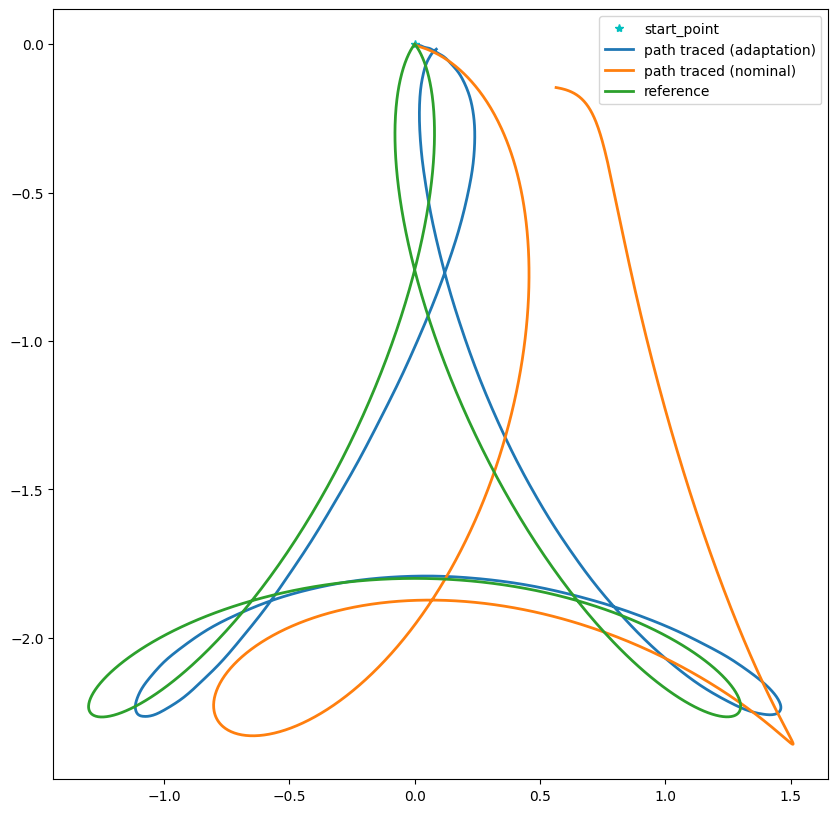

In [88]:
plt.figure(figsize=(10, 10) )
plt.plot(x_ref[0,0], x_ref[1,0],'c*', label='start_point',linewidth = 6.0)
plt.plot(x_new_dyn[:,0], x_new_dyn[:,1], label='path traced (adaptation)',linewidth = 2.0)
plt.plot(x_new_noadapt[:,0], x_new_noadapt[:,1], label='path traced (nominal)',linewidth = 2.0)
plt.plot(x_ref[0,:], x_ref[1,:], label='reference',linewidth = 2.0)
plt.legend()

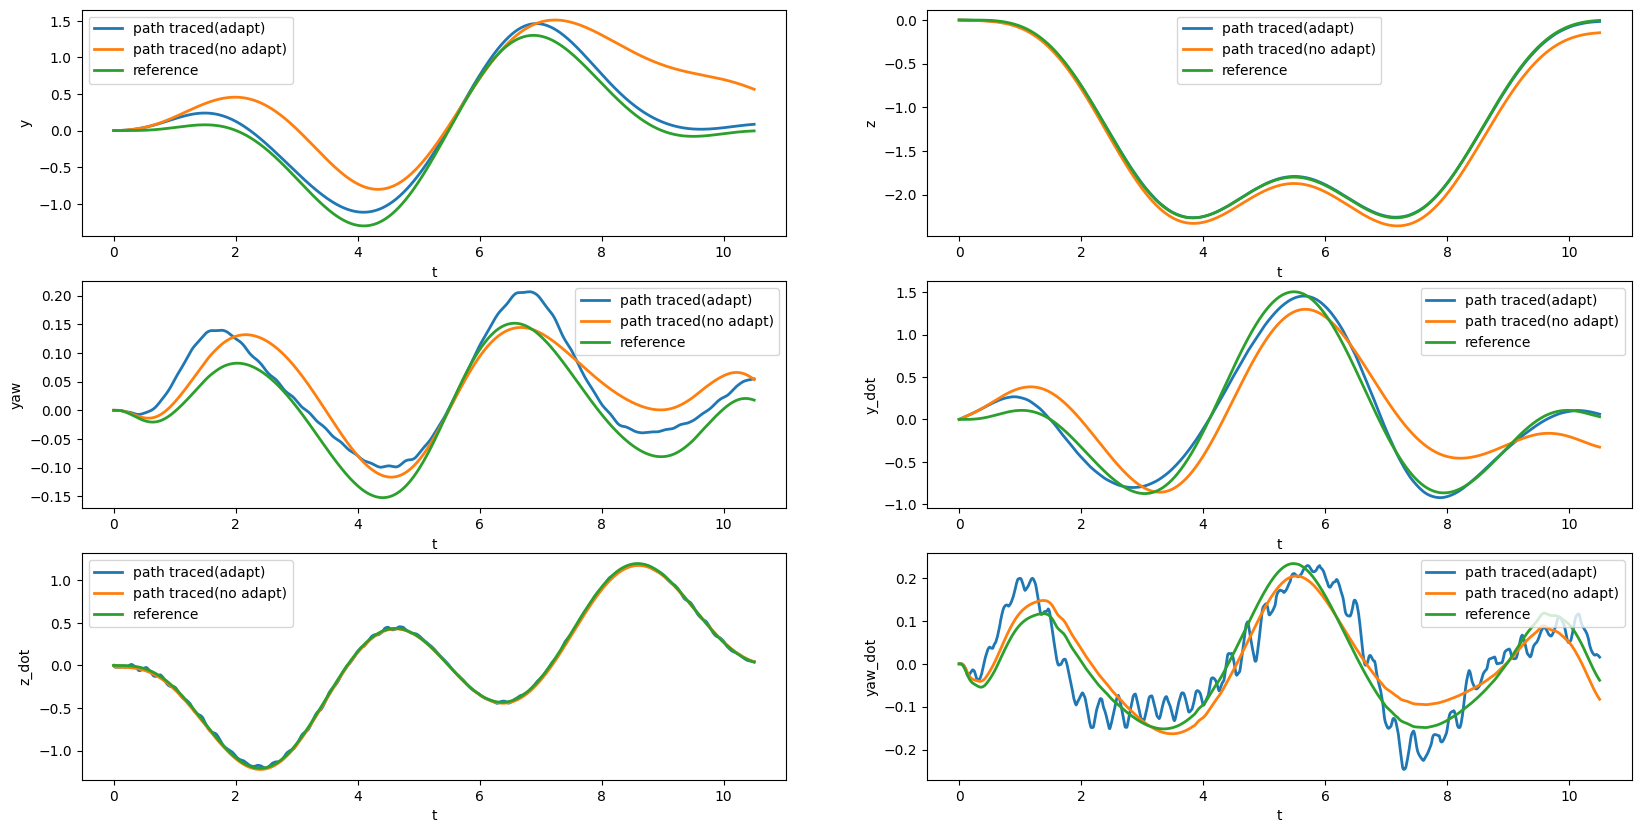

In [89]:
plt.figure(figsize=(20, 10) )
for i in range(num_states):
    plt.subplot(3,2,i+1)
    plt.plot(t_eval, x_new_dyn[:,i], label='path traced(adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_new_noadapt[:,i], label='path traced(no adapt)',linewidth = 2.0)
    plt.plot(t_eval, x_ref[i,:], label="reference",linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel(label_list[i])
    plt.legend()

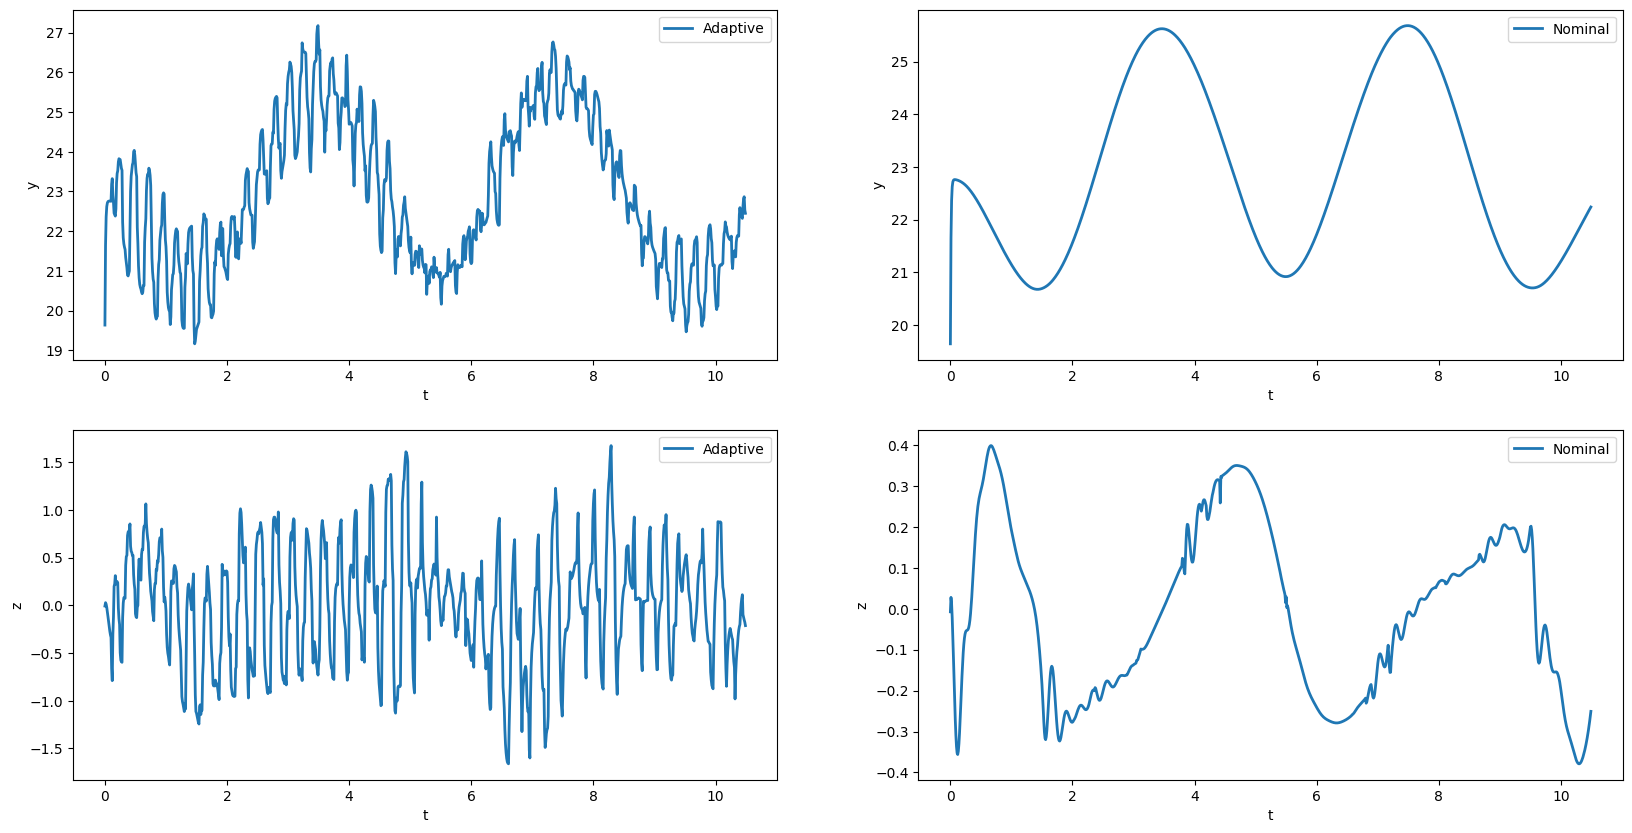

In [90]:
plt.figure(figsize=(20, 10) )
for i in range(num_inputs):
    plt.subplot(2,2,2*i+1)
    plt.plot(t_eval[:-1], u[:,i], label='Adaptive',linewidth = 2.0)
    plt.xlabel('t')
    plt.legend()
    plt.ylabel(label_list[i])

    plt.subplot(2,2,2*i+2)
    plt.plot(t_eval[:-1], u_no_adapt[:,i], label='Nominal',linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel(label_list[i])

    
    plt.legend()

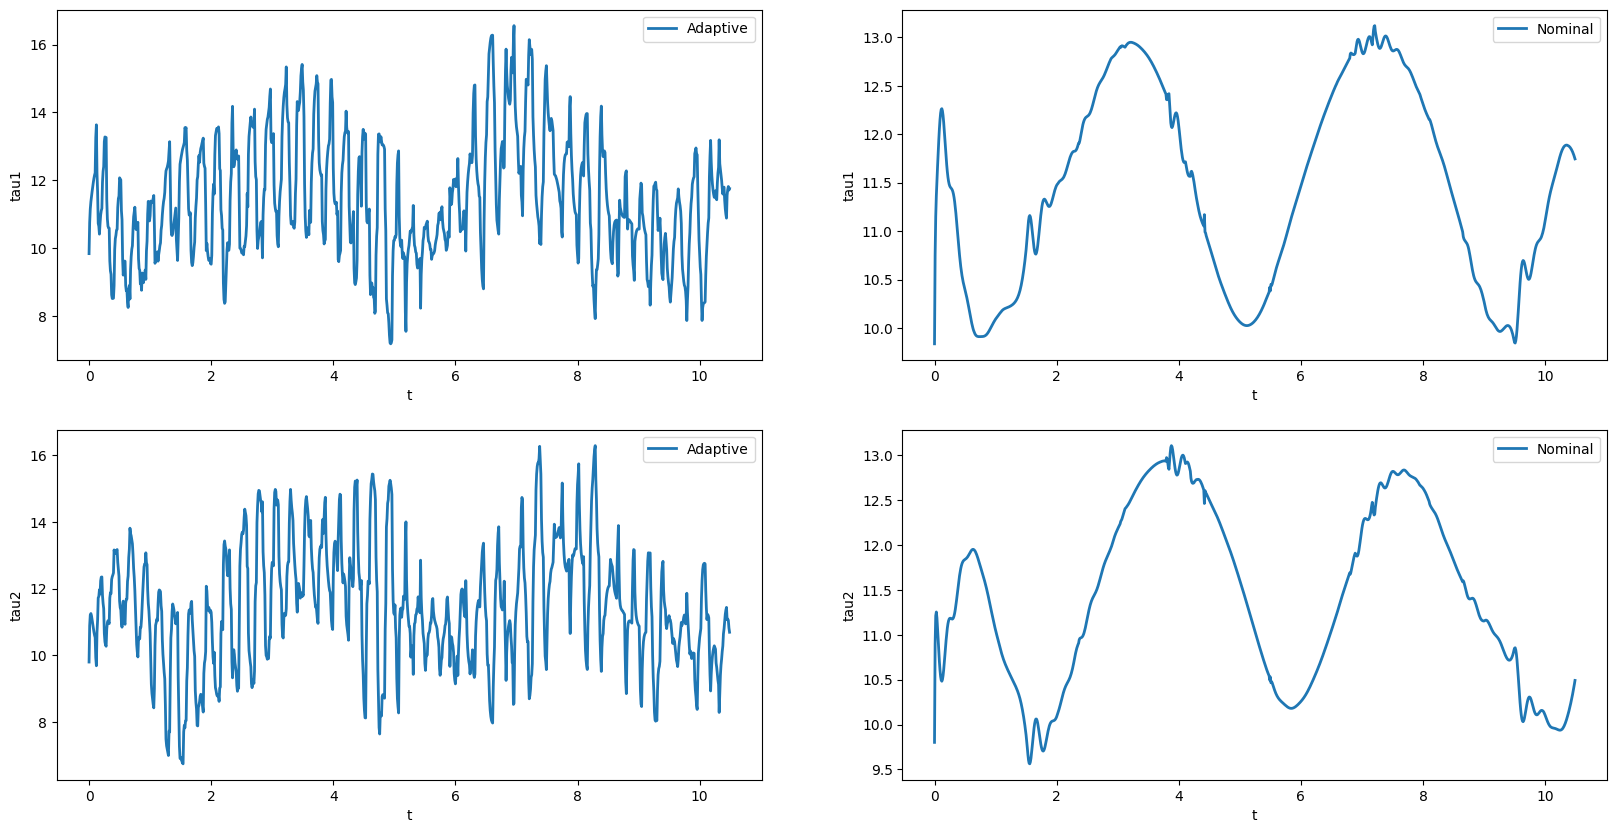

In [91]:
plt.figure(figsize=(20, 10) )
for i in range(num_inputs):
    plt.subplot(2,2,2*i+1)
    plt.plot(t_eval[:-1], tau_adapt_app[:,i], label='Adaptive',linewidth = 2.0)
    plt.xlabel('t')
    plt.legend()
    plt.ylabel('tau' + str(i+1))

    plt.subplot(2,2,2*i+2)
    plt.plot(t_eval[:-1], tau_no_adapt_app[:,i], label='Nominal',linewidth = 2.0)
    plt.xlabel('t')
    plt.ylabel('tau' + str(i+1))

    
    plt.legend()

Text(0.5, 1.0, '||del_B|| Evolution')

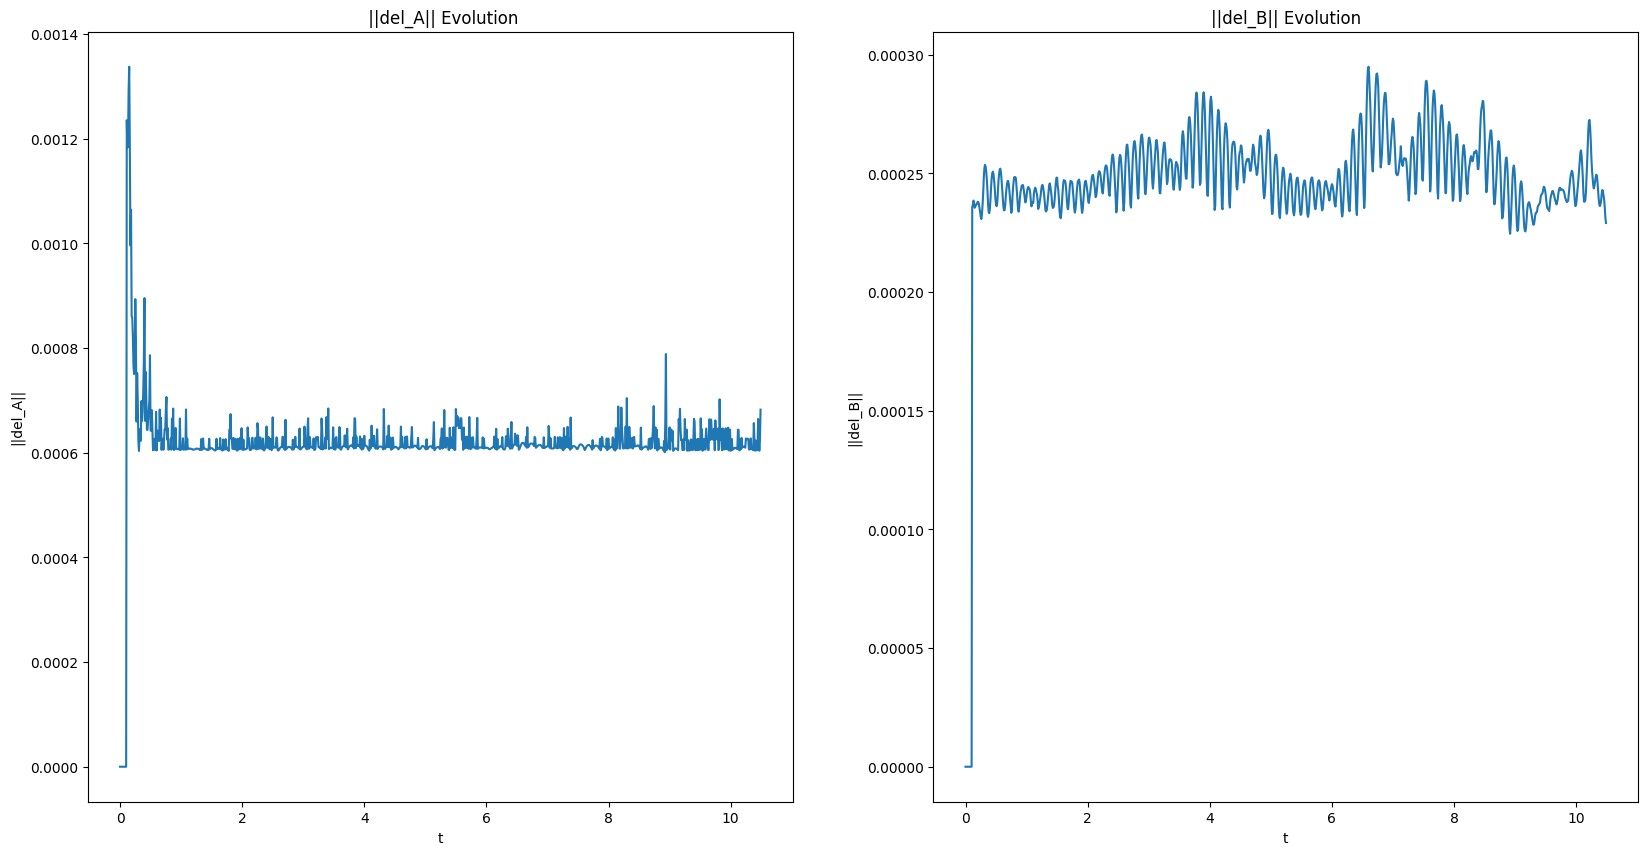

In [92]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval[:-1],del_A_norm)
plt.xlabel('t')
plt.ylabel('||del_A||')
plt.title(" ||del_A|| Evolution")

plt.subplot(1,2,2)
plt.plot(t_eval[:-1],del_B_norm)
plt.xlabel('t')
plt.ylabel('||del_B||')
plt.title("||del_B|| Evolution")

Text(0.5, 1.0, '||del_B||/||B|| Evolution')

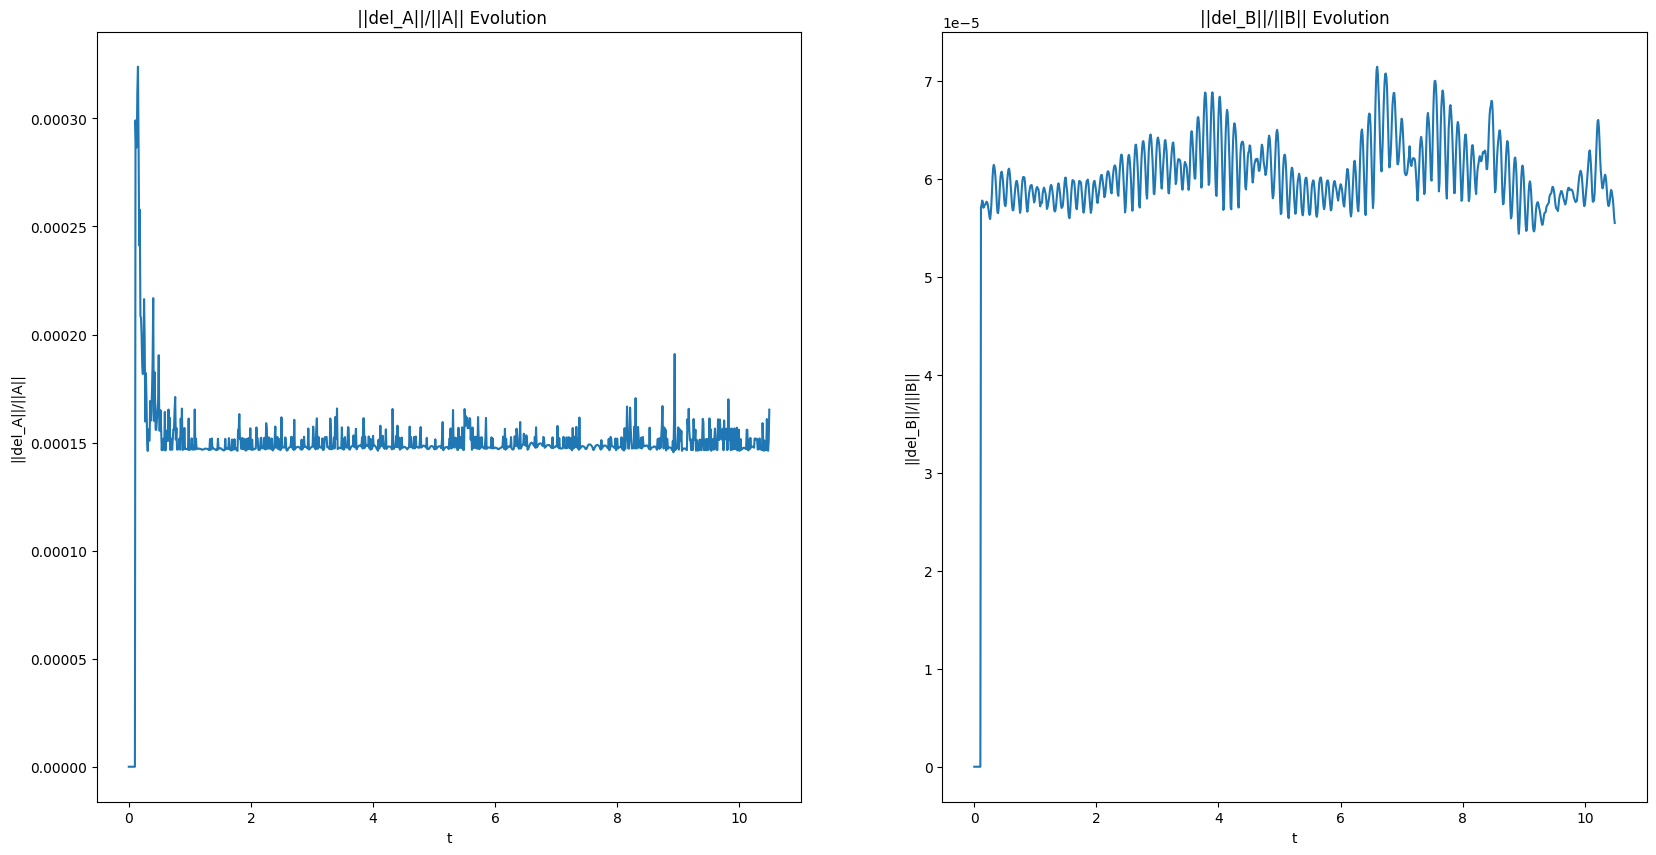

In [93]:
plt.figure(figsize = (20,10))

plt.subplot(1,2,1)
plt.plot(t_eval[:-1],del_A_norm/np.linalg.norm(A))
plt.xlabel('t')
plt.ylabel('||del_A||/||A||')
plt.title(" ||del_A||/||A|| Evolution")

plt.subplot(1,2,2)
plt.plot(t_eval[:-1],del_B_norm/np.linalg.norm(A))
plt.xlabel('t')
plt.ylabel('||del_B||/|||B||')
plt.title("||del_B||/||B|| Evolution")

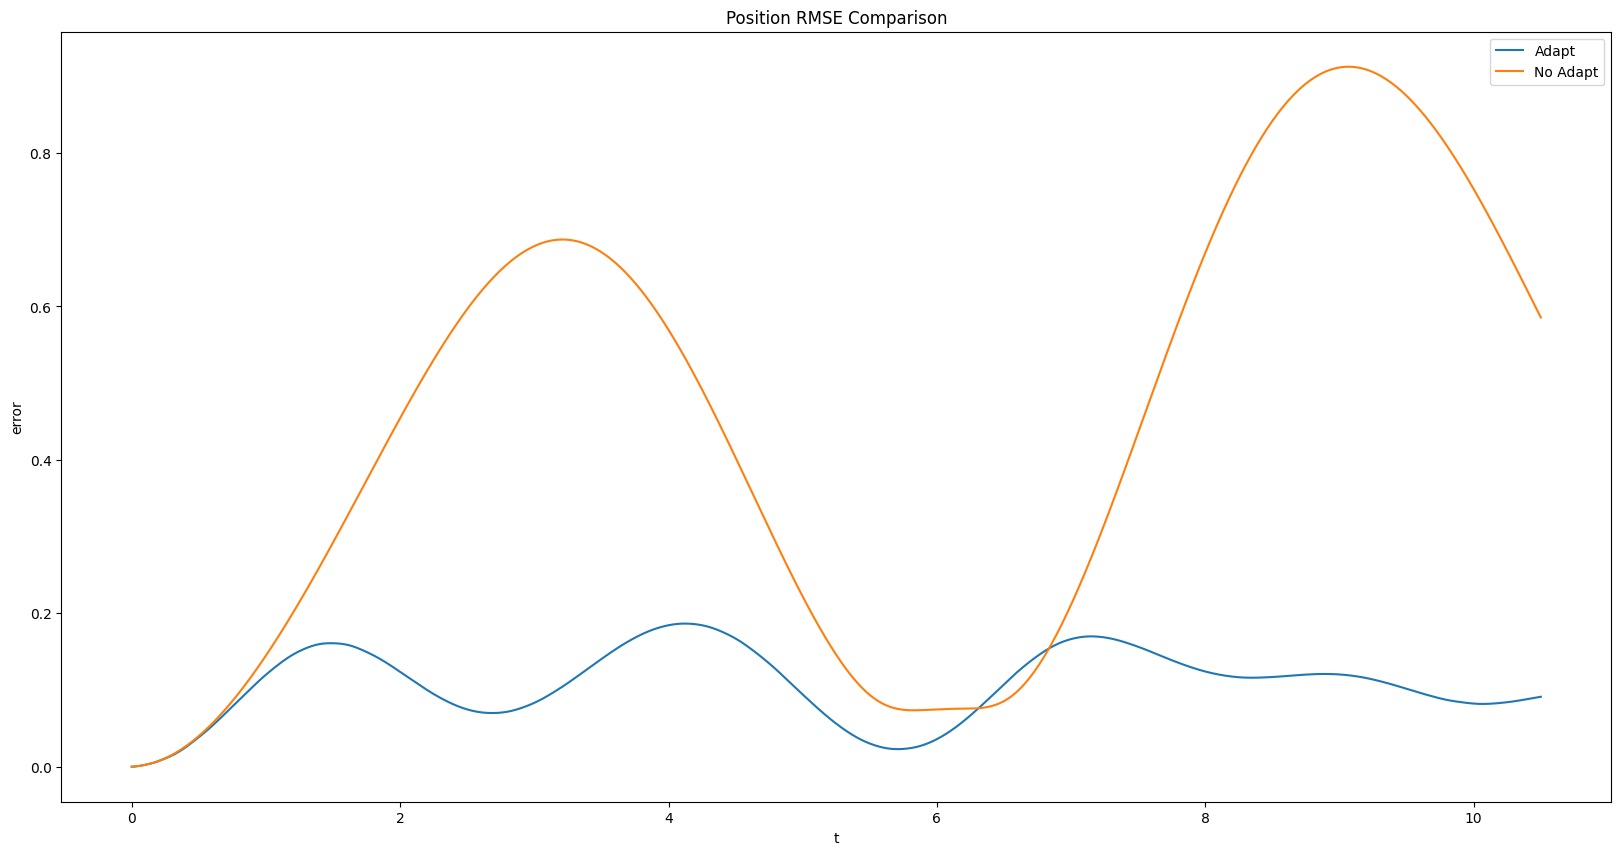

In [94]:
error_dynamics_pos_adapt = np.linalg.norm((x_new_dyn[:,:2].T-x_ref[:2,:]),axis=0)
error_dynamics_pos_no_adapt = np.linalg.norm((x_new_noadapt[:,:2].T-x_ref[:2,:]),axis=0)


plt.figure(figsize = (20,10))

plt.plot(t_eval,error_dynamics_pos_adapt, label = 'Adapt')
plt.plot(t_eval,error_dynamics_pos_no_adapt, label = 'No Adapt')
plt.title("Position RMSE Comparison")
plt.xlabel('t')
plt.ylabel('error')
plt.legend()



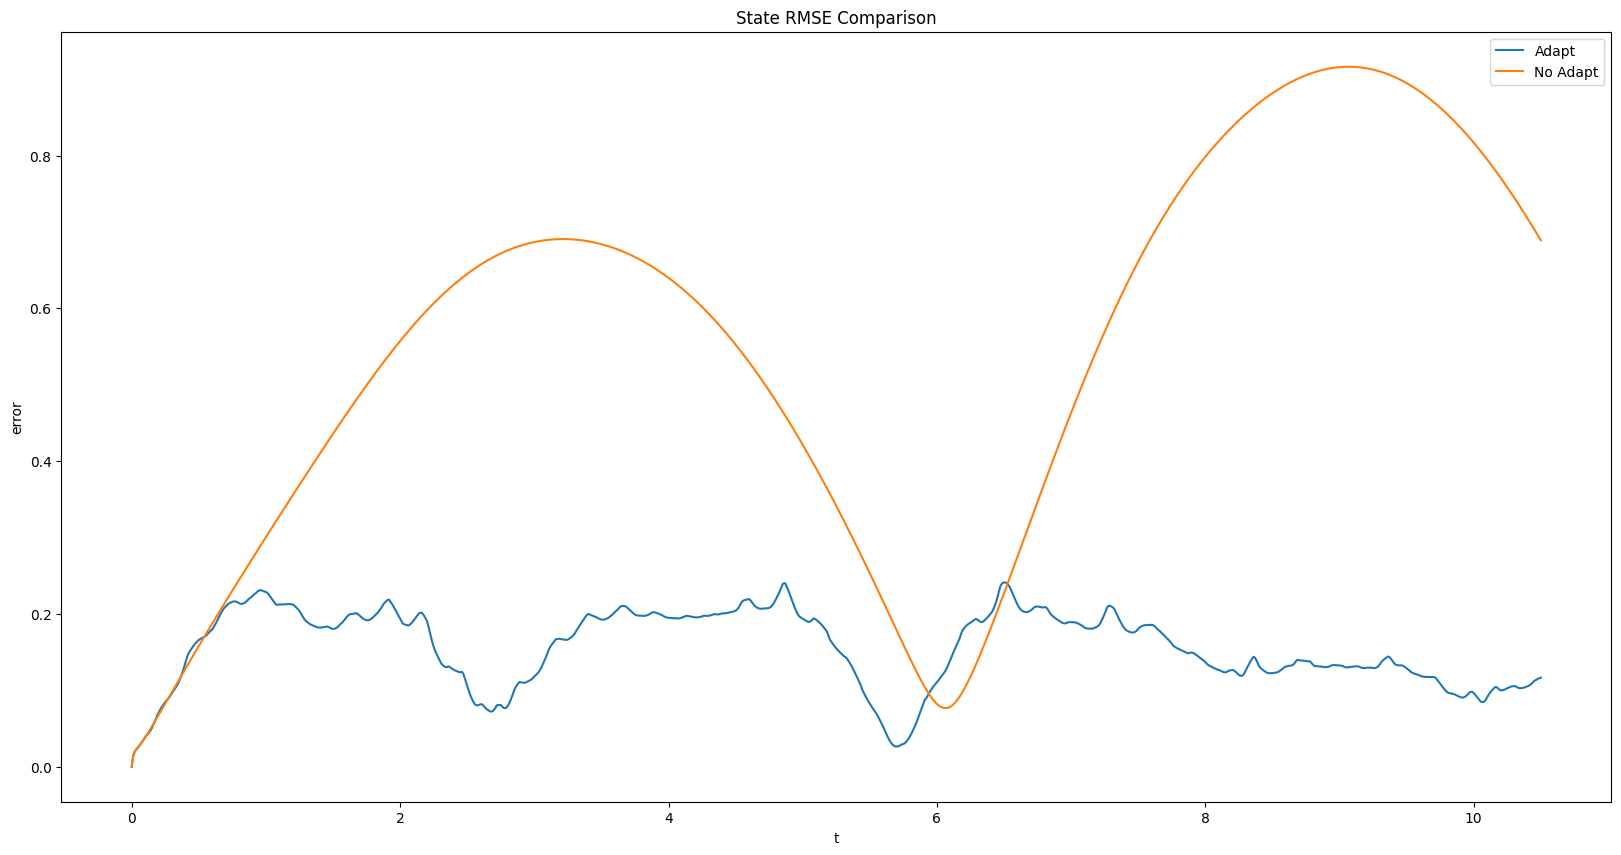

In [95]:
error_dynamics_adapt = np.linalg.norm((x_new_dyn.T-x_ref),axis=0)
error_dynamics_no_adapt = np.linalg.norm((x_new_noadapt.T-x_ref),axis=0)

plt.figure(figsize = (20,10))

plt.plot(t_eval,error_dynamics_adapt, label = 'Adapt')
plt.plot(t_eval,error_dynamics_no_adapt, label = 'No Adapt')
plt.title("State RMSE Comparison")

plt.xlabel('t')
plt.ylabel('error')
plt.legend()

In [96]:
error_dynamics_adapt_rmse = np.linalg.norm(error_dynamics_adapt)/np.sqrt(t_eval.shape[0])
error_dynamics_no_adapt_rmse = np.linalg.norm(error_dynamics_no_adapt)/np.sqrt(t_eval.shape[0])

error_dynamics_pos_adapt_rmse = np.linalg.norm(error_dynamics_pos_adapt)/np.sqrt(t_eval.shape[0])
error_dynamics_pos_no_adapt_rmse = np.linalg.norm(error_dynamics_pos_no_adapt)/np.sqrt(t_eval.shape[0])

print("RMSE Positional Error in Adaptive Model", error_dynamics_pos_adapt_rmse)
print("RMSE Error in Adaptive Model", error_dynamics_adapt_rmse)
print("RMSE Positional Error in Non-Adaptive Model", error_dynamics_pos_no_adapt_rmse)
print("RMSE Error in Non-Adaptive Model", error_dynamics_no_adapt_rmse)

RMSE Positional Error in Adaptive Model 0.11758505509660216
RMSE Error in Adaptive Model 0.1635590861860833
RMSE Positional Error in Non-Adaptive Model 0.5291430995404744
RMSE Error in Non-Adaptive Model 0.6020038458456224


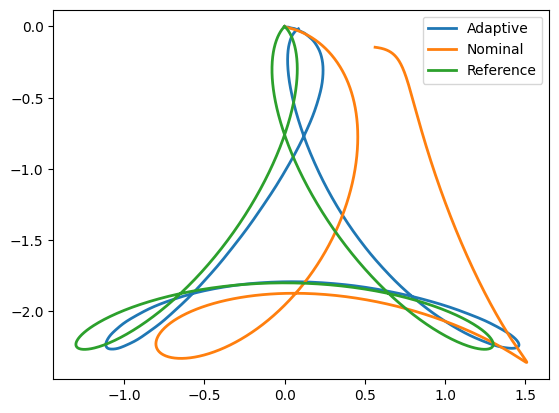

In [97]:
plt.figure()

plt.plot(x_new_dyn[:,0], x_new_dyn[:,1], label='Adaptive',linewidth = 2.0)
plt.plot(x_new_noadapt[:,0], x_new_noadapt[:,1], label='Nominal',linewidth = 2.0)
plt.plot(x_ref[0,:], x_ref[1,:], label='Reference',linewidth = 2.0)
plt.legend()
plt.savefig('results/quad/lin_adap_quad_'+traj_type + "_" + str(quad_params_changed["m"])+ "-" + str(quad_params_changed["V_w"]), dpi = 300, format = 'pdf')

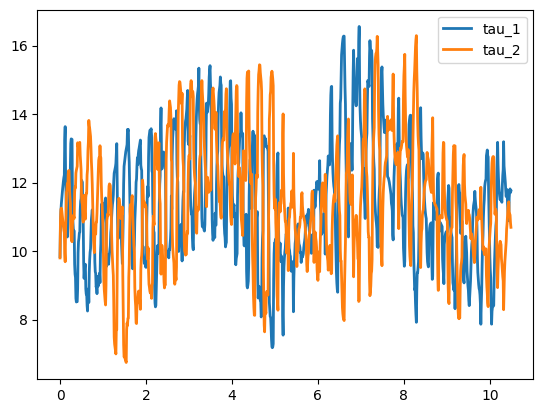

In [98]:
plt.figure()
plt.plot(t_eval[:-1], tau_adapt_app[:,0], label='tau_1',linewidth = 2.0)
plt.plot(t_eval[:-1], tau_adapt_app[:,1], label='tau_2',linewidth = 2.0)
plt.legend()
plt.savefig('results/quad/lin_adap_quad_'+traj_type+"_" + str(quad_params_changed["m"])+ "-" + str(quad_params_changed["V_w"])+"_input.pdf", dpi = 300, format = 'pdf')

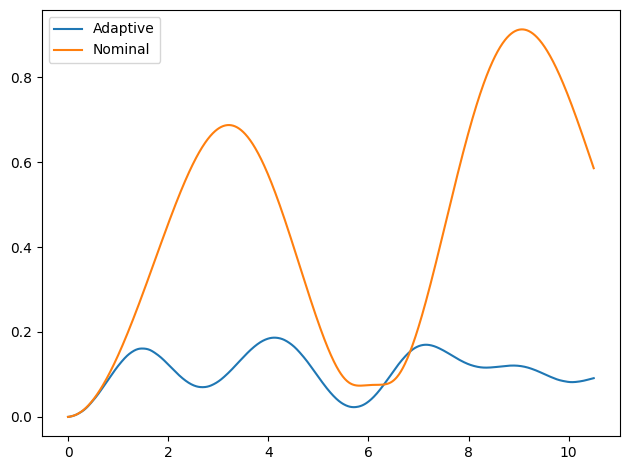

In [99]:
plt.figure()
plt.rcParams["figure.autolayout"] = True

plt.plot(t_eval,error_dynamics_pos_adapt, label = 'Adaptive')
plt.plot(t_eval,error_dynamics_pos_no_adapt, label = 'Nominal')
plt.legend()
plt.savefig('results/quad/lin_adap_quad_'+traj_type+ "_" + str(quad_params_changed["m"])+ "-" + str(quad_params_changed["V_w"])+"_error.pdf", dpi = 300, format = 'pdf')